# Model

In [2]:
import numpy as np
import matplotlib.pyplot as plt


In [3]:
# Define the true model and generate some noisy samples
# Set random seed
np.random.seed(3)

### Define a simple quadratic model
# y = a + b * x + c * x^2
# a = -1.45, b = 1.12, c = 2.3

beta_true = [-1.45, 1.12, 2.3]
def poly_model(x, beta):
    """
    INPUT
        x: x vector
        beta: polynomial parameters
        noise: enable noisy sampling
    """
    pol_order = len(beta)
    x_matrix = np.array([x**i for i in range(pol_order)]).transpose()
    y_true = np.matmul(x_matrix, beta)
    return y_true


# Data read

In [4]:
from numpy import genfromtxt
my_data = genfromtxt('training_set.txt', delimiter=',')
test_data = genfromtxt('test_set.txt', delimiter=',')
x_train = my_data.T[0]
y_train = my_data.T[1]
x_test = test_data.T[0]
y_test= test_data.T[1]

# plot

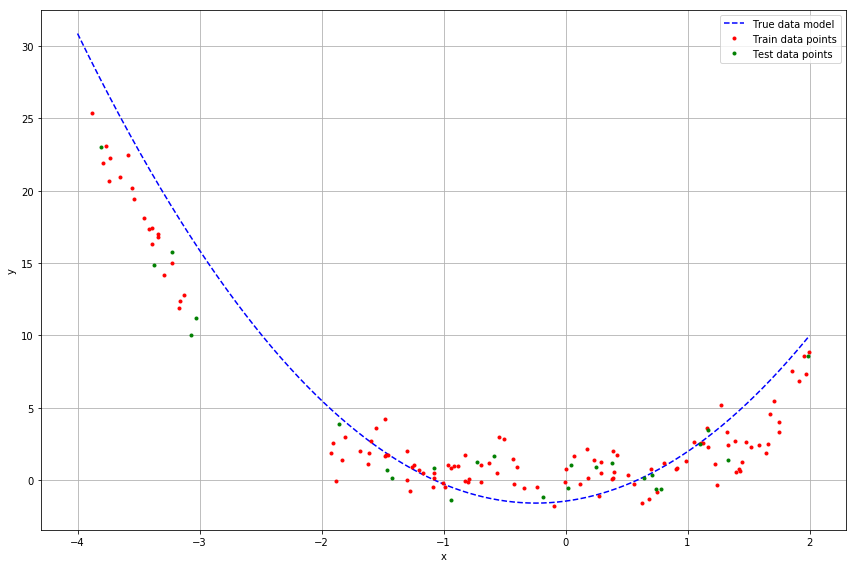

In [190]:
plt.close('all')
plt.figure(figsize=(12,8))
x_highres = np.linspace(-4,2,1000)
plt.plot(x_highres, poly_model(x_highres, beta_true), color='b', ls='--', label='True data model')
plt.plot(x_train, y_train, color='r', ls='', marker='.', label='Train data points')
plt.plot(x_test, y_test, color='g', ls='', marker='.', label='Test data points')
plt.xlabel('x')
plt.ylabel('y')
plt.grid()
plt.legend()
plt.tight_layout()
plt.show()


# Activation function 

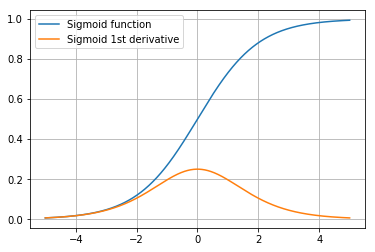

In [6]:
# Activation function

# Define activation function
from scipy.special import expit
act = expit
# 1st derivative
act_der = lambda x: act(x) * (1 - act(x))

# Plot activation function
x_plot = np.linspace(-5,5,1000)
y_act = act(x_plot)
y_act_der = act_der(x_plot)

plt.close('all')
plt.plot(x_plot, y_act, label='Sigmoid function')
plt.plot(x_plot, y_act_der, label='Sigmoid 1st derivative')
plt.legend()
plt.grid()
plt.show()


# Network class

In [7]:
class Network():
    
    def __init__(self, Ni, Nh1, Nh2, No):
            
        ### WEIGHT INITIALIZATION (Xavier)
        # Initialize hidden weights and biases (layer 1)
        Wh1 = (np.random.rand(Nh1, Ni) - 0.5) * np.sqrt(12 / (Nh1 + Ni))
        Bh1 = np.zeros([Nh1, 1])
        self.WBh1 = np.concatenate([Wh1, Bh1], 1) # Weight matrix including biases
        # Initialize hidden weights and biases (layer 2)
        Wh2 = (np.random.rand(Nh2, Nh1) - 0.5) * np.sqrt(12 / (Nh2 + Nh1))
        Bh2 = np.zeros([Nh2, 1])
        self.WBh2 = np.concatenate([Wh2, Bh2], 1) # Weight matrix including biases
        # Initialize output weights and biases
        Wo = (np.random.rand(No, Nh2) - 0.5) * np.sqrt(12 / (No + Nh2))
        Bo = np.zeros([No, 1])
        self.WBo = np.concatenate([Wo, Bo], 1) # Weight matrix including biases
        
        ### ACTIVATION FUNCTION
        self.act = expit
        self.act_der = lambda x: act(x) * (1 - act(x))
        
    def forward(self, x, additional_out=False):
        
        # Convert to numpy array
        x = np.array(x)
        
        ### Hidden layer 1
        # Add bias term
        X = np.append(x, 1)
        # Forward pass (linear)
        H1 = np.matmul(self.WBh1, X)
        # Activation function
        Z1 = self.act(H1)
        
        ### Hidden layer 2
        # Add bias term
        Z1 = np.append(Z1, 1)
        # Forward pass (linear)
        H2 = np.matmul(self.WBh2, Z1)
        # Activation function
        Z2 = self.act(H2)
        
        ### Output layer
        # Add bias term
        Z2 = np.append(Z2, 1)
        # Forward pass (linear)
        Y = np.matmul(self.WBo, Z2)
        # NO activation function
        
        if additional_out:
            return Y.squeeze(), Z2
        
        return Y.squeeze()
        
    def update(self, x, label, lr):
        #training part >> here it's not an sgd but convuluted derivatives
        # Convert to numpy array
        X = np.array(x)
        
        ### Hidden layer 1
        # Add bias term
        X = np.append(X, 1)
        # Forward pass (linear)
        H1 = np.matmul(self.WBh1, X)
        # Activation function
        Z1 = self.act(H1)
        
        ### Hidden layer 2
        # Add bias term
        Z1 = np.append(Z1, 1)
        # Forward pass (linear)
        H2 = np.matmul(self.WBh2, Z1)
        # Activation function
        Z2 = self.act(H2)
        
        ### Output layer
        # Add bias term
        Z2 = np.append(Z2, 1)
        # Forward pass (linear)
        Y = np.matmul(self.WBo, Z2)
        # NO activation function
        
        # Evaluate the derivative terms
        D1 = Y - label
        D2 = Z2
        D3 = self.WBo[:,:-1]
        D4 = self.act_der(H2)
        D5 = Z1
        D6 = self.WBh2[:,:-1]
        D7 = self.act_der(H1)
        D8 = X
        
        # Layer Error
        Eo = D1
        Eh2 = np.matmul(Eo, D3) * D4
        Eh1 = np.matmul(Eh2, D6) * D7
        
        
        # Derivative for weight matrices
        dWBo = np.matmul(Eo.reshape(-1,1), D2.reshape(1,-1))
        dWBh2 = np.matmul(Eh2.reshape(-1,1), D5.reshape(1,-1))
        dWBh1 = np.matmul(Eh1.reshape(-1,1), D8.reshape(1,-1))
        
        # Update the weights
        self.WBh1 -= lr * dWBh1
        self.WBh2 -= lr * dWBh2
        self.WBo -= lr * dWBo
        
        # Evaluate loss function
        loss = (Y - label)**2/2
        
        return loss
    
    def plot_weights(self):
    
        fig, axs = plt.subplots(3, 1, figsize=(12,6))
        axs[0].hist(self.WBh1.flatten(), 20)
        axs[1].hist(self.WBh2.flatten(), 50)
        axs[2].hist(self.WBo.flatten(), 20)
        plt.legend()
        plt.grid()
        plt.show()


# Parametters and initial network

 I believe that the most important task in this code is to decied the number of hisdden neurons in each layer, based on some research I will try duplicates of number of points in the input layer until convergence to a close solution

In [196]:
Ni= 1
Nh1_vec = [len(x_train),2*len(x_train), 3*len(x_train),4*len(x_train) ]

Nh2_vec= [4*len(x_train), 3*len(x_train), 2*len(x_train), len(x_train)]
No = 1

number of hidden neurons in first layer is: 120 number of hidden neurons in second layer is: 480
Epoch 1 - lr: 0.05000 - Train loss: 30.54247 - Test loss: 72.82657
Epoch 2 - lr: 0.05000 - Train loss: 18.62437 - Test loss: 54.66924
Epoch 3 - lr: 0.05000 - Train loss: 18.63015 - Test loss: 54.16140
Epoch 4 - lr: 0.05000 - Train loss: 18.57228 - Test loss: 53.91261
Epoch 5 - lr: 0.05000 - Train loss: 18.53516 - Test loss: 53.76548
Epoch 6 - lr: 0.05000 - Train loss: 18.51004 - Test loss: 53.66929
Epoch 7 - lr: 0.05000 - Train loss: 18.49222 - Test loss: 53.60297
Epoch 8 - lr: 0.05000 - Train loss: 18.47928 - Test loss: 53.55631
Epoch 9 - lr: 0.05000 - Train loss: 18.46996 - Test loss: 53.52392
Epoch 10 - lr: 0.05000 - Train loss: 18.46360 - Test loss: 53.50296
Epoch 11 - lr: 0.05000 - Train loss: 18.46002 - Test loss: 53.49212
Epoch 12 - lr: 0.05000 - Train loss: 18.45946 - Test loss: 53.49115
Epoch 13 - lr: 0.05000 - Train loss: 18.46254 - Test loss: 53.50043
Epoch 14 - lr: 0.05000 - Tra

Epoch 122 - lr: 0.05000 - Train loss: 18.12230 - Test loss: 53.53295
Epoch 123 - lr: 0.05000 - Train loss: 18.12067 - Test loss: 53.53600
Epoch 124 - lr: 0.05000 - Train loss: 18.11907 - Test loss: 53.53904
Epoch 125 - lr: 0.05000 - Train loss: 18.11748 - Test loss: 53.54206
Epoch 126 - lr: 0.05000 - Train loss: 18.11591 - Test loss: 53.54507
Epoch 127 - lr: 0.05000 - Train loss: 18.11436 - Test loss: 53.54806
Epoch 128 - lr: 0.05000 - Train loss: 18.11283 - Test loss: 53.55105
Epoch 129 - lr: 0.05000 - Train loss: 18.11132 - Test loss: 53.55402
Epoch 130 - lr: 0.05000 - Train loss: 18.10982 - Test loss: 53.55697
Epoch 131 - lr: 0.05000 - Train loss: 18.10834 - Test loss: 53.55992
Epoch 132 - lr: 0.05000 - Train loss: 18.10687 - Test loss: 53.56285
Epoch 133 - lr: 0.05000 - Train loss: 18.10543 - Test loss: 53.56576
Epoch 134 - lr: 0.05000 - Train loss: 18.10399 - Test loss: 53.56866
Epoch 135 - lr: 0.05000 - Train loss: 18.10258 - Test loss: 53.57155
Epoch 136 - lr: 0.05000 - Train lo

Epoch 243 - lr: 0.05000 - Train loss: 18.00727 - Test loss: 53.81233
Epoch 244 - lr: 0.05000 - Train loss: 18.00673 - Test loss: 53.81401
Epoch 245 - lr: 0.05000 - Train loss: 18.00619 - Test loss: 53.81568
Epoch 246 - lr: 0.05000 - Train loss: 18.00565 - Test loss: 53.81734
Epoch 247 - lr: 0.05000 - Train loss: 18.00512 - Test loss: 53.81900
Epoch 248 - lr: 0.05000 - Train loss: 18.00459 - Test loss: 53.82064
Epoch 249 - lr: 0.05000 - Train loss: 18.00406 - Test loss: 53.82228
Epoch 250 - lr: 0.05000 - Train loss: 18.00354 - Test loss: 53.82391
Epoch 251 - lr: 0.05000 - Train loss: 18.00302 - Test loss: 53.82553
Epoch 252 - lr: 0.05000 - Train loss: 18.00251 - Test loss: 53.82715
Epoch 253 - lr: 0.05000 - Train loss: 18.00200 - Test loss: 53.82875
Epoch 254 - lr: 0.05000 - Train loss: 18.00149 - Test loss: 53.83035
Epoch 255 - lr: 0.05000 - Train loss: 18.00099 - Test loss: 53.83194
Epoch 256 - lr: 0.05000 - Train loss: 18.00049 - Test loss: 53.83352
Epoch 257 - lr: 0.05000 - Train lo

Epoch 367 - lr: 0.05000 - Train loss: 17.96116 - Test loss: 53.96962
Epoch 368 - lr: 0.05000 - Train loss: 17.96091 - Test loss: 53.97055
Epoch 369 - lr: 0.05000 - Train loss: 17.96067 - Test loss: 53.97148
Epoch 370 - lr: 0.05000 - Train loss: 17.96042 - Test loss: 53.97241
Epoch 371 - lr: 0.05000 - Train loss: 17.96018 - Test loss: 53.97333
Epoch 372 - lr: 0.05000 - Train loss: 17.95993 - Test loss: 53.97425
Epoch 373 - lr: 0.05000 - Train loss: 17.95969 - Test loss: 53.97516
Epoch 374 - lr: 0.05000 - Train loss: 17.95945 - Test loss: 53.97607
Epoch 375 - lr: 0.05000 - Train loss: 17.95922 - Test loss: 53.97697
Epoch 376 - lr: 0.05000 - Train loss: 17.95898 - Test loss: 53.97787
Epoch 377 - lr: 0.05000 - Train loss: 17.95874 - Test loss: 53.97877
Epoch 378 - lr: 0.05000 - Train loss: 17.95851 - Test loss: 53.97966
Epoch 379 - lr: 0.05000 - Train loss: 17.95828 - Test loss: 53.98055
Epoch 380 - lr: 0.05000 - Train loss: 17.95804 - Test loss: 53.98143
Epoch 381 - lr: 0.05000 - Train lo

Epoch 486 - lr: 0.05000 - Train loss: 17.93925 - Test loss: 54.05597
Epoch 487 - lr: 0.05000 - Train loss: 17.93912 - Test loss: 54.05652
Epoch 488 - lr: 0.05000 - Train loss: 17.93899 - Test loss: 54.05707
Epoch 489 - lr: 0.05000 - Train loss: 17.93885 - Test loss: 54.05762
Epoch 490 - lr: 0.05000 - Train loss: 17.93872 - Test loss: 54.05816
Epoch 491 - lr: 0.05000 - Train loss: 17.93859 - Test loss: 54.05871
Epoch 492 - lr: 0.05000 - Train loss: 17.93846 - Test loss: 54.05925
Epoch 493 - lr: 0.05000 - Train loss: 17.93833 - Test loss: 54.05978
Epoch 494 - lr: 0.05000 - Train loss: 17.93820 - Test loss: 54.06032
Epoch 495 - lr: 0.05000 - Train loss: 17.93807 - Test loss: 54.06085
Epoch 496 - lr: 0.05000 - Train loss: 17.93794 - Test loss: 54.06138
Epoch 497 - lr: 0.05000 - Train loss: 17.93781 - Test loss: 54.06191
Epoch 498 - lr: 0.05000 - Train loss: 17.93769 - Test loss: 54.06243
Epoch 499 - lr: 0.05000 - Train loss: 17.93756 - Test loss: 54.06296
Epoch 500 - lr: 0.05000 - Train lo

Epoch 606 - lr: 0.05000 - Train loss: 17.92680 - Test loss: 54.10784
Epoch 607 - lr: 0.05000 - Train loss: 17.92672 - Test loss: 54.10817
Epoch 608 - lr: 0.05000 - Train loss: 17.92664 - Test loss: 54.10850
Epoch 609 - lr: 0.05000 - Train loss: 17.92656 - Test loss: 54.10883
Epoch 610 - lr: 0.05000 - Train loss: 17.92648 - Test loss: 54.10916
Epoch 611 - lr: 0.05000 - Train loss: 17.92641 - Test loss: 54.10948
Epoch 612 - lr: 0.05000 - Train loss: 17.92633 - Test loss: 54.10981
Epoch 613 - lr: 0.05000 - Train loss: 17.92625 - Test loss: 54.11013
Epoch 614 - lr: 0.05000 - Train loss: 17.92617 - Test loss: 54.11045
Epoch 615 - lr: 0.05000 - Train loss: 17.92610 - Test loss: 54.11077
Epoch 616 - lr: 0.05000 - Train loss: 17.92602 - Test loss: 54.11109
Epoch 617 - lr: 0.05000 - Train loss: 17.92594 - Test loss: 54.11141
Epoch 618 - lr: 0.05000 - Train loss: 17.92587 - Test loss: 54.11172
Epoch 619 - lr: 0.05000 - Train loss: 17.92579 - Test loss: 54.11204
Epoch 620 - lr: 0.05000 - Train lo

Epoch 731 - lr: 0.05000 - Train loss: 17.91898 - Test loss: 54.14010
Epoch 732 - lr: 0.05000 - Train loss: 17.91894 - Test loss: 54.14030
Epoch 733 - lr: 0.05000 - Train loss: 17.91889 - Test loss: 54.14049
Epoch 734 - lr: 0.05000 - Train loss: 17.91884 - Test loss: 54.14069
Epoch 735 - lr: 0.05000 - Train loss: 17.91879 - Test loss: 54.14088
Epoch 736 - lr: 0.05000 - Train loss: 17.91874 - Test loss: 54.14107
Epoch 737 - lr: 0.05000 - Train loss: 17.91869 - Test loss: 54.14126
Epoch 738 - lr: 0.05000 - Train loss: 17.91865 - Test loss: 54.14145
Epoch 739 - lr: 0.05000 - Train loss: 17.91860 - Test loss: 54.14164
Epoch 740 - lr: 0.05000 - Train loss: 17.91855 - Test loss: 54.14183
Epoch 741 - lr: 0.05000 - Train loss: 17.91851 - Test loss: 54.14202
Epoch 742 - lr: 0.05000 - Train loss: 17.91846 - Test loss: 54.14221
Epoch 743 - lr: 0.05000 - Train loss: 17.91841 - Test loss: 54.14239
Epoch 744 - lr: 0.05000 - Train loss: 17.91836 - Test loss: 54.14258
Epoch 745 - lr: 0.05000 - Train lo

Epoch 855 - lr: 0.05000 - Train loss: 17.91408 - Test loss: 54.15885
Epoch 856 - lr: 0.05000 - Train loss: 17.91405 - Test loss: 54.15896
Epoch 857 - lr: 0.05000 - Train loss: 17.91402 - Test loss: 54.15907
Epoch 858 - lr: 0.05000 - Train loss: 17.91399 - Test loss: 54.15918
Epoch 859 - lr: 0.05000 - Train loss: 17.91396 - Test loss: 54.15929
Epoch 860 - lr: 0.05000 - Train loss: 17.91392 - Test loss: 54.15940
Epoch 861 - lr: 0.05000 - Train loss: 17.91389 - Test loss: 54.15951
Epoch 862 - lr: 0.05000 - Train loss: 17.91386 - Test loss: 54.15962
Epoch 863 - lr: 0.05000 - Train loss: 17.91383 - Test loss: 54.15973
Epoch 864 - lr: 0.05000 - Train loss: 17.91380 - Test loss: 54.15984
Epoch 865 - lr: 0.05000 - Train loss: 17.91377 - Test loss: 54.15995
Epoch 866 - lr: 0.05000 - Train loss: 17.91374 - Test loss: 54.16006
Epoch 867 - lr: 0.05000 - Train loss: 17.91371 - Test loss: 54.16016
Epoch 868 - lr: 0.05000 - Train loss: 17.91368 - Test loss: 54.16027
Epoch 869 - lr: 0.05000 - Train lo

Epoch 979 - lr: 0.05000 - Train loss: 17.91083 - Test loss: 54.16928
Epoch 980 - lr: 0.05000 - Train loss: 17.91081 - Test loss: 54.16934
Epoch 981 - lr: 0.05000 - Train loss: 17.91079 - Test loss: 54.16940
Epoch 982 - lr: 0.05000 - Train loss: 17.91077 - Test loss: 54.16945
Epoch 983 - lr: 0.05000 - Train loss: 17.91075 - Test loss: 54.16951
Epoch 984 - lr: 0.05000 - Train loss: 17.91073 - Test loss: 54.16957
Epoch 985 - lr: 0.05000 - Train loss: 17.91071 - Test loss: 54.16963
Epoch 986 - lr: 0.05000 - Train loss: 17.91068 - Test loss: 54.16968
Epoch 987 - lr: 0.05000 - Train loss: 17.91066 - Test loss: 54.16974
Epoch 988 - lr: 0.05000 - Train loss: 17.91064 - Test loss: 54.16980
Epoch 989 - lr: 0.05000 - Train loss: 17.91062 - Test loss: 54.16985
Epoch 990 - lr: 0.05000 - Train loss: 17.91060 - Test loss: 54.16991
Epoch 991 - lr: 0.05000 - Train loss: 17.91058 - Test loss: 54.16996
Epoch 992 - lr: 0.05000 - Train loss: 17.91056 - Test loss: 54.17002
Epoch 993 - lr: 0.05000 - Train lo

Epoch 1098 - lr: 0.05000 - Train loss: 17.90868 - Test loss: 54.17413
Epoch 1099 - lr: 0.05000 - Train loss: 17.90867 - Test loss: 54.17415
Epoch 1100 - lr: 0.05000 - Train loss: 17.90865 - Test loss: 54.17417
Epoch 1101 - lr: 0.05000 - Train loss: 17.90864 - Test loss: 54.17420
Epoch 1102 - lr: 0.05000 - Train loss: 17.90862 - Test loss: 54.17422
Epoch 1103 - lr: 0.05000 - Train loss: 17.90861 - Test loss: 54.17425
Epoch 1104 - lr: 0.05000 - Train loss: 17.90859 - Test loss: 54.17427
Epoch 1105 - lr: 0.05000 - Train loss: 17.90858 - Test loss: 54.17429
Epoch 1106 - lr: 0.05000 - Train loss: 17.90856 - Test loss: 54.17431
Epoch 1107 - lr: 0.05000 - Train loss: 17.90855 - Test loss: 54.17434
Epoch 1108 - lr: 0.05000 - Train loss: 17.90853 - Test loss: 54.17436
Epoch 1109 - lr: 0.05000 - Train loss: 17.90852 - Test loss: 54.17438
Epoch 1110 - lr: 0.05000 - Train loss: 17.90850 - Test loss: 54.17440
Epoch 1111 - lr: 0.05000 - Train loss: 17.90849 - Test loss: 54.17442
Epoch 1112 - lr: 0.0

Epoch 1216 - lr: 0.05000 - Train loss: 17.90716 - Test loss: 54.17550
Epoch 1217 - lr: 0.05000 - Train loss: 17.90715 - Test loss: 54.17550
Epoch 1218 - lr: 0.05000 - Train loss: 17.90714 - Test loss: 54.17550
Epoch 1219 - lr: 0.05000 - Train loss: 17.90713 - Test loss: 54.17550
Epoch 1220 - lr: 0.05000 - Train loss: 17.90712 - Test loss: 54.17550
Epoch 1221 - lr: 0.05000 - Train loss: 17.90711 - Test loss: 54.17550
Epoch 1222 - lr: 0.05000 - Train loss: 17.90710 - Test loss: 54.17550
Epoch 1223 - lr: 0.05000 - Train loss: 17.90709 - Test loss: 54.17550
Epoch 1224 - lr: 0.05000 - Train loss: 17.90708 - Test loss: 54.17549
Epoch 1225 - lr: 0.05000 - Train loss: 17.90707 - Test loss: 54.17549
Epoch 1226 - lr: 0.05000 - Train loss: 17.90705 - Test loss: 54.17549
Epoch 1227 - lr: 0.05000 - Train loss: 17.90704 - Test loss: 54.17549
Epoch 1228 - lr: 0.05000 - Train loss: 17.90703 - Test loss: 54.17549
Epoch 1229 - lr: 0.05000 - Train loss: 17.90702 - Test loss: 54.17549
Epoch 1230 - lr: 0.0

Epoch 1335 - lr: 0.05000 - Train loss: 17.90605 - Test loss: 54.17441
Epoch 1336 - lr: 0.05000 - Train loss: 17.90604 - Test loss: 54.17440
Epoch 1337 - lr: 0.05000 - Train loss: 17.90604 - Test loss: 54.17438
Epoch 1338 - lr: 0.05000 - Train loss: 17.90603 - Test loss: 54.17436
Epoch 1339 - lr: 0.05000 - Train loss: 17.90602 - Test loss: 54.17434
Epoch 1340 - lr: 0.05000 - Train loss: 17.90601 - Test loss: 54.17432
Epoch 1341 - lr: 0.05000 - Train loss: 17.90600 - Test loss: 54.17431
Epoch 1342 - lr: 0.05000 - Train loss: 17.90600 - Test loss: 54.17429
Epoch 1343 - lr: 0.05000 - Train loss: 17.90599 - Test loss: 54.17427
Epoch 1344 - lr: 0.05000 - Train loss: 17.90598 - Test loss: 54.17425
Epoch 1345 - lr: 0.05000 - Train loss: 17.90597 - Test loss: 54.17423
Epoch 1346 - lr: 0.05000 - Train loss: 17.90597 - Test loss: 54.17421
Epoch 1347 - lr: 0.05000 - Train loss: 17.90596 - Test loss: 54.17419
Epoch 1348 - lr: 0.05000 - Train loss: 17.90595 - Test loss: 54.17418
Epoch 1349 - lr: 0.0

Epoch 1454 - lr: 0.05000 - Train loss: 17.90524 - Test loss: 54.17151
Epoch 1455 - lr: 0.05000 - Train loss: 17.90523 - Test loss: 54.17148
Epoch 1456 - lr: 0.05000 - Train loss: 17.90523 - Test loss: 54.17145
Epoch 1457 - lr: 0.05000 - Train loss: 17.90522 - Test loss: 54.17142
Epoch 1458 - lr: 0.05000 - Train loss: 17.90522 - Test loss: 54.17139
Epoch 1459 - lr: 0.05000 - Train loss: 17.90521 - Test loss: 54.17136
Epoch 1460 - lr: 0.05000 - Train loss: 17.90520 - Test loss: 54.17133
Epoch 1461 - lr: 0.05000 - Train loss: 17.90520 - Test loss: 54.17130
Epoch 1462 - lr: 0.05000 - Train loss: 17.90519 - Test loss: 54.17127
Epoch 1463 - lr: 0.05000 - Train loss: 17.90519 - Test loss: 54.17123
Epoch 1464 - lr: 0.05000 - Train loss: 17.90518 - Test loss: 54.17120
Epoch 1465 - lr: 0.05000 - Train loss: 17.90518 - Test loss: 54.17117
Epoch 1466 - lr: 0.05000 - Train loss: 17.90517 - Test loss: 54.17114
Epoch 1467 - lr: 0.05000 - Train loss: 17.90516 - Test loss: 54.17111
Epoch 1468 - lr: 0.0

Epoch 1573 - lr: 0.05000 - Train loss: 17.90464 - Test loss: 54.16724
Epoch 1574 - lr: 0.05000 - Train loss: 17.90464 - Test loss: 54.16720
Epoch 1575 - lr: 0.05000 - Train loss: 17.90463 - Test loss: 54.16716
Epoch 1576 - lr: 0.05000 - Train loss: 17.90463 - Test loss: 54.16712
Epoch 1577 - lr: 0.05000 - Train loss: 17.90463 - Test loss: 54.16707
Epoch 1578 - lr: 0.05000 - Train loss: 17.90462 - Test loss: 54.16703
Epoch 1579 - lr: 0.05000 - Train loss: 17.90462 - Test loss: 54.16699
Epoch 1580 - lr: 0.05000 - Train loss: 17.90461 - Test loss: 54.16695
Epoch 1581 - lr: 0.05000 - Train loss: 17.90461 - Test loss: 54.16691
Epoch 1582 - lr: 0.05000 - Train loss: 17.90461 - Test loss: 54.16687
Epoch 1583 - lr: 0.05000 - Train loss: 17.90460 - Test loss: 54.16683
Epoch 1584 - lr: 0.05000 - Train loss: 17.90460 - Test loss: 54.16679
Epoch 1585 - lr: 0.05000 - Train loss: 17.90459 - Test loss: 54.16674
Epoch 1586 - lr: 0.05000 - Train loss: 17.90459 - Test loss: 54.16670
Epoch 1587 - lr: 0.0

Epoch 1691 - lr: 0.05000 - Train loss: 17.90421 - Test loss: 54.16191
Epoch 1692 - lr: 0.05000 - Train loss: 17.90421 - Test loss: 54.16186
Epoch 1693 - lr: 0.05000 - Train loss: 17.90421 - Test loss: 54.16181
Epoch 1694 - lr: 0.05000 - Train loss: 17.90421 - Test loss: 54.16176
Epoch 1695 - lr: 0.05000 - Train loss: 17.90420 - Test loss: 54.16171
Epoch 1696 - lr: 0.05000 - Train loss: 17.90420 - Test loss: 54.16166
Epoch 1697 - lr: 0.05000 - Train loss: 17.90420 - Test loss: 54.16161
Epoch 1698 - lr: 0.05000 - Train loss: 17.90419 - Test loss: 54.16156
Epoch 1699 - lr: 0.05000 - Train loss: 17.90419 - Test loss: 54.16151
Epoch 1700 - lr: 0.05000 - Train loss: 17.90419 - Test loss: 54.16146
Epoch 1701 - lr: 0.05000 - Train loss: 17.90418 - Test loss: 54.16141
Epoch 1702 - lr: 0.05000 - Train loss: 17.90418 - Test loss: 54.16136
Epoch 1703 - lr: 0.05000 - Train loss: 17.90418 - Test loss: 54.16131
Epoch 1704 - lr: 0.05000 - Train loss: 17.90418 - Test loss: 54.16126
Epoch 1705 - lr: 0.0

Epoch 1812 - lr: 0.05000 - Train loss: 17.90391 - Test loss: 54.15537
Epoch 1813 - lr: 0.05000 - Train loss: 17.90391 - Test loss: 54.15531
Epoch 1814 - lr: 0.05000 - Train loss: 17.90391 - Test loss: 54.15525
Epoch 1815 - lr: 0.05000 - Train loss: 17.90391 - Test loss: 54.15519
Epoch 1816 - lr: 0.05000 - Train loss: 17.90390 - Test loss: 54.15513
Epoch 1817 - lr: 0.05000 - Train loss: 17.90390 - Test loss: 54.15507
Epoch 1818 - lr: 0.05000 - Train loss: 17.90390 - Test loss: 54.15501
Epoch 1819 - lr: 0.05000 - Train loss: 17.90390 - Test loss: 54.15495
Epoch 1820 - lr: 0.05000 - Train loss: 17.90390 - Test loss: 54.15489
Epoch 1821 - lr: 0.05000 - Train loss: 17.90389 - Test loss: 54.15483
Epoch 1822 - lr: 0.05000 - Train loss: 17.90389 - Test loss: 54.15477
Epoch 1823 - lr: 0.05000 - Train loss: 17.90389 - Test loss: 54.15471
Epoch 1824 - lr: 0.05000 - Train loss: 17.90389 - Test loss: 54.15465
Epoch 1825 - lr: 0.05000 - Train loss: 17.90389 - Test loss: 54.15459
Epoch 1826 - lr: 0.0

Epoch 1930 - lr: 0.05000 - Train loss: 17.90376 - Test loss: 54.14738
Epoch 1931 - lr: 0.05000 - Train loss: 17.90376 - Test loss: 54.14730
Epoch 1932 - lr: 0.05000 - Train loss: 17.90376 - Test loss: 54.14722
Epoch 1933 - lr: 0.05000 - Train loss: 17.90376 - Test loss: 54.14714
Epoch 1934 - lr: 0.05000 - Train loss: 17.90376 - Test loss: 54.14706
Epoch 1935 - lr: 0.05000 - Train loss: 17.90376 - Test loss: 54.14698
Epoch 1936 - lr: 0.05000 - Train loss: 17.90376 - Test loss: 54.14689
Epoch 1937 - lr: 0.05000 - Train loss: 17.90376 - Test loss: 54.14681
Epoch 1938 - lr: 0.05000 - Train loss: 17.90376 - Test loss: 54.14673
Epoch 1939 - lr: 0.05000 - Train loss: 17.90376 - Test loss: 54.14664
Epoch 1940 - lr: 0.05000 - Train loss: 17.90376 - Test loss: 54.14656
Epoch 1941 - lr: 0.05000 - Train loss: 17.90376 - Test loss: 54.14647
Epoch 1942 - lr: 0.05000 - Train loss: 17.90376 - Test loss: 54.14639
Epoch 1943 - lr: 0.05000 - Train loss: 17.90376 - Test loss: 54.14630
Epoch 1944 - lr: 0.0

Epoch 2051 - lr: 0.05000 - Train loss: 17.90407 - Test loss: 54.13156
Epoch 2052 - lr: 0.05000 - Train loss: 17.90408 - Test loss: 54.13134
Epoch 2053 - lr: 0.05000 - Train loss: 17.90409 - Test loss: 54.13111
Epoch 2054 - lr: 0.05000 - Train loss: 17.90410 - Test loss: 54.13089
Epoch 2055 - lr: 0.05000 - Train loss: 17.90411 - Test loss: 54.13066
Epoch 2056 - lr: 0.05000 - Train loss: 17.90412 - Test loss: 54.13043
Epoch 2057 - lr: 0.05000 - Train loss: 17.90413 - Test loss: 54.13020
Epoch 2058 - lr: 0.05000 - Train loss: 17.90413 - Test loss: 54.12996
Epoch 2059 - lr: 0.05000 - Train loss: 17.90414 - Test loss: 54.12973
Epoch 2060 - lr: 0.05000 - Train loss: 17.90415 - Test loss: 54.12949
Epoch 2061 - lr: 0.05000 - Train loss: 17.90416 - Test loss: 54.12925
Epoch 2062 - lr: 0.05000 - Train loss: 17.90417 - Test loss: 54.12901
Epoch 2063 - lr: 0.05000 - Train loss: 17.90418 - Test loss: 54.12877
Epoch 2064 - lr: 0.05000 - Train loss: 17.90419 - Test loss: 54.12852
Epoch 2065 - lr: 0.0

Epoch 2169 - lr: 0.05000 - Train loss: 17.90508 - Test loss: 54.10568
Epoch 2170 - lr: 0.05000 - Train loss: 17.90508 - Test loss: 54.10552
Epoch 2171 - lr: 0.05000 - Train loss: 17.90509 - Test loss: 54.10536
Epoch 2172 - lr: 0.05000 - Train loss: 17.90509 - Test loss: 54.10521
Epoch 2173 - lr: 0.05000 - Train loss: 17.90509 - Test loss: 54.10505
Epoch 2174 - lr: 0.05000 - Train loss: 17.90510 - Test loss: 54.10490
Epoch 2175 - lr: 0.05000 - Train loss: 17.90510 - Test loss: 54.10475
Epoch 2176 - lr: 0.05000 - Train loss: 17.90511 - Test loss: 54.10459
Epoch 2177 - lr: 0.05000 - Train loss: 17.90511 - Test loss: 54.10444
Epoch 2178 - lr: 0.05000 - Train loss: 17.90511 - Test loss: 54.10429
Epoch 2179 - lr: 0.05000 - Train loss: 17.90512 - Test loss: 54.10413
Epoch 2180 - lr: 0.05000 - Train loss: 17.90512 - Test loss: 54.10398
Epoch 2181 - lr: 0.05000 - Train loss: 17.90513 - Test loss: 54.10383
Epoch 2182 - lr: 0.05000 - Train loss: 17.90513 - Test loss: 54.10368
Epoch 2183 - lr: 0.0

Epoch 2289 - lr: 0.05000 - Train loss: 17.90571 - Test loss: 54.08478
Epoch 2290 - lr: 0.05000 - Train loss: 17.90572 - Test loss: 54.08458
Epoch 2291 - lr: 0.05000 - Train loss: 17.90572 - Test loss: 54.08437
Epoch 2292 - lr: 0.05000 - Train loss: 17.90573 - Test loss: 54.08417
Epoch 2293 - lr: 0.05000 - Train loss: 17.90574 - Test loss: 54.08396
Epoch 2294 - lr: 0.05000 - Train loss: 17.90575 - Test loss: 54.08376
Epoch 2295 - lr: 0.05000 - Train loss: 17.90576 - Test loss: 54.08356
Epoch 2296 - lr: 0.05000 - Train loss: 17.90576 - Test loss: 54.08335
Epoch 2297 - lr: 0.05000 - Train loss: 17.90577 - Test loss: 54.08315
Epoch 2298 - lr: 0.05000 - Train loss: 17.90578 - Test loss: 54.08295
Epoch 2299 - lr: 0.05000 - Train loss: 17.90579 - Test loss: 54.08275
Epoch 2300 - lr: 0.05000 - Train loss: 17.90580 - Test loss: 54.08255
Epoch 2301 - lr: 0.05000 - Train loss: 17.90580 - Test loss: 54.08235
Epoch 2302 - lr: 0.05000 - Train loss: 17.90581 - Test loss: 54.08215
Epoch 2303 - lr: 0.0

Epoch 2412 - lr: 0.05000 - Train loss: 17.90617 - Test loss: 54.06743
Epoch 2413 - lr: 0.05000 - Train loss: 17.90617 - Test loss: 54.06735
Epoch 2414 - lr: 0.05000 - Train loss: 17.90617 - Test loss: 54.06727
Epoch 2415 - lr: 0.05000 - Train loss: 17.90617 - Test loss: 54.06719
Epoch 2416 - lr: 0.05000 - Train loss: 17.90617 - Test loss: 54.06711
Epoch 2417 - lr: 0.05000 - Train loss: 17.90617 - Test loss: 54.06703
Epoch 2418 - lr: 0.05000 - Train loss: 17.90617 - Test loss: 54.06695
Epoch 2419 - lr: 0.05000 - Train loss: 17.90617 - Test loss: 54.06687
Epoch 2420 - lr: 0.05000 - Train loss: 17.90617 - Test loss: 54.06679
Epoch 2421 - lr: 0.05000 - Train loss: 17.90617 - Test loss: 54.06671
Epoch 2422 - lr: 0.05000 - Train loss: 17.90616 - Test loss: 54.06664
Epoch 2423 - lr: 0.05000 - Train loss: 17.90616 - Test loss: 54.06656
Epoch 2424 - lr: 0.05000 - Train loss: 17.90616 - Test loss: 54.06648
Epoch 2425 - lr: 0.05000 - Train loss: 17.90616 - Test loss: 54.06641
Epoch 2426 - lr: 0.0

Epoch 2531 - lr: 0.05000 - Train loss: 17.90597 - Test loss: 54.05985
Epoch 2532 - lr: 0.05000 - Train loss: 17.90596 - Test loss: 54.05980
Epoch 2533 - lr: 0.05000 - Train loss: 17.90596 - Test loss: 54.05974
Epoch 2534 - lr: 0.05000 - Train loss: 17.90596 - Test loss: 54.05969
Epoch 2535 - lr: 0.05000 - Train loss: 17.90596 - Test loss: 54.05964
Epoch 2536 - lr: 0.05000 - Train loss: 17.90595 - Test loss: 54.05958
Epoch 2537 - lr: 0.05000 - Train loss: 17.90595 - Test loss: 54.05953
Epoch 2538 - lr: 0.05000 - Train loss: 17.90595 - Test loss: 54.05947
Epoch 2539 - lr: 0.05000 - Train loss: 17.90595 - Test loss: 54.05942
Epoch 2540 - lr: 0.05000 - Train loss: 17.90595 - Test loss: 54.05937
Epoch 2541 - lr: 0.05000 - Train loss: 17.90594 - Test loss: 54.05931
Epoch 2542 - lr: 0.05000 - Train loss: 17.90594 - Test loss: 54.05926
Epoch 2543 - lr: 0.05000 - Train loss: 17.90594 - Test loss: 54.05920
Epoch 2544 - lr: 0.05000 - Train loss: 17.90594 - Test loss: 54.05915
Epoch 2545 - lr: 0.0

Epoch 2653 - lr: 0.05000 - Train loss: 17.90571 - Test loss: 54.05345
Epoch 2654 - lr: 0.05000 - Train loss: 17.90571 - Test loss: 54.05339
Epoch 2655 - lr: 0.05000 - Train loss: 17.90571 - Test loss: 54.05334
Epoch 2656 - lr: 0.05000 - Train loss: 17.90570 - Test loss: 54.05329
Epoch 2657 - lr: 0.05000 - Train loss: 17.90570 - Test loss: 54.05324
Epoch 2658 - lr: 0.05000 - Train loss: 17.90570 - Test loss: 54.05319
Epoch 2659 - lr: 0.05000 - Train loss: 17.90570 - Test loss: 54.05313
Epoch 2660 - lr: 0.05000 - Train loss: 17.90570 - Test loss: 54.05308
Epoch 2661 - lr: 0.05000 - Train loss: 17.90569 - Test loss: 54.05303
Epoch 2662 - lr: 0.05000 - Train loss: 17.90569 - Test loss: 54.05298
Epoch 2663 - lr: 0.05000 - Train loss: 17.90569 - Test loss: 54.05293
Epoch 2664 - lr: 0.05000 - Train loss: 17.90569 - Test loss: 54.05287
Epoch 2665 - lr: 0.05000 - Train loss: 17.90569 - Test loss: 54.05282
Epoch 2666 - lr: 0.05000 - Train loss: 17.90568 - Test loss: 54.05277
Epoch 2667 - lr: 0.0

Epoch 2771 - lr: 0.05000 - Train loss: 17.90550 - Test loss: 54.04730
Epoch 2772 - lr: 0.05000 - Train loss: 17.90550 - Test loss: 54.04725
Epoch 2773 - lr: 0.05000 - Train loss: 17.90550 - Test loss: 54.04720
Epoch 2774 - lr: 0.05000 - Train loss: 17.90550 - Test loss: 54.04715
Epoch 2775 - lr: 0.05000 - Train loss: 17.90550 - Test loss: 54.04709
Epoch 2776 - lr: 0.05000 - Train loss: 17.90550 - Test loss: 54.04704
Epoch 2777 - lr: 0.05000 - Train loss: 17.90549 - Test loss: 54.04699
Epoch 2778 - lr: 0.05000 - Train loss: 17.90549 - Test loss: 54.04694
Epoch 2779 - lr: 0.05000 - Train loss: 17.90549 - Test loss: 54.04689
Epoch 2780 - lr: 0.05000 - Train loss: 17.90549 - Test loss: 54.04683
Epoch 2781 - lr: 0.05000 - Train loss: 17.90549 - Test loss: 54.04678
Epoch 2782 - lr: 0.05000 - Train loss: 17.90549 - Test loss: 54.04673
Epoch 2783 - lr: 0.05000 - Train loss: 17.90549 - Test loss: 54.04668
Epoch 2784 - lr: 0.05000 - Train loss: 17.90548 - Test loss: 54.04663
Epoch 2785 - lr: 0.0

Epoch 2890 - lr: 0.05000 - Train loss: 17.90530 - Test loss: 54.04129
Epoch 2891 - lr: 0.05000 - Train loss: 17.90530 - Test loss: 54.04124
Epoch 2892 - lr: 0.05000 - Train loss: 17.90530 - Test loss: 54.04120
Epoch 2893 - lr: 0.05000 - Train loss: 17.90530 - Test loss: 54.04115
Epoch 2894 - lr: 0.05000 - Train loss: 17.90530 - Test loss: 54.04111
Epoch 2895 - lr: 0.05000 - Train loss: 17.90529 - Test loss: 54.04106
Epoch 2896 - lr: 0.05000 - Train loss: 17.90529 - Test loss: 54.04102
Epoch 2897 - lr: 0.05000 - Train loss: 17.90529 - Test loss: 54.04097
Epoch 2898 - lr: 0.05000 - Train loss: 17.90529 - Test loss: 54.04092
Epoch 2899 - lr: 0.05000 - Train loss: 17.90528 - Test loss: 54.04088
Epoch 2900 - lr: 0.05000 - Train loss: 17.90528 - Test loss: 54.04084
Epoch 2901 - lr: 0.05000 - Train loss: 17.90528 - Test loss: 54.04079
Epoch 2902 - lr: 0.05000 - Train loss: 17.90528 - Test loss: 54.04075
Epoch 2903 - lr: 0.05000 - Train loss: 17.90527 - Test loss: 54.04070
Epoch 2904 - lr: 0.0

Epoch 3009 - lr: 0.05000 - Train loss: 17.90532 - Test loss: 54.03380
Epoch 3010 - lr: 0.05000 - Train loss: 17.90532 - Test loss: 54.03375
Epoch 3011 - lr: 0.05000 - Train loss: 17.90532 - Test loss: 54.03370
Epoch 3012 - lr: 0.05000 - Train loss: 17.90532 - Test loss: 54.03364
Epoch 3013 - lr: 0.05000 - Train loss: 17.90532 - Test loss: 54.03359
Epoch 3014 - lr: 0.05000 - Train loss: 17.90532 - Test loss: 54.03354
Epoch 3015 - lr: 0.05000 - Train loss: 17.90531 - Test loss: 54.03349
Epoch 3016 - lr: 0.05000 - Train loss: 17.90531 - Test loss: 54.03344
Epoch 3017 - lr: 0.05000 - Train loss: 17.90531 - Test loss: 54.03338
Epoch 3018 - lr: 0.05000 - Train loss: 17.90531 - Test loss: 54.03333
Epoch 3019 - lr: 0.05000 - Train loss: 17.90531 - Test loss: 54.03328
Epoch 3020 - lr: 0.05000 - Train loss: 17.90531 - Test loss: 54.03323
Epoch 3021 - lr: 0.05000 - Train loss: 17.90531 - Test loss: 54.03317
Epoch 3022 - lr: 0.05000 - Train loss: 17.90531 - Test loss: 54.03312
Epoch 3023 - lr: 0.0

Epoch 3127 - lr: 0.05000 - Train loss: 17.90520 - Test loss: 54.02768
Epoch 3128 - lr: 0.05000 - Train loss: 17.90520 - Test loss: 54.02763
Epoch 3129 - lr: 0.05000 - Train loss: 17.90520 - Test loss: 54.02758
Epoch 3130 - lr: 0.05000 - Train loss: 17.90520 - Test loss: 54.02753
Epoch 3131 - lr: 0.05000 - Train loss: 17.90520 - Test loss: 54.02748
Epoch 3132 - lr: 0.05000 - Train loss: 17.90520 - Test loss: 54.02742
Epoch 3133 - lr: 0.05000 - Train loss: 17.90519 - Test loss: 54.02737
Epoch 3134 - lr: 0.05000 - Train loss: 17.90519 - Test loss: 54.02732
Epoch 3135 - lr: 0.05000 - Train loss: 17.90519 - Test loss: 54.02727
Epoch 3136 - lr: 0.05000 - Train loss: 17.90519 - Test loss: 54.02722
Epoch 3137 - lr: 0.05000 - Train loss: 17.90519 - Test loss: 54.02717
Epoch 3138 - lr: 0.05000 - Train loss: 17.90519 - Test loss: 54.02712
Epoch 3139 - lr: 0.05000 - Train loss: 17.90519 - Test loss: 54.02707
Epoch 3140 - lr: 0.05000 - Train loss: 17.90519 - Test loss: 54.02702
Epoch 3141 - lr: 0.0

Epoch 3246 - lr: 0.05000 - Train loss: 17.90499 - Test loss: 54.02232
Epoch 3247 - lr: 0.05000 - Train loss: 17.90499 - Test loss: 54.02229
Epoch 3248 - lr: 0.05000 - Train loss: 17.90499 - Test loss: 54.02226
Epoch 3249 - lr: 0.05000 - Train loss: 17.90498 - Test loss: 54.02224
Epoch 3250 - lr: 0.05000 - Train loss: 17.90498 - Test loss: 54.02222
Epoch 3251 - lr: 0.05000 - Train loss: 17.90497 - Test loss: 54.02219
Epoch 3252 - lr: 0.05000 - Train loss: 17.90497 - Test loss: 54.02217
Epoch 3253 - lr: 0.05000 - Train loss: 17.90496 - Test loss: 54.02215
Epoch 3254 - lr: 0.05000 - Train loss: 17.90496 - Test loss: 54.02213
Epoch 3255 - lr: 0.05000 - Train loss: 17.90495 - Test loss: 54.02211
Epoch 3256 - lr: 0.05000 - Train loss: 17.90495 - Test loss: 54.02210
Epoch 3257 - lr: 0.05000 - Train loss: 17.90494 - Test loss: 54.02208
Epoch 3258 - lr: 0.05000 - Train loss: 17.90494 - Test loss: 54.02207
Epoch 3259 - lr: 0.05000 - Train loss: 17.90493 - Test loss: 54.02206
Epoch 3260 - lr: 0.0

Epoch 3369 - lr: 0.05000 - Train loss: 17.90512 - Test loss: 54.01414
Epoch 3370 - lr: 0.05000 - Train loss: 17.90512 - Test loss: 54.01409
Epoch 3371 - lr: 0.05000 - Train loss: 17.90512 - Test loss: 54.01404
Epoch 3372 - lr: 0.05000 - Train loss: 17.90512 - Test loss: 54.01399
Epoch 3373 - lr: 0.05000 - Train loss: 17.90512 - Test loss: 54.01394
Epoch 3374 - lr: 0.05000 - Train loss: 17.90512 - Test loss: 54.01389
Epoch 3375 - lr: 0.05000 - Train loss: 17.90512 - Test loss: 54.01384
Epoch 3376 - lr: 0.05000 - Train loss: 17.90512 - Test loss: 54.01379
Epoch 3377 - lr: 0.05000 - Train loss: 17.90512 - Test loss: 54.01374
Epoch 3378 - lr: 0.05000 - Train loss: 17.90512 - Test loss: 54.01369
Epoch 3379 - lr: 0.05000 - Train loss: 17.90511 - Test loss: 54.01364
Epoch 3380 - lr: 0.05000 - Train loss: 17.90511 - Test loss: 54.01359
Epoch 3381 - lr: 0.05000 - Train loss: 17.90511 - Test loss: 54.01354
Epoch 3382 - lr: 0.05000 - Train loss: 17.90511 - Test loss: 54.01349
Epoch 3383 - lr: 0.0

Epoch 3491 - lr: 0.05000 - Train loss: 17.90502 - Test loss: 54.00815
Epoch 3492 - lr: 0.05000 - Train loss: 17.90502 - Test loss: 54.00810
Epoch 3493 - lr: 0.05000 - Train loss: 17.90502 - Test loss: 54.00806
Epoch 3494 - lr: 0.05000 - Train loss: 17.90501 - Test loss: 54.00801
Epoch 3495 - lr: 0.05000 - Train loss: 17.90501 - Test loss: 54.00796
Epoch 3496 - lr: 0.05000 - Train loss: 17.90501 - Test loss: 54.00791
Epoch 3497 - lr: 0.05000 - Train loss: 17.90501 - Test loss: 54.00786
Epoch 3498 - lr: 0.05000 - Train loss: 17.90501 - Test loss: 54.00781
Epoch 3499 - lr: 0.05000 - Train loss: 17.90501 - Test loss: 54.00776
Epoch 3500 - lr: 0.05000 - Train loss: 17.90501 - Test loss: 54.00772
Epoch 3501 - lr: 0.05000 - Train loss: 17.90501 - Test loss: 54.00767
Epoch 3502 - lr: 0.05000 - Train loss: 17.90501 - Test loss: 54.00762
Epoch 3503 - lr: 0.05000 - Train loss: 17.90501 - Test loss: 54.00757
Epoch 3504 - lr: 0.05000 - Train loss: 17.90501 - Test loss: 54.00752
Epoch 3505 - lr: 0.0

Epoch 3614 - lr: 0.05000 - Train loss: 17.90489 - Test loss: 54.00233
Epoch 3615 - lr: 0.05000 - Train loss: 17.90489 - Test loss: 54.00229
Epoch 3616 - lr: 0.05000 - Train loss: 17.90489 - Test loss: 54.00224
Epoch 3617 - lr: 0.05000 - Train loss: 17.90489 - Test loss: 54.00220
Epoch 3618 - lr: 0.05000 - Train loss: 17.90489 - Test loss: 54.00215
Epoch 3619 - lr: 0.05000 - Train loss: 17.90489 - Test loss: 54.00211
Epoch 3620 - lr: 0.05000 - Train loss: 17.90489 - Test loss: 54.00206
Epoch 3621 - lr: 0.05000 - Train loss: 17.90489 - Test loss: 54.00202
Epoch 3622 - lr: 0.05000 - Train loss: 17.90488 - Test loss: 54.00197
Epoch 3623 - lr: 0.05000 - Train loss: 17.90488 - Test loss: 54.00193
Epoch 3624 - lr: 0.05000 - Train loss: 17.90488 - Test loss: 54.00188
Epoch 3625 - lr: 0.05000 - Train loss: 17.90488 - Test loss: 54.00184
Epoch 3626 - lr: 0.05000 - Train loss: 17.90488 - Test loss: 54.00179
Epoch 3627 - lr: 0.05000 - Train loss: 17.90488 - Test loss: 54.00175
Epoch 3628 - lr: 0.0

Epoch 3732 - lr: 0.05000 - Train loss: 17.90465 - Test loss: 53.99787
Epoch 3733 - lr: 0.05000 - Train loss: 17.90464 - Test loss: 53.99785
Epoch 3734 - lr: 0.05000 - Train loss: 17.90464 - Test loss: 53.99784
Epoch 3735 - lr: 0.05000 - Train loss: 17.90463 - Test loss: 53.99783
Epoch 3736 - lr: 0.05000 - Train loss: 17.90463 - Test loss: 53.99781
Epoch 3737 - lr: 0.05000 - Train loss: 17.90462 - Test loss: 53.99780
Epoch 3738 - lr: 0.05000 - Train loss: 17.90462 - Test loss: 53.99780
Epoch 3739 - lr: 0.05000 - Train loss: 17.90461 - Test loss: 53.99779
Epoch 3740 - lr: 0.05000 - Train loss: 17.90461 - Test loss: 53.99778
Epoch 3741 - lr: 0.05000 - Train loss: 17.90460 - Test loss: 53.99778
Epoch 3742 - lr: 0.05000 - Train loss: 17.90459 - Test loss: 53.99778
Epoch 3743 - lr: 0.05000 - Train loss: 17.90459 - Test loss: 53.99778
Epoch 3744 - lr: 0.05000 - Train loss: 17.90458 - Test loss: 53.99778
Epoch 3745 - lr: 0.05000 - Train loss: 17.90457 - Test loss: 53.99779
Epoch 3746 - lr: 0.0

Epoch 3856 - lr: 0.05000 - Train loss: 17.90482 - Test loss: 53.99026
Epoch 3857 - lr: 0.05000 - Train loss: 17.90482 - Test loss: 53.99024
Epoch 3858 - lr: 0.05000 - Train loss: 17.90481 - Test loss: 53.99021
Epoch 3859 - lr: 0.05000 - Train loss: 17.90481 - Test loss: 53.99018
Epoch 3860 - lr: 0.05000 - Train loss: 17.90480 - Test loss: 53.99016
Epoch 3861 - lr: 0.05000 - Train loss: 17.90480 - Test loss: 53.99013
Epoch 3862 - lr: 0.05000 - Train loss: 17.90480 - Test loss: 53.99011
Epoch 3863 - lr: 0.05000 - Train loss: 17.90479 - Test loss: 53.99008
Epoch 3864 - lr: 0.05000 - Train loss: 17.90479 - Test loss: 53.99005
Epoch 3865 - lr: 0.05000 - Train loss: 17.90478 - Test loss: 53.99003
Epoch 3866 - lr: 0.05000 - Train loss: 17.90478 - Test loss: 53.99000
Epoch 3867 - lr: 0.05000 - Train loss: 17.90478 - Test loss: 53.98997
Epoch 3868 - lr: 0.05000 - Train loss: 17.90477 - Test loss: 53.98994
Epoch 3869 - lr: 0.05000 - Train loss: 17.90477 - Test loss: 53.98992
Epoch 3870 - lr: 0.0

Epoch 3975 - lr: 0.05000 - Train loss: 17.90440 - Test loss: 53.98720
Epoch 3976 - lr: 0.05000 - Train loss: 17.90439 - Test loss: 53.98719
Epoch 3977 - lr: 0.05000 - Train loss: 17.90439 - Test loss: 53.98719
Epoch 3978 - lr: 0.05000 - Train loss: 17.90438 - Test loss: 53.98718
Epoch 3979 - lr: 0.05000 - Train loss: 17.90437 - Test loss: 53.98717
Epoch 3980 - lr: 0.05000 - Train loss: 17.90437 - Test loss: 53.98717
Epoch 3981 - lr: 0.05000 - Train loss: 17.90436 - Test loss: 53.98717
Epoch 3982 - lr: 0.05000 - Train loss: 17.90436 - Test loss: 53.98717
Epoch 3983 - lr: 0.05000 - Train loss: 17.90435 - Test loss: 53.98717
Epoch 3984 - lr: 0.05000 - Train loss: 17.90434 - Test loss: 53.98717
Epoch 3985 - lr: 0.05000 - Train loss: 17.90434 - Test loss: 53.98717
Epoch 3986 - lr: 0.05000 - Train loss: 17.90433 - Test loss: 53.98717
Epoch 3987 - lr: 0.05000 - Train loss: 17.90432 - Test loss: 53.98718
Epoch 3988 - lr: 0.05000 - Train loss: 17.90432 - Test loss: 53.98719
Epoch 3989 - lr: 0.0

Epoch 4094 - lr: 0.05000 - Train loss: 17.90836 - Test loss: 53.98041
Epoch 4095 - lr: 0.05000 - Train loss: 17.90543 - Test loss: 53.98197
Epoch 4096 - lr: 0.05000 - Train loss: 17.90478 - Test loss: 53.98349
Epoch 4097 - lr: 0.05000 - Train loss: 17.90437 - Test loss: 53.98503
Epoch 4098 - lr: 0.05000 - Train loss: 17.90399 - Test loss: 53.98664
Epoch 4099 - lr: 0.05000 - Train loss: 17.90359 - Test loss: 53.98843
Epoch 4100 - lr: 0.05000 - Train loss: 17.90315 - Test loss: 53.99050
Epoch 4101 - lr: 0.05000 - Train loss: 17.90262 - Test loss: 53.99302
Epoch 4102 - lr: 0.05000 - Train loss: 17.90193 - Test loss: 53.99626
Epoch 4103 - lr: 0.05000 - Train loss: 17.90093 - Test loss: 54.00072
Epoch 4104 - lr: 0.05000 - Train loss: 17.89925 - Test loss: 54.00766
Epoch 4105 - lr: 0.05000 - Train loss: 17.89490 - Test loss: 54.02326
Epoch 4106 - lr: 0.05000 - Train loss: 15.29468 - Test loss: 61.47167
Epoch 4107 - lr: 0.05000 - Train loss: 13.75658 - Test loss: 90.43458
Epoch 4108 - lr: 0.0

Epoch 4217 - lr: 0.05000 - Train loss: 17.90417 - Test loss: 53.97694
Epoch 4218 - lr: 0.05000 - Train loss: 17.90416 - Test loss: 53.97697
Epoch 4219 - lr: 0.05000 - Train loss: 17.90415 - Test loss: 53.97700
Epoch 4220 - lr: 0.05000 - Train loss: 17.90414 - Test loss: 53.97704
Epoch 4221 - lr: 0.05000 - Train loss: 17.90413 - Test loss: 53.97708
Epoch 4222 - lr: 0.05000 - Train loss: 17.90412 - Test loss: 53.97712
Epoch 4223 - lr: 0.05000 - Train loss: 17.90411 - Test loss: 53.97717
Epoch 4224 - lr: 0.05000 - Train loss: 17.90410 - Test loss: 53.97722
Epoch 4225 - lr: 0.05000 - Train loss: 17.90409 - Test loss: 53.97727
Epoch 4226 - lr: 0.05000 - Train loss: 17.90407 - Test loss: 53.97733
Epoch 4227 - lr: 0.05000 - Train loss: 17.90406 - Test loss: 53.97740
Epoch 4228 - lr: 0.05000 - Train loss: 17.90405 - Test loss: 53.97746
Epoch 4229 - lr: 0.05000 - Train loss: 17.90403 - Test loss: 53.97754
Epoch 4230 - lr: 0.05000 - Train loss: 17.90402 - Test loss: 53.97762
Epoch 4231 - lr: 0.0

Epoch 4336 - lr: 0.05000 - Train loss: 13.19070 - Test loss: 69.20318
Epoch 4337 - lr: 0.05000 - Train loss: 19.55238 - Test loss: 53.97380
Epoch 4338 - lr: 0.05000 - Train loss: 17.91299 - Test loss: 53.96188
Epoch 4339 - lr: 0.05000 - Train loss: 17.90593 - Test loss: 53.96225
Epoch 4340 - lr: 0.05000 - Train loss: 17.90514 - Test loss: 53.96232
Epoch 4341 - lr: 0.05000 - Train loss: 17.90502 - Test loss: 53.96238
Epoch 4342 - lr: 0.05000 - Train loss: 17.90499 - Test loss: 53.96243
Epoch 4343 - lr: 0.05000 - Train loss: 17.90497 - Test loss: 53.96248
Epoch 4344 - lr: 0.05000 - Train loss: 17.90496 - Test loss: 53.96253
Epoch 4345 - lr: 0.05000 - Train loss: 17.90494 - Test loss: 53.96258
Epoch 4346 - lr: 0.05000 - Train loss: 17.90493 - Test loss: 53.96264
Epoch 4347 - lr: 0.05000 - Train loss: 17.90492 - Test loss: 53.96269
Epoch 4348 - lr: 0.05000 - Train loss: 17.90491 - Test loss: 53.96274
Epoch 4349 - lr: 0.05000 - Train loss: 17.90489 - Test loss: 53.96279
Epoch 4350 - lr: 0.0

Epoch 4456 - lr: 0.05000 - Train loss: 17.90395 - Test loss: 53.96985
Epoch 4457 - lr: 0.05000 - Train loss: 17.90394 - Test loss: 53.97002
Epoch 4458 - lr: 0.05000 - Train loss: 17.90392 - Test loss: 53.97021
Epoch 4459 - lr: 0.05000 - Train loss: 17.90391 - Test loss: 53.97040
Epoch 4460 - lr: 0.05000 - Train loss: 17.90390 - Test loss: 53.97061
Epoch 4461 - lr: 0.05000 - Train loss: 17.90389 - Test loss: 53.97083
Epoch 4462 - lr: 0.05000 - Train loss: 17.90387 - Test loss: 53.97106
Epoch 4463 - lr: 0.05000 - Train loss: 17.90386 - Test loss: 53.97130
Epoch 4464 - lr: 0.05000 - Train loss: 17.90384 - Test loss: 53.97156
Epoch 4465 - lr: 0.05000 - Train loss: 17.90383 - Test loss: 53.97184
Epoch 4466 - lr: 0.05000 - Train loss: 17.90381 - Test loss: 53.97213
Epoch 4467 - lr: 0.05000 - Train loss: 17.90379 - Test loss: 53.97245
Epoch 4468 - lr: 0.05000 - Train loss: 17.90378 - Test loss: 53.97279
Epoch 4469 - lr: 0.05000 - Train loss: 17.90376 - Test loss: 53.97315
Epoch 4470 - lr: 0.0

Epoch 4579 - lr: 0.05000 - Train loss: 17.90375 - Test loss: 53.95881
Epoch 4580 - lr: 0.05000 - Train loss: 17.90374 - Test loss: 53.95882
Epoch 4581 - lr: 0.05000 - Train loss: 17.90374 - Test loss: 53.95882
Epoch 4582 - lr: 0.05000 - Train loss: 17.90373 - Test loss: 53.95882
Epoch 4583 - lr: 0.05000 - Train loss: 17.90372 - Test loss: 53.95882
Epoch 4584 - lr: 0.05000 - Train loss: 17.90372 - Test loss: 53.95883
Epoch 4585 - lr: 0.05000 - Train loss: 17.90371 - Test loss: 53.95883
Epoch 4586 - lr: 0.05000 - Train loss: 17.90371 - Test loss: 53.95884
Epoch 4587 - lr: 0.05000 - Train loss: 17.90370 - Test loss: 53.95884
Epoch 4588 - lr: 0.05000 - Train loss: 17.90370 - Test loss: 53.95885
Epoch 4589 - lr: 0.05000 - Train loss: 17.90369 - Test loss: 53.95885
Epoch 4590 - lr: 0.05000 - Train loss: 17.90368 - Test loss: 53.95886
Epoch 4591 - lr: 0.05000 - Train loss: 17.90368 - Test loss: 53.95886
Epoch 4592 - lr: 0.05000 - Train loss: 17.90367 - Test loss: 53.95887
Epoch 4593 - lr: 0.0

Epoch 4699 - lr: 0.05000 - Train loss: 17.90201 - Test loss: 53.96911
Epoch 4700 - lr: 0.05000 - Train loss: 17.90189 - Test loss: 53.97036
Epoch 4701 - lr: 0.05000 - Train loss: 17.90175 - Test loss: 53.97178
Epoch 4702 - lr: 0.05000 - Train loss: 17.90159 - Test loss: 53.97341
Epoch 4703 - lr: 0.05000 - Train loss: 17.90141 - Test loss: 53.97528
Epoch 4704 - lr: 0.05000 - Train loss: 17.90119 - Test loss: 53.97746
Epoch 4705 - lr: 0.05000 - Train loss: 17.90094 - Test loss: 53.98004
Epoch 4706 - lr: 0.05000 - Train loss: 17.90064 - Test loss: 53.98313
Epoch 4707 - lr: 0.05000 - Train loss: 17.90027 - Test loss: 53.98688
Epoch 4708 - lr: 0.05000 - Train loss: 17.89981 - Test loss: 53.99155
Epoch 4709 - lr: 0.05000 - Train loss: 17.89921 - Test loss: 53.99751
Epoch 4710 - lr: 0.05000 - Train loss: 17.89840 - Test loss: 54.00537
Epoch 4711 - lr: 0.05000 - Train loss: 17.89724 - Test loss: 54.01620
Epoch 4712 - lr: 0.05000 - Train loss: 17.89539 - Test loss: 54.03204
Epoch 4713 - lr: 0.0

Epoch 4819 - lr: 0.05000 - Train loss: 13.69889 - Test loss: 65.82180
Epoch 4820 - lr: 0.05000 - Train loss: 19.20299 - Test loss: 53.93767
Epoch 4821 - lr: 0.05000 - Train loss: 17.91204 - Test loss: 53.93471
Epoch 4822 - lr: 0.05000 - Train loss: 17.90498 - Test loss: 53.94123
Epoch 4823 - lr: 0.05000 - Train loss: 17.90359 - Test loss: 53.94907
Epoch 4824 - lr: 0.05000 - Train loss: 17.90269 - Test loss: 53.95986
Epoch 4825 - lr: 0.05000 - Train loss: 17.90145 - Test loss: 53.97586
Epoch 4826 - lr: 0.05000 - Train loss: 17.89919 - Test loss: 54.00177
Epoch 4827 - lr: 0.05000 - Train loss: 17.89424 - Test loss: 54.04817
Epoch 4828 - lr: 0.05000 - Train loss: 14.84756 - Test loss: 61.24978
Epoch 4829 - lr: 0.05000 - Train loss: 10.32381 - Test loss: 75.31991
Epoch 4830 - lr: 0.05000 - Train loss: 20.18207 - Test loss: 53.88738
Epoch 4831 - lr: 0.05000 - Train loss: 17.91332 - Test loss: 53.86936
Epoch 4832 - lr: 0.05000 - Train loss: 17.90728 - Test loss: 53.87208
Epoch 4833 - lr: 0.0

Epoch 4939 - lr: 0.05000 - Train loss: 17.90398 - Test loss: 53.86577
Epoch 4940 - lr: 0.05000 - Train loss: 17.90396 - Test loss: 53.86539
Epoch 4941 - lr: 0.05000 - Train loss: 17.90394 - Test loss: 53.86500
Epoch 4942 - lr: 0.05000 - Train loss: 17.90392 - Test loss: 53.86462
Epoch 4943 - lr: 0.05000 - Train loss: 17.90390 - Test loss: 53.86425
Epoch 4944 - lr: 0.05000 - Train loss: 17.90387 - Test loss: 53.86387
Epoch 4945 - lr: 0.05000 - Train loss: 17.90385 - Test loss: 53.86350
Epoch 4946 - lr: 0.05000 - Train loss: 17.90383 - Test loss: 53.86313
Epoch 4947 - lr: 0.05000 - Train loss: 17.90381 - Test loss: 53.86277
Epoch 4948 - lr: 0.05000 - Train loss: 17.90378 - Test loss: 53.86241
Epoch 4949 - lr: 0.05000 - Train loss: 17.90376 - Test loss: 53.86205
Epoch 4950 - lr: 0.05000 - Train loss: 17.90374 - Test loss: 53.86169
Epoch 4951 - lr: 0.05000 - Train loss: 17.90372 - Test loss: 53.86134
Epoch 4952 - lr: 0.05000 - Train loss: 17.90369 - Test loss: 53.86100
Epoch 4953 - lr: 0.0

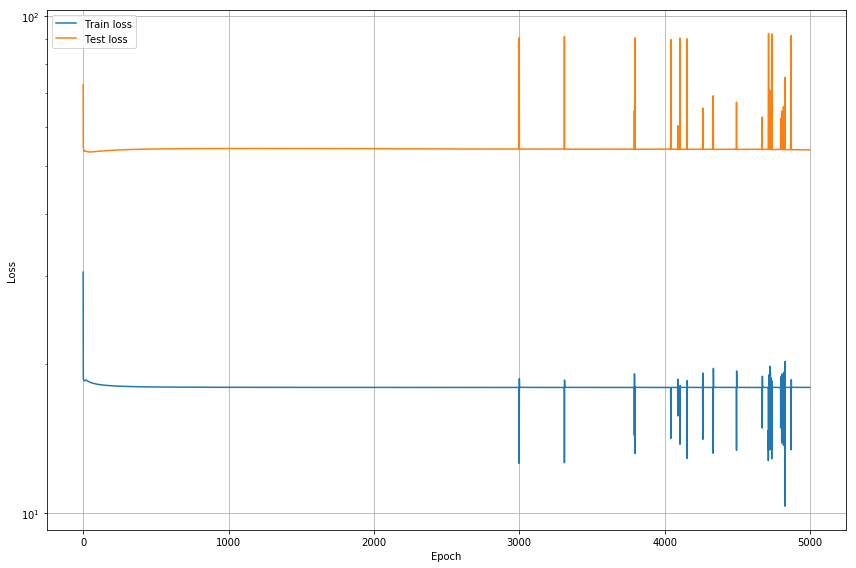

No handles with labels found to put in legend.


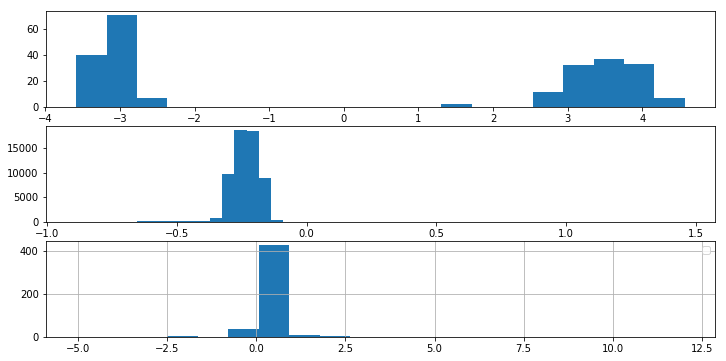

No handles with labels found to put in legend.


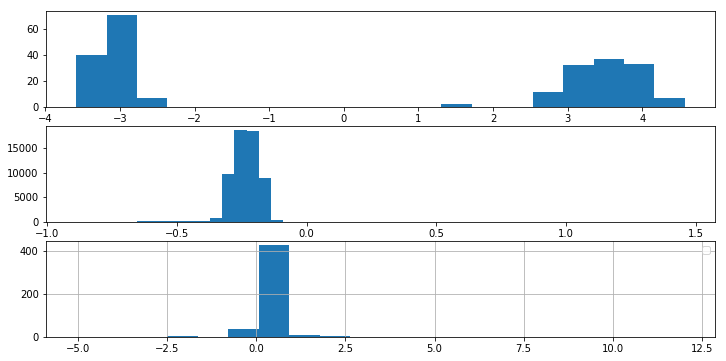

number of hidden neurons in first layer is: 240 number of hidden neurons in second layer is: 360
Epoch 1 - lr: 0.05000 - Train loss: 14.90233 - Test loss: 186.42954
Epoch 2 - lr: 0.05000 - Train loss: 9.49486 - Test loss: 118.93195
Epoch 3 - lr: 0.05000 - Train loss: 10.00148 - Test loss: 113.29387
Epoch 4 - lr: 0.05000 - Train loss: 9.41976 - Test loss: 103.59700
Epoch 5 - lr: 0.05000 - Train loss: 9.24265 - Test loss: 82.70257
Epoch 6 - lr: 0.05000 - Train loss: 7.83941 - Test loss: 44.23331
Epoch 7 - lr: 0.05000 - Train loss: 5.61134 - Test loss: 20.88391
Epoch 8 - lr: 0.05000 - Train loss: 4.84708 - Test loss: 13.20968
Epoch 9 - lr: 0.05000 - Train loss: 4.44498 - Test loss: 9.67512
Epoch 10 - lr: 0.05000 - Train loss: 4.05157 - Test loss: 7.55863
Epoch 11 - lr: 0.05000 - Train loss: 3.69707 - Test loss: 6.18314
Epoch 12 - lr: 0.05000 - Train loss: 3.39082 - Test loss: 5.22834
Epoch 13 - lr: 0.05000 - Train loss: 3.13463 - Test loss: 4.53802
Epoch 14 - lr: 0.05000 - Train loss: 2.9

Epoch 127 - lr: 0.05000 - Train loss: 1.71197 - Test loss: 2.21265
Epoch 128 - lr: 0.05000 - Train loss: 1.53787 - Test loss: 2.21376
Epoch 129 - lr: 0.05000 - Train loss: 1.70126 - Test loss: 2.21003
Epoch 130 - lr: 0.05000 - Train loss: 1.69294 - Test loss: 2.19676
Epoch 131 - lr: 0.05000 - Train loss: 1.58939 - Test loss: 2.20096
Epoch 132 - lr: 0.05000 - Train loss: 1.55242 - Test loss: 2.00729
Epoch 133 - lr: 0.05000 - Train loss: 1.44753 - Test loss: 2.39788
Epoch 134 - lr: 0.05000 - Train loss: 1.93094 - Test loss: 2.00384
Epoch 135 - lr: 0.05000 - Train loss: 1.73909 - Test loss: 2.19647
Epoch 136 - lr: 0.05000 - Train loss: 1.60056 - Test loss: 1.53663
Epoch 137 - lr: 0.05000 - Train loss: 1.38662 - Test loss: 1.75123
Epoch 138 - lr: 0.05000 - Train loss: 1.50944 - Test loss: 2.47235
Epoch 139 - lr: 0.05000 - Train loss: 1.50913 - Test loss: 2.04206
Epoch 140 - lr: 0.05000 - Train loss: 1.46841 - Test loss: 2.36048
Epoch 141 - lr: 0.05000 - Train loss: 1.64512 - Test loss: 1.4

Epoch 252 - lr: 0.05000 - Train loss: 1.12522 - Test loss: 1.55787
Epoch 253 - lr: 0.05000 - Train loss: 1.15014 - Test loss: 1.20227
Epoch 254 - lr: 0.05000 - Train loss: 0.98142 - Test loss: 1.59278
Epoch 255 - lr: 0.05000 - Train loss: 1.35798 - Test loss: 0.91049
Epoch 256 - lr: 0.05000 - Train loss: 0.90175 - Test loss: 0.91388
Epoch 257 - lr: 0.05000 - Train loss: 0.84789 - Test loss: 1.64345
Epoch 258 - lr: 0.05000 - Train loss: 1.32622 - Test loss: 1.47591
Epoch 259 - lr: 0.05000 - Train loss: 1.30458 - Test loss: 0.96927
Epoch 260 - lr: 0.05000 - Train loss: 0.93853 - Test loss: 1.40088
Epoch 261 - lr: 0.05000 - Train loss: 1.03150 - Test loss: 0.88318
Epoch 262 - lr: 0.05000 - Train loss: 1.27772 - Test loss: 1.09732
Epoch 263 - lr: 0.05000 - Train loss: 1.00778 - Test loss: 0.99095
Epoch 264 - lr: 0.05000 - Train loss: 1.25965 - Test loss: 1.13454
Epoch 265 - lr: 0.05000 - Train loss: 0.97712 - Test loss: 0.97430
Epoch 266 - lr: 0.05000 - Train loss: 0.88371 - Test loss: 1.6

Epoch 375 - lr: 0.05000 - Train loss: 1.29759 - Test loss: 1.38130
Epoch 376 - lr: 0.05000 - Train loss: 1.29715 - Test loss: 1.30980
Epoch 377 - lr: 0.05000 - Train loss: 1.27092 - Test loss: 1.19354
Epoch 378 - lr: 0.05000 - Train loss: 1.02346 - Test loss: 1.31432
Epoch 379 - lr: 0.05000 - Train loss: 1.13929 - Test loss: 1.29936
Epoch 380 - lr: 0.05000 - Train loss: 1.08014 - Test loss: 1.37537
Epoch 381 - lr: 0.05000 - Train loss: 1.14269 - Test loss: 0.97342
Epoch 382 - lr: 0.05000 - Train loss: 1.05519 - Test loss: 0.92166
Epoch 383 - lr: 0.05000 - Train loss: 1.08693 - Test loss: 0.97147
Epoch 384 - lr: 0.05000 - Train loss: 0.89211 - Test loss: 1.02399
Epoch 385 - lr: 0.05000 - Train loss: 1.07991 - Test loss: 1.50157
Epoch 386 - lr: 0.05000 - Train loss: 1.29908 - Test loss: 0.87144
Epoch 387 - lr: 0.05000 - Train loss: 0.93130 - Test loss: 0.92387
Epoch 388 - lr: 0.05000 - Train loss: 0.97180 - Test loss: 0.95804
Epoch 389 - lr: 0.05000 - Train loss: 1.33135 - Test loss: 1.2

Epoch 500 - lr: 0.05000 - Train loss: 1.26496 - Test loss: 1.22139
Epoch 501 - lr: 0.05000 - Train loss: 1.25949 - Test loss: 1.21941
Epoch 502 - lr: 0.05000 - Train loss: 1.26014 - Test loss: 1.25402
Epoch 503 - lr: 0.05000 - Train loss: 1.24631 - Test loss: 1.23419
Epoch 504 - lr: 0.05000 - Train loss: 1.25132 - Test loss: 1.22827
Epoch 505 - lr: 0.05000 - Train loss: 1.24671 - Test loss: 1.22146
Epoch 506 - lr: 0.05000 - Train loss: 1.25830 - Test loss: 1.22481
Epoch 507 - lr: 0.05000 - Train loss: 1.24686 - Test loss: 1.22029
Epoch 508 - lr: 0.05000 - Train loss: 1.25816 - Test loss: 1.22046
Epoch 509 - lr: 0.05000 - Train loss: 1.24615 - Test loss: 1.22614
Epoch 510 - lr: 0.05000 - Train loss: 1.24425 - Test loss: 1.21926
Epoch 511 - lr: 0.05000 - Train loss: 1.26062 - Test loss: 1.20357
Epoch 512 - lr: 0.05000 - Train loss: 1.25599 - Test loss: 1.21070
Epoch 513 - lr: 0.05000 - Train loss: 1.25664 - Test loss: 1.21600
Epoch 514 - lr: 0.05000 - Train loss: 1.24498 - Test loss: 1.2

Epoch 625 - lr: 0.05000 - Train loss: 1.24800 - Test loss: 1.18273
Epoch 626 - lr: 0.05000 - Train loss: 1.22998 - Test loss: 1.18872
Epoch 627 - lr: 0.05000 - Train loss: 1.24900 - Test loss: 1.18816
Epoch 628 - lr: 0.05000 - Train loss: 1.22891 - Test loss: 1.19899
Epoch 629 - lr: 0.05000 - Train loss: 1.23799 - Test loss: 1.20239
Epoch 630 - lr: 0.05000 - Train loss: 1.22986 - Test loss: 1.18619
Epoch 631 - lr: 0.05000 - Train loss: 1.24380 - Test loss: 1.18115
Epoch 632 - lr: 0.05000 - Train loss: 1.24550 - Test loss: 1.16903
Epoch 633 - lr: 0.05000 - Train loss: 1.24163 - Test loss: 1.17681
Epoch 634 - lr: 0.05000 - Train loss: 1.24422 - Test loss: 1.16882
Epoch 635 - lr: 0.05000 - Train loss: 1.24351 - Test loss: 1.20154
Epoch 636 - lr: 0.05000 - Train loss: 1.24078 - Test loss: 1.17805
Epoch 637 - lr: 0.05000 - Train loss: 1.24829 - Test loss: 1.18659
Epoch 638 - lr: 0.05000 - Train loss: 1.24124 - Test loss: 1.19069
Epoch 639 - lr: 0.05000 - Train loss: 1.22846 - Test loss: 1.2

Epoch 750 - lr: 0.05000 - Train loss: 1.22623 - Test loss: 1.19231
Epoch 751 - lr: 0.05000 - Train loss: 1.22804 - Test loss: 1.17462
Epoch 752 - lr: 0.05000 - Train loss: 1.22387 - Test loss: 1.17975
Epoch 753 - lr: 0.05000 - Train loss: 1.22531 - Test loss: 1.19653
Epoch 754 - lr: 0.05000 - Train loss: 1.22996 - Test loss: 1.18393
Epoch 755 - lr: 0.05000 - Train loss: 1.23966 - Test loss: 1.21085
Epoch 756 - lr: 0.05000 - Train loss: 1.22204 - Test loss: 1.18778
Epoch 757 - lr: 0.05000 - Train loss: 1.22633 - Test loss: 1.17329
Epoch 758 - lr: 0.05000 - Train loss: 1.24098 - Test loss: 1.16972
Epoch 759 - lr: 0.05000 - Train loss: 1.22181 - Test loss: 1.17517
Epoch 760 - lr: 0.05000 - Train loss: 1.24134 - Test loss: 1.17399
Epoch 761 - lr: 0.05000 - Train loss: 1.23020 - Test loss: 1.18270
Epoch 762 - lr: 0.05000 - Train loss: 1.23766 - Test loss: 1.17107
Epoch 763 - lr: 0.05000 - Train loss: 1.22321 - Test loss: 1.18385
Epoch 764 - lr: 0.05000 - Train loss: 1.23596 - Test loss: 1.1

Epoch 875 - lr: 0.05000 - Train loss: 1.22376 - Test loss: 1.17229
Epoch 876 - lr: 0.05000 - Train loss: 1.21930 - Test loss: 1.16837
Epoch 877 - lr: 0.05000 - Train loss: 1.23807 - Test loss: 1.16755
Epoch 878 - lr: 0.05000 - Train loss: 1.21878 - Test loss: 1.16700
Epoch 879 - lr: 0.05000 - Train loss: 1.22004 - Test loss: 1.17723
Epoch 880 - lr: 0.05000 - Train loss: 1.23676 - Test loss: 1.20353
Epoch 881 - lr: 0.05000 - Train loss: 1.22059 - Test loss: 1.18500
Epoch 882 - lr: 0.05000 - Train loss: 1.22410 - Test loss: 1.17015
Epoch 883 - lr: 0.05000 - Train loss: 1.21881 - Test loss: 1.16792
Epoch 884 - lr: 0.05000 - Train loss: 1.23810 - Test loss: 1.16780
Epoch 885 - lr: 0.05000 - Train loss: 1.21583 - Test loss: 1.16113
Epoch 886 - lr: 0.05000 - Train loss: 1.23202 - Test loss: 1.17381
Epoch 887 - lr: 0.05000 - Train loss: 1.23421 - Test loss: 1.15604
Epoch 888 - lr: 0.05000 - Train loss: 1.23287 - Test loss: 1.20660
Epoch 889 - lr: 0.05000 - Train loss: 1.21793 - Test loss: 1.1

Epoch 1000 - lr: 0.05000 - Train loss: 1.21514 - Test loss: 1.16280
Epoch 1001 - lr: 0.05000 - Train loss: 1.23421 - Test loss: 1.15675
Epoch 1002 - lr: 0.05000 - Train loss: 1.22348 - Test loss: 1.17426
Epoch 1003 - lr: 0.05000 - Train loss: 1.23192 - Test loss: 1.16132
Epoch 1004 - lr: 0.05000 - Train loss: 1.22043 - Test loss: 1.18117
Epoch 1005 - lr: 0.05000 - Train loss: 1.22024 - Test loss: 1.16233
Epoch 1006 - lr: 0.05000 - Train loss: 1.23332 - Test loss: 1.14736
Epoch 1007 - lr: 0.05000 - Train loss: 1.22406 - Test loss: 1.16988
Epoch 1008 - lr: 0.05000 - Train loss: 1.23464 - Test loss: 1.19454
Epoch 1009 - lr: 0.05000 - Train loss: 1.22631 - Test loss: 1.16699
Epoch 1010 - lr: 0.05000 - Train loss: 1.21475 - Test loss: 1.17085
Epoch 1011 - lr: 0.05000 - Train loss: 1.23238 - Test loss: 1.16236
Epoch 1012 - lr: 0.05000 - Train loss: 1.23550 - Test loss: 1.16471
Epoch 1013 - lr: 0.05000 - Train loss: 1.21342 - Test loss: 1.16128
Epoch 1014 - lr: 0.05000 - Train loss: 1.23435 -

Epoch 1124 - lr: 0.05000 - Train loss: 1.23359 - Test loss: 1.16490
Epoch 1125 - lr: 0.05000 - Train loss: 1.23403 - Test loss: 1.16377
Epoch 1126 - lr: 0.05000 - Train loss: 1.21301 - Test loss: 1.15868
Epoch 1127 - lr: 0.05000 - Train loss: 1.22831 - Test loss: 1.16108
Epoch 1128 - lr: 0.05000 - Train loss: 1.21581 - Test loss: 1.17103
Epoch 1129 - lr: 0.05000 - Train loss: 1.23416 - Test loss: 1.15816
Epoch 1130 - lr: 0.05000 - Train loss: 1.23176 - Test loss: 1.14841
Epoch 1131 - lr: 0.05000 - Train loss: 1.21447 - Test loss: 1.17199
Epoch 1132 - lr: 0.05000 - Train loss: 1.23154 - Test loss: 1.16706
Epoch 1133 - lr: 0.05000 - Train loss: 1.23405 - Test loss: 1.16412
Epoch 1134 - lr: 0.05000 - Train loss: 1.21179 - Test loss: 1.16233
Epoch 1135 - lr: 0.05000 - Train loss: 1.21564 - Test loss: 1.16836
Epoch 1136 - lr: 0.05000 - Train loss: 1.21350 - Test loss: 1.16977
Epoch 1137 - lr: 0.05000 - Train loss: 1.22880 - Test loss: 1.16622
Epoch 1138 - lr: 0.05000 - Train loss: 1.21610 -

Epoch 1245 - lr: 0.05000 - Train loss: 1.23264 - Test loss: 1.16497
Epoch 1246 - lr: 0.05000 - Train loss: 1.23280 - Test loss: 1.16396
Epoch 1247 - lr: 0.05000 - Train loss: 1.21229 - Test loss: 1.16156
Epoch 1248 - lr: 0.05000 - Train loss: 1.21836 - Test loss: 1.17815
Epoch 1249 - lr: 0.05000 - Train loss: 1.21663 - Test loss: 1.16972
Epoch 1250 - lr: 0.05000 - Train loss: 1.21547 - Test loss: 1.16729
Epoch 1251 - lr: 0.05000 - Train loss: 1.21347 - Test loss: 1.16024
Epoch 1252 - lr: 0.05000 - Train loss: 1.22938 - Test loss: 1.14687
Epoch 1253 - lr: 0.05000 - Train loss: 1.22879 - Test loss: 1.15172
Epoch 1254 - lr: 0.05000 - Train loss: 1.22985 - Test loss: 1.14726
Epoch 1255 - lr: 0.05000 - Train loss: 1.21287 - Test loss: 1.17002
Epoch 1256 - lr: 0.05000 - Train loss: 1.23316 - Test loss: 1.15819
Epoch 1257 - lr: 0.05000 - Train loss: 1.23010 - Test loss: 1.14635
Epoch 1258 - lr: 0.05000 - Train loss: 1.22073 - Test loss: 1.16881
Epoch 1259 - lr: 0.05000 - Train loss: 1.23284 -

Epoch 1367 - lr: 0.05000 - Train loss: 1.22539 - Test loss: 1.16303
Epoch 1368 - lr: 0.05000 - Train loss: 1.21198 - Test loss: 1.16495
Epoch 1369 - lr: 0.05000 - Train loss: 1.21167 - Test loss: 1.15921
Epoch 1370 - lr: 0.05000 - Train loss: 1.22917 - Test loss: 1.14889
Epoch 1371 - lr: 0.05000 - Train loss: 1.21236 - Test loss: 1.17833
Epoch 1372 - lr: 0.05000 - Train loss: 1.21543 - Test loss: 1.16273
Epoch 1373 - lr: 0.05000 - Train loss: 1.22784 - Test loss: 1.20187
Epoch 1374 - lr: 0.05000 - Train loss: 1.21308 - Test loss: 1.18029
Epoch 1375 - lr: 0.05000 - Train loss: 1.21680 - Test loss: 1.16734
Epoch 1376 - lr: 0.05000 - Train loss: 1.21250 - Test loss: 1.16251
Epoch 1377 - lr: 0.05000 - Train loss: 1.22943 - Test loss: 1.15485
Epoch 1378 - lr: 0.05000 - Train loss: 1.22494 - Test loss: 1.20287
Epoch 1379 - lr: 0.05000 - Train loss: 1.21302 - Test loss: 1.17996
Epoch 1380 - lr: 0.05000 - Train loss: 1.21581 - Test loss: 1.16137
Epoch 1381 - lr: 0.05000 - Train loss: 1.22476 -

Epoch 1492 - lr: 0.05000 - Train loss: 1.23153 - Test loss: 1.16112
Epoch 1493 - lr: 0.05000 - Train loss: 1.22464 - Test loss: 1.16303
Epoch 1494 - lr: 0.05000 - Train loss: 1.21275 - Test loss: 1.17976
Epoch 1495 - lr: 0.05000 - Train loss: 1.21371 - Test loss: 1.17172
Epoch 1496 - lr: 0.05000 - Train loss: 1.21296 - Test loss: 1.16835
Epoch 1497 - lr: 0.05000 - Train loss: 1.21189 - Test loss: 1.16950
Epoch 1498 - lr: 0.05000 - Train loss: 1.21249 - Test loss: 1.16990
Epoch 1499 - lr: 0.05000 - Train loss: 1.21167 - Test loss: 1.16217
Epoch 1500 - lr: 0.05000 - Train loss: 1.22580 - Test loss: 1.16428
Epoch 1501 - lr: 0.05000 - Train loss: 1.22925 - Test loss: 1.16644
Epoch 1502 - lr: 0.05000 - Train loss: 1.22489 - Test loss: 1.16344
Epoch 1503 - lr: 0.05000 - Train loss: 1.21186 - Test loss: 1.17242
Epoch 1504 - lr: 0.05000 - Train loss: 1.22912 - Test loss: 1.20991
Epoch 1505 - lr: 0.05000 - Train loss: 1.21160 - Test loss: 1.17696
Epoch 1506 - lr: 0.05000 - Train loss: 1.20917 -

Epoch 1616 - lr: 0.05000 - Train loss: 1.22643 - Test loss: 1.15078
Epoch 1617 - lr: 0.05000 - Train loss: 1.22111 - Test loss: 1.16708
Epoch 1618 - lr: 0.05000 - Train loss: 1.21029 - Test loss: 1.16665
Epoch 1619 - lr: 0.05000 - Train loss: 1.21301 - Test loss: 1.18296
Epoch 1620 - lr: 0.05000 - Train loss: 1.21402 - Test loss: 1.17268
Epoch 1621 - lr: 0.05000 - Train loss: 1.21025 - Test loss: 1.16597
Epoch 1622 - lr: 0.05000 - Train loss: 1.22504 - Test loss: 1.21645
Epoch 1623 - lr: 0.05000 - Train loss: 1.20882 - Test loss: 1.16491
Epoch 1624 - lr: 0.05000 - Train loss: 1.21030 - Test loss: 1.17204
Epoch 1625 - lr: 0.05000 - Train loss: 1.20832 - Test loss: 1.17294
Epoch 1626 - lr: 0.05000 - Train loss: 1.20914 - Test loss: 1.17930
Epoch 1627 - lr: 0.05000 - Train loss: 1.22718 - Test loss: 1.18104
Epoch 1628 - lr: 0.05000 - Train loss: 1.22452 - Test loss: 1.20335
Epoch 1629 - lr: 0.05000 - Train loss: 1.21504 - Test loss: 1.17612
Epoch 1630 - lr: 0.05000 - Train loss: 1.22633 -

Epoch 1740 - lr: 0.05000 - Train loss: 1.23245 - Test loss: 1.22704
Epoch 1741 - lr: 0.05000 - Train loss: 1.22527 - Test loss: 1.22330
Epoch 1742 - lr: 0.05000 - Train loss: 1.17361 - Test loss: 1.08690
Epoch 1743 - lr: 0.05000 - Train loss: 0.93599 - Test loss: 0.87537
Epoch 1744 - lr: 0.05000 - Train loss: 0.94703 - Test loss: 1.25368
Epoch 1745 - lr: 0.05000 - Train loss: 1.00176 - Test loss: 1.26461
Epoch 1746 - lr: 0.05000 - Train loss: 1.26428 - Test loss: 1.10096
Epoch 1747 - lr: 0.05000 - Train loss: 1.05022 - Test loss: 1.18562
Epoch 1748 - lr: 0.05000 - Train loss: 1.28883 - Test loss: 1.19041
Epoch 1749 - lr: 0.05000 - Train loss: 0.97453 - Test loss: 0.88340
Epoch 1750 - lr: 0.05000 - Train loss: 0.95486 - Test loss: 0.95935
Epoch 1751 - lr: 0.05000 - Train loss: 0.91264 - Test loss: 1.12473
Epoch 1752 - lr: 0.05000 - Train loss: 0.85233 - Test loss: 0.70202
Epoch 1753 - lr: 0.05000 - Train loss: 0.85808 - Test loss: 1.28467
Epoch 1754 - lr: 0.05000 - Train loss: 1.24214 -

Epoch 1863 - lr: 0.05000 - Train loss: 1.20661 - Test loss: 1.17300
Epoch 1864 - lr: 0.05000 - Train loss: 1.20826 - Test loss: 1.17633
Epoch 1865 - lr: 0.05000 - Train loss: 1.20869 - Test loss: 1.17167
Epoch 1866 - lr: 0.05000 - Train loss: 1.21435 - Test loss: 1.18397
Epoch 1867 - lr: 0.05000 - Train loss: 1.22155 - Test loss: 1.17591
Epoch 1868 - lr: 0.05000 - Train loss: 1.20875 - Test loss: 1.17631
Epoch 1869 - lr: 0.05000 - Train loss: 1.20743 - Test loss: 1.17093
Epoch 1870 - lr: 0.05000 - Train loss: 1.22240 - Test loss: 1.22249
Epoch 1871 - lr: 0.05000 - Train loss: 1.20594 - Test loss: 1.16523
Epoch 1872 - lr: 0.05000 - Train loss: 1.21982 - Test loss: 1.17352
Epoch 1873 - lr: 0.05000 - Train loss: 1.20796 - Test loss: 1.17313
Epoch 1874 - lr: 0.05000 - Train loss: 1.20891 - Test loss: 1.18158
Epoch 1875 - lr: 0.05000 - Train loss: 1.22797 - Test loss: 1.16854
Epoch 1876 - lr: 0.05000 - Train loss: 1.22051 - Test loss: 1.17286
Epoch 1877 - lr: 0.05000 - Train loss: 1.20624 -

Epoch 1985 - lr: 0.05000 - Train loss: 1.22412 - Test loss: 1.17218
Epoch 1986 - lr: 0.05000 - Train loss: 1.20471 - Test loss: 1.17116
Epoch 1987 - lr: 0.05000 - Train loss: 1.21572 - Test loss: 1.18120
Epoch 1988 - lr: 0.05000 - Train loss: 1.22401 - Test loss: 1.22455
Epoch 1989 - lr: 0.05000 - Train loss: 1.20552 - Test loss: 1.17588
Epoch 1990 - lr: 0.05000 - Train loss: 1.20679 - Test loss: 1.17597
Epoch 1991 - lr: 0.05000 - Train loss: 1.20770 - Test loss: 1.18488
Epoch 1992 - lr: 0.05000 - Train loss: 1.22655 - Test loss: 1.17546
Epoch 1993 - lr: 0.05000 - Train loss: 1.22408 - Test loss: 1.17261
Epoch 1994 - lr: 0.05000 - Train loss: 1.20447 - Test loss: 1.16962
Epoch 1995 - lr: 0.05000 - Train loss: 1.21941 - Test loss: 1.20964
Epoch 1996 - lr: 0.05000 - Train loss: 1.21507 - Test loss: 1.17814
Epoch 1997 - lr: 0.05000 - Train loss: 1.21306 - Test loss: 1.18452
Epoch 1998 - lr: 0.05000 - Train loss: 1.22567 - Test loss: 1.21370
Epoch 1999 - lr: 0.05000 - Train loss: 1.21428 -

Epoch 2107 - lr: 0.05000 - Train loss: 1.20620 - Test loss: 1.18083
Epoch 2108 - lr: 0.05000 - Train loss: 1.20641 - Test loss: 1.18695
Epoch 2109 - lr: 0.05000 - Train loss: 1.22482 - Test loss: 1.18393
Epoch 2110 - lr: 0.05000 - Train loss: 1.22318 - Test loss: 1.17789
Epoch 2111 - lr: 0.05000 - Train loss: 1.20478 - Test loss: 1.18268
Epoch 2112 - lr: 0.05000 - Train loss: 1.20554 - Test loss: 1.17717
Epoch 2113 - lr: 0.05000 - Train loss: 1.21676 - Test loss: 1.18265
Epoch 2114 - lr: 0.05000 - Train loss: 1.20280 - Test loss: 1.17617
Epoch 2115 - lr: 0.05000 - Train loss: 1.21816 - Test loss: 1.17952
Epoch 2116 - lr: 0.05000 - Train loss: 1.20350 - Test loss: 1.17536
Epoch 2117 - lr: 0.05000 - Train loss: 1.22166 - Test loss: 1.16223
Epoch 2118 - lr: 0.05000 - Train loss: 1.20784 - Test loss: 1.18872
Epoch 2119 - lr: 0.05000 - Train loss: 1.20398 - Test loss: 1.17731
Epoch 2120 - lr: 0.05000 - Train loss: 1.21833 - Test loss: 1.18071
Epoch 2121 - lr: 0.05000 - Train loss: 1.20465 -

Epoch 2230 - lr: 0.05000 - Train loss: 1.20345 - Test loss: 1.18709
Epoch 2231 - lr: 0.05000 - Train loss: 1.20424 - Test loss: 1.18013
Epoch 2232 - lr: 0.05000 - Train loss: 1.21737 - Test loss: 1.17629
Epoch 2233 - lr: 0.05000 - Train loss: 1.21631 - Test loss: 1.18251
Epoch 2234 - lr: 0.05000 - Train loss: 1.22156 - Test loss: 1.18170
Epoch 2235 - lr: 0.05000 - Train loss: 1.20152 - Test loss: 1.18336
Epoch 2236 - lr: 0.05000 - Train loss: 1.20475 - Test loss: 1.19023
Epoch 2237 - lr: 0.05000 - Train loss: 1.22284 - Test loss: 1.22109
Epoch 2238 - lr: 0.05000 - Train loss: 1.21244 - Test loss: 1.18593
Epoch 2239 - lr: 0.05000 - Train loss: 1.21653 - Test loss: 1.18394
Epoch 2240 - lr: 0.05000 - Train loss: 1.20304 - Test loss: 1.17935
Epoch 2241 - lr: 0.05000 - Train loss: 1.21960 - Test loss: 1.16490
Epoch 2242 - lr: 0.05000 - Train loss: 1.21446 - Test loss: 1.17780
Epoch 2243 - lr: 0.05000 - Train loss: 1.20370 - Test loss: 1.19228
Epoch 2244 - lr: 0.05000 - Train loss: 1.22161 -

Epoch 2354 - lr: 0.05000 - Train loss: 1.21983 - Test loss: 1.17108
Epoch 2355 - lr: 0.05000 - Train loss: 1.20039 - Test loss: 1.19057
Epoch 2356 - lr: 0.05000 - Train loss: 1.22135 - Test loss: 1.21198
Epoch 2357 - lr: 0.05000 - Train loss: 1.21458 - Test loss: 1.21480
Epoch 2358 - lr: 0.05000 - Train loss: 1.21130 - Test loss: 1.18601
Epoch 2359 - lr: 0.05000 - Train loss: 1.20153 - Test loss: 1.19147
Epoch 2360 - lr: 0.05000 - Train loss: 1.20324 - Test loss: 1.18926
Epoch 2361 - lr: 0.05000 - Train loss: 1.20362 - Test loss: 1.19525
Epoch 2362 - lr: 0.05000 - Train loss: 1.22263 - Test loss: 1.18560
Epoch 2363 - lr: 0.05000 - Train loss: 1.20725 - Test loss: 1.19871
Epoch 2364 - lr: 0.05000 - Train loss: 1.20278 - Test loss: 1.20690
Epoch 2365 - lr: 0.05000 - Train loss: 1.20969 - Test loss: 1.19863
Epoch 2366 - lr: 0.05000 - Train loss: 1.22319 - Test loss: 1.19158
Epoch 2367 - lr: 0.05000 - Train loss: 1.20293 - Test loss: 1.18957
Epoch 2368 - lr: 0.05000 - Train loss: 1.20343 -

Epoch 2475 - lr: 0.05000 - Train loss: 1.20379 - Test loss: 1.19967
Epoch 2476 - lr: 0.05000 - Train loss: 1.20266 - Test loss: 1.19710
Epoch 2477 - lr: 0.05000 - Train loss: 1.20076 - Test loss: 1.18964
Epoch 2478 - lr: 0.05000 - Train loss: 1.21869 - Test loss: 1.17622
Epoch 2479 - lr: 0.05000 - Train loss: 1.19736 - Test loss: 1.19011
Epoch 2480 - lr: 0.05000 - Train loss: 1.19933 - Test loss: 1.18943
Epoch 2481 - lr: 0.05000 - Train loss: 1.21561 - Test loss: 1.20614
Epoch 2482 - lr: 0.05000 - Train loss: 1.21194 - Test loss: 1.18929
Epoch 2483 - lr: 0.05000 - Train loss: 1.21597 - Test loss: 1.18558
Epoch 2484 - lr: 0.05000 - Train loss: 1.19871 - Test loss: 1.18831
Epoch 2485 - lr: 0.05000 - Train loss: 1.21603 - Test loss: 1.18361
Epoch 2486 - lr: 0.05000 - Train loss: 1.21840 - Test loss: 1.19287
Epoch 2487 - lr: 0.05000 - Train loss: 1.22037 - Test loss: 1.18807
Epoch 2488 - lr: 0.05000 - Train loss: 1.20855 - Test loss: 1.19851
Epoch 2489 - lr: 0.05000 - Train loss: 1.22091 -

Epoch 2598 - lr: 0.05000 - Train loss: 1.19517 - Test loss: 1.18951
Epoch 2599 - lr: 0.05000 - Train loss: 1.20879 - Test loss: 1.19996
Epoch 2600 - lr: 0.05000 - Train loss: 1.21450 - Test loss: 1.20926
Epoch 2601 - lr: 0.05000 - Train loss: 1.21262 - Test loss: 1.24413
Epoch 2602 - lr: 0.05000 - Train loss: 1.19656 - Test loss: 1.18849
Epoch 2603 - lr: 0.05000 - Train loss: 1.21174 - Test loss: 1.19561
Epoch 2604 - lr: 0.05000 - Train loss: 1.19780 - Test loss: 1.19582
Epoch 2605 - lr: 0.05000 - Train loss: 1.21408 - Test loss: 1.24439
Epoch 2606 - lr: 0.05000 - Train loss: 1.19773 - Test loss: 1.19774
Epoch 2607 - lr: 0.05000 - Train loss: 1.19742 - Test loss: 1.19649
Epoch 2608 - lr: 0.05000 - Train loss: 1.20501 - Test loss: 1.20854
Epoch 2609 - lr: 0.05000 - Train loss: 1.19713 - Test loss: 1.20093
Epoch 2610 - lr: 0.05000 - Train loss: 1.19882 - Test loss: 1.19682
Epoch 2611 - lr: 0.05000 - Train loss: 1.21387 - Test loss: 1.25513
Epoch 2612 - lr: 0.05000 - Train loss: 1.19858 -

Epoch 2722 - lr: 0.05000 - Train loss: 1.21137 - Test loss: 1.22327
Epoch 2723 - lr: 0.05000 - Train loss: 1.20983 - Test loss: 1.21831
Epoch 2724 - lr: 0.05000 - Train loss: 1.20777 - Test loss: 1.22254
Epoch 2725 - lr: 0.05000 - Train loss: 1.20853 - Test loss: 1.24999
Epoch 2726 - lr: 0.05000 - Train loss: 1.19580 - Test loss: 1.19948
Epoch 2727 - lr: 0.05000 - Train loss: 1.19674 - Test loss: 1.20047
Epoch 2728 - lr: 0.05000 - Train loss: 1.19899 - Test loss: 1.21335
Epoch 2729 - lr: 0.05000 - Train loss: 1.19614 - Test loss: 1.20723
Epoch 2730 - lr: 0.05000 - Train loss: 1.19909 - Test loss: 1.20706
Epoch 2731 - lr: 0.05000 - Train loss: 1.19800 - Test loss: 1.19950
Epoch 2732 - lr: 0.05000 - Train loss: 1.21297 - Test loss: 1.18680
Epoch 2733 - lr: 0.05000 - Train loss: 1.21294 - Test loss: 1.19380
Epoch 2734 - lr: 0.05000 - Train loss: 1.19585 - Test loss: 1.20275
Epoch 2735 - lr: 0.05000 - Train loss: 1.19790 - Test loss: 1.20114
Epoch 2736 - lr: 0.05000 - Train loss: 1.20451 -

Epoch 2844 - lr: 0.05000 - Train loss: 1.20111 - Test loss: 1.21739
Epoch 2845 - lr: 0.05000 - Train loss: 1.19501 - Test loss: 1.20518
Epoch 2846 - lr: 0.05000 - Train loss: 1.21177 - Test loss: 1.20804
Epoch 2847 - lr: 0.05000 - Train loss: 1.20929 - Test loss: 1.21969
Epoch 2848 - lr: 0.05000 - Train loss: 1.21207 - Test loss: 1.18618
Epoch 2849 - lr: 0.05000 - Train loss: 1.19225 - Test loss: 1.19910
Epoch 2850 - lr: 0.05000 - Train loss: 1.20671 - Test loss: 1.20888
Epoch 2851 - lr: 0.05000 - Train loss: 1.20544 - Test loss: 1.21142
Epoch 2852 - lr: 0.05000 - Train loss: 1.21391 - Test loss: 1.26395
Epoch 2853 - lr: 0.05000 - Train loss: 1.19507 - Test loss: 1.20492
Epoch 2854 - lr: 0.05000 - Train loss: 1.21286 - Test loss: 1.19533
Epoch 2855 - lr: 0.05000 - Train loss: 1.20856 - Test loss: 1.20203
Epoch 2856 - lr: 0.05000 - Train loss: 1.19689 - Test loss: 1.21441
Epoch 2857 - lr: 0.05000 - Train loss: 1.21732 - Test loss: 1.20480
Epoch 2858 - lr: 0.05000 - Train loss: 1.20131 -

Epoch 2969 - lr: 0.05000 - Train loss: 1.20989 - Test loss: 1.24620
Epoch 2970 - lr: 0.05000 - Train loss: 1.19707 - Test loss: 1.21975
Epoch 2971 - lr: 0.05000 - Train loss: 1.19675 - Test loss: 1.21799
Epoch 2972 - lr: 0.05000 - Train loss: 1.19660 - Test loss: 1.21219
Epoch 2973 - lr: 0.05000 - Train loss: 1.20118 - Test loss: 1.22159
Epoch 2974 - lr: 0.05000 - Train loss: 1.21049 - Test loss: 1.20912
Epoch 2975 - lr: 0.05000 - Train loss: 1.19996 - Test loss: 1.22200
Epoch 2976 - lr: 0.05000 - Train loss: 1.19453 - Test loss: 1.21990
Epoch 2977 - lr: 0.05000 - Train loss: 1.21526 - Test loss: 1.25858
Epoch 2978 - lr: 0.05000 - Train loss: 1.19887 - Test loss: 1.22070
Epoch 2979 - lr: 0.05000 - Train loss: 1.19332 - Test loss: 1.21678
Epoch 2980 - lr: 0.05000 - Train loss: 1.19672 - Test loss: 1.21734
Epoch 2981 - lr: 0.05000 - Train loss: 1.19614 - Test loss: 1.21190
Epoch 2982 - lr: 0.05000 - Train loss: 1.20254 - Test loss: 1.21921
Epoch 2983 - lr: 0.05000 - Train loss: 1.21531 -

Epoch 3093 - lr: 0.05000 - Train loss: 1.20817 - Test loss: 1.06137
Epoch 3094 - lr: 0.05000 - Train loss: 1.02038 - Test loss: 0.72206
Epoch 3095 - lr: 0.05000 - Train loss: 1.07796 - Test loss: 0.81450
Epoch 3096 - lr: 0.05000 - Train loss: 0.76120 - Test loss: 0.73527
Epoch 3097 - lr: 0.05000 - Train loss: 1.26036 - Test loss: 1.40855
Epoch 3098 - lr: 0.05000 - Train loss: 1.26326 - Test loss: 1.35379
Epoch 3099 - lr: 0.05000 - Train loss: 1.21673 - Test loss: 1.29697
Epoch 3100 - lr: 0.05000 - Train loss: 1.20271 - Test loss: 1.27903
Epoch 3101 - lr: 0.05000 - Train loss: 1.20093 - Test loss: 1.27842
Epoch 3102 - lr: 0.05000 - Train loss: 1.20025 - Test loss: 1.29417
Epoch 3103 - lr: 0.05000 - Train loss: 1.19617 - Test loss: 1.31318
Epoch 3104 - lr: 0.05000 - Train loss: 1.16116 - Test loss: 1.26010
Epoch 3105 - lr: 0.05000 - Train loss: 1.14349 - Test loss: 1.16971
Epoch 3106 - lr: 0.05000 - Train loss: 0.95830 - Test loss: 1.07283
Epoch 3107 - lr: 0.05000 - Train loss: 0.91150 -

Epoch 3214 - lr: 0.05000 - Train loss: 0.63281 - Test loss: 0.67260
Epoch 3215 - lr: 0.05000 - Train loss: 0.63320 - Test loss: 0.67237
Epoch 3216 - lr: 0.05000 - Train loss: 0.63277 - Test loss: 0.67253
Epoch 3217 - lr: 0.05000 - Train loss: 0.63314 - Test loss: 0.67231
Epoch 3218 - lr: 0.05000 - Train loss: 0.63272 - Test loss: 0.67246
Epoch 3219 - lr: 0.05000 - Train loss: 0.63309 - Test loss: 0.67225
Epoch 3220 - lr: 0.05000 - Train loss: 0.63268 - Test loss: 0.67240
Epoch 3221 - lr: 0.05000 - Train loss: 0.63303 - Test loss: 0.67220
Epoch 3222 - lr: 0.05000 - Train loss: 0.63264 - Test loss: 0.67234
Epoch 3223 - lr: 0.05000 - Train loss: 0.63298 - Test loss: 0.67215
Epoch 3224 - lr: 0.05000 - Train loss: 0.63260 - Test loss: 0.67229
Epoch 3225 - lr: 0.05000 - Train loss: 0.63292 - Test loss: 0.67210
Epoch 3226 - lr: 0.05000 - Train loss: 0.63256 - Test loss: 0.67224
Epoch 3227 - lr: 0.05000 - Train loss: 0.63287 - Test loss: 0.67205
Epoch 3228 - lr: 0.05000 - Train loss: 0.63252 -

Epoch 3339 - lr: 0.05000 - Train loss: 0.63075 - Test loss: 0.67069
Epoch 3340 - lr: 0.05000 - Train loss: 0.63072 - Test loss: 0.67069
Epoch 3341 - lr: 0.05000 - Train loss: 0.63072 - Test loss: 0.67067
Epoch 3342 - lr: 0.05000 - Train loss: 0.63068 - Test loss: 0.67067
Epoch 3343 - lr: 0.05000 - Train loss: 0.63068 - Test loss: 0.67065
Epoch 3344 - lr: 0.05000 - Train loss: 0.63064 - Test loss: 0.67065
Epoch 3345 - lr: 0.05000 - Train loss: 0.63065 - Test loss: 0.67063
Epoch 3346 - lr: 0.05000 - Train loss: 0.63061 - Test loss: 0.67063
Epoch 3347 - lr: 0.05000 - Train loss: 0.63061 - Test loss: 0.67062
Epoch 3348 - lr: 0.05000 - Train loss: 0.63057 - Test loss: 0.67061
Epoch 3349 - lr: 0.05000 - Train loss: 0.63057 - Test loss: 0.67060
Epoch 3350 - lr: 0.05000 - Train loss: 0.63053 - Test loss: 0.67060
Epoch 3351 - lr: 0.05000 - Train loss: 0.63053 - Test loss: 0.67058
Epoch 3352 - lr: 0.05000 - Train loss: 0.63049 - Test loss: 0.67058
Epoch 3353 - lr: 0.05000 - Train loss: 0.63049 -

Epoch 3464 - lr: 0.05000 - Train loss: 0.62271 - Test loss: 0.68162
Epoch 3465 - lr: 0.05000 - Train loss: 0.62256 - Test loss: 0.68194
Epoch 3466 - lr: 0.05000 - Train loss: 0.62240 - Test loss: 0.68226
Epoch 3467 - lr: 0.05000 - Train loss: 0.62226 - Test loss: 0.68258
Epoch 3468 - lr: 0.05000 - Train loss: 0.62210 - Test loss: 0.68291
Epoch 3469 - lr: 0.05000 - Train loss: 0.62195 - Test loss: 0.68323
Epoch 3470 - lr: 0.05000 - Train loss: 0.62180 - Test loss: 0.68355
Epoch 3471 - lr: 0.05000 - Train loss: 0.62165 - Test loss: 0.68387
Epoch 3472 - lr: 0.05000 - Train loss: 0.62150 - Test loss: 0.68420
Epoch 3473 - lr: 0.05000 - Train loss: 0.62135 - Test loss: 0.68452
Epoch 3474 - lr: 0.05000 - Train loss: 0.62120 - Test loss: 0.68484
Epoch 3475 - lr: 0.05000 - Train loss: 0.62105 - Test loss: 0.68516
Epoch 3476 - lr: 0.05000 - Train loss: 0.62090 - Test loss: 0.68548
Epoch 3477 - lr: 0.05000 - Train loss: 0.62076 - Test loss: 0.68580
Epoch 3478 - lr: 0.05000 - Train loss: 0.62061 -

Epoch 3590 - lr: 0.05000 - Train loss: 0.61078 - Test loss: 0.70691
Epoch 3591 - lr: 0.05000 - Train loss: 0.61073 - Test loss: 0.70699
Epoch 3592 - lr: 0.05000 - Train loss: 0.61069 - Test loss: 0.70707
Epoch 3593 - lr: 0.05000 - Train loss: 0.61064 - Test loss: 0.70715
Epoch 3594 - lr: 0.05000 - Train loss: 0.61059 - Test loss: 0.70722
Epoch 3595 - lr: 0.05000 - Train loss: 0.61054 - Test loss: 0.70730
Epoch 3596 - lr: 0.05000 - Train loss: 0.61050 - Test loss: 0.70738
Epoch 3597 - lr: 0.05000 - Train loss: 0.61045 - Test loss: 0.70745
Epoch 3598 - lr: 0.05000 - Train loss: 0.61041 - Test loss: 0.70752
Epoch 3599 - lr: 0.05000 - Train loss: 0.61036 - Test loss: 0.70760
Epoch 3600 - lr: 0.05000 - Train loss: 0.61031 - Test loss: 0.70767
Epoch 3601 - lr: 0.05000 - Train loss: 0.61027 - Test loss: 0.70774
Epoch 3602 - lr: 0.05000 - Train loss: 0.61023 - Test loss: 0.70781
Epoch 3603 - lr: 0.05000 - Train loss: 0.61018 - Test loss: 0.70788
Epoch 3604 - lr: 0.05000 - Train loss: 0.61014 -

Epoch 3714 - lr: 0.05000 - Train loss: 0.60683 - Test loss: 0.71190
Epoch 3715 - lr: 0.05000 - Train loss: 0.60681 - Test loss: 0.71187
Epoch 3716 - lr: 0.05000 - Train loss: 0.60678 - Test loss: 0.71184
Epoch 3717 - lr: 0.05000 - Train loss: 0.60676 - Test loss: 0.71181
Epoch 3718 - lr: 0.05000 - Train loss: 0.60674 - Test loss: 0.71178
Epoch 3719 - lr: 0.05000 - Train loss: 0.60672 - Test loss: 0.71174
Epoch 3720 - lr: 0.05000 - Train loss: 0.60670 - Test loss: 0.71169
Epoch 3721 - lr: 0.05000 - Train loss: 0.60668 - Test loss: 0.71164
Epoch 3722 - lr: 0.05000 - Train loss: 0.60666 - Test loss: 0.71159
Epoch 3723 - lr: 0.05000 - Train loss: 0.60663 - Test loss: 0.71153
Epoch 3724 - lr: 0.05000 - Train loss: 0.60661 - Test loss: 0.71147
Epoch 3725 - lr: 0.05000 - Train loss: 0.60659 - Test loss: 0.71141
Epoch 3726 - lr: 0.05000 - Train loss: 0.60657 - Test loss: 0.71133
Epoch 3727 - lr: 0.05000 - Train loss: 0.60654 - Test loss: 0.71126
Epoch 3728 - lr: 0.05000 - Train loss: 0.60652 -

Epoch 3840 - lr: 0.05000 - Train loss: 0.60222 - Test loss: 0.72048
Epoch 3841 - lr: 0.05000 - Train loss: 0.60219 - Test loss: 0.72054
Epoch 3842 - lr: 0.05000 - Train loss: 0.60217 - Test loss: 0.72060
Epoch 3843 - lr: 0.05000 - Train loss: 0.60215 - Test loss: 0.72066
Epoch 3844 - lr: 0.05000 - Train loss: 0.60212 - Test loss: 0.72072
Epoch 3845 - lr: 0.05000 - Train loss: 0.60210 - Test loss: 0.72078
Epoch 3846 - lr: 0.05000 - Train loss: 0.60208 - Test loss: 0.72083
Epoch 3847 - lr: 0.05000 - Train loss: 0.60206 - Test loss: 0.72089
Epoch 3848 - lr: 0.05000 - Train loss: 0.60203 - Test loss: 0.72095
Epoch 3849 - lr: 0.05000 - Train loss: 0.60201 - Test loss: 0.72100
Epoch 3850 - lr: 0.05000 - Train loss: 0.60199 - Test loss: 0.72106
Epoch 3851 - lr: 0.05000 - Train loss: 0.60197 - Test loss: 0.72111
Epoch 3852 - lr: 0.05000 - Train loss: 0.60194 - Test loss: 0.72117
Epoch 3853 - lr: 0.05000 - Train loss: 0.60192 - Test loss: 0.72123
Epoch 3854 - lr: 0.05000 - Train loss: 0.60190 -

Epoch 3961 - lr: 0.05000 - Train loss: 0.60016 - Test loss: 0.72610
Epoch 3962 - lr: 0.05000 - Train loss: 0.60015 - Test loss: 0.72614
Epoch 3963 - lr: 0.05000 - Train loss: 0.60014 - Test loss: 0.72618
Epoch 3964 - lr: 0.05000 - Train loss: 0.60012 - Test loss: 0.72622
Epoch 3965 - lr: 0.05000 - Train loss: 0.60011 - Test loss: 0.72626
Epoch 3966 - lr: 0.05000 - Train loss: 0.60010 - Test loss: 0.72629
Epoch 3967 - lr: 0.05000 - Train loss: 0.60009 - Test loss: 0.72633
Epoch 3968 - lr: 0.05000 - Train loss: 0.60008 - Test loss: 0.72637
Epoch 3969 - lr: 0.05000 - Train loss: 0.60006 - Test loss: 0.72641
Epoch 3970 - lr: 0.05000 - Train loss: 0.60005 - Test loss: 0.72645
Epoch 3971 - lr: 0.05000 - Train loss: 0.60004 - Test loss: 0.72649
Epoch 3972 - lr: 0.05000 - Train loss: 0.60003 - Test loss: 0.72653
Epoch 3973 - lr: 0.05000 - Train loss: 0.60002 - Test loss: 0.72657
Epoch 3974 - lr: 0.05000 - Train loss: 0.60000 - Test loss: 0.72660
Epoch 3975 - lr: 0.05000 - Train loss: 0.59999 -

Epoch 4087 - lr: 0.05000 - Train loss: 0.59889 - Test loss: 0.73061
Epoch 4088 - lr: 0.05000 - Train loss: 0.59888 - Test loss: 0.73064
Epoch 4089 - lr: 0.05000 - Train loss: 0.59888 - Test loss: 0.73068
Epoch 4090 - lr: 0.05000 - Train loss: 0.59887 - Test loss: 0.73071
Epoch 4091 - lr: 0.05000 - Train loss: 0.59886 - Test loss: 0.73074
Epoch 4092 - lr: 0.05000 - Train loss: 0.59885 - Test loss: 0.73077
Epoch 4093 - lr: 0.05000 - Train loss: 0.59884 - Test loss: 0.73081
Epoch 4094 - lr: 0.05000 - Train loss: 0.59883 - Test loss: 0.73084
Epoch 4095 - lr: 0.05000 - Train loss: 0.59883 - Test loss: 0.73087
Epoch 4096 - lr: 0.05000 - Train loss: 0.59882 - Test loss: 0.73091
Epoch 4097 - lr: 0.05000 - Train loss: 0.59881 - Test loss: 0.73094
Epoch 4098 - lr: 0.05000 - Train loss: 0.59880 - Test loss: 0.73097
Epoch 4099 - lr: 0.05000 - Train loss: 0.59879 - Test loss: 0.73100
Epoch 4100 - lr: 0.05000 - Train loss: 0.59879 - Test loss: 0.73104
Epoch 4101 - lr: 0.05000 - Train loss: 0.59878 -

Epoch 4209 - lr: 0.05000 - Train loss: 0.59802 - Test loss: 0.73440
Epoch 4210 - lr: 0.05000 - Train loss: 0.59801 - Test loss: 0.73443
Epoch 4211 - lr: 0.05000 - Train loss: 0.59800 - Test loss: 0.73446
Epoch 4212 - lr: 0.05000 - Train loss: 0.59800 - Test loss: 0.73449
Epoch 4213 - lr: 0.05000 - Train loss: 0.59799 - Test loss: 0.73452
Epoch 4214 - lr: 0.05000 - Train loss: 0.59798 - Test loss: 0.73455
Epoch 4215 - lr: 0.05000 - Train loss: 0.59798 - Test loss: 0.73458
Epoch 4216 - lr: 0.05000 - Train loss: 0.59797 - Test loss: 0.73461
Epoch 4217 - lr: 0.05000 - Train loss: 0.59797 - Test loss: 0.73464
Epoch 4218 - lr: 0.05000 - Train loss: 0.59796 - Test loss: 0.73466
Epoch 4219 - lr: 0.05000 - Train loss: 0.59795 - Test loss: 0.73469
Epoch 4220 - lr: 0.05000 - Train loss: 0.59795 - Test loss: 0.73472
Epoch 4221 - lr: 0.05000 - Train loss: 0.59794 - Test loss: 0.73475
Epoch 4222 - lr: 0.05000 - Train loss: 0.59793 - Test loss: 0.73478
Epoch 4223 - lr: 0.05000 - Train loss: 0.59793 -

Epoch 4334 - lr: 0.05000 - Train loss: 0.59730 - Test loss: 0.73787
Epoch 4335 - lr: 0.05000 - Train loss: 0.59730 - Test loss: 0.73790
Epoch 4336 - lr: 0.05000 - Train loss: 0.59729 - Test loss: 0.73792
Epoch 4337 - lr: 0.05000 - Train loss: 0.59729 - Test loss: 0.73795
Epoch 4338 - lr: 0.05000 - Train loss: 0.59728 - Test loss: 0.73798
Epoch 4339 - lr: 0.05000 - Train loss: 0.59728 - Test loss: 0.73800
Epoch 4340 - lr: 0.05000 - Train loss: 0.59727 - Test loss: 0.73803
Epoch 4341 - lr: 0.05000 - Train loss: 0.59727 - Test loss: 0.73806
Epoch 4342 - lr: 0.05000 - Train loss: 0.59726 - Test loss: 0.73808
Epoch 4343 - lr: 0.05000 - Train loss: 0.59726 - Test loss: 0.73811
Epoch 4344 - lr: 0.05000 - Train loss: 0.59725 - Test loss: 0.73813
Epoch 4345 - lr: 0.05000 - Train loss: 0.59725 - Test loss: 0.73816
Epoch 4346 - lr: 0.05000 - Train loss: 0.59724 - Test loss: 0.73819
Epoch 4347 - lr: 0.05000 - Train loss: 0.59724 - Test loss: 0.73821
Epoch 4348 - lr: 0.05000 - Train loss: 0.59723 -

Epoch 4459 - lr: 0.05000 - Train loss: 0.59671 - Test loss: 0.74100
Epoch 4460 - lr: 0.05000 - Train loss: 0.59671 - Test loss: 0.74103
Epoch 4461 - lr: 0.05000 - Train loss: 0.59670 - Test loss: 0.74105
Epoch 4462 - lr: 0.05000 - Train loss: 0.59670 - Test loss: 0.74107
Epoch 4463 - lr: 0.05000 - Train loss: 0.59669 - Test loss: 0.74110
Epoch 4464 - lr: 0.05000 - Train loss: 0.59669 - Test loss: 0.74112
Epoch 4465 - lr: 0.05000 - Train loss: 0.59668 - Test loss: 0.74114
Epoch 4466 - lr: 0.05000 - Train loss: 0.59668 - Test loss: 0.74117
Epoch 4467 - lr: 0.05000 - Train loss: 0.59668 - Test loss: 0.74119
Epoch 4468 - lr: 0.05000 - Train loss: 0.59667 - Test loss: 0.74121
Epoch 4469 - lr: 0.05000 - Train loss: 0.59667 - Test loss: 0.74124
Epoch 4470 - lr: 0.05000 - Train loss: 0.59666 - Test loss: 0.74126
Epoch 4471 - lr: 0.05000 - Train loss: 0.59666 - Test loss: 0.74129
Epoch 4472 - lr: 0.05000 - Train loss: 0.59665 - Test loss: 0.74131
Epoch 4473 - lr: 0.05000 - Train loss: 0.59665 -

Epoch 4584 - lr: 0.05000 - Train loss: 0.59620 - Test loss: 0.74383
Epoch 4585 - lr: 0.05000 - Train loss: 0.59619 - Test loss: 0.74385
Epoch 4586 - lr: 0.05000 - Train loss: 0.59619 - Test loss: 0.74387
Epoch 4587 - lr: 0.05000 - Train loss: 0.59619 - Test loss: 0.74390
Epoch 4588 - lr: 0.05000 - Train loss: 0.59618 - Test loss: 0.74392
Epoch 4589 - lr: 0.05000 - Train loss: 0.59618 - Test loss: 0.74394
Epoch 4590 - lr: 0.05000 - Train loss: 0.59617 - Test loss: 0.74396
Epoch 4591 - lr: 0.05000 - Train loss: 0.59617 - Test loss: 0.74398
Epoch 4592 - lr: 0.05000 - Train loss: 0.59617 - Test loss: 0.74400
Epoch 4593 - lr: 0.05000 - Train loss: 0.59616 - Test loss: 0.74402
Epoch 4594 - lr: 0.05000 - Train loss: 0.59616 - Test loss: 0.74404
Epoch 4595 - lr: 0.05000 - Train loss: 0.59615 - Test loss: 0.74407
Epoch 4596 - lr: 0.05000 - Train loss: 0.59615 - Test loss: 0.74409
Epoch 4597 - lr: 0.05000 - Train loss: 0.59615 - Test loss: 0.74411
Epoch 4598 - lr: 0.05000 - Train loss: 0.59614 -

Epoch 4709 - lr: 0.05000 - Train loss: 0.59574 - Test loss: 0.74637
Epoch 4710 - lr: 0.05000 - Train loss: 0.59574 - Test loss: 0.74638
Epoch 4711 - lr: 0.05000 - Train loss: 0.59574 - Test loss: 0.74640
Epoch 4712 - lr: 0.05000 - Train loss: 0.59573 - Test loss: 0.74642
Epoch 4713 - lr: 0.05000 - Train loss: 0.59573 - Test loss: 0.74644
Epoch 4714 - lr: 0.05000 - Train loss: 0.59573 - Test loss: 0.74646
Epoch 4715 - lr: 0.05000 - Train loss: 0.59572 - Test loss: 0.74648
Epoch 4716 - lr: 0.05000 - Train loss: 0.59572 - Test loss: 0.74650
Epoch 4717 - lr: 0.05000 - Train loss: 0.59572 - Test loss: 0.74652
Epoch 4718 - lr: 0.05000 - Train loss: 0.59571 - Test loss: 0.74654
Epoch 4719 - lr: 0.05000 - Train loss: 0.59571 - Test loss: 0.74655
Epoch 4720 - lr: 0.05000 - Train loss: 0.59571 - Test loss: 0.74657
Epoch 4721 - lr: 0.05000 - Train loss: 0.59570 - Test loss: 0.74659
Epoch 4722 - lr: 0.05000 - Train loss: 0.59570 - Test loss: 0.74661
Epoch 4723 - lr: 0.05000 - Train loss: 0.59570 -

Epoch 4834 - lr: 0.05000 - Train loss: 0.59534 - Test loss: 0.74858
Epoch 4835 - lr: 0.05000 - Train loss: 0.59534 - Test loss: 0.74859
Epoch 4836 - lr: 0.05000 - Train loss: 0.59534 - Test loss: 0.74861
Epoch 4837 - lr: 0.05000 - Train loss: 0.59534 - Test loss: 0.74862
Epoch 4838 - lr: 0.05000 - Train loss: 0.59533 - Test loss: 0.74864
Epoch 4839 - lr: 0.05000 - Train loss: 0.59533 - Test loss: 0.74866
Epoch 4840 - lr: 0.05000 - Train loss: 0.59533 - Test loss: 0.74867
Epoch 4841 - lr: 0.05000 - Train loss: 0.59532 - Test loss: 0.74869
Epoch 4842 - lr: 0.05000 - Train loss: 0.59532 - Test loss: 0.74870
Epoch 4843 - lr: 0.05000 - Train loss: 0.59532 - Test loss: 0.74872
Epoch 4844 - lr: 0.05000 - Train loss: 0.59531 - Test loss: 0.74874
Epoch 4845 - lr: 0.05000 - Train loss: 0.59531 - Test loss: 0.74875
Epoch 4846 - lr: 0.05000 - Train loss: 0.59531 - Test loss: 0.74877
Epoch 4847 - lr: 0.05000 - Train loss: 0.59531 - Test loss: 0.74878
Epoch 4848 - lr: 0.05000 - Train loss: 0.59530 -

Epoch 4958 - lr: 0.05000 - Train loss: 0.59499 - Test loss: 0.75039
Epoch 4959 - lr: 0.05000 - Train loss: 0.59499 - Test loss: 0.75040
Epoch 4960 - lr: 0.05000 - Train loss: 0.59499 - Test loss: 0.75042
Epoch 4961 - lr: 0.05000 - Train loss: 0.59499 - Test loss: 0.75043
Epoch 4962 - lr: 0.05000 - Train loss: 0.59498 - Test loss: 0.75044
Epoch 4963 - lr: 0.05000 - Train loss: 0.59498 - Test loss: 0.75046
Epoch 4964 - lr: 0.05000 - Train loss: 0.59498 - Test loss: 0.75047
Epoch 4965 - lr: 0.05000 - Train loss: 0.59497 - Test loss: 0.75048
Epoch 4966 - lr: 0.05000 - Train loss: 0.59497 - Test loss: 0.75049
Epoch 4967 - lr: 0.05000 - Train loss: 0.59497 - Test loss: 0.75051
Epoch 4968 - lr: 0.05000 - Train loss: 0.59497 - Test loss: 0.75052
Epoch 4969 - lr: 0.05000 - Train loss: 0.59496 - Test loss: 0.75053
Epoch 4970 - lr: 0.05000 - Train loss: 0.59496 - Test loss: 0.75055
Epoch 4971 - lr: 0.05000 - Train loss: 0.59496 - Test loss: 0.75056
Epoch 4972 - lr: 0.05000 - Train loss: 0.59496 -

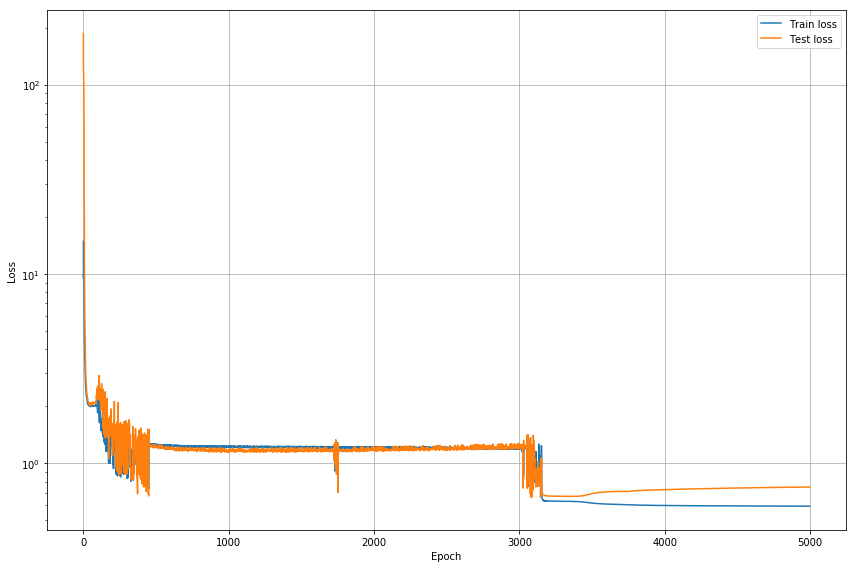

No handles with labels found to put in legend.


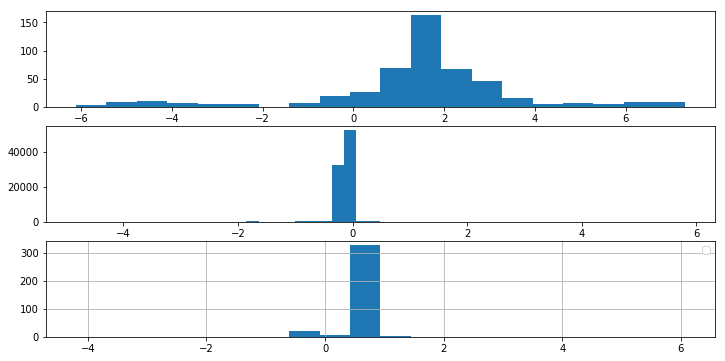

No handles with labels found to put in legend.


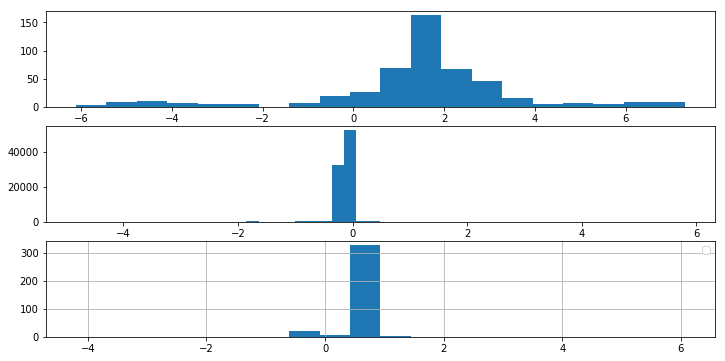

number of hidden neurons in first layer is: 360 number of hidden neurons in second layer is: 240
Epoch 1 - lr: 0.05000 - Train loss: 12.20424 - Test loss: 225.97802
Epoch 2 - lr: 0.05000 - Train loss: 8.48852 - Test loss: 119.59114
Epoch 3 - lr: 0.05000 - Train loss: 7.79191 - Test loss: 119.00872
Epoch 4 - lr: 0.05000 - Train loss: 7.78443 - Test loss: 118.08917
Epoch 5 - lr: 0.05000 - Train loss: 7.75626 - Test loss: 116.61036
Epoch 6 - lr: 0.05000 - Train loss: 7.70385 - Test loss: 114.10529
Epoch 7 - lr: 0.05000 - Train loss: 7.61113 - Test loss: 109.63859
Epoch 8 - lr: 0.05000 - Train loss: 7.44609 - Test loss: 101.50585
Epoch 9 - lr: 0.05000 - Train loss: 7.15459 - Test loss: 87.38249
Epoch 10 - lr: 0.05000 - Train loss: 6.61698 - Test loss: 65.34228
Epoch 11 - lr: 0.05000 - Train loss: 5.76252 - Test loss: 38.24813
Epoch 12 - lr: 0.05000 - Train loss: 4.86746 - Test loss: 19.49518
Epoch 13 - lr: 0.05000 - Train loss: 4.17564 - Test loss: 10.72570
Epoch 14 - lr: 0.05000 - Train l

Epoch 126 - lr: 0.05000 - Train loss: 2.33547 - Test loss: 1.99095
Epoch 127 - lr: 0.05000 - Train loss: 2.33508 - Test loss: 1.99108
Epoch 128 - lr: 0.05000 - Train loss: 2.33402 - Test loss: 1.99120
Epoch 129 - lr: 0.05000 - Train loss: 2.31234 - Test loss: 1.98674
Epoch 130 - lr: 0.05000 - Train loss: 2.25797 - Test loss: 1.98383
Epoch 131 - lr: 0.05000 - Train loss: 2.25178 - Test loss: 1.98092
Epoch 132 - lr: 0.05000 - Train loss: 2.24908 - Test loss: 1.97893
Epoch 133 - lr: 0.05000 - Train loss: 2.24672 - Test loss: 1.97753
Epoch 134 - lr: 0.05000 - Train loss: 2.22459 - Test loss: 1.97299
Epoch 135 - lr: 0.05000 - Train loss: 2.17402 - Test loss: 1.96958
Epoch 136 - lr: 0.05000 - Train loss: 2.16862 - Test loss: 1.96592
Epoch 137 - lr: 0.05000 - Train loss: 2.16657 - Test loss: 1.96321
Epoch 138 - lr: 0.05000 - Train loss: 2.16577 - Test loss: 1.96204
Epoch 139 - lr: 0.05000 - Train loss: 2.16567 - Test loss: 1.96285
Epoch 140 - lr: 0.05000 - Train loss: 2.16613 - Test loss: 1.9

Epoch 252 - lr: 0.05000 - Train loss: 2.01377 - Test loss: 1.84536
Epoch 253 - lr: 0.05000 - Train loss: 1.99393 - Test loss: 1.83959
Epoch 254 - lr: 0.05000 - Train loss: 2.01613 - Test loss: 1.77496
Epoch 255 - lr: 0.05000 - Train loss: 2.01669 - Test loss: 1.77461
Epoch 256 - lr: 0.05000 - Train loss: 2.00331 - Test loss: 1.98349
Epoch 257 - lr: 0.05000 - Train loss: 2.05434 - Test loss: 1.89669
Epoch 258 - lr: 0.05000 - Train loss: 2.05154 - Test loss: 1.90388
Epoch 259 - lr: 0.05000 - Train loss: 1.98636 - Test loss: 1.80775
Epoch 260 - lr: 0.05000 - Train loss: 2.01087 - Test loss: 1.80731
Epoch 261 - lr: 0.05000 - Train loss: 1.99810 - Test loss: 1.86715
Epoch 262 - lr: 0.05000 - Train loss: 1.99265 - Test loss: 2.03148
Epoch 263 - lr: 0.05000 - Train loss: 2.11190 - Test loss: 1.96292
Epoch 264 - lr: 0.05000 - Train loss: 1.86382 - Test loss: 1.97637
Epoch 265 - lr: 0.05000 - Train loss: 1.79423 - Test loss: 2.05796
Epoch 266 - lr: 0.05000 - Train loss: 2.00211 - Test loss: 2.0

Epoch 375 - lr: 0.05000 - Train loss: 1.97793 - Test loss: 2.01374
Epoch 376 - lr: 0.05000 - Train loss: 1.97779 - Test loss: 2.01376
Epoch 377 - lr: 0.05000 - Train loss: 1.97755 - Test loss: 2.01357
Epoch 378 - lr: 0.05000 - Train loss: 1.97621 - Test loss: 2.00665
Epoch 379 - lr: 0.05000 - Train loss: 1.69292 - Test loss: 2.01307
Epoch 380 - lr: 0.05000 - Train loss: 1.97800 - Test loss: 2.01424
Epoch 381 - lr: 0.05000 - Train loss: 1.97791 - Test loss: 2.01440
Epoch 382 - lr: 0.05000 - Train loss: 1.97788 - Test loss: 2.01451
Epoch 383 - lr: 0.05000 - Train loss: 1.97784 - Test loss: 2.01462
Epoch 384 - lr: 0.05000 - Train loss: 1.97781 - Test loss: 2.01472
Epoch 385 - lr: 0.05000 - Train loss: 1.97778 - Test loss: 2.01482
Epoch 386 - lr: 0.05000 - Train loss: 1.97776 - Test loss: 2.01492
Epoch 387 - lr: 0.05000 - Train loss: 1.97773 - Test loss: 2.01501
Epoch 388 - lr: 0.05000 - Train loss: 1.97771 - Test loss: 2.01511
Epoch 389 - lr: 0.05000 - Train loss: 1.97769 - Test loss: 2.0

Epoch 501 - lr: 0.05000 - Train loss: 1.91672 - Test loss: 2.04900
Epoch 502 - lr: 0.05000 - Train loss: 1.91519 - Test loss: 2.03621
Epoch 503 - lr: 0.05000 - Train loss: 1.94340 - Test loss: 1.55602
Epoch 504 - lr: 0.05000 - Train loss: 1.52054 - Test loss: 2.15049
Epoch 505 - lr: 0.05000 - Train loss: 1.98850 - Test loss: 2.05090
Epoch 506 - lr: 0.05000 - Train loss: 1.97927 - Test loss: 2.03749
Epoch 507 - lr: 0.05000 - Train loss: 1.97761 - Test loss: 2.03149
Epoch 508 - lr: 0.05000 - Train loss: 1.97693 - Test loss: 2.02794
Epoch 509 - lr: 0.05000 - Train loss: 1.97658 - Test loss: 2.02561
Epoch 510 - lr: 0.05000 - Train loss: 1.97639 - Test loss: 2.02400
Epoch 511 - lr: 0.05000 - Train loss: 1.97627 - Test loss: 2.02283
Epoch 512 - lr: 0.05000 - Train loss: 1.97620 - Test loss: 2.02197
Epoch 513 - lr: 0.05000 - Train loss: 1.97615 - Test loss: 2.02132
Epoch 514 - lr: 0.05000 - Train loss: 1.97611 - Test loss: 2.02082
Epoch 515 - lr: 0.05000 - Train loss: 1.97609 - Test loss: 2.0

Epoch 627 - lr: 0.05000 - Train loss: 1.97591 - Test loss: 2.02268
Epoch 628 - lr: 0.05000 - Train loss: 1.97591 - Test loss: 2.02272
Epoch 629 - lr: 0.05000 - Train loss: 1.97591 - Test loss: 2.02275
Epoch 630 - lr: 0.05000 - Train loss: 1.97591 - Test loss: 2.02279
Epoch 631 - lr: 0.05000 - Train loss: 1.97591 - Test loss: 2.02283
Epoch 632 - lr: 0.05000 - Train loss: 1.97591 - Test loss: 2.02287
Epoch 633 - lr: 0.05000 - Train loss: 1.97591 - Test loss: 2.02290
Epoch 634 - lr: 0.05000 - Train loss: 1.97591 - Test loss: 2.02294
Epoch 635 - lr: 0.05000 - Train loss: 1.97591 - Test loss: 2.02298
Epoch 636 - lr: 0.05000 - Train loss: 1.97592 - Test loss: 2.02301
Epoch 637 - lr: 0.05000 - Train loss: 1.97592 - Test loss: 2.02305
Epoch 638 - lr: 0.05000 - Train loss: 1.97592 - Test loss: 2.02309
Epoch 639 - lr: 0.05000 - Train loss: 1.97592 - Test loss: 2.02312
Epoch 640 - lr: 0.05000 - Train loss: 1.97592 - Test loss: 2.02316
Epoch 641 - lr: 0.05000 - Train loss: 1.97592 - Test loss: 2.0

Epoch 753 - lr: 0.05000 - Train loss: 1.97607 - Test loss: 2.02699
Epoch 754 - lr: 0.05000 - Train loss: 1.97607 - Test loss: 2.02703
Epoch 755 - lr: 0.05000 - Train loss: 1.97608 - Test loss: 2.02706
Epoch 756 - lr: 0.05000 - Train loss: 1.97608 - Test loss: 2.02709
Epoch 757 - lr: 0.05000 - Train loss: 1.97608 - Test loss: 2.02712
Epoch 758 - lr: 0.05000 - Train loss: 1.97608 - Test loss: 2.02716
Epoch 759 - lr: 0.05000 - Train loss: 1.97608 - Test loss: 2.02719
Epoch 760 - lr: 0.05000 - Train loss: 1.97608 - Test loss: 2.02722
Epoch 761 - lr: 0.05000 - Train loss: 1.97609 - Test loss: 2.02725
Epoch 762 - lr: 0.05000 - Train loss: 1.97609 - Test loss: 2.02729
Epoch 763 - lr: 0.05000 - Train loss: 1.97609 - Test loss: 2.02732
Epoch 764 - lr: 0.05000 - Train loss: 1.97609 - Test loss: 2.02735
Epoch 765 - lr: 0.05000 - Train loss: 1.97609 - Test loss: 2.02738
Epoch 766 - lr: 0.05000 - Train loss: 1.97609 - Test loss: 2.02742
Epoch 767 - lr: 0.05000 - Train loss: 1.97610 - Test loss: 2.0

Epoch 876 - lr: 0.05000 - Train loss: 1.97641 - Test loss: 2.03144
Epoch 877 - lr: 0.05000 - Train loss: 1.97642 - Test loss: 2.03149
Epoch 878 - lr: 0.05000 - Train loss: 1.97642 - Test loss: 2.03153
Epoch 879 - lr: 0.05000 - Train loss: 1.97643 - Test loss: 2.03158
Epoch 880 - lr: 0.05000 - Train loss: 1.97644 - Test loss: 2.03162
Epoch 881 - lr: 0.05000 - Train loss: 1.97645 - Test loss: 2.03167
Epoch 882 - lr: 0.05000 - Train loss: 1.97645 - Test loss: 2.03171
Epoch 883 - lr: 0.05000 - Train loss: 1.97646 - Test loss: 2.03175
Epoch 884 - lr: 0.05000 - Train loss: 1.97647 - Test loss: 2.03180
Epoch 885 - lr: 0.05000 - Train loss: 1.97647 - Test loss: 2.03183
Epoch 886 - lr: 0.05000 - Train loss: 1.97648 - Test loss: 2.03187
Epoch 887 - lr: 0.05000 - Train loss: 1.97649 - Test loss: 2.03190
Epoch 888 - lr: 0.05000 - Train loss: 1.97650 - Test loss: 2.03193
Epoch 889 - lr: 0.05000 - Train loss: 1.97650 - Test loss: 2.03195
Epoch 890 - lr: 0.05000 - Train loss: 1.97651 - Test loss: 2.0

Epoch 1003 - lr: 0.05000 - Train loss: 1.97503 - Test loss: 2.02946
Epoch 1004 - lr: 0.05000 - Train loss: 1.97503 - Test loss: 2.02947
Epoch 1005 - lr: 0.05000 - Train loss: 1.97503 - Test loss: 2.02949
Epoch 1006 - lr: 0.05000 - Train loss: 1.97503 - Test loss: 2.02950
Epoch 1007 - lr: 0.05000 - Train loss: 1.97503 - Test loss: 2.02952
Epoch 1008 - lr: 0.05000 - Train loss: 1.97503 - Test loss: 2.02953
Epoch 1009 - lr: 0.05000 - Train loss: 1.97503 - Test loss: 2.02955
Epoch 1010 - lr: 0.05000 - Train loss: 1.97502 - Test loss: 2.02956
Epoch 1011 - lr: 0.05000 - Train loss: 1.97502 - Test loss: 2.02958
Epoch 1012 - lr: 0.05000 - Train loss: 1.97502 - Test loss: 2.02960
Epoch 1013 - lr: 0.05000 - Train loss: 1.97502 - Test loss: 2.02961
Epoch 1014 - lr: 0.05000 - Train loss: 1.97502 - Test loss: 2.02963
Epoch 1015 - lr: 0.05000 - Train loss: 1.97502 - Test loss: 2.02964
Epoch 1016 - lr: 0.05000 - Train loss: 1.97502 - Test loss: 2.02966
Epoch 1017 - lr: 0.05000 - Train loss: 1.97502 -

Epoch 1126 - lr: 0.05000 - Train loss: 1.97490 - Test loss: 2.03145
Epoch 1127 - lr: 0.05000 - Train loss: 1.97490 - Test loss: 2.03146
Epoch 1128 - lr: 0.05000 - Train loss: 1.97490 - Test loss: 2.03148
Epoch 1129 - lr: 0.05000 - Train loss: 1.97489 - Test loss: 2.03149
Epoch 1130 - lr: 0.05000 - Train loss: 1.97489 - Test loss: 2.03151
Epoch 1131 - lr: 0.05000 - Train loss: 1.97489 - Test loss: 2.03152
Epoch 1132 - lr: 0.05000 - Train loss: 1.97489 - Test loss: 2.03154
Epoch 1133 - lr: 0.05000 - Train loss: 1.97489 - Test loss: 2.03155
Epoch 1134 - lr: 0.05000 - Train loss: 1.97489 - Test loss: 2.03157
Epoch 1135 - lr: 0.05000 - Train loss: 1.97488 - Test loss: 2.03158
Epoch 1136 - lr: 0.05000 - Train loss: 1.97488 - Test loss: 2.03160
Epoch 1137 - lr: 0.05000 - Train loss: 1.97488 - Test loss: 2.03161
Epoch 1138 - lr: 0.05000 - Train loss: 1.97488 - Test loss: 2.03163
Epoch 1139 - lr: 0.05000 - Train loss: 1.97488 - Test loss: 2.03164
Epoch 1140 - lr: 0.05000 - Train loss: 1.97488 -

Epoch 1247 - lr: 0.05000 - Train loss: 1.97467 - Test loss: 2.03307
Epoch 1248 - lr: 0.05000 - Train loss: 1.97466 - Test loss: 2.03308
Epoch 1249 - lr: 0.05000 - Train loss: 1.97466 - Test loss: 2.03309
Epoch 1250 - lr: 0.05000 - Train loss: 1.97466 - Test loss: 2.03310
Epoch 1251 - lr: 0.05000 - Train loss: 1.97466 - Test loss: 2.03312
Epoch 1252 - lr: 0.05000 - Train loss: 1.97466 - Test loss: 2.03313
Epoch 1253 - lr: 0.05000 - Train loss: 1.97465 - Test loss: 2.03314
Epoch 1254 - lr: 0.05000 - Train loss: 1.97465 - Test loss: 2.03315
Epoch 1255 - lr: 0.05000 - Train loss: 1.97465 - Test loss: 2.03316
Epoch 1256 - lr: 0.05000 - Train loss: 1.97465 - Test loss: 2.03317
Epoch 1257 - lr: 0.05000 - Train loss: 1.97464 - Test loss: 2.03318
Epoch 1258 - lr: 0.05000 - Train loss: 1.97464 - Test loss: 2.03319
Epoch 1259 - lr: 0.05000 - Train loss: 1.97464 - Test loss: 2.03321
Epoch 1260 - lr: 0.05000 - Train loss: 1.97464 - Test loss: 2.03322
Epoch 1261 - lr: 0.05000 - Train loss: 1.97463 -

Epoch 1372 - lr: 0.05000 - Train loss: 1.91575 - Test loss: 2.06760
Epoch 1373 - lr: 0.05000 - Train loss: 1.91577 - Test loss: 2.06761
Epoch 1374 - lr: 0.05000 - Train loss: 1.91578 - Test loss: 2.06762
Epoch 1375 - lr: 0.05000 - Train loss: 1.91579 - Test loss: 2.06763
Epoch 1376 - lr: 0.05000 - Train loss: 1.91581 - Test loss: 2.06765
Epoch 1377 - lr: 0.05000 - Train loss: 1.91582 - Test loss: 2.06767
Epoch 1378 - lr: 0.05000 - Train loss: 1.91583 - Test loss: 2.06769
Epoch 1379 - lr: 0.05000 - Train loss: 1.91584 - Test loss: 2.06771
Epoch 1380 - lr: 0.05000 - Train loss: 1.91585 - Test loss: 2.06774
Epoch 1381 - lr: 0.05000 - Train loss: 1.91586 - Test loss: 2.06776
Epoch 1382 - lr: 0.05000 - Train loss: 1.91587 - Test loss: 2.06779
Epoch 1383 - lr: 0.05000 - Train loss: 1.91588 - Test loss: 2.06782
Epoch 1384 - lr: 0.05000 - Train loss: 1.91589 - Test loss: 2.06785
Epoch 1385 - lr: 0.05000 - Train loss: 1.91590 - Test loss: 2.06788
Epoch 1386 - lr: 0.05000 - Train loss: 1.91590 -

Epoch 1495 - lr: 0.05000 - Train loss: 1.91573 - Test loss: 2.07212
Epoch 1496 - lr: 0.05000 - Train loss: 1.91573 - Test loss: 2.07217
Epoch 1497 - lr: 0.05000 - Train loss: 1.91573 - Test loss: 2.07223
Epoch 1498 - lr: 0.05000 - Train loss: 1.91573 - Test loss: 2.07228
Epoch 1499 - lr: 0.05000 - Train loss: 1.91573 - Test loss: 2.07234
Epoch 1500 - lr: 0.05000 - Train loss: 1.91573 - Test loss: 2.07239
Epoch 1501 - lr: 0.05000 - Train loss: 1.91574 - Test loss: 2.07244
Epoch 1502 - lr: 0.05000 - Train loss: 1.91574 - Test loss: 2.07249
Epoch 1503 - lr: 0.05000 - Train loss: 1.91574 - Test loss: 2.07254
Epoch 1504 - lr: 0.05000 - Train loss: 1.91574 - Test loss: 2.07258
Epoch 1505 - lr: 0.05000 - Train loss: 1.91574 - Test loss: 2.07262
Epoch 1506 - lr: 0.05000 - Train loss: 1.91574 - Test loss: 2.07265
Epoch 1507 - lr: 0.05000 - Train loss: 1.91574 - Test loss: 2.07268
Epoch 1508 - lr: 0.05000 - Train loss: 1.91575 - Test loss: 2.07269
Epoch 1509 - lr: 0.05000 - Train loss: 1.91575 -

Epoch 1621 - lr: 0.05000 - Train loss: 1.85884 - Test loss: 2.11114
Epoch 1622 - lr: 0.05000 - Train loss: 1.85884 - Test loss: 2.11116
Epoch 1623 - lr: 0.05000 - Train loss: 1.85883 - Test loss: 2.11118
Epoch 1624 - lr: 0.05000 - Train loss: 1.85883 - Test loss: 2.11119
Epoch 1625 - lr: 0.05000 - Train loss: 1.85883 - Test loss: 2.11121
Epoch 1626 - lr: 0.05000 - Train loss: 1.85883 - Test loss: 2.11123
Epoch 1627 - lr: 0.05000 - Train loss: 1.85882 - Test loss: 2.11125
Epoch 1628 - lr: 0.05000 - Train loss: 1.85882 - Test loss: 2.11127
Epoch 1629 - lr: 0.05000 - Train loss: 1.85882 - Test loss: 2.11128
Epoch 1630 - lr: 0.05000 - Train loss: 1.85881 - Test loss: 2.11130
Epoch 1631 - lr: 0.05000 - Train loss: 1.85881 - Test loss: 2.11132
Epoch 1632 - lr: 0.05000 - Train loss: 1.85881 - Test loss: 2.11134
Epoch 1633 - lr: 0.05000 - Train loss: 1.85881 - Test loss: 2.11135
Epoch 1634 - lr: 0.05000 - Train loss: 1.85880 - Test loss: 2.11137
Epoch 1635 - lr: 0.05000 - Train loss: 1.85880 -

Epoch 1744 - lr: 0.05000 - Train loss: 1.85849 - Test loss: 2.11319
Epoch 1745 - lr: 0.05000 - Train loss: 1.85849 - Test loss: 2.11321
Epoch 1746 - lr: 0.05000 - Train loss: 1.85849 - Test loss: 2.11323
Epoch 1747 - lr: 0.05000 - Train loss: 1.85849 - Test loss: 2.11324
Epoch 1748 - lr: 0.05000 - Train loss: 1.85848 - Test loss: 2.11326
Epoch 1749 - lr: 0.05000 - Train loss: 1.85848 - Test loss: 2.11327
Epoch 1750 - lr: 0.05000 - Train loss: 1.85848 - Test loss: 2.11329
Epoch 1751 - lr: 0.05000 - Train loss: 1.85847 - Test loss: 2.11330
Epoch 1752 - lr: 0.05000 - Train loss: 1.85847 - Test loss: 2.11332
Epoch 1753 - lr: 0.05000 - Train loss: 1.85847 - Test loss: 2.11333
Epoch 1754 - lr: 0.05000 - Train loss: 1.85847 - Test loss: 2.11335
Epoch 1755 - lr: 0.05000 - Train loss: 1.85846 - Test loss: 2.11337
Epoch 1756 - lr: 0.05000 - Train loss: 1.85846 - Test loss: 2.11338
Epoch 1757 - lr: 0.05000 - Train loss: 1.85846 - Test loss: 2.11340
Epoch 1758 - lr: 0.05000 - Train loss: 1.85846 -

Epoch 1868 - lr: 0.05000 - Train loss: 1.85816 - Test loss: 2.11503
Epoch 1869 - lr: 0.05000 - Train loss: 1.85816 - Test loss: 2.11504
Epoch 1870 - lr: 0.05000 - Train loss: 1.85816 - Test loss: 2.11506
Epoch 1871 - lr: 0.05000 - Train loss: 1.85816 - Test loss: 2.11507
Epoch 1872 - lr: 0.05000 - Train loss: 1.85815 - Test loss: 2.11509
Epoch 1873 - lr: 0.05000 - Train loss: 1.85815 - Test loss: 2.11510
Epoch 1874 - lr: 0.05000 - Train loss: 1.85815 - Test loss: 2.11511
Epoch 1875 - lr: 0.05000 - Train loss: 1.85815 - Test loss: 2.11513
Epoch 1876 - lr: 0.05000 - Train loss: 1.85814 - Test loss: 2.11514
Epoch 1877 - lr: 0.05000 - Train loss: 1.85814 - Test loss: 2.11515
Epoch 1878 - lr: 0.05000 - Train loss: 1.85814 - Test loss: 2.11517
Epoch 1879 - lr: 0.05000 - Train loss: 1.85814 - Test loss: 2.11518
Epoch 1880 - lr: 0.05000 - Train loss: 1.85813 - Test loss: 2.11520
Epoch 1881 - lr: 0.05000 - Train loss: 1.85813 - Test loss: 2.11521
Epoch 1882 - lr: 0.05000 - Train loss: 1.85813 -

Epoch 1993 - lr: 0.05000 - Train loss: 1.85784 - Test loss: 2.11669
Epoch 1994 - lr: 0.05000 - Train loss: 1.85784 - Test loss: 2.11670
Epoch 1995 - lr: 0.05000 - Train loss: 1.85784 - Test loss: 2.11671
Epoch 1996 - lr: 0.05000 - Train loss: 1.85784 - Test loss: 2.11672
Epoch 1997 - lr: 0.05000 - Train loss: 1.85783 - Test loss: 2.11674
Epoch 1998 - lr: 0.05000 - Train loss: 1.85783 - Test loss: 2.11675
Epoch 1999 - lr: 0.05000 - Train loss: 1.85783 - Test loss: 2.11676
Epoch 2000 - lr: 0.05000 - Train loss: 1.85783 - Test loss: 2.11677
Epoch 2001 - lr: 0.05000 - Train loss: 1.85782 - Test loss: 2.11679
Epoch 2002 - lr: 0.05000 - Train loss: 1.85782 - Test loss: 2.11680
Epoch 2003 - lr: 0.05000 - Train loss: 1.85782 - Test loss: 2.11681
Epoch 2004 - lr: 0.05000 - Train loss: 1.85782 - Test loss: 2.11682
Epoch 2005 - lr: 0.05000 - Train loss: 1.85781 - Test loss: 2.11684
Epoch 2006 - lr: 0.05000 - Train loss: 1.85781 - Test loss: 2.11685
Epoch 2007 - lr: 0.05000 - Train loss: 1.85781 -

Epoch 2115 - lr: 0.05000 - Train loss: 1.85754 - Test loss: 2.11812
Epoch 2116 - lr: 0.05000 - Train loss: 1.85753 - Test loss: 2.11813
Epoch 2117 - lr: 0.05000 - Train loss: 1.85753 - Test loss: 2.11814
Epoch 2118 - lr: 0.05000 - Train loss: 1.85753 - Test loss: 2.11816
Epoch 2119 - lr: 0.05000 - Train loss: 1.85752 - Test loss: 2.11817
Epoch 2120 - lr: 0.05000 - Train loss: 1.85752 - Test loss: 2.11818
Epoch 2121 - lr: 0.05000 - Train loss: 1.85752 - Test loss: 2.11819
Epoch 2122 - lr: 0.05000 - Train loss: 1.85752 - Test loss: 2.11820
Epoch 2123 - lr: 0.05000 - Train loss: 1.85751 - Test loss: 2.11821
Epoch 2124 - lr: 0.05000 - Train loss: 1.85751 - Test loss: 2.11822
Epoch 2125 - lr: 0.05000 - Train loss: 1.85751 - Test loss: 2.11823
Epoch 2126 - lr: 0.05000 - Train loss: 1.85751 - Test loss: 2.11824
Epoch 2127 - lr: 0.05000 - Train loss: 1.85750 - Test loss: 2.11825
Epoch 2128 - lr: 0.05000 - Train loss: 1.85750 - Test loss: 2.11826
Epoch 2129 - lr: 0.05000 - Train loss: 1.85750 -

Epoch 2236 - lr: 0.05000 - Train loss: 1.85725 - Test loss: 2.11964
Epoch 2237 - lr: 0.05000 - Train loss: 1.85725 - Test loss: 2.11965
Epoch 2238 - lr: 0.05000 - Train loss: 1.85724 - Test loss: 2.11966
Epoch 2239 - lr: 0.05000 - Train loss: 1.85724 - Test loss: 2.11967
Epoch 2240 - lr: 0.05000 - Train loss: 1.85724 - Test loss: 2.11968
Epoch 2241 - lr: 0.05000 - Train loss: 1.85724 - Test loss: 2.11970
Epoch 2242 - lr: 0.05000 - Train loss: 1.85723 - Test loss: 2.11971
Epoch 2243 - lr: 0.05000 - Train loss: 1.85723 - Test loss: 2.11972
Epoch 2244 - lr: 0.05000 - Train loss: 1.85723 - Test loss: 2.11973
Epoch 2245 - lr: 0.05000 - Train loss: 1.85723 - Test loss: 2.11974
Epoch 2246 - lr: 0.05000 - Train loss: 1.85723 - Test loss: 2.11975
Epoch 2247 - lr: 0.05000 - Train loss: 1.85722 - Test loss: 2.11976
Epoch 2248 - lr: 0.05000 - Train loss: 1.85722 - Test loss: 2.11977
Epoch 2249 - lr: 0.05000 - Train loss: 1.85722 - Test loss: 2.11978
Epoch 2250 - lr: 0.05000 - Train loss: 1.85722 -

Epoch 2362 - lr: 0.05000 - Train loss: 1.85696 - Test loss: 2.12093
Epoch 2363 - lr: 0.05000 - Train loss: 1.85696 - Test loss: 2.12094
Epoch 2364 - lr: 0.05000 - Train loss: 1.85696 - Test loss: 2.12095
Epoch 2365 - lr: 0.05000 - Train loss: 1.85695 - Test loss: 2.12096
Epoch 2366 - lr: 0.05000 - Train loss: 1.85695 - Test loss: 2.12097
Epoch 2367 - lr: 0.05000 - Train loss: 1.85695 - Test loss: 2.12098
Epoch 2368 - lr: 0.05000 - Train loss: 1.85695 - Test loss: 2.12099
Epoch 2369 - lr: 0.05000 - Train loss: 1.85695 - Test loss: 2.12100
Epoch 2370 - lr: 0.05000 - Train loss: 1.85694 - Test loss: 2.12101
Epoch 2371 - lr: 0.05000 - Train loss: 1.85694 - Test loss: 2.12102
Epoch 2372 - lr: 0.05000 - Train loss: 1.85694 - Test loss: 2.12103
Epoch 2373 - lr: 0.05000 - Train loss: 1.85694 - Test loss: 2.12104
Epoch 2374 - lr: 0.05000 - Train loss: 1.85693 - Test loss: 2.12105
Epoch 2375 - lr: 0.05000 - Train loss: 1.85693 - Test loss: 2.12106
Epoch 2376 - lr: 0.05000 - Train loss: 1.85693 -

Epoch 2484 - lr: 0.05000 - Train loss: 1.85669 - Test loss: 2.12209
Epoch 2485 - lr: 0.05000 - Train loss: 1.85668 - Test loss: 2.12210
Epoch 2486 - lr: 0.05000 - Train loss: 1.85668 - Test loss: 2.12211
Epoch 2487 - lr: 0.05000 - Train loss: 1.85668 - Test loss: 2.12212
Epoch 2488 - lr: 0.05000 - Train loss: 1.85668 - Test loss: 2.12213
Epoch 2489 - lr: 0.05000 - Train loss: 1.85668 - Test loss: 2.12214
Epoch 2490 - lr: 0.05000 - Train loss: 1.85667 - Test loss: 2.12215
Epoch 2491 - lr: 0.05000 - Train loss: 1.85667 - Test loss: 2.12216
Epoch 2492 - lr: 0.05000 - Train loss: 1.85667 - Test loss: 2.12217
Epoch 2493 - lr: 0.05000 - Train loss: 1.85667 - Test loss: 2.12218
Epoch 2494 - lr: 0.05000 - Train loss: 1.85666 - Test loss: 2.12218
Epoch 2495 - lr: 0.05000 - Train loss: 1.85666 - Test loss: 2.12219
Epoch 2496 - lr: 0.05000 - Train loss: 1.85666 - Test loss: 2.12220
Epoch 2497 - lr: 0.05000 - Train loss: 1.85666 - Test loss: 2.12221
Epoch 2498 - lr: 0.05000 - Train loss: 1.85666 -

Epoch 2609 - lr: 0.05000 - Train loss: 1.85641 - Test loss: 2.12319
Epoch 2610 - lr: 0.05000 - Train loss: 1.85641 - Test loss: 2.12320
Epoch 2611 - lr: 0.05000 - Train loss: 1.85641 - Test loss: 2.12321
Epoch 2612 - lr: 0.05000 - Train loss: 1.85640 - Test loss: 2.12321
Epoch 2613 - lr: 0.05000 - Train loss: 1.85640 - Test loss: 2.12322
Epoch 2614 - lr: 0.05000 - Train loss: 1.85640 - Test loss: 2.12323
Epoch 2615 - lr: 0.05000 - Train loss: 1.85640 - Test loss: 2.12324
Epoch 2616 - lr: 0.05000 - Train loss: 1.85639 - Test loss: 2.12325
Epoch 2617 - lr: 0.05000 - Train loss: 1.85639 - Test loss: 2.12326
Epoch 2618 - lr: 0.05000 - Train loss: 1.85639 - Test loss: 2.12326
Epoch 2619 - lr: 0.05000 - Train loss: 1.85639 - Test loss: 2.12327
Epoch 2620 - lr: 0.05000 - Train loss: 1.85639 - Test loss: 2.12328
Epoch 2621 - lr: 0.05000 - Train loss: 1.85638 - Test loss: 2.12329
Epoch 2622 - lr: 0.05000 - Train loss: 1.85638 - Test loss: 2.12330
Epoch 2623 - lr: 0.05000 - Train loss: 1.85638 -

Epoch 2730 - lr: 0.05000 - Train loss: 1.85617 - Test loss: 2.12429
Epoch 2731 - lr: 0.05000 - Train loss: 1.85617 - Test loss: 2.12429
Epoch 2732 - lr: 0.05000 - Train loss: 1.85616 - Test loss: 2.12430
Epoch 2733 - lr: 0.05000 - Train loss: 1.85616 - Test loss: 2.12431
Epoch 2734 - lr: 0.05000 - Train loss: 1.85616 - Test loss: 2.12432
Epoch 2735 - lr: 0.05000 - Train loss: 1.85616 - Test loss: 2.12433
Epoch 2736 - lr: 0.05000 - Train loss: 1.85615 - Test loss: 2.12433
Epoch 2737 - lr: 0.05000 - Train loss: 1.85615 - Test loss: 2.12434
Epoch 2738 - lr: 0.05000 - Train loss: 1.85615 - Test loss: 2.12435
Epoch 2739 - lr: 0.05000 - Train loss: 1.85615 - Test loss: 2.12436
Epoch 2740 - lr: 0.05000 - Train loss: 1.85615 - Test loss: 2.12437
Epoch 2741 - lr: 0.05000 - Train loss: 1.85614 - Test loss: 2.12437
Epoch 2742 - lr: 0.05000 - Train loss: 1.85614 - Test loss: 2.12438
Epoch 2743 - lr: 0.05000 - Train loss: 1.85614 - Test loss: 2.12439
Epoch 2744 - lr: 0.05000 - Train loss: 1.85614 -

Epoch 2856 - lr: 0.05000 - Train loss: 1.85590 - Test loss: 2.12529
Epoch 2857 - lr: 0.05000 - Train loss: 1.85590 - Test loss: 2.12529
Epoch 2858 - lr: 0.05000 - Train loss: 1.85590 - Test loss: 2.12530
Epoch 2859 - lr: 0.05000 - Train loss: 1.85590 - Test loss: 2.12531
Epoch 2860 - lr: 0.05000 - Train loss: 1.85589 - Test loss: 2.12532
Epoch 2861 - lr: 0.05000 - Train loss: 1.85589 - Test loss: 2.12532
Epoch 2862 - lr: 0.05000 - Train loss: 1.85589 - Test loss: 2.12533
Epoch 2863 - lr: 0.05000 - Train loss: 1.85589 - Test loss: 2.12534
Epoch 2864 - lr: 0.05000 - Train loss: 1.85589 - Test loss: 2.12535
Epoch 2865 - lr: 0.05000 - Train loss: 1.85588 - Test loss: 2.12535
Epoch 2866 - lr: 0.05000 - Train loss: 1.85588 - Test loss: 2.12536
Epoch 2867 - lr: 0.05000 - Train loss: 1.85588 - Test loss: 2.12537
Epoch 2868 - lr: 0.05000 - Train loss: 1.85588 - Test loss: 2.12538
Epoch 2869 - lr: 0.05000 - Train loss: 1.85588 - Test loss: 2.12539
Epoch 2870 - lr: 0.05000 - Train loss: 1.85587 -

Epoch 2980 - lr: 0.05000 - Train loss: 1.85565 - Test loss: 2.12621
Epoch 2981 - lr: 0.05000 - Train loss: 1.85565 - Test loss: 2.12622
Epoch 2982 - lr: 0.05000 - Train loss: 1.85565 - Test loss: 2.12623
Epoch 2983 - lr: 0.05000 - Train loss: 1.85565 - Test loss: 2.12623
Epoch 2984 - lr: 0.05000 - Train loss: 1.85565 - Test loss: 2.12624
Epoch 2985 - lr: 0.05000 - Train loss: 1.85564 - Test loss: 2.12625
Epoch 2986 - lr: 0.05000 - Train loss: 1.85564 - Test loss: 2.12626
Epoch 2987 - lr: 0.05000 - Train loss: 1.85564 - Test loss: 2.12626
Epoch 2988 - lr: 0.05000 - Train loss: 1.85564 - Test loss: 2.12627
Epoch 2989 - lr: 0.05000 - Train loss: 1.85564 - Test loss: 2.12628
Epoch 2990 - lr: 0.05000 - Train loss: 1.85563 - Test loss: 2.12628
Epoch 2991 - lr: 0.05000 - Train loss: 1.85563 - Test loss: 2.12629
Epoch 2992 - lr: 0.05000 - Train loss: 1.85563 - Test loss: 2.12630
Epoch 2993 - lr: 0.05000 - Train loss: 1.85563 - Test loss: 2.12631
Epoch 2994 - lr: 0.05000 - Train loss: 1.85563 -

Epoch 3105 - lr: 0.05000 - Train loss: 1.85541 - Test loss: 2.12709
Epoch 3106 - lr: 0.05000 - Train loss: 1.85541 - Test loss: 2.12710
Epoch 3107 - lr: 0.05000 - Train loss: 1.85541 - Test loss: 2.12711
Epoch 3108 - lr: 0.05000 - Train loss: 1.85541 - Test loss: 2.12711
Epoch 3109 - lr: 0.05000 - Train loss: 1.85540 - Test loss: 2.12712
Epoch 3110 - lr: 0.05000 - Train loss: 1.85540 - Test loss: 2.12713
Epoch 3111 - lr: 0.05000 - Train loss: 1.85540 - Test loss: 2.12714
Epoch 3112 - lr: 0.05000 - Train loss: 1.85540 - Test loss: 2.12714
Epoch 3113 - lr: 0.05000 - Train loss: 1.85540 - Test loss: 2.12715
Epoch 3114 - lr: 0.05000 - Train loss: 1.85539 - Test loss: 2.12716
Epoch 3115 - lr: 0.05000 - Train loss: 1.85539 - Test loss: 2.12716
Epoch 3116 - lr: 0.05000 - Train loss: 1.85539 - Test loss: 2.12717
Epoch 3117 - lr: 0.05000 - Train loss: 1.85539 - Test loss: 2.12718
Epoch 3118 - lr: 0.05000 - Train loss: 1.85539 - Test loss: 2.12718
Epoch 3119 - lr: 0.05000 - Train loss: 1.85538 -

Epoch 3226 - lr: 0.05000 - Train loss: 1.85518 - Test loss: 2.12790
Epoch 3227 - lr: 0.05000 - Train loss: 1.85518 - Test loss: 2.12791
Epoch 3228 - lr: 0.05000 - Train loss: 1.85518 - Test loss: 2.12792
Epoch 3229 - lr: 0.05000 - Train loss: 1.85518 - Test loss: 2.12792
Epoch 3230 - lr: 0.05000 - Train loss: 1.85518 - Test loss: 2.12793
Epoch 3231 - lr: 0.05000 - Train loss: 1.85517 - Test loss: 2.12794
Epoch 3232 - lr: 0.05000 - Train loss: 1.85517 - Test loss: 2.12794
Epoch 3233 - lr: 0.05000 - Train loss: 1.85517 - Test loss: 2.12795
Epoch 3234 - lr: 0.05000 - Train loss: 1.85517 - Test loss: 2.12796
Epoch 3235 - lr: 0.05000 - Train loss: 1.85517 - Test loss: 2.12796
Epoch 3236 - lr: 0.05000 - Train loss: 1.85517 - Test loss: 2.12797
Epoch 3237 - lr: 0.05000 - Train loss: 1.85516 - Test loss: 2.12797
Epoch 3238 - lr: 0.05000 - Train loss: 1.85516 - Test loss: 2.12798
Epoch 3239 - lr: 0.05000 - Train loss: 1.85516 - Test loss: 2.12799
Epoch 3240 - lr: 0.05000 - Train loss: 1.85516 -

Epoch 3352 - lr: 0.05000 - Train loss: 1.85495 - Test loss: 2.12870
Epoch 3353 - lr: 0.05000 - Train loss: 1.85495 - Test loss: 2.12871
Epoch 3354 - lr: 0.05000 - Train loss: 1.85495 - Test loss: 2.12872
Epoch 3355 - lr: 0.05000 - Train loss: 1.85495 - Test loss: 2.12872
Epoch 3356 - lr: 0.05000 - Train loss: 1.85495 - Test loss: 2.12873
Epoch 3357 - lr: 0.05000 - Train loss: 1.85495 - Test loss: 2.12874
Epoch 3358 - lr: 0.05000 - Train loss: 1.85494 - Test loss: 2.12874
Epoch 3359 - lr: 0.05000 - Train loss: 1.85494 - Test loss: 2.12875
Epoch 3360 - lr: 0.05000 - Train loss: 1.85494 - Test loss: 2.12875
Epoch 3361 - lr: 0.05000 - Train loss: 1.85494 - Test loss: 2.12876
Epoch 3362 - lr: 0.05000 - Train loss: 1.85494 - Test loss: 2.12877
Epoch 3363 - lr: 0.05000 - Train loss: 1.85494 - Test loss: 2.12877
Epoch 3364 - lr: 0.05000 - Train loss: 1.85493 - Test loss: 2.12878
Epoch 3365 - lr: 0.05000 - Train loss: 1.85493 - Test loss: 2.12878
Epoch 3366 - lr: 0.05000 - Train loss: 1.85493 -

Epoch 3477 - lr: 0.05000 - Train loss: 1.85474 - Test loss: 2.12946
Epoch 3478 - lr: 0.05000 - Train loss: 1.85473 - Test loss: 2.12947
Epoch 3479 - lr: 0.05000 - Train loss: 1.85473 - Test loss: 2.12947
Epoch 3480 - lr: 0.05000 - Train loss: 1.85473 - Test loss: 2.12948
Epoch 3481 - lr: 0.05000 - Train loss: 1.85473 - Test loss: 2.12948
Epoch 3482 - lr: 0.05000 - Train loss: 1.85473 - Test loss: 2.12949
Epoch 3483 - lr: 0.05000 - Train loss: 1.85472 - Test loss: 2.12950
Epoch 3484 - lr: 0.05000 - Train loss: 1.85472 - Test loss: 2.12950
Epoch 3485 - lr: 0.05000 - Train loss: 1.85472 - Test loss: 2.12951
Epoch 3486 - lr: 0.05000 - Train loss: 1.85472 - Test loss: 2.12951
Epoch 3487 - lr: 0.05000 - Train loss: 1.85472 - Test loss: 2.12952
Epoch 3488 - lr: 0.05000 - Train loss: 1.85472 - Test loss: 2.12953
Epoch 3489 - lr: 0.05000 - Train loss: 1.85471 - Test loss: 2.12953
Epoch 3490 - lr: 0.05000 - Train loss: 1.85471 - Test loss: 2.12954
Epoch 3491 - lr: 0.05000 - Train loss: 1.85471 -

Epoch 3600 - lr: 0.05000 - Train loss: 1.85453 - Test loss: 2.13017
Epoch 3601 - lr: 0.05000 - Train loss: 1.85452 - Test loss: 2.13018
Epoch 3602 - lr: 0.05000 - Train loss: 1.85452 - Test loss: 2.13018
Epoch 3603 - lr: 0.05000 - Train loss: 1.85452 - Test loss: 2.13019
Epoch 3604 - lr: 0.05000 - Train loss: 1.85452 - Test loss: 2.13019
Epoch 3605 - lr: 0.05000 - Train loss: 1.85452 - Test loss: 2.13020
Epoch 3606 - lr: 0.05000 - Train loss: 1.85452 - Test loss: 2.13021
Epoch 3607 - lr: 0.05000 - Train loss: 1.85451 - Test loss: 2.13021
Epoch 3608 - lr: 0.05000 - Train loss: 1.85451 - Test loss: 2.13022
Epoch 3609 - lr: 0.05000 - Train loss: 1.85451 - Test loss: 2.13022
Epoch 3610 - lr: 0.05000 - Train loss: 1.85451 - Test loss: 2.13023
Epoch 3611 - lr: 0.05000 - Train loss: 1.85451 - Test loss: 2.13023
Epoch 3612 - lr: 0.05000 - Train loss: 1.85451 - Test loss: 2.13024
Epoch 3613 - lr: 0.05000 - Train loss: 1.85450 - Test loss: 2.13025
Epoch 3614 - lr: 0.05000 - Train loss: 1.85450 -

Epoch 3722 - lr: 0.05000 - Train loss: 1.85433 - Test loss: 2.13085
Epoch 3723 - lr: 0.05000 - Train loss: 1.85432 - Test loss: 2.13085
Epoch 3724 - lr: 0.05000 - Train loss: 1.85432 - Test loss: 2.13086
Epoch 3725 - lr: 0.05000 - Train loss: 1.85432 - Test loss: 2.13086
Epoch 3726 - lr: 0.05000 - Train loss: 1.85432 - Test loss: 2.13087
Epoch 3727 - lr: 0.05000 - Train loss: 1.85432 - Test loss: 2.13087
Epoch 3728 - lr: 0.05000 - Train loss: 1.85432 - Test loss: 2.13088
Epoch 3729 - lr: 0.05000 - Train loss: 1.85431 - Test loss: 2.13089
Epoch 3730 - lr: 0.05000 - Train loss: 1.85431 - Test loss: 2.13089
Epoch 3731 - lr: 0.05000 - Train loss: 1.85431 - Test loss: 2.13090
Epoch 3732 - lr: 0.05000 - Train loss: 1.85431 - Test loss: 2.13090
Epoch 3733 - lr: 0.05000 - Train loss: 1.85431 - Test loss: 2.13091
Epoch 3734 - lr: 0.05000 - Train loss: 1.85431 - Test loss: 2.13091
Epoch 3735 - lr: 0.05000 - Train loss: 1.85431 - Test loss: 2.13092
Epoch 3736 - lr: 0.05000 - Train loss: 1.85430 -

Epoch 3845 - lr: 0.05000 - Train loss: 1.85413 - Test loss: 2.13150
Epoch 3846 - lr: 0.05000 - Train loss: 1.85413 - Test loss: 2.13151
Epoch 3847 - lr: 0.05000 - Train loss: 1.85413 - Test loss: 2.13151
Epoch 3848 - lr: 0.05000 - Train loss: 1.85413 - Test loss: 2.13152
Epoch 3849 - lr: 0.05000 - Train loss: 1.85412 - Test loss: 2.13152
Epoch 3850 - lr: 0.05000 - Train loss: 1.85412 - Test loss: 2.13153
Epoch 3851 - lr: 0.05000 - Train loss: 1.85412 - Test loss: 2.13153
Epoch 3852 - lr: 0.05000 - Train loss: 1.85412 - Test loss: 2.13154
Epoch 3853 - lr: 0.05000 - Train loss: 1.85412 - Test loss: 2.13154
Epoch 3854 - lr: 0.05000 - Train loss: 1.85412 - Test loss: 2.13155
Epoch 3855 - lr: 0.05000 - Train loss: 1.85412 - Test loss: 2.13155
Epoch 3856 - lr: 0.05000 - Train loss: 1.85411 - Test loss: 2.13156
Epoch 3857 - lr: 0.05000 - Train loss: 1.85411 - Test loss: 2.13156
Epoch 3858 - lr: 0.05000 - Train loss: 1.85411 - Test loss: 2.13157
Epoch 3859 - lr: 0.05000 - Train loss: 1.85411 -

Epoch 3967 - lr: 0.05000 - Train loss: 1.85394 - Test loss: 2.13212
Epoch 3968 - lr: 0.05000 - Train loss: 1.85394 - Test loss: 2.13213
Epoch 3969 - lr: 0.05000 - Train loss: 1.85394 - Test loss: 2.13213
Epoch 3970 - lr: 0.05000 - Train loss: 1.85394 - Test loss: 2.13214
Epoch 3971 - lr: 0.05000 - Train loss: 1.85394 - Test loss: 2.13214
Epoch 3972 - lr: 0.05000 - Train loss: 1.85394 - Test loss: 2.13215
Epoch 3973 - lr: 0.05000 - Train loss: 1.85393 - Test loss: 2.13215
Epoch 3974 - lr: 0.05000 - Train loss: 1.85393 - Test loss: 2.13216
Epoch 3975 - lr: 0.05000 - Train loss: 1.85393 - Test loss: 2.13216
Epoch 3976 - lr: 0.05000 - Train loss: 1.85393 - Test loss: 2.13217
Epoch 3977 - lr: 0.05000 - Train loss: 1.85393 - Test loss: 2.13217
Epoch 3978 - lr: 0.05000 - Train loss: 1.85393 - Test loss: 2.13218
Epoch 3979 - lr: 0.05000 - Train loss: 1.85393 - Test loss: 2.13218
Epoch 3980 - lr: 0.05000 - Train loss: 1.85392 - Test loss: 2.13219
Epoch 3981 - lr: 0.05000 - Train loss: 1.85392 -

Epoch 4088 - lr: 0.05000 - Train loss: 1.85376 - Test loss: 2.13272
Epoch 4089 - lr: 0.05000 - Train loss: 1.85376 - Test loss: 2.13272
Epoch 4090 - lr: 0.05000 - Train loss: 1.85376 - Test loss: 2.13273
Epoch 4091 - lr: 0.05000 - Train loss: 1.85376 - Test loss: 2.13273
Epoch 4092 - lr: 0.05000 - Train loss: 1.85376 - Test loss: 2.13274
Epoch 4093 - lr: 0.05000 - Train loss: 1.85376 - Test loss: 2.13274
Epoch 4094 - lr: 0.05000 - Train loss: 1.85376 - Test loss: 2.13275
Epoch 4095 - lr: 0.05000 - Train loss: 1.85375 - Test loss: 2.13275
Epoch 4096 - lr: 0.05000 - Train loss: 1.85375 - Test loss: 2.13276
Epoch 4097 - lr: 0.05000 - Train loss: 1.85375 - Test loss: 2.13276
Epoch 4098 - lr: 0.05000 - Train loss: 1.85375 - Test loss: 2.13277
Epoch 4099 - lr: 0.05000 - Train loss: 1.85375 - Test loss: 2.13277
Epoch 4100 - lr: 0.05000 - Train loss: 1.85375 - Test loss: 2.13278
Epoch 4101 - lr: 0.05000 - Train loss: 1.85375 - Test loss: 2.13278
Epoch 4102 - lr: 0.05000 - Train loss: 1.85374 -

Epoch 4209 - lr: 0.05000 - Train loss: 1.85359 - Test loss: 2.13330
Epoch 4210 - lr: 0.05000 - Train loss: 1.85359 - Test loss: 2.13330
Epoch 4211 - lr: 0.05000 - Train loss: 1.85359 - Test loss: 2.13330
Epoch 4212 - lr: 0.05000 - Train loss: 1.85359 - Test loss: 2.13331
Epoch 4213 - lr: 0.05000 - Train loss: 1.85358 - Test loss: 2.13331
Epoch 4214 - lr: 0.05000 - Train loss: 1.85358 - Test loss: 2.13332
Epoch 4215 - lr: 0.05000 - Train loss: 1.85358 - Test loss: 2.13332
Epoch 4216 - lr: 0.05000 - Train loss: 1.85358 - Test loss: 2.13333
Epoch 4217 - lr: 0.05000 - Train loss: 1.85358 - Test loss: 2.13333
Epoch 4218 - lr: 0.05000 - Train loss: 1.85358 - Test loss: 2.13334
Epoch 4219 - lr: 0.05000 - Train loss: 1.85358 - Test loss: 2.13334
Epoch 4220 - lr: 0.05000 - Train loss: 1.85357 - Test loss: 2.13335
Epoch 4221 - lr: 0.05000 - Train loss: 1.85357 - Test loss: 2.13335
Epoch 4222 - lr: 0.05000 - Train loss: 1.85357 - Test loss: 2.13336
Epoch 4223 - lr: 0.05000 - Train loss: 1.85357 -

Epoch 4332 - lr: 0.05000 - Train loss: 1.85342 - Test loss: 2.13386
Epoch 4333 - lr: 0.05000 - Train loss: 1.85342 - Test loss: 2.13387
Epoch 4334 - lr: 0.05000 - Train loss: 1.85342 - Test loss: 2.13387
Epoch 4335 - lr: 0.05000 - Train loss: 1.85341 - Test loss: 2.13387
Epoch 4336 - lr: 0.05000 - Train loss: 1.85341 - Test loss: 2.13388
Epoch 4337 - lr: 0.05000 - Train loss: 1.85341 - Test loss: 2.13388
Epoch 4338 - lr: 0.05000 - Train loss: 1.85341 - Test loss: 2.13389
Epoch 4339 - lr: 0.05000 - Train loss: 1.85341 - Test loss: 2.13389
Epoch 4340 - lr: 0.05000 - Train loss: 1.85341 - Test loss: 2.13390
Epoch 4341 - lr: 0.05000 - Train loss: 1.85341 - Test loss: 2.13390
Epoch 4342 - lr: 0.05000 - Train loss: 1.85341 - Test loss: 2.13391
Epoch 4343 - lr: 0.05000 - Train loss: 1.85340 - Test loss: 2.13391
Epoch 4344 - lr: 0.05000 - Train loss: 1.85340 - Test loss: 2.13392
Epoch 4345 - lr: 0.05000 - Train loss: 1.85340 - Test loss: 2.13392
Epoch 4346 - lr: 0.05000 - Train loss: 1.85340 -

Epoch 4457 - lr: 0.05000 - Train loss: 1.85325 - Test loss: 2.13442
Epoch 4458 - lr: 0.05000 - Train loss: 1.85325 - Test loss: 2.13442
Epoch 4459 - lr: 0.05000 - Train loss: 1.85325 - Test loss: 2.13443
Epoch 4460 - lr: 0.05000 - Train loss: 1.85325 - Test loss: 2.13443
Epoch 4461 - lr: 0.05000 - Train loss: 1.85324 - Test loss: 2.13444
Epoch 4462 - lr: 0.05000 - Train loss: 1.85324 - Test loss: 2.13444
Epoch 4463 - lr: 0.05000 - Train loss: 1.85324 - Test loss: 2.13444
Epoch 4464 - lr: 0.05000 - Train loss: 1.85324 - Test loss: 2.13445
Epoch 4465 - lr: 0.05000 - Train loss: 1.85324 - Test loss: 2.13445
Epoch 4466 - lr: 0.05000 - Train loss: 1.85324 - Test loss: 2.13446
Epoch 4467 - lr: 0.05000 - Train loss: 1.85324 - Test loss: 2.13446
Epoch 4468 - lr: 0.05000 - Train loss: 1.85324 - Test loss: 2.13447
Epoch 4469 - lr: 0.05000 - Train loss: 1.85323 - Test loss: 2.13447
Epoch 4470 - lr: 0.05000 - Train loss: 1.85323 - Test loss: 2.13447
Epoch 4471 - lr: 0.05000 - Train loss: 1.85323 -

Epoch 4582 - lr: 0.05000 - Train loss: 1.85309 - Test loss: 2.13496
Epoch 4583 - lr: 0.05000 - Train loss: 1.85309 - Test loss: 2.13496
Epoch 4584 - lr: 0.05000 - Train loss: 1.85308 - Test loss: 2.13497
Epoch 4585 - lr: 0.05000 - Train loss: 1.85308 - Test loss: 2.13497
Epoch 4586 - lr: 0.05000 - Train loss: 1.85308 - Test loss: 2.13497
Epoch 4587 - lr: 0.05000 - Train loss: 1.85308 - Test loss: 2.13498
Epoch 4588 - lr: 0.05000 - Train loss: 1.85308 - Test loss: 2.13498
Epoch 4589 - lr: 0.05000 - Train loss: 1.85308 - Test loss: 2.13499
Epoch 4590 - lr: 0.05000 - Train loss: 1.85308 - Test loss: 2.13499
Epoch 4591 - lr: 0.05000 - Train loss: 1.85308 - Test loss: 2.13500
Epoch 4592 - lr: 0.05000 - Train loss: 1.85307 - Test loss: 2.13500
Epoch 4593 - lr: 0.05000 - Train loss: 1.85307 - Test loss: 2.13500
Epoch 4594 - lr: 0.05000 - Train loss: 1.85307 - Test loss: 2.13501
Epoch 4595 - lr: 0.05000 - Train loss: 1.85307 - Test loss: 2.13501
Epoch 4596 - lr: 0.05000 - Train loss: 1.85307 -

Epoch 4705 - lr: 0.05000 - Train loss: 1.85293 - Test loss: 2.13547
Epoch 4706 - lr: 0.05000 - Train loss: 1.85293 - Test loss: 2.13548
Epoch 4707 - lr: 0.05000 - Train loss: 1.85293 - Test loss: 2.13548
Epoch 4708 - lr: 0.05000 - Train loss: 1.85293 - Test loss: 2.13548
Epoch 4709 - lr: 0.05000 - Train loss: 1.85293 - Test loss: 2.13549
Epoch 4710 - lr: 0.05000 - Train loss: 1.85292 - Test loss: 2.13549
Epoch 4711 - lr: 0.05000 - Train loss: 1.85292 - Test loss: 2.13550
Epoch 4712 - lr: 0.05000 - Train loss: 1.85292 - Test loss: 2.13550
Epoch 4713 - lr: 0.05000 - Train loss: 1.85292 - Test loss: 2.13550
Epoch 4714 - lr: 0.05000 - Train loss: 1.85292 - Test loss: 2.13551
Epoch 4715 - lr: 0.05000 - Train loss: 1.85292 - Test loss: 2.13551
Epoch 4716 - lr: 0.05000 - Train loss: 1.85292 - Test loss: 2.13552
Epoch 4717 - lr: 0.05000 - Train loss: 1.85292 - Test loss: 2.13552
Epoch 4718 - lr: 0.05000 - Train loss: 1.85291 - Test loss: 2.13553
Epoch 4719 - lr: 0.05000 - Train loss: 1.85291 -

Epoch 4826 - lr: 0.05000 - Train loss: 1.85278 - Test loss: 2.13596
Epoch 4827 - lr: 0.05000 - Train loss: 1.85278 - Test loss: 2.13597
Epoch 4828 - lr: 0.05000 - Train loss: 1.85278 - Test loss: 2.13597
Epoch 4829 - lr: 0.05000 - Train loss: 1.85278 - Test loss: 2.13598
Epoch 4830 - lr: 0.05000 - Train loss: 1.85278 - Test loss: 2.13598
Epoch 4831 - lr: 0.05000 - Train loss: 1.85278 - Test loss: 2.13598
Epoch 4832 - lr: 0.05000 - Train loss: 1.85277 - Test loss: 2.13599
Epoch 4833 - lr: 0.05000 - Train loss: 1.85277 - Test loss: 2.13599
Epoch 4834 - lr: 0.05000 - Train loss: 1.85277 - Test loss: 2.13600
Epoch 4835 - lr: 0.05000 - Train loss: 1.85277 - Test loss: 2.13600
Epoch 4836 - lr: 0.05000 - Train loss: 1.85277 - Test loss: 2.13600
Epoch 4837 - lr: 0.05000 - Train loss: 1.85277 - Test loss: 2.13601
Epoch 4838 - lr: 0.05000 - Train loss: 1.85277 - Test loss: 2.13601
Epoch 4839 - lr: 0.05000 - Train loss: 1.85277 - Test loss: 2.13602
Epoch 4840 - lr: 0.05000 - Train loss: 1.85276 -

Epoch 4951 - lr: 0.05000 - Train loss: 1.85263 - Test loss: 2.13646
Epoch 4952 - lr: 0.05000 - Train loss: 1.85263 - Test loss: 2.13646
Epoch 4953 - lr: 0.05000 - Train loss: 1.85263 - Test loss: 2.13647
Epoch 4954 - lr: 0.05000 - Train loss: 1.85263 - Test loss: 2.13647
Epoch 4955 - lr: 0.05000 - Train loss: 1.85263 - Test loss: 2.13647
Epoch 4956 - lr: 0.05000 - Train loss: 1.85263 - Test loss: 2.13648
Epoch 4957 - lr: 0.05000 - Train loss: 1.85263 - Test loss: 2.13648
Epoch 4958 - lr: 0.05000 - Train loss: 1.85262 - Test loss: 2.13649
Epoch 4959 - lr: 0.05000 - Train loss: 1.85262 - Test loss: 2.13649
Epoch 4960 - lr: 0.05000 - Train loss: 1.85262 - Test loss: 2.13649
Epoch 4961 - lr: 0.05000 - Train loss: 1.85262 - Test loss: 2.13650
Epoch 4962 - lr: 0.05000 - Train loss: 1.85262 - Test loss: 2.13650
Epoch 4963 - lr: 0.05000 - Train loss: 1.85262 - Test loss: 2.13651
Epoch 4964 - lr: 0.05000 - Train loss: 1.85262 - Test loss: 2.13651
Epoch 4965 - lr: 0.05000 - Train loss: 1.85262 -

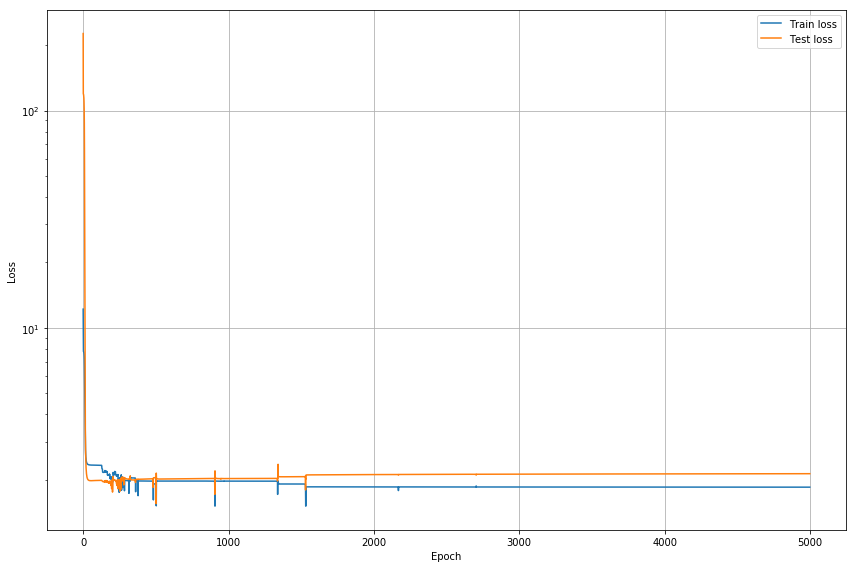

No handles with labels found to put in legend.


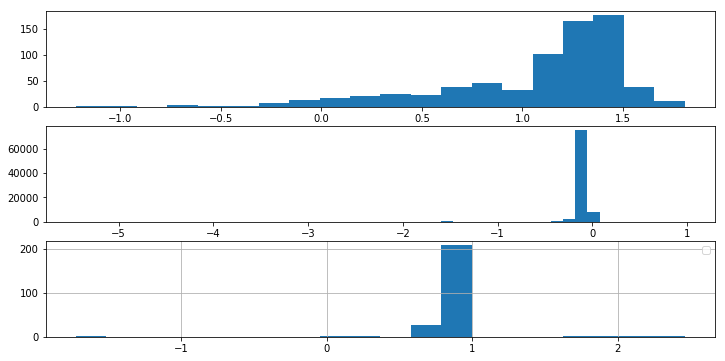

No handles with labels found to put in legend.


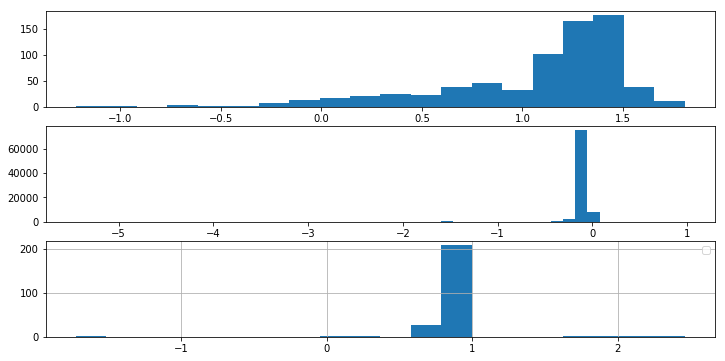

number of hidden neurons in first layer is: 480 number of hidden neurons in second layer is: 120
Epoch 1 - lr: 0.05000 - Train loss: 17.57723 - Test loss: 115.82187
Epoch 2 - lr: 0.05000 - Train loss: 8.44619 - Test loss: 116.17688
Epoch 3 - lr: 0.05000 - Train loss: 8.45344 - Test loss: 116.17346
Epoch 4 - lr: 0.05000 - Train loss: 8.45358 - Test loss: 116.17132
Epoch 5 - lr: 0.05000 - Train loss: 8.45364 - Test loss: 116.16978
Epoch 6 - lr: 0.05000 - Train loss: 8.45369 - Test loss: 116.16856
Epoch 7 - lr: 0.05000 - Train loss: 8.45371 - Test loss: 116.16754
Epoch 8 - lr: 0.05000 - Train loss: 8.45373 - Test loss: 116.16666
Epoch 9 - lr: 0.05000 - Train loss: 8.45374 - Test loss: 116.16586
Epoch 10 - lr: 0.05000 - Train loss: 8.45374 - Test loss: 116.16512
Epoch 11 - lr: 0.05000 - Train loss: 8.45375 - Test loss: 116.16443
Epoch 12 - lr: 0.05000 - Train loss: 8.45374 - Test loss: 116.16377
Epoch 13 - lr: 0.05000 - Train loss: 8.45374 - Test loss: 116.16312
Epoch 14 - lr: 0.05000 - Tr

Epoch 122 - lr: 0.05000 - Train loss: 8.45396 - Test loss: 116.15363
Epoch 123 - lr: 0.05000 - Train loss: 8.45396 - Test loss: 116.15306
Epoch 124 - lr: 0.05000 - Train loss: 8.45396 - Test loss: 116.15241
Epoch 125 - lr: 0.05000 - Train loss: 8.45396 - Test loss: 116.15168
Epoch 126 - lr: 0.05000 - Train loss: 8.45396 - Test loss: 116.15082
Epoch 127 - lr: 0.05000 - Train loss: 8.45397 - Test loss: 116.14976
Epoch 128 - lr: 0.05000 - Train loss: 8.45398 - Test loss: 116.14842
Epoch 129 - lr: 0.05000 - Train loss: 8.45400 - Test loss: 116.14658
Epoch 130 - lr: 0.05000 - Train loss: 8.45402 - Test loss: 116.14382
Epoch 131 - lr: 0.05000 - Train loss: 8.45408 - Test loss: 116.13902
Epoch 132 - lr: 0.05000 - Train loss: 8.45420 - Test loss: 116.12829
Epoch 133 - lr: 0.05000 - Train loss: 8.45484 - Test loss: 116.08640
Epoch 134 - lr: 0.05000 - Train loss: 8.69385 - Test loss: 115.96467
Epoch 135 - lr: 0.05000 - Train loss: 8.80232 - Test loss: 113.59547
Epoch 136 - lr: 0.05000 - Train lo

Epoch 241 - lr: 0.05000 - Train loss: 9.98630 - Test loss: 110.65389
Epoch 242 - lr: 0.05000 - Train loss: 9.98629 - Test loss: 110.65447
Epoch 243 - lr: 0.05000 - Train loss: 9.98629 - Test loss: 110.65494
Epoch 244 - lr: 0.05000 - Train loss: 9.98629 - Test loss: 110.65530
Epoch 245 - lr: 0.05000 - Train loss: 9.98629 - Test loss: 110.65557
Epoch 246 - lr: 0.05000 - Train loss: 9.98630 - Test loss: 110.65575
Epoch 247 - lr: 0.05000 - Train loss: 9.98630 - Test loss: 110.65586
Epoch 248 - lr: 0.05000 - Train loss: 9.98630 - Test loss: 110.65591
Epoch 249 - lr: 0.05000 - Train loss: 9.98629 - Test loss: 110.65590
Epoch 250 - lr: 0.05000 - Train loss: 9.98629 - Test loss: 110.65585
Epoch 251 - lr: 0.05000 - Train loss: 9.98628 - Test loss: 110.65575
Epoch 252 - lr: 0.05000 - Train loss: 9.98627 - Test loss: 110.65563
Epoch 253 - lr: 0.05000 - Train loss: 9.98626 - Test loss: 110.65547
Epoch 254 - lr: 0.05000 - Train loss: 9.98624 - Test loss: 110.65528
Epoch 255 - lr: 0.05000 - Train lo

Epoch 360 - lr: 0.05000 - Train loss: 9.98151 - Test loss: 110.62850
Epoch 361 - lr: 0.05000 - Train loss: 9.98147 - Test loss: 110.63001
Epoch 362 - lr: 0.05000 - Train loss: 9.98145 - Test loss: 110.63122
Epoch 363 - lr: 0.05000 - Train loss: 9.98145 - Test loss: 110.63218
Epoch 364 - lr: 0.05000 - Train loss: 9.98145 - Test loss: 110.63291
Epoch 365 - lr: 0.05000 - Train loss: 9.98145 - Test loss: 110.63346
Epoch 366 - lr: 0.05000 - Train loss: 9.98144 - Test loss: 110.63387
Epoch 367 - lr: 0.05000 - Train loss: 9.98143 - Test loss: 110.63416
Epoch 368 - lr: 0.05000 - Train loss: 9.98141 - Test loss: 110.63436
Epoch 369 - lr: 0.05000 - Train loss: 9.98138 - Test loss: 110.63449
Epoch 370 - lr: 0.05000 - Train loss: 9.98135 - Test loss: 110.63457
Epoch 371 - lr: 0.05000 - Train loss: 9.98132 - Test loss: 110.63462
Epoch 372 - lr: 0.05000 - Train loss: 9.98127 - Test loss: 110.63464
Epoch 373 - lr: 0.05000 - Train loss: 9.98123 - Test loss: 110.63464
Epoch 374 - lr: 0.05000 - Train lo

Epoch 479 - lr: 0.05000 - Train loss: 8.92139 - Test loss: 113.11375
Epoch 480 - lr: 0.05000 - Train loss: 8.88335 - Test loss: 112.71961
Epoch 481 - lr: 0.05000 - Train loss: 9.24411 - Test loss: 112.43506
Epoch 482 - lr: 0.05000 - Train loss: 9.71214 - Test loss: 110.66151
Epoch 483 - lr: 0.05000 - Train loss: 9.21086 - Test loss: 114.85042
Epoch 484 - lr: 0.05000 - Train loss: 9.01600 - Test loss: 113.57795
Epoch 485 - lr: 0.05000 - Train loss: 9.42395 - Test loss: 110.64667
Epoch 486 - lr: 0.05000 - Train loss: 9.93932 - Test loss: 110.67530
Epoch 487 - lr: 0.05000 - Train loss: 9.96478 - Test loss: 110.66413
Epoch 488 - lr: 0.05000 - Train loss: 9.98773 - Test loss: 110.62255
Epoch 489 - lr: 0.05000 - Train loss: 9.98573 - Test loss: 110.53190
Epoch 490 - lr: 0.05000 - Train loss: 9.92699 - Test loss: 110.69485
Epoch 491 - lr: 0.05000 - Train loss: 9.89453 - Test loss: 110.72003
Epoch 492 - lr: 0.05000 - Train loss: 9.99404 - Test loss: 110.52040
Epoch 493 - lr: 0.05000 - Train lo

Epoch 598 - lr: 0.05000 - Train loss: 9.05136 - Test loss: 113.68642
Epoch 599 - lr: 0.05000 - Train loss: 9.05135 - Test loss: 113.68639
Epoch 600 - lr: 0.05000 - Train loss: 9.05135 - Test loss: 113.68636
Epoch 601 - lr: 0.05000 - Train loss: 9.05135 - Test loss: 113.68634
Epoch 602 - lr: 0.05000 - Train loss: 9.05135 - Test loss: 113.68631
Epoch 603 - lr: 0.05000 - Train loss: 9.05134 - Test loss: 113.68629
Epoch 604 - lr: 0.05000 - Train loss: 9.05134 - Test loss: 113.68626
Epoch 605 - lr: 0.05000 - Train loss: 9.05134 - Test loss: 113.68624
Epoch 606 - lr: 0.05000 - Train loss: 9.05134 - Test loss: 113.68622
Epoch 607 - lr: 0.05000 - Train loss: 9.05133 - Test loss: 113.68619
Epoch 608 - lr: 0.05000 - Train loss: 9.05133 - Test loss: 113.68617
Epoch 609 - lr: 0.05000 - Train loss: 9.05133 - Test loss: 113.68615
Epoch 610 - lr: 0.05000 - Train loss: 9.05133 - Test loss: 113.68613
Epoch 611 - lr: 0.05000 - Train loss: 9.05133 - Test loss: 113.68610
Epoch 612 - lr: 0.05000 - Train lo

Epoch 717 - lr: 0.05000 - Train loss: 9.05140 - Test loss: 113.68600
Epoch 718 - lr: 0.05000 - Train loss: 9.05139 - Test loss: 113.68600
Epoch 719 - lr: 0.05000 - Train loss: 9.05139 - Test loss: 113.68599
Epoch 720 - lr: 0.05000 - Train loss: 9.05139 - Test loss: 113.68599
Epoch 721 - lr: 0.05000 - Train loss: 9.05139 - Test loss: 113.68599
Epoch 722 - lr: 0.05000 - Train loss: 9.05139 - Test loss: 113.68599
Epoch 723 - lr: 0.05000 - Train loss: 9.05139 - Test loss: 113.68598
Epoch 724 - lr: 0.05000 - Train loss: 9.05138 - Test loss: 113.68598
Epoch 725 - lr: 0.05000 - Train loss: 9.05138 - Test loss: 113.68598
Epoch 726 - lr: 0.05000 - Train loss: 9.05138 - Test loss: 113.68597
Epoch 727 - lr: 0.05000 - Train loss: 9.05138 - Test loss: 113.68597
Epoch 728 - lr: 0.05000 - Train loss: 9.05138 - Test loss: 113.68597
Epoch 729 - lr: 0.05000 - Train loss: 9.05138 - Test loss: 113.68596
Epoch 730 - lr: 0.05000 - Train loss: 9.05138 - Test loss: 113.68596
Epoch 731 - lr: 0.05000 - Train lo

Epoch 836 - lr: 0.05000 - Train loss: 9.05132 - Test loss: 113.68551
Epoch 837 - lr: 0.05000 - Train loss: 9.05132 - Test loss: 113.68551
Epoch 838 - lr: 0.05000 - Train loss: 9.05132 - Test loss: 113.68550
Epoch 839 - lr: 0.05000 - Train loss: 9.05132 - Test loss: 113.68549
Epoch 840 - lr: 0.05000 - Train loss: 9.05132 - Test loss: 113.68549
Epoch 841 - lr: 0.05000 - Train loss: 9.05131 - Test loss: 113.68548
Epoch 842 - lr: 0.05000 - Train loss: 9.05131 - Test loss: 113.68547
Epoch 843 - lr: 0.05000 - Train loss: 9.05131 - Test loss: 113.68547
Epoch 844 - lr: 0.05000 - Train loss: 9.05131 - Test loss: 113.68546
Epoch 845 - lr: 0.05000 - Train loss: 9.05131 - Test loss: 113.68545
Epoch 846 - lr: 0.05000 - Train loss: 9.05131 - Test loss: 113.68545
Epoch 847 - lr: 0.05000 - Train loss: 9.05131 - Test loss: 113.68544
Epoch 848 - lr: 0.05000 - Train loss: 9.05131 - Test loss: 113.68543
Epoch 849 - lr: 0.05000 - Train loss: 9.05131 - Test loss: 113.68543
Epoch 850 - lr: 0.05000 - Train lo

Epoch 957 - lr: 0.05000 - Train loss: 9.05123 - Test loss: 113.68371
Epoch 958 - lr: 0.05000 - Train loss: 9.05122 - Test loss: 113.68363
Epoch 959 - lr: 0.05000 - Train loss: 9.05122 - Test loss: 113.68353
Epoch 960 - lr: 0.05000 - Train loss: 9.05121 - Test loss: 113.68343
Epoch 961 - lr: 0.05000 - Train loss: 9.05121 - Test loss: 113.68332
Epoch 962 - lr: 0.05000 - Train loss: 9.05120 - Test loss: 113.68320
Epoch 963 - lr: 0.05000 - Train loss: 9.05119 - Test loss: 113.68307
Epoch 964 - lr: 0.05000 - Train loss: 9.05118 - Test loss: 113.68292
Epoch 965 - lr: 0.05000 - Train loss: 9.05117 - Test loss: 113.68276
Epoch 966 - lr: 0.05000 - Train loss: 9.05116 - Test loss: 113.68258
Epoch 967 - lr: 0.05000 - Train loss: 9.05115 - Test loss: 113.68238
Epoch 968 - lr: 0.05000 - Train loss: 9.05113 - Test loss: 113.68215
Epoch 969 - lr: 0.05000 - Train loss: 9.05111 - Test loss: 113.68189
Epoch 970 - lr: 0.05000 - Train loss: 9.05109 - Test loss: 113.68159
Epoch 971 - lr: 0.05000 - Train lo

Epoch 1078 - lr: 0.05000 - Train loss: 9.05127 - Test loss: 113.68486
Epoch 1079 - lr: 0.05000 - Train loss: 9.05127 - Test loss: 113.68482
Epoch 1080 - lr: 0.05000 - Train loss: 9.05127 - Test loss: 113.68477
Epoch 1081 - lr: 0.05000 - Train loss: 9.05127 - Test loss: 113.68472
Epoch 1082 - lr: 0.05000 - Train loss: 9.05126 - Test loss: 113.68467
Epoch 1083 - lr: 0.05000 - Train loss: 9.05126 - Test loss: 113.68461
Epoch 1084 - lr: 0.05000 - Train loss: 9.05126 - Test loss: 113.68454
Epoch 1085 - lr: 0.05000 - Train loss: 9.05126 - Test loss: 113.68447
Epoch 1086 - lr: 0.05000 - Train loss: 9.05125 - Test loss: 113.68439
Epoch 1087 - lr: 0.05000 - Train loss: 9.05125 - Test loss: 113.68431
Epoch 1088 - lr: 0.05000 - Train loss: 9.05124 - Test loss: 113.68421
Epoch 1089 - lr: 0.05000 - Train loss: 9.05124 - Test loss: 113.68410
Epoch 1090 - lr: 0.05000 - Train loss: 9.05124 - Test loss: 113.68398
Epoch 1091 - lr: 0.05000 - Train loss: 9.05123 - Test loss: 113.68384
Epoch 1092 - lr: 0.0

Epoch 1196 - lr: 0.05000 - Train loss: 8.45441 - Test loss: 116.17473
Epoch 1197 - lr: 0.05000 - Train loss: 8.45441 - Test loss: 116.17468
Epoch 1198 - lr: 0.05000 - Train loss: 8.45441 - Test loss: 116.17464
Epoch 1199 - lr: 0.05000 - Train loss: 8.45441 - Test loss: 116.17459
Epoch 1200 - lr: 0.05000 - Train loss: 8.45440 - Test loss: 116.17453
Epoch 1201 - lr: 0.05000 - Train loss: 8.45440 - Test loss: 116.17447
Epoch 1202 - lr: 0.05000 - Train loss: 8.45439 - Test loss: 116.17440
Epoch 1203 - lr: 0.05000 - Train loss: 8.45439 - Test loss: 116.17432
Epoch 1204 - lr: 0.05000 - Train loss: 8.45438 - Test loss: 116.17423
Epoch 1205 - lr: 0.05000 - Train loss: 8.45438 - Test loss: 116.17413
Epoch 1206 - lr: 0.05000 - Train loss: 8.45437 - Test loss: 116.17400
Epoch 1207 - lr: 0.05000 - Train loss: 8.45436 - Test loss: 116.17386
Epoch 1208 - lr: 0.05000 - Train loss: 8.45435 - Test loss: 116.17369
Epoch 1209 - lr: 0.05000 - Train loss: 8.45434 - Test loss: 116.17348
Epoch 1210 - lr: 0.0

Epoch 1314 - lr: 0.05000 - Train loss: 8.45445 - Test loss: 116.17511
Epoch 1315 - lr: 0.05000 - Train loss: 8.45445 - Test loss: 116.17510
Epoch 1316 - lr: 0.05000 - Train loss: 8.45445 - Test loss: 116.17509
Epoch 1317 - lr: 0.05000 - Train loss: 8.45445 - Test loss: 116.17508
Epoch 1318 - lr: 0.05000 - Train loss: 8.45445 - Test loss: 116.17507
Epoch 1319 - lr: 0.05000 - Train loss: 8.45445 - Test loss: 116.17507
Epoch 1320 - lr: 0.05000 - Train loss: 8.45445 - Test loss: 116.17506
Epoch 1321 - lr: 0.05000 - Train loss: 8.45445 - Test loss: 116.17505
Epoch 1322 - lr: 0.05000 - Train loss: 8.45445 - Test loss: 116.17504
Epoch 1323 - lr: 0.05000 - Train loss: 8.45445 - Test loss: 116.17503
Epoch 1324 - lr: 0.05000 - Train loss: 8.45445 - Test loss: 116.17502
Epoch 1325 - lr: 0.05000 - Train loss: 8.45445 - Test loss: 116.17501
Epoch 1326 - lr: 0.05000 - Train loss: 8.45445 - Test loss: 116.17500
Epoch 1327 - lr: 0.05000 - Train loss: 8.45445 - Test loss: 116.17499
Epoch 1328 - lr: 0.0

Epoch 1432 - lr: 0.05000 - Train loss: 8.45446 - Test loss: 116.17495
Epoch 1433 - lr: 0.05000 - Train loss: 8.45446 - Test loss: 116.17493
Epoch 1434 - lr: 0.05000 - Train loss: 8.45446 - Test loss: 116.17492
Epoch 1435 - lr: 0.05000 - Train loss: 8.45446 - Test loss: 116.17491
Epoch 1436 - lr: 0.05000 - Train loss: 8.45446 - Test loss: 116.17490
Epoch 1437 - lr: 0.05000 - Train loss: 8.45446 - Test loss: 116.17488
Epoch 1438 - lr: 0.05000 - Train loss: 8.45446 - Test loss: 116.17487
Epoch 1439 - lr: 0.05000 - Train loss: 8.45446 - Test loss: 116.17486
Epoch 1440 - lr: 0.05000 - Train loss: 8.45446 - Test loss: 116.17484
Epoch 1441 - lr: 0.05000 - Train loss: 8.45446 - Test loss: 116.17483
Epoch 1442 - lr: 0.05000 - Train loss: 8.45446 - Test loss: 116.17481
Epoch 1443 - lr: 0.05000 - Train loss: 8.45446 - Test loss: 116.17480
Epoch 1444 - lr: 0.05000 - Train loss: 8.45446 - Test loss: 116.17478
Epoch 1445 - lr: 0.05000 - Train loss: 8.45446 - Test loss: 116.17477
Epoch 1446 - lr: 0.0

Epoch 1550 - lr: 0.05000 - Train loss: 9.05109 - Test loss: 113.68326
Epoch 1551 - lr: 0.05000 - Train loss: 9.05106 - Test loss: 113.68277
Epoch 1552 - lr: 0.05000 - Train loss: 9.05101 - Test loss: 113.68205
Epoch 1553 - lr: 0.05000 - Train loss: 9.05093 - Test loss: 113.68087
Epoch 1554 - lr: 0.05000 - Train loss: 9.05079 - Test loss: 113.67858
Epoch 1555 - lr: 0.05000 - Train loss: 9.05046 - Test loss: 113.67215
Epoch 1556 - lr: 0.05000 - Train loss: 9.04849 - Test loss: 113.59359
Epoch 1557 - lr: 0.05000 - Train loss: 8.62163 - Test loss: 81.08297
Epoch 1558 - lr: 0.05000 - Train loss: 8.28056 - Test loss: 113.68434
Epoch 1559 - lr: 0.05000 - Train loss: 9.05117 - Test loss: 113.68421
Epoch 1560 - lr: 0.05000 - Train loss: 9.05116 - Test loss: 113.68407
Epoch 1561 - lr: 0.05000 - Train loss: 9.05115 - Test loss: 113.68391
Epoch 1562 - lr: 0.05000 - Train loss: 9.05113 - Test loss: 113.68372
Epoch 1563 - lr: 0.05000 - Train loss: 9.05112 - Test loss: 113.68350
Epoch 1564 - lr: 0.05

Epoch 1668 - lr: 0.05000 - Train loss: 8.07511 - Test loss: 118.83327
Epoch 1669 - lr: 0.05000 - Train loss: 8.07511 - Test loss: 118.83326
Epoch 1670 - lr: 0.05000 - Train loss: 8.07511 - Test loss: 118.83325
Epoch 1671 - lr: 0.05000 - Train loss: 8.07511 - Test loss: 118.83324
Epoch 1672 - lr: 0.05000 - Train loss: 8.07511 - Test loss: 118.83323
Epoch 1673 - lr: 0.05000 - Train loss: 8.07511 - Test loss: 118.83322
Epoch 1674 - lr: 0.05000 - Train loss: 8.07511 - Test loss: 118.83321
Epoch 1675 - lr: 0.05000 - Train loss: 8.07511 - Test loss: 118.83319
Epoch 1676 - lr: 0.05000 - Train loss: 8.07511 - Test loss: 118.83318
Epoch 1677 - lr: 0.05000 - Train loss: 8.07510 - Test loss: 118.83317
Epoch 1678 - lr: 0.05000 - Train loss: 8.07510 - Test loss: 118.83316
Epoch 1679 - lr: 0.05000 - Train loss: 8.07510 - Test loss: 118.83315
Epoch 1680 - lr: 0.05000 - Train loss: 8.07510 - Test loss: 118.83314
Epoch 1681 - lr: 0.05000 - Train loss: 8.07510 - Test loss: 118.83313
Epoch 1682 - lr: 0.0

Epoch 1787 - lr: 0.05000 - Train loss: 8.07450 - Test loss: 118.81941
Epoch 1788 - lr: 0.05000 - Train loss: 8.07431 - Test loss: 118.81452
Epoch 1789 - lr: 0.05000 - Train loss: 8.07392 - Test loss: 118.80265
Epoch 1790 - lr: 0.05000 - Train loss: 8.07243 - Test loss: 118.73013
Epoch 1791 - lr: 0.05000 - Train loss: 8.03017 - Test loss: 109.14171
Epoch 1792 - lr: 0.05000 - Train loss: 7.58367 - Test loss: 89.00860
Epoch 1793 - lr: 0.05000 - Train loss: 7.54425 - Test loss: 118.50628
Epoch 1794 - lr: 0.05000 - Train loss: 7.69362 - Test loss: 83.36785
Epoch 1795 - lr: 0.05000 - Train loss: 7.46272 - Test loss: 118.79076
Epoch 1796 - lr: 0.05000 - Train loss: 8.07262 - Test loss: 118.69165
Epoch 1797 - lr: 0.05000 - Train loss: 7.99416 - Test loss: 117.28034
Epoch 1798 - lr: 0.05000 - Train loss: 7.83760 - Test loss: 118.47384
Epoch 1799 - lr: 0.05000 - Train loss: 7.85378 - Test loss: 99.00323
Epoch 1800 - lr: 0.05000 - Train loss: 7.48062 - Test loss: 98.99353
Epoch 1801 - lr: 0.05000

Epoch 1906 - lr: 0.05000 - Train loss: 8.07511 - Test loss: 118.83268
Epoch 1907 - lr: 0.05000 - Train loss: 8.07511 - Test loss: 118.83268
Epoch 1908 - lr: 0.05000 - Train loss: 8.07511 - Test loss: 118.83268
Epoch 1909 - lr: 0.05000 - Train loss: 8.07511 - Test loss: 118.83269
Epoch 1910 - lr: 0.05000 - Train loss: 8.07511 - Test loss: 118.83269
Epoch 1911 - lr: 0.05000 - Train loss: 8.07511 - Test loss: 118.83269
Epoch 1912 - lr: 0.05000 - Train loss: 8.07511 - Test loss: 118.83269
Epoch 1913 - lr: 0.05000 - Train loss: 8.07511 - Test loss: 118.83269
Epoch 1914 - lr: 0.05000 - Train loss: 8.07511 - Test loss: 118.83270
Epoch 1915 - lr: 0.05000 - Train loss: 8.07511 - Test loss: 118.83270
Epoch 1916 - lr: 0.05000 - Train loss: 8.07511 - Test loss: 118.83270
Epoch 1917 - lr: 0.05000 - Train loss: 8.07511 - Test loss: 118.83270
Epoch 1918 - lr: 0.05000 - Train loss: 8.07511 - Test loss: 118.83271
Epoch 1919 - lr: 0.05000 - Train loss: 8.07511 - Test loss: 118.83271
Epoch 1920 - lr: 0.0

Epoch 2028 - lr: 0.05000 - Train loss: 8.07510 - Test loss: 118.83279
Epoch 2029 - lr: 0.05000 - Train loss: 8.07510 - Test loss: 118.83279
Epoch 2030 - lr: 0.05000 - Train loss: 8.07510 - Test loss: 118.83279
Epoch 2031 - lr: 0.05000 - Train loss: 8.07510 - Test loss: 118.83279
Epoch 2032 - lr: 0.05000 - Train loss: 8.07510 - Test loss: 118.83279
Epoch 2033 - lr: 0.05000 - Train loss: 8.07510 - Test loss: 118.83279
Epoch 2034 - lr: 0.05000 - Train loss: 8.07510 - Test loss: 118.83279
Epoch 2035 - lr: 0.05000 - Train loss: 8.07510 - Test loss: 118.83279
Epoch 2036 - lr: 0.05000 - Train loss: 8.07510 - Test loss: 118.83279
Epoch 2037 - lr: 0.05000 - Train loss: 8.07510 - Test loss: 118.83279
Epoch 2038 - lr: 0.05000 - Train loss: 8.07510 - Test loss: 118.83279
Epoch 2039 - lr: 0.05000 - Train loss: 8.07510 - Test loss: 118.83279
Epoch 2040 - lr: 0.05000 - Train loss: 8.07510 - Test loss: 118.83279
Epoch 2041 - lr: 0.05000 - Train loss: 8.07510 - Test loss: 118.83279
Epoch 2042 - lr: 0.0

Epoch 2152 - lr: 0.05000 - Train loss: 8.07509 - Test loss: 118.83263
Epoch 2153 - lr: 0.05000 - Train loss: 8.07509 - Test loss: 118.83262
Epoch 2154 - lr: 0.05000 - Train loss: 8.07509 - Test loss: 118.83262
Epoch 2155 - lr: 0.05000 - Train loss: 8.07509 - Test loss: 118.83262
Epoch 2156 - lr: 0.05000 - Train loss: 8.07509 - Test loss: 118.83261
Epoch 2157 - lr: 0.05000 - Train loss: 8.07509 - Test loss: 118.83261
Epoch 2158 - lr: 0.05000 - Train loss: 8.07509 - Test loss: 118.83260
Epoch 2159 - lr: 0.05000 - Train loss: 8.07509 - Test loss: 118.83260
Epoch 2160 - lr: 0.05000 - Train loss: 8.07509 - Test loss: 118.83260
Epoch 2161 - lr: 0.05000 - Train loss: 8.07509 - Test loss: 118.83259
Epoch 2162 - lr: 0.05000 - Train loss: 8.07509 - Test loss: 118.83259
Epoch 2163 - lr: 0.05000 - Train loss: 8.07509 - Test loss: 118.83259
Epoch 2164 - lr: 0.05000 - Train loss: 8.07509 - Test loss: 118.83258
Epoch 2165 - lr: 0.05000 - Train loss: 8.07509 - Test loss: 118.83258
Epoch 2166 - lr: 0.0

Epoch 2270 - lr: 0.05000 - Train loss: 8.07432 - Test loss: 118.82335
Epoch 2271 - lr: 0.05000 - Train loss: 8.07399 - Test loss: 118.82201
Epoch 2272 - lr: 0.05000 - Train loss: 8.07346 - Test loss: 118.82087
Epoch 2273 - lr: 0.05000 - Train loss: 8.07289 - Test loss: 118.82024
Epoch 2274 - lr: 0.05000 - Train loss: 8.07269 - Test loss: 118.81956
Epoch 2275 - lr: 0.05000 - Train loss: 8.07249 - Test loss: 118.81884
Epoch 2276 - lr: 0.05000 - Train loss: 8.07226 - Test loss: 118.81809
Epoch 2277 - lr: 0.05000 - Train loss: 8.07202 - Test loss: 118.81729
Epoch 2278 - lr: 0.05000 - Train loss: 8.07177 - Test loss: 118.81647
Epoch 2279 - lr: 0.05000 - Train loss: 8.07150 - Test loss: 118.81561
Epoch 2280 - lr: 0.05000 - Train loss: 8.07120 - Test loss: 118.81474
Epoch 2281 - lr: 0.05000 - Train loss: 8.07090 - Test loss: 118.81381
Epoch 2282 - lr: 0.05000 - Train loss: 8.07055 - Test loss: 118.81296
Epoch 2283 - lr: 0.05000 - Train loss: 8.07024 - Test loss: 118.81185
Epoch 2284 - lr: 0.0

Epoch 2391 - lr: 0.05000 - Train loss: 8.07510 - Test loss: 118.83333
Epoch 2392 - lr: 0.05000 - Train loss: 8.07510 - Test loss: 118.83333
Epoch 2393 - lr: 0.05000 - Train loss: 8.07510 - Test loss: 118.83333
Epoch 2394 - lr: 0.05000 - Train loss: 8.07510 - Test loss: 118.83333
Epoch 2395 - lr: 0.05000 - Train loss: 8.07510 - Test loss: 118.83333
Epoch 2396 - lr: 0.05000 - Train loss: 8.07510 - Test loss: 118.83333
Epoch 2397 - lr: 0.05000 - Train loss: 8.07510 - Test loss: 118.83333
Epoch 2398 - lr: 0.05000 - Train loss: 8.07510 - Test loss: 118.83333
Epoch 2399 - lr: 0.05000 - Train loss: 8.07510 - Test loss: 118.83333
Epoch 2400 - lr: 0.05000 - Train loss: 8.07510 - Test loss: 118.83333
Epoch 2401 - lr: 0.05000 - Train loss: 8.07510 - Test loss: 118.83333
Epoch 2402 - lr: 0.05000 - Train loss: 8.07510 - Test loss: 118.83333
Epoch 2403 - lr: 0.05000 - Train loss: 8.07510 - Test loss: 118.83333
Epoch 2404 - lr: 0.05000 - Train loss: 8.07510 - Test loss: 118.83333
Epoch 2405 - lr: 0.0

Epoch 2509 - lr: 0.05000 - Train loss: 8.07510 - Test loss: 118.83333
Epoch 2510 - lr: 0.05000 - Train loss: 8.07510 - Test loss: 118.83333
Epoch 2511 - lr: 0.05000 - Train loss: 8.07510 - Test loss: 118.83333
Epoch 2512 - lr: 0.05000 - Train loss: 8.07510 - Test loss: 118.83333
Epoch 2513 - lr: 0.05000 - Train loss: 8.07510 - Test loss: 118.83333
Epoch 2514 - lr: 0.05000 - Train loss: 8.07510 - Test loss: 118.83333
Epoch 2515 - lr: 0.05000 - Train loss: 8.07510 - Test loss: 118.83333
Epoch 2516 - lr: 0.05000 - Train loss: 8.07510 - Test loss: 118.83333
Epoch 2517 - lr: 0.05000 - Train loss: 8.07510 - Test loss: 118.83333
Epoch 2518 - lr: 0.05000 - Train loss: 8.07510 - Test loss: 118.83333
Epoch 2519 - lr: 0.05000 - Train loss: 8.07510 - Test loss: 118.83333
Epoch 2520 - lr: 0.05000 - Train loss: 8.07510 - Test loss: 118.83333
Epoch 2521 - lr: 0.05000 - Train loss: 8.07510 - Test loss: 118.83333
Epoch 2522 - lr: 0.05000 - Train loss: 8.07510 - Test loss: 118.83333
Epoch 2523 - lr: 0.0

Epoch 2632 - lr: 0.05000 - Train loss: 8.07510 - Test loss: 118.83333
Epoch 2633 - lr: 0.05000 - Train loss: 8.07510 - Test loss: 118.83333
Epoch 2634 - lr: 0.05000 - Train loss: 8.07510 - Test loss: 118.83333
Epoch 2635 - lr: 0.05000 - Train loss: 8.07510 - Test loss: 118.83333
Epoch 2636 - lr: 0.05000 - Train loss: 8.07510 - Test loss: 118.83333
Epoch 2637 - lr: 0.05000 - Train loss: 8.07510 - Test loss: 118.83333
Epoch 2638 - lr: 0.05000 - Train loss: 8.07510 - Test loss: 118.83333
Epoch 2639 - lr: 0.05000 - Train loss: 8.07510 - Test loss: 118.83333
Epoch 2640 - lr: 0.05000 - Train loss: 8.07510 - Test loss: 118.83333
Epoch 2641 - lr: 0.05000 - Train loss: 8.07510 - Test loss: 118.83333
Epoch 2642 - lr: 0.05000 - Train loss: 8.07510 - Test loss: 118.83333
Epoch 2643 - lr: 0.05000 - Train loss: 8.07510 - Test loss: 118.83333
Epoch 2644 - lr: 0.05000 - Train loss: 8.07510 - Test loss: 118.83333
Epoch 2645 - lr: 0.05000 - Train loss: 8.07510 - Test loss: 118.83333
Epoch 2646 - lr: 0.0

Epoch 2751 - lr: 0.05000 - Train loss: 8.07510 - Test loss: 118.83333
Epoch 2752 - lr: 0.05000 - Train loss: 8.07510 - Test loss: 118.83333
Epoch 2753 - lr: 0.05000 - Train loss: 8.07510 - Test loss: 118.83333
Epoch 2754 - lr: 0.05000 - Train loss: 8.07510 - Test loss: 118.83333
Epoch 2755 - lr: 0.05000 - Train loss: 8.07510 - Test loss: 118.83333
Epoch 2756 - lr: 0.05000 - Train loss: 8.07510 - Test loss: 118.83333
Epoch 2757 - lr: 0.05000 - Train loss: 8.07510 - Test loss: 118.83333
Epoch 2758 - lr: 0.05000 - Train loss: 8.07510 - Test loss: 118.83333
Epoch 2759 - lr: 0.05000 - Train loss: 8.07510 - Test loss: 118.83333
Epoch 2760 - lr: 0.05000 - Train loss: 8.07510 - Test loss: 118.83333
Epoch 2761 - lr: 0.05000 - Train loss: 8.07510 - Test loss: 118.83333
Epoch 2762 - lr: 0.05000 - Train loss: 8.07510 - Test loss: 118.83333
Epoch 2763 - lr: 0.05000 - Train loss: 8.07510 - Test loss: 118.83333
Epoch 2764 - lr: 0.05000 - Train loss: 8.07510 - Test loss: 118.83333
Epoch 2765 - lr: 0.0

Epoch 2869 - lr: 0.05000 - Train loss: 8.07510 - Test loss: 118.83333
Epoch 2870 - lr: 0.05000 - Train loss: 8.07510 - Test loss: 118.83333
Epoch 2871 - lr: 0.05000 - Train loss: 8.07510 - Test loss: 118.83333
Epoch 2872 - lr: 0.05000 - Train loss: 8.07510 - Test loss: 118.83333
Epoch 2873 - lr: 0.05000 - Train loss: 8.07510 - Test loss: 118.83333
Epoch 2874 - lr: 0.05000 - Train loss: 8.07510 - Test loss: 118.83333
Epoch 2875 - lr: 0.05000 - Train loss: 8.07510 - Test loss: 118.83333
Epoch 2876 - lr: 0.05000 - Train loss: 8.07510 - Test loss: 118.83333
Epoch 2877 - lr: 0.05000 - Train loss: 8.07510 - Test loss: 118.83333
Epoch 2878 - lr: 0.05000 - Train loss: 8.07510 - Test loss: 118.83333
Epoch 2879 - lr: 0.05000 - Train loss: 8.07510 - Test loss: 118.83333
Epoch 2880 - lr: 0.05000 - Train loss: 8.07510 - Test loss: 118.83333
Epoch 2881 - lr: 0.05000 - Train loss: 8.07510 - Test loss: 118.83333
Epoch 2882 - lr: 0.05000 - Train loss: 8.07510 - Test loss: 118.83333
Epoch 2883 - lr: 0.0

Epoch 2988 - lr: 0.05000 - Train loss: 8.07510 - Test loss: 118.83332
Epoch 2989 - lr: 0.05000 - Train loss: 8.07510 - Test loss: 118.83332
Epoch 2990 - lr: 0.05000 - Train loss: 8.07510 - Test loss: 118.83332
Epoch 2991 - lr: 0.05000 - Train loss: 8.07510 - Test loss: 118.83332
Epoch 2992 - lr: 0.05000 - Train loss: 8.07510 - Test loss: 118.83332
Epoch 2993 - lr: 0.05000 - Train loss: 8.07510 - Test loss: 118.83332
Epoch 2994 - lr: 0.05000 - Train loss: 8.07510 - Test loss: 118.83332
Epoch 2995 - lr: 0.05000 - Train loss: 8.07510 - Test loss: 118.83332
Epoch 2996 - lr: 0.05000 - Train loss: 8.07510 - Test loss: 118.83332
Epoch 2997 - lr: 0.05000 - Train loss: 8.07510 - Test loss: 118.83332
Epoch 2998 - lr: 0.05000 - Train loss: 8.07510 - Test loss: 118.83332
Epoch 2999 - lr: 0.05000 - Train loss: 8.07510 - Test loss: 118.83332
Epoch 3000 - lr: 0.05000 - Train loss: 8.07510 - Test loss: 118.83332
Epoch 3001 - lr: 0.05000 - Train loss: 8.07510 - Test loss: 118.83332
Epoch 3002 - lr: 0.0

Epoch 3107 - lr: 0.05000 - Train loss: 8.07510 - Test loss: 118.83332
Epoch 3108 - lr: 0.05000 - Train loss: 8.07510 - Test loss: 118.83332
Epoch 3109 - lr: 0.05000 - Train loss: 8.07510 - Test loss: 118.83332
Epoch 3110 - lr: 0.05000 - Train loss: 8.07510 - Test loss: 118.83332
Epoch 3111 - lr: 0.05000 - Train loss: 8.07510 - Test loss: 118.83332
Epoch 3112 - lr: 0.05000 - Train loss: 8.07510 - Test loss: 118.83332
Epoch 3113 - lr: 0.05000 - Train loss: 8.07510 - Test loss: 118.83332
Epoch 3114 - lr: 0.05000 - Train loss: 8.07510 - Test loss: 118.83332
Epoch 3115 - lr: 0.05000 - Train loss: 8.07510 - Test loss: 118.83332
Epoch 3116 - lr: 0.05000 - Train loss: 8.07510 - Test loss: 118.83332
Epoch 3117 - lr: 0.05000 - Train loss: 8.07510 - Test loss: 118.83332
Epoch 3118 - lr: 0.05000 - Train loss: 8.07510 - Test loss: 118.83332
Epoch 3119 - lr: 0.05000 - Train loss: 8.07510 - Test loss: 118.83332
Epoch 3120 - lr: 0.05000 - Train loss: 8.07510 - Test loss: 118.83332
Epoch 3121 - lr: 0.0

Epoch 3226 - lr: 0.05000 - Train loss: 8.07510 - Test loss: 118.83332
Epoch 3227 - lr: 0.05000 - Train loss: 8.07510 - Test loss: 118.83332
Epoch 3228 - lr: 0.05000 - Train loss: 8.07510 - Test loss: 118.83332
Epoch 3229 - lr: 0.05000 - Train loss: 8.07510 - Test loss: 118.83332
Epoch 3230 - lr: 0.05000 - Train loss: 8.07510 - Test loss: 118.83332
Epoch 3231 - lr: 0.05000 - Train loss: 8.07510 - Test loss: 118.83332
Epoch 3232 - lr: 0.05000 - Train loss: 8.07510 - Test loss: 118.83332
Epoch 3233 - lr: 0.05000 - Train loss: 8.07510 - Test loss: 118.83332
Epoch 3234 - lr: 0.05000 - Train loss: 8.07510 - Test loss: 118.83332
Epoch 3235 - lr: 0.05000 - Train loss: 8.07510 - Test loss: 118.83332
Epoch 3236 - lr: 0.05000 - Train loss: 8.07510 - Test loss: 118.83332
Epoch 3237 - lr: 0.05000 - Train loss: 8.07510 - Test loss: 118.83332
Epoch 3238 - lr: 0.05000 - Train loss: 8.07510 - Test loss: 118.83332
Epoch 3239 - lr: 0.05000 - Train loss: 8.07510 - Test loss: 118.83332
Epoch 3240 - lr: 0.0

Epoch 3344 - lr: 0.05000 - Train loss: 8.07510 - Test loss: 118.83332
Epoch 3345 - lr: 0.05000 - Train loss: 8.07510 - Test loss: 118.83332
Epoch 3346 - lr: 0.05000 - Train loss: 8.07510 - Test loss: 118.83332
Epoch 3347 - lr: 0.05000 - Train loss: 8.07510 - Test loss: 118.83332
Epoch 3348 - lr: 0.05000 - Train loss: 8.07510 - Test loss: 118.83332
Epoch 3349 - lr: 0.05000 - Train loss: 8.07510 - Test loss: 118.83332
Epoch 3350 - lr: 0.05000 - Train loss: 8.07510 - Test loss: 118.83332
Epoch 3351 - lr: 0.05000 - Train loss: 8.07510 - Test loss: 118.83332
Epoch 3352 - lr: 0.05000 - Train loss: 8.07510 - Test loss: 118.83332
Epoch 3353 - lr: 0.05000 - Train loss: 8.07510 - Test loss: 118.83332
Epoch 3354 - lr: 0.05000 - Train loss: 8.07510 - Test loss: 118.83332
Epoch 3355 - lr: 0.05000 - Train loss: 8.07510 - Test loss: 118.83332
Epoch 3356 - lr: 0.05000 - Train loss: 8.07510 - Test loss: 118.83332
Epoch 3357 - lr: 0.05000 - Train loss: 8.07510 - Test loss: 118.83332
Epoch 3358 - lr: 0.0

Epoch 3463 - lr: 0.05000 - Train loss: 8.07510 - Test loss: 118.83332
Epoch 3464 - lr: 0.05000 - Train loss: 8.07510 - Test loss: 118.83332
Epoch 3465 - lr: 0.05000 - Train loss: 8.07510 - Test loss: 118.83332
Epoch 3466 - lr: 0.05000 - Train loss: 8.07510 - Test loss: 118.83332
Epoch 3467 - lr: 0.05000 - Train loss: 8.07510 - Test loss: 118.83332
Epoch 3468 - lr: 0.05000 - Train loss: 8.07510 - Test loss: 118.83332
Epoch 3469 - lr: 0.05000 - Train loss: 8.07510 - Test loss: 118.83332
Epoch 3470 - lr: 0.05000 - Train loss: 8.07510 - Test loss: 118.83332
Epoch 3471 - lr: 0.05000 - Train loss: 8.07510 - Test loss: 118.83332
Epoch 3472 - lr: 0.05000 - Train loss: 8.07510 - Test loss: 118.83332
Epoch 3473 - lr: 0.05000 - Train loss: 8.07510 - Test loss: 118.83332
Epoch 3474 - lr: 0.05000 - Train loss: 8.07510 - Test loss: 118.83332
Epoch 3475 - lr: 0.05000 - Train loss: 8.07510 - Test loss: 118.83332
Epoch 3476 - lr: 0.05000 - Train loss: 8.07510 - Test loss: 118.83332
Epoch 3477 - lr: 0.0

Epoch 3581 - lr: 0.05000 - Train loss: 8.07510 - Test loss: 118.83332
Epoch 3582 - lr: 0.05000 - Train loss: 8.07510 - Test loss: 118.83332
Epoch 3583 - lr: 0.05000 - Train loss: 8.07510 - Test loss: 118.83332
Epoch 3584 - lr: 0.05000 - Train loss: 8.07510 - Test loss: 118.83332
Epoch 3585 - lr: 0.05000 - Train loss: 8.07510 - Test loss: 118.83332
Epoch 3586 - lr: 0.05000 - Train loss: 8.07510 - Test loss: 118.83332
Epoch 3587 - lr: 0.05000 - Train loss: 8.07510 - Test loss: 118.83332
Epoch 3588 - lr: 0.05000 - Train loss: 8.07510 - Test loss: 118.83332
Epoch 3589 - lr: 0.05000 - Train loss: 8.07510 - Test loss: 118.83332
Epoch 3590 - lr: 0.05000 - Train loss: 8.07510 - Test loss: 118.83332
Epoch 3591 - lr: 0.05000 - Train loss: 8.07510 - Test loss: 118.83332
Epoch 3592 - lr: 0.05000 - Train loss: 8.07510 - Test loss: 118.83332
Epoch 3593 - lr: 0.05000 - Train loss: 8.07510 - Test loss: 118.83332
Epoch 3594 - lr: 0.05000 - Train loss: 8.07510 - Test loss: 118.83332
Epoch 3595 - lr: 0.0

Epoch 3705 - lr: 0.05000 - Train loss: 8.07510 - Test loss: 118.83332
Epoch 3706 - lr: 0.05000 - Train loss: 8.07510 - Test loss: 118.83332
Epoch 3707 - lr: 0.05000 - Train loss: 8.07510 - Test loss: 118.83332
Epoch 3708 - lr: 0.05000 - Train loss: 8.07510 - Test loss: 118.83332
Epoch 3709 - lr: 0.05000 - Train loss: 8.07510 - Test loss: 118.83332
Epoch 3710 - lr: 0.05000 - Train loss: 8.07510 - Test loss: 118.83332
Epoch 3711 - lr: 0.05000 - Train loss: 8.07510 - Test loss: 118.83332
Epoch 3712 - lr: 0.05000 - Train loss: 8.07510 - Test loss: 118.83332
Epoch 3713 - lr: 0.05000 - Train loss: 8.07510 - Test loss: 118.83332
Epoch 3714 - lr: 0.05000 - Train loss: 8.07510 - Test loss: 118.83332
Epoch 3715 - lr: 0.05000 - Train loss: 8.07510 - Test loss: 118.83332
Epoch 3716 - lr: 0.05000 - Train loss: 8.07510 - Test loss: 118.83332
Epoch 3717 - lr: 0.05000 - Train loss: 8.07510 - Test loss: 118.83332
Epoch 3718 - lr: 0.05000 - Train loss: 8.07510 - Test loss: 118.83332
Epoch 3719 - lr: 0.0

Epoch 3824 - lr: 0.05000 - Train loss: 8.07510 - Test loss: 118.83332
Epoch 3825 - lr: 0.05000 - Train loss: 8.07510 - Test loss: 118.83332
Epoch 3826 - lr: 0.05000 - Train loss: 8.07510 - Test loss: 118.83332
Epoch 3827 - lr: 0.05000 - Train loss: 8.07510 - Test loss: 118.83332
Epoch 3828 - lr: 0.05000 - Train loss: 8.07510 - Test loss: 118.83332
Epoch 3829 - lr: 0.05000 - Train loss: 8.07510 - Test loss: 118.83332
Epoch 3830 - lr: 0.05000 - Train loss: 8.07510 - Test loss: 118.83332
Epoch 3831 - lr: 0.05000 - Train loss: 8.07510 - Test loss: 118.83332
Epoch 3832 - lr: 0.05000 - Train loss: 8.07510 - Test loss: 118.83332
Epoch 3833 - lr: 0.05000 - Train loss: 8.07510 - Test loss: 118.83332
Epoch 3834 - lr: 0.05000 - Train loss: 8.07510 - Test loss: 118.83332
Epoch 3835 - lr: 0.05000 - Train loss: 8.07510 - Test loss: 118.83332
Epoch 3836 - lr: 0.05000 - Train loss: 8.07510 - Test loss: 118.83332
Epoch 3837 - lr: 0.05000 - Train loss: 8.07510 - Test loss: 118.83332
Epoch 3838 - lr: 0.0

Epoch 3942 - lr: 0.05000 - Train loss: 8.07510 - Test loss: 118.83331
Epoch 3943 - lr: 0.05000 - Train loss: 8.07510 - Test loss: 118.83331
Epoch 3944 - lr: 0.05000 - Train loss: 8.07510 - Test loss: 118.83331
Epoch 3945 - lr: 0.05000 - Train loss: 8.07510 - Test loss: 118.83331
Epoch 3946 - lr: 0.05000 - Train loss: 8.07510 - Test loss: 118.83331
Epoch 3947 - lr: 0.05000 - Train loss: 8.07510 - Test loss: 118.83331
Epoch 3948 - lr: 0.05000 - Train loss: 8.07510 - Test loss: 118.83331
Epoch 3949 - lr: 0.05000 - Train loss: 8.07510 - Test loss: 118.83331
Epoch 3950 - lr: 0.05000 - Train loss: 8.07510 - Test loss: 118.83331
Epoch 3951 - lr: 0.05000 - Train loss: 8.07510 - Test loss: 118.83331
Epoch 3952 - lr: 0.05000 - Train loss: 8.07510 - Test loss: 118.83331
Epoch 3953 - lr: 0.05000 - Train loss: 8.07510 - Test loss: 118.83331
Epoch 3954 - lr: 0.05000 - Train loss: 8.07510 - Test loss: 118.83331
Epoch 3955 - lr: 0.05000 - Train loss: 8.07510 - Test loss: 118.83331
Epoch 3956 - lr: 0.0

Epoch 4061 - lr: 0.05000 - Train loss: 8.07510 - Test loss: 118.83331
Epoch 4062 - lr: 0.05000 - Train loss: 8.07510 - Test loss: 118.83331
Epoch 4063 - lr: 0.05000 - Train loss: 8.07510 - Test loss: 118.83331
Epoch 4064 - lr: 0.05000 - Train loss: 8.07510 - Test loss: 118.83331
Epoch 4065 - lr: 0.05000 - Train loss: 8.07510 - Test loss: 118.83331
Epoch 4066 - lr: 0.05000 - Train loss: 8.07510 - Test loss: 118.83331
Epoch 4067 - lr: 0.05000 - Train loss: 8.07510 - Test loss: 118.83331
Epoch 4068 - lr: 0.05000 - Train loss: 8.07510 - Test loss: 118.83331
Epoch 4069 - lr: 0.05000 - Train loss: 8.07510 - Test loss: 118.83331
Epoch 4070 - lr: 0.05000 - Train loss: 8.07510 - Test loss: 118.83331
Epoch 4071 - lr: 0.05000 - Train loss: 8.07510 - Test loss: 118.83331
Epoch 4072 - lr: 0.05000 - Train loss: 8.07510 - Test loss: 118.83331
Epoch 4073 - lr: 0.05000 - Train loss: 8.07510 - Test loss: 118.83331
Epoch 4074 - lr: 0.05000 - Train loss: 8.07510 - Test loss: 118.83331
Epoch 4075 - lr: 0.0

Epoch 4180 - lr: 0.05000 - Train loss: 8.07510 - Test loss: 118.83331
Epoch 4181 - lr: 0.05000 - Train loss: 8.07510 - Test loss: 118.83331
Epoch 4182 - lr: 0.05000 - Train loss: 8.07510 - Test loss: 118.83331
Epoch 4183 - lr: 0.05000 - Train loss: 8.07510 - Test loss: 118.83331
Epoch 4184 - lr: 0.05000 - Train loss: 8.07510 - Test loss: 118.83331
Epoch 4185 - lr: 0.05000 - Train loss: 8.07510 - Test loss: 118.83331
Epoch 4186 - lr: 0.05000 - Train loss: 8.07510 - Test loss: 118.83331
Epoch 4187 - lr: 0.05000 - Train loss: 8.07510 - Test loss: 118.83331
Epoch 4188 - lr: 0.05000 - Train loss: 8.07510 - Test loss: 118.83331
Epoch 4189 - lr: 0.05000 - Train loss: 8.07510 - Test loss: 118.83331
Epoch 4190 - lr: 0.05000 - Train loss: 8.07510 - Test loss: 118.83331
Epoch 4191 - lr: 0.05000 - Train loss: 8.07510 - Test loss: 118.83331
Epoch 4192 - lr: 0.05000 - Train loss: 8.07510 - Test loss: 118.83331
Epoch 4193 - lr: 0.05000 - Train loss: 8.07510 - Test loss: 118.83331
Epoch 4194 - lr: 0.0

Epoch 4299 - lr: 0.05000 - Train loss: 8.07510 - Test loss: 118.83331
Epoch 4300 - lr: 0.05000 - Train loss: 8.07510 - Test loss: 118.83331
Epoch 4301 - lr: 0.05000 - Train loss: 8.07510 - Test loss: 118.83331
Epoch 4302 - lr: 0.05000 - Train loss: 8.07510 - Test loss: 118.83331
Epoch 4303 - lr: 0.05000 - Train loss: 8.07510 - Test loss: 118.83331
Epoch 4304 - lr: 0.05000 - Train loss: 8.07510 - Test loss: 118.83331
Epoch 4305 - lr: 0.05000 - Train loss: 8.07510 - Test loss: 118.83331
Epoch 4306 - lr: 0.05000 - Train loss: 8.07510 - Test loss: 118.83331
Epoch 4307 - lr: 0.05000 - Train loss: 8.07510 - Test loss: 118.83331
Epoch 4308 - lr: 0.05000 - Train loss: 8.07510 - Test loss: 118.83331
Epoch 4309 - lr: 0.05000 - Train loss: 8.07510 - Test loss: 118.83331
Epoch 4310 - lr: 0.05000 - Train loss: 8.07510 - Test loss: 118.83331
Epoch 4311 - lr: 0.05000 - Train loss: 8.07510 - Test loss: 118.83331
Epoch 4312 - lr: 0.05000 - Train loss: 8.07510 - Test loss: 118.83331
Epoch 4313 - lr: 0.0

Epoch 4417 - lr: 0.05000 - Train loss: 8.07510 - Test loss: 118.83331
Epoch 4418 - lr: 0.05000 - Train loss: 8.07510 - Test loss: 118.83331
Epoch 4419 - lr: 0.05000 - Train loss: 8.07510 - Test loss: 118.83331
Epoch 4420 - lr: 0.05000 - Train loss: 8.07510 - Test loss: 118.83331
Epoch 4421 - lr: 0.05000 - Train loss: 8.07510 - Test loss: 118.83331
Epoch 4422 - lr: 0.05000 - Train loss: 8.07510 - Test loss: 118.83331
Epoch 4423 - lr: 0.05000 - Train loss: 8.07510 - Test loss: 118.83331
Epoch 4424 - lr: 0.05000 - Train loss: 8.07510 - Test loss: 118.83331
Epoch 4425 - lr: 0.05000 - Train loss: 8.07510 - Test loss: 118.83331
Epoch 4426 - lr: 0.05000 - Train loss: 8.07510 - Test loss: 118.83331
Epoch 4427 - lr: 0.05000 - Train loss: 8.07510 - Test loss: 118.83331
Epoch 4428 - lr: 0.05000 - Train loss: 8.07510 - Test loss: 118.83331
Epoch 4429 - lr: 0.05000 - Train loss: 8.07510 - Test loss: 118.83331
Epoch 4430 - lr: 0.05000 - Train loss: 8.07510 - Test loss: 118.83331
Epoch 4431 - lr: 0.0

Epoch 4535 - lr: 0.05000 - Train loss: 8.07510 - Test loss: 118.83331
Epoch 4536 - lr: 0.05000 - Train loss: 8.07510 - Test loss: 118.83331
Epoch 4537 - lr: 0.05000 - Train loss: 8.07510 - Test loss: 118.83331
Epoch 4538 - lr: 0.05000 - Train loss: 8.07510 - Test loss: 118.83331
Epoch 4539 - lr: 0.05000 - Train loss: 8.07510 - Test loss: 118.83331
Epoch 4540 - lr: 0.05000 - Train loss: 8.07510 - Test loss: 118.83331
Epoch 4541 - lr: 0.05000 - Train loss: 8.07510 - Test loss: 118.83331
Epoch 4542 - lr: 0.05000 - Train loss: 8.07510 - Test loss: 118.83331
Epoch 4543 - lr: 0.05000 - Train loss: 8.07510 - Test loss: 118.83331
Epoch 4544 - lr: 0.05000 - Train loss: 8.07510 - Test loss: 118.83331
Epoch 4545 - lr: 0.05000 - Train loss: 8.07510 - Test loss: 118.83331
Epoch 4546 - lr: 0.05000 - Train loss: 8.07510 - Test loss: 118.83331
Epoch 4547 - lr: 0.05000 - Train loss: 8.07510 - Test loss: 118.83331
Epoch 4548 - lr: 0.05000 - Train loss: 8.07510 - Test loss: 118.83331
Epoch 4549 - lr: 0.0

Epoch 4654 - lr: 0.05000 - Train loss: 8.07510 - Test loss: 118.83331
Epoch 4655 - lr: 0.05000 - Train loss: 8.07510 - Test loss: 118.83331
Epoch 4656 - lr: 0.05000 - Train loss: 8.07510 - Test loss: 118.83331
Epoch 4657 - lr: 0.05000 - Train loss: 8.07510 - Test loss: 118.83331
Epoch 4658 - lr: 0.05000 - Train loss: 8.07510 - Test loss: 118.83331
Epoch 4659 - lr: 0.05000 - Train loss: 8.07510 - Test loss: 118.83331
Epoch 4660 - lr: 0.05000 - Train loss: 8.07510 - Test loss: 118.83331
Epoch 4661 - lr: 0.05000 - Train loss: 8.07510 - Test loss: 118.83331
Epoch 4662 - lr: 0.05000 - Train loss: 8.07510 - Test loss: 118.83331
Epoch 4663 - lr: 0.05000 - Train loss: 8.07510 - Test loss: 118.83331
Epoch 4664 - lr: 0.05000 - Train loss: 8.07510 - Test loss: 118.83331
Epoch 4665 - lr: 0.05000 - Train loss: 8.07510 - Test loss: 118.83331
Epoch 4666 - lr: 0.05000 - Train loss: 8.07510 - Test loss: 118.83331
Epoch 4667 - lr: 0.05000 - Train loss: 8.07510 - Test loss: 118.83331
Epoch 4668 - lr: 0.0

Epoch 4772 - lr: 0.05000 - Train loss: 8.07510 - Test loss: 118.83331
Epoch 4773 - lr: 0.05000 - Train loss: 8.07510 - Test loss: 118.83331
Epoch 4774 - lr: 0.05000 - Train loss: 8.07510 - Test loss: 118.83331
Epoch 4775 - lr: 0.05000 - Train loss: 8.07510 - Test loss: 118.83331
Epoch 4776 - lr: 0.05000 - Train loss: 8.07510 - Test loss: 118.83331
Epoch 4777 - lr: 0.05000 - Train loss: 8.07510 - Test loss: 118.83331
Epoch 4778 - lr: 0.05000 - Train loss: 8.07510 - Test loss: 118.83331
Epoch 4779 - lr: 0.05000 - Train loss: 8.07510 - Test loss: 118.83331
Epoch 4780 - lr: 0.05000 - Train loss: 8.07510 - Test loss: 118.83331
Epoch 4781 - lr: 0.05000 - Train loss: 8.07510 - Test loss: 118.83331
Epoch 4782 - lr: 0.05000 - Train loss: 8.07510 - Test loss: 118.83331
Epoch 4783 - lr: 0.05000 - Train loss: 8.07510 - Test loss: 118.83331
Epoch 4784 - lr: 0.05000 - Train loss: 8.07510 - Test loss: 118.83331
Epoch 4785 - lr: 0.05000 - Train loss: 8.07510 - Test loss: 118.83331
Epoch 4786 - lr: 0.0

Epoch 4890 - lr: 0.05000 - Train loss: 8.07510 - Test loss: 118.83331
Epoch 4891 - lr: 0.05000 - Train loss: 8.07510 - Test loss: 118.83331
Epoch 4892 - lr: 0.05000 - Train loss: 8.07510 - Test loss: 118.83331
Epoch 4893 - lr: 0.05000 - Train loss: 8.07510 - Test loss: 118.83331
Epoch 4894 - lr: 0.05000 - Train loss: 8.07510 - Test loss: 118.83331
Epoch 4895 - lr: 0.05000 - Train loss: 8.07510 - Test loss: 118.83331
Epoch 4896 - lr: 0.05000 - Train loss: 8.07510 - Test loss: 118.83331
Epoch 4897 - lr: 0.05000 - Train loss: 8.07510 - Test loss: 118.83331
Epoch 4898 - lr: 0.05000 - Train loss: 8.07510 - Test loss: 118.83331
Epoch 4899 - lr: 0.05000 - Train loss: 8.07510 - Test loss: 118.83331
Epoch 4900 - lr: 0.05000 - Train loss: 8.07510 - Test loss: 118.83331
Epoch 4901 - lr: 0.05000 - Train loss: 8.07510 - Test loss: 118.83331
Epoch 4902 - lr: 0.05000 - Train loss: 8.07510 - Test loss: 118.83331
Epoch 4903 - lr: 0.05000 - Train loss: 8.07510 - Test loss: 118.83331
Epoch 4904 - lr: 0.0

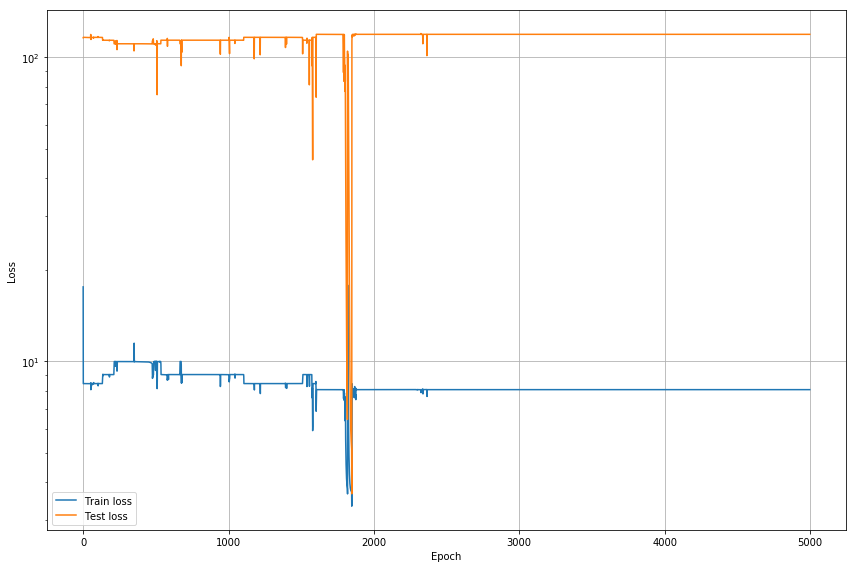

No handles with labels found to put in legend.


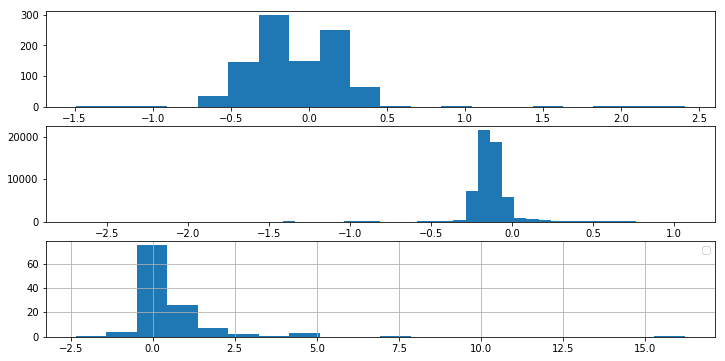

No handles with labels found to put in legend.


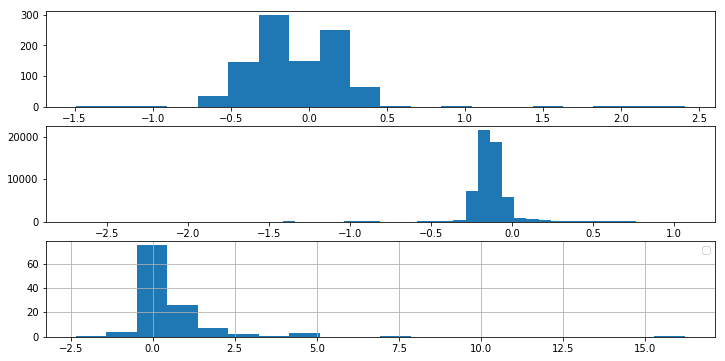

In [200]:
for i in range(0,len(Nh1_vec)):
    print('number of hidden neurons in first layer is:', int(Nh1_vec[i]), 'number of hidden neurons in second layer is:',int(Nh2_vec[i] ))
    net_try= Network(Ni, Nh1_vec[i], Nh2_vec[i], No)
    #now I train for each network
    #%% TRAINING

    num_epochs = 5000
    lr = 0.05
    en_decay = False
    lr_final = 0.005
    lr_decay = (lr_final / lr)**(1 / num_epochs)

    train_loss_log = []
    test_loss_log = []
    for num_ep in range(num_epochs):
    # Learning rate decay
        if en_decay:
            lr *= lr_decay
    # Train single epoch (sample by sample, no batch for now)
        train_loss_vec = [net_try.update(x, y, lr) for x, y in zip(x_train, y_train)]
        avg_train_loss = np.mean(train_loss_vec)
    # Test network
        y_test_est = np.array([net_try.forward(x) for x in x_test])
        avg_test_loss = np.mean((y_test_est - y_test)**2/2)
    # Log
        train_loss_log.append(avg_train_loss)
        test_loss_log.append(avg_test_loss)
        print('Epoch %d - lr: %.5f - Train loss: %.5f - Test loss: %.5f' % (num_ep + 1, lr, avg_train_loss, avg_test_loss))

        
        
        # Plot losses
    print('number of hidden neurons in first layer is:', int(Nh1_vec[i]), 'number of hidden neurons in second layer is:',int(Nh2_vec[i] ))
    
    plt.close('all')
    plt.figure(figsize=(12,8))
    plt.semilogy(train_loss_log, label='Train loss')
    plt.semilogy(test_loss_log, label='Test loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.grid()
    plt.legend()
    plt.tight_layout()# Plot losses
    plt.close('all')
    plt.figure(figsize=(12,8))
    plt.semilogy(train_loss_log, label='Train loss')
    plt.semilogy(test_loss_log, label='Test loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.grid()
    plt.legend()
    plt.tight_layout()
    plt.show()

    # Plot weights after training
    net_try.plot_weights()


    plt.show()

# Plot weights after training
    net_try.plot_weights()


# Final parameters

In [232]:
Ni = 1 
Nh1= 260
Nh2= 330
No= 1 
### Initialize network
net = Network(Ni, Nh1, Nh2, No)

No handles with labels found to put in legend.


1st hidden layer weigth matrix shape: (260, 2)
2nd hidden layer weigth matrix shape: (330, 261)
Output layer weigth matrix shape: (1, 331)


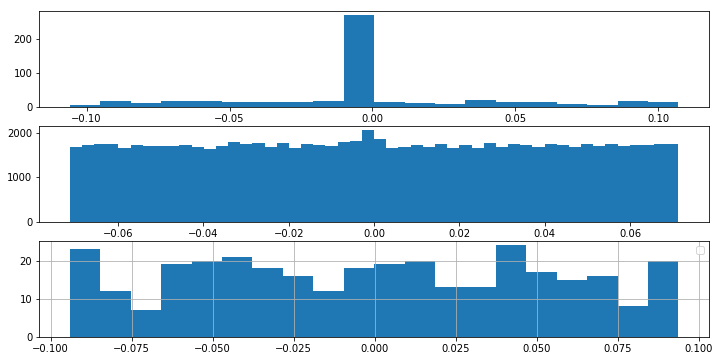

In [233]:
# Access the class members
print('1st hidden layer weigth matrix shape:', net.WBh1.shape)
print('2nd hidden layer weigth matrix shape:', net.WBh2.shape)
print('Output layer weigth matrix shape:', net.WBo.shape)

# Plot weights
plt.close('all')
net.plot_weights()


In [234]:
# Define the x vector
x_highres = np.linspace(-4, 2, 1000)

In [235]:
initial_net_output = []
for x in x_highres:
    net_out = net.forward(x)
    initial_net_output.append(net_out)
initial_net_output = np.array(initial_net_output)

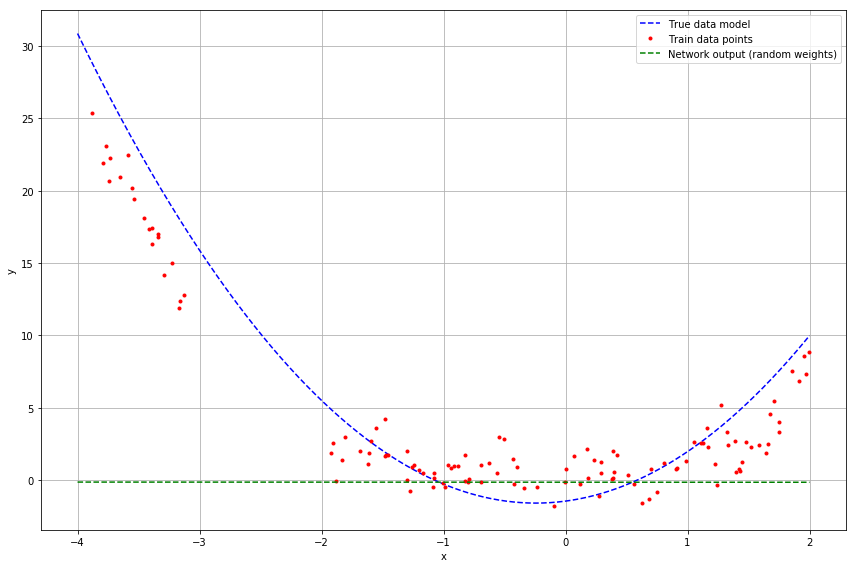

In [236]:
### Plot
plt.close('all')
plt.figure(figsize=(12,8))
x_highres = np.linspace(-4,2,1000)
plt.plot(x_highres, poly_model(x_highres, beta_true), color='b', ls='--', label='True data model')
plt.plot(x_train, y_train, color='r', ls='', marker='.', label='Train data points')
plt.plot(x_highres, initial_net_output, color='g', ls='--', label='Network output (random weights)')
plt.xlabel('x')
plt.ylabel('y')
plt.grid()
plt.legend()
plt.tight_layout()
plt.show()

#something went wrong with thw network initial output not sure why

# Training

In [208]:
#%% TRAINING

num_epochs = 20000
lr = 1e-2
en_decay = False
lr_final = 1e-5
lr_decay = (lr_final / lr)**(1 / num_epochs)

train_loss_log = []
test_loss_log = []
for num_ep in range(num_epochs):
    # Learning rate decay
    if en_decay:
        lr *= lr_decay
    # Train single epoch (sample by sample, no batch for now)
    train_loss_vec = [net.update(x, y, lr) for x, y in zip(x_train, y_train)]
    avg_train_loss = np.mean(train_loss_vec)
    # Test network
    y_test_est = np.array([net.forward(x) for x in x_test])
    avg_test_loss = np.mean((y_test_est - y_test)**2/2)
    # Log
    train_loss_log.append(avg_train_loss)
    test_loss_log.append(avg_test_loss)
    print('Epoch %d - lr: %.5f - Train loss: %.5f - Test loss: %.5f' % (num_ep + 1, lr, avg_train_loss, avg_test_loss))




Epoch 1 - lr: 0.01000 - Train loss: 7.25395 - Test loss: 152.43795
Epoch 2 - lr: 0.01000 - Train loss: 7.93365 - Test loss: 135.23752
Epoch 3 - lr: 0.01000 - Train loss: 8.38045 - Test loss: 123.72388
Epoch 4 - lr: 0.01000 - Train loss: 8.98477 - Test loss: 110.32210
Epoch 5 - lr: 0.01000 - Train loss: 9.49942 - Test loss: 93.28482
Epoch 6 - lr: 0.01000 - Train loss: 9.80629 - Test loss: 73.16684
Epoch 7 - lr: 0.01000 - Train loss: 9.73307 - Test loss: 52.49142
Epoch 8 - lr: 0.01000 - Train loss: 9.15553 - Test loss: 34.89602
Epoch 9 - lr: 0.01000 - Train loss: 8.23715 - Test loss: 22.59399
Epoch 10 - lr: 0.01000 - Train loss: 7.27520 - Test loss: 15.08122
Epoch 11 - lr: 0.01000 - Train loss: 6.43894 - Test loss: 10.72266
Epoch 12 - lr: 0.01000 - Train loss: 5.75496 - Test loss: 8.16658
Epoch 13 - lr: 0.01000 - Train loss: 5.19370 - Test loss: 6.59850
Epoch 14 - lr: 0.01000 - Train loss: 4.72400 - Test loss: 5.57935
Epoch 15 - lr: 0.01000 - Train loss: 4.32632 - Test loss: 4.87889
Epoc

Epoch 129 - lr: 0.01000 - Train loss: 1.85035 - Test loss: 2.06197
Epoch 130 - lr: 0.01000 - Train loss: 1.84685 - Test loss: 2.05747
Epoch 131 - lr: 0.01000 - Train loss: 1.84307 - Test loss: 2.05436
Epoch 132 - lr: 0.01000 - Train loss: 1.84032 - Test loss: 2.05446
Epoch 133 - lr: 0.01000 - Train loss: 1.83823 - Test loss: 2.05479
Epoch 134 - lr: 0.01000 - Train loss: 1.83620 - Test loss: 2.05450
Epoch 135 - lr: 0.01000 - Train loss: 1.83410 - Test loss: 2.05378
Epoch 136 - lr: 0.01000 - Train loss: 1.83191 - Test loss: 2.05282
Epoch 137 - lr: 0.01000 - Train loss: 1.82966 - Test loss: 2.05170
Epoch 138 - lr: 0.01000 - Train loss: 1.82734 - Test loss: 2.05045
Epoch 139 - lr: 0.01000 - Train loss: 1.82494 - Test loss: 2.04910
Epoch 140 - lr: 0.01000 - Train loss: 1.82247 - Test loss: 2.04764
Epoch 141 - lr: 0.01000 - Train loss: 1.81989 - Test loss: 2.04608
Epoch 142 - lr: 0.01000 - Train loss: 1.81719 - Test loss: 2.04440
Epoch 143 - lr: 0.01000 - Train loss: 1.81435 - Test loss: 2.0

Epoch 256 - lr: 0.01000 - Train loss: 1.04569 - Test loss: 1.26398
Epoch 257 - lr: 0.01000 - Train loss: 1.04273 - Test loss: 1.25496
Epoch 258 - lr: 0.01000 - Train loss: 1.04020 - Test loss: 1.24863
Epoch 259 - lr: 0.01000 - Train loss: 1.03820 - Test loss: 1.24221
Epoch 260 - lr: 0.01000 - Train loss: 1.03728 - Test loss: 1.23573
Epoch 261 - lr: 0.01000 - Train loss: 1.03788 - Test loss: 1.23361
Epoch 262 - lr: 0.01000 - Train loss: 1.04013 - Test loss: 1.24119
Epoch 263 - lr: 0.01000 - Train loss: 1.04251 - Test loss: 1.24541
Epoch 264 - lr: 0.01000 - Train loss: 1.04317 - Test loss: 1.24291
Epoch 265 - lr: 0.01000 - Train loss: 1.04080 - Test loss: 1.23333
Epoch 266 - lr: 0.01000 - Train loss: 1.03714 - Test loss: 1.21245
Epoch 267 - lr: 0.01000 - Train loss: 1.03436 - Test loss: 1.20316
Epoch 268 - lr: 0.01000 - Train loss: 1.02962 - Test loss: 1.19839
Epoch 269 - lr: 0.01000 - Train loss: 1.02362 - Test loss: 1.19724
Epoch 270 - lr: 0.01000 - Train loss: 1.01870 - Test loss: 1.1

Epoch 379 - lr: 0.01000 - Train loss: 0.99585 - Test loss: 1.14688
Epoch 380 - lr: 0.01000 - Train loss: 0.99558 - Test loss: 1.14729
Epoch 381 - lr: 0.01000 - Train loss: 0.99532 - Test loss: 1.14771
Epoch 382 - lr: 0.01000 - Train loss: 0.99508 - Test loss: 1.14812
Epoch 383 - lr: 0.01000 - Train loss: 0.99486 - Test loss: 1.14851
Epoch 384 - lr: 0.01000 - Train loss: 0.99465 - Test loss: 1.14887
Epoch 385 - lr: 0.01000 - Train loss: 0.99446 - Test loss: 1.14918
Epoch 386 - lr: 0.01000 - Train loss: 0.99428 - Test loss: 1.14944
Epoch 387 - lr: 0.01000 - Train loss: 0.99412 - Test loss: 1.14964
Epoch 388 - lr: 0.01000 - Train loss: 0.99396 - Test loss: 1.14978
Epoch 389 - lr: 0.01000 - Train loss: 0.99382 - Test loss: 1.14984
Epoch 390 - lr: 0.01000 - Train loss: 0.99367 - Test loss: 1.14983
Epoch 391 - lr: 0.01000 - Train loss: 0.99354 - Test loss: 1.14973
Epoch 392 - lr: 0.01000 - Train loss: 0.99341 - Test loss: 1.14955
Epoch 393 - lr: 0.01000 - Train loss: 0.99328 - Test loss: 1.1

Epoch 505 - lr: 0.01000 - Train loss: 0.98275 - Test loss: 1.10652
Epoch 506 - lr: 0.01000 - Train loss: 0.98279 - Test loss: 1.10624
Epoch 507 - lr: 0.01000 - Train loss: 0.98283 - Test loss: 1.10595
Epoch 508 - lr: 0.01000 - Train loss: 0.98288 - Test loss: 1.10567
Epoch 509 - lr: 0.01000 - Train loss: 0.98293 - Test loss: 1.10537
Epoch 510 - lr: 0.01000 - Train loss: 0.98298 - Test loss: 1.10507
Epoch 511 - lr: 0.01000 - Train loss: 0.98304 - Test loss: 1.10477
Epoch 512 - lr: 0.01000 - Train loss: 0.98311 - Test loss: 1.10447
Epoch 513 - lr: 0.01000 - Train loss: 0.98317 - Test loss: 1.10416
Epoch 514 - lr: 0.01000 - Train loss: 0.98325 - Test loss: 1.10385
Epoch 515 - lr: 0.01000 - Train loss: 0.98332 - Test loss: 1.10353
Epoch 516 - lr: 0.01000 - Train loss: 0.98340 - Test loss: 1.10322
Epoch 517 - lr: 0.01000 - Train loss: 0.98349 - Test loss: 1.10290
Epoch 518 - lr: 0.01000 - Train loss: 0.98357 - Test loss: 1.10258
Epoch 519 - lr: 0.01000 - Train loss: 0.98367 - Test loss: 1.1

Epoch 630 - lr: 0.01000 - Train loss: 0.98988 - Test loss: 1.08221
Epoch 631 - lr: 0.01000 - Train loss: 0.98983 - Test loss: 1.08209
Epoch 632 - lr: 0.01000 - Train loss: 0.98977 - Test loss: 1.08198
Epoch 633 - lr: 0.01000 - Train loss: 0.98972 - Test loss: 1.08186
Epoch 634 - lr: 0.01000 - Train loss: 0.98966 - Test loss: 1.08174
Epoch 635 - lr: 0.01000 - Train loss: 0.98959 - Test loss: 1.08163
Epoch 636 - lr: 0.01000 - Train loss: 0.98953 - Test loss: 1.08151
Epoch 637 - lr: 0.01000 - Train loss: 0.98946 - Test loss: 1.08140
Epoch 638 - lr: 0.01000 - Train loss: 0.98939 - Test loss: 1.08129
Epoch 639 - lr: 0.01000 - Train loss: 0.98931 - Test loss: 1.08118
Epoch 640 - lr: 0.01000 - Train loss: 0.98923 - Test loss: 1.08107
Epoch 641 - lr: 0.01000 - Train loss: 0.98915 - Test loss: 1.08097
Epoch 642 - lr: 0.01000 - Train loss: 0.98907 - Test loss: 1.08086
Epoch 643 - lr: 0.01000 - Train loss: 0.98899 - Test loss: 1.08076
Epoch 644 - lr: 0.01000 - Train loss: 0.98890 - Test loss: 1.0

Epoch 755 - lr: 0.01000 - Train loss: 0.98175 - Test loss: 1.06167
Epoch 756 - lr: 0.01000 - Train loss: 0.98188 - Test loss: 1.06154
Epoch 757 - lr: 0.01000 - Train loss: 0.98200 - Test loss: 1.06141
Epoch 758 - lr: 0.01000 - Train loss: 0.98210 - Test loss: 1.06129
Epoch 759 - lr: 0.01000 - Train loss: 0.98221 - Test loss: 1.06118
Epoch 760 - lr: 0.01000 - Train loss: 0.98230 - Test loss: 1.06108
Epoch 761 - lr: 0.01000 - Train loss: 0.98239 - Test loss: 1.06099
Epoch 762 - lr: 0.01000 - Train loss: 0.98247 - Test loss: 1.06090
Epoch 763 - lr: 0.01000 - Train loss: 0.98254 - Test loss: 1.06081
Epoch 764 - lr: 0.01000 - Train loss: 0.98261 - Test loss: 1.06074
Epoch 765 - lr: 0.01000 - Train loss: 0.98268 - Test loss: 1.06066
Epoch 766 - lr: 0.01000 - Train loss: 0.98274 - Test loss: 1.06059
Epoch 767 - lr: 0.01000 - Train loss: 0.98280 - Test loss: 1.06052
Epoch 768 - lr: 0.01000 - Train loss: 0.98285 - Test loss: 1.06046
Epoch 769 - lr: 0.01000 - Train loss: 0.98290 - Test loss: 1.0

Epoch 878 - lr: 0.01000 - Train loss: 0.98463 - Test loss: 1.05560
Epoch 879 - lr: 0.01000 - Train loss: 0.98463 - Test loss: 1.05557
Epoch 880 - lr: 0.01000 - Train loss: 0.98463 - Test loss: 1.05554
Epoch 881 - lr: 0.01000 - Train loss: 0.98463 - Test loss: 1.05550
Epoch 882 - lr: 0.01000 - Train loss: 0.98463 - Test loss: 1.05547
Epoch 883 - lr: 0.01000 - Train loss: 0.98463 - Test loss: 1.05544
Epoch 884 - lr: 0.01000 - Train loss: 0.98463 - Test loss: 1.05541
Epoch 885 - lr: 0.01000 - Train loss: 0.98463 - Test loss: 1.05537
Epoch 886 - lr: 0.01000 - Train loss: 0.98463 - Test loss: 1.05534
Epoch 887 - lr: 0.01000 - Train loss: 0.98463 - Test loss: 1.05531
Epoch 888 - lr: 0.01000 - Train loss: 0.98463 - Test loss: 1.05528
Epoch 889 - lr: 0.01000 - Train loss: 0.98463 - Test loss: 1.05525
Epoch 890 - lr: 0.01000 - Train loss: 0.98463 - Test loss: 1.05521
Epoch 891 - lr: 0.01000 - Train loss: 0.98463 - Test loss: 1.05518
Epoch 892 - lr: 0.01000 - Train loss: 0.98463 - Test loss: 1.0

Epoch 1003 - lr: 0.01000 - Train loss: 0.98286 - Test loss: 1.05269
Epoch 1004 - lr: 0.01000 - Train loss: 0.98283 - Test loss: 1.05268
Epoch 1005 - lr: 0.01000 - Train loss: 0.98281 - Test loss: 1.05266
Epoch 1006 - lr: 0.01000 - Train loss: 0.98278 - Test loss: 1.05264
Epoch 1007 - lr: 0.01000 - Train loss: 0.98276 - Test loss: 1.05263
Epoch 1008 - lr: 0.01000 - Train loss: 0.98274 - Test loss: 1.05261
Epoch 1009 - lr: 0.01000 - Train loss: 0.98271 - Test loss: 1.05259
Epoch 1010 - lr: 0.01000 - Train loss: 0.98269 - Test loss: 1.05258
Epoch 1011 - lr: 0.01000 - Train loss: 0.98266 - Test loss: 1.05256
Epoch 1012 - lr: 0.01000 - Train loss: 0.98264 - Test loss: 1.05254
Epoch 1013 - lr: 0.01000 - Train loss: 0.98261 - Test loss: 1.05253
Epoch 1014 - lr: 0.01000 - Train loss: 0.98259 - Test loss: 1.05251
Epoch 1015 - lr: 0.01000 - Train loss: 0.98256 - Test loss: 1.05249
Epoch 1016 - lr: 0.01000 - Train loss: 0.98254 - Test loss: 1.05248
Epoch 1017 - lr: 0.01000 - Train loss: 0.98251 -

Epoch 1124 - lr: 0.01000 - Train loss: 0.98099 - Test loss: 1.05058
Epoch 1125 - lr: 0.01000 - Train loss: 0.98099 - Test loss: 1.05056
Epoch 1126 - lr: 0.01000 - Train loss: 0.98099 - Test loss: 1.05054
Epoch 1127 - lr: 0.01000 - Train loss: 0.98099 - Test loss: 1.05052
Epoch 1128 - lr: 0.01000 - Train loss: 0.98098 - Test loss: 1.05050
Epoch 1129 - lr: 0.01000 - Train loss: 0.98098 - Test loss: 1.05048
Epoch 1130 - lr: 0.01000 - Train loss: 0.98098 - Test loss: 1.05047
Epoch 1131 - lr: 0.01000 - Train loss: 0.98098 - Test loss: 1.05045
Epoch 1132 - lr: 0.01000 - Train loss: 0.98098 - Test loss: 1.05043
Epoch 1133 - lr: 0.01000 - Train loss: 0.98098 - Test loss: 1.05041
Epoch 1134 - lr: 0.01000 - Train loss: 0.98098 - Test loss: 1.05039
Epoch 1135 - lr: 0.01000 - Train loss: 0.98098 - Test loss: 1.05037
Epoch 1136 - lr: 0.01000 - Train loss: 0.98098 - Test loss: 1.05035
Epoch 1137 - lr: 0.01000 - Train loss: 0.98098 - Test loss: 1.05034
Epoch 1138 - lr: 0.01000 - Train loss: 0.98098 -

Epoch 1246 - lr: 0.01000 - Train loss: 0.98180 - Test loss: 1.04847
Epoch 1247 - lr: 0.01000 - Train loss: 0.98181 - Test loss: 1.04845
Epoch 1248 - lr: 0.01000 - Train loss: 0.98182 - Test loss: 1.04844
Epoch 1249 - lr: 0.01000 - Train loss: 0.98184 - Test loss: 1.04842
Epoch 1250 - lr: 0.01000 - Train loss: 0.98185 - Test loss: 1.04841
Epoch 1251 - lr: 0.01000 - Train loss: 0.98186 - Test loss: 1.04839
Epoch 1252 - lr: 0.01000 - Train loss: 0.98188 - Test loss: 1.04838
Epoch 1253 - lr: 0.01000 - Train loss: 0.98189 - Test loss: 1.04836
Epoch 1254 - lr: 0.01000 - Train loss: 0.98190 - Test loss: 1.04835
Epoch 1255 - lr: 0.01000 - Train loss: 0.98192 - Test loss: 1.04833
Epoch 1256 - lr: 0.01000 - Train loss: 0.98193 - Test loss: 1.04832
Epoch 1257 - lr: 0.01000 - Train loss: 0.98195 - Test loss: 1.04830
Epoch 1258 - lr: 0.01000 - Train loss: 0.98196 - Test loss: 1.04829
Epoch 1259 - lr: 0.01000 - Train loss: 0.98197 - Test loss: 1.04827
Epoch 1260 - lr: 0.01000 - Train loss: 0.98199 -

Epoch 1371 - lr: 0.01000 - Train loss: 0.98412 - Test loss: 1.04715
Epoch 1372 - lr: 0.01000 - Train loss: 0.98414 - Test loss: 1.04715
Epoch 1373 - lr: 0.01000 - Train loss: 0.98417 - Test loss: 1.04715
Epoch 1374 - lr: 0.01000 - Train loss: 0.98419 - Test loss: 1.04714
Epoch 1375 - lr: 0.01000 - Train loss: 0.98422 - Test loss: 1.04714
Epoch 1376 - lr: 0.01000 - Train loss: 0.98425 - Test loss: 1.04714
Epoch 1377 - lr: 0.01000 - Train loss: 0.98428 - Test loss: 1.04714
Epoch 1378 - lr: 0.01000 - Train loss: 0.98430 - Test loss: 1.04714
Epoch 1379 - lr: 0.01000 - Train loss: 0.98433 - Test loss: 1.04714
Epoch 1380 - lr: 0.01000 - Train loss: 0.98436 - Test loss: 1.04714
Epoch 1381 - lr: 0.01000 - Train loss: 0.98439 - Test loss: 1.04714
Epoch 1382 - lr: 0.01000 - Train loss: 0.98442 - Test loss: 1.04714
Epoch 1383 - lr: 0.01000 - Train loss: 0.98444 - Test loss: 1.04714
Epoch 1384 - lr: 0.01000 - Train loss: 0.98447 - Test loss: 1.04714
Epoch 1385 - lr: 0.01000 - Train loss: 0.98450 -

Epoch 1496 - lr: 0.01000 - Train loss: 0.91575 - Test loss: 0.97084
Epoch 1497 - lr: 0.01000 - Train loss: 0.89136 - Test loss: 0.99249
Epoch 1498 - lr: 0.01000 - Train loss: 0.89355 - Test loss: 0.96511
Epoch 1499 - lr: 0.01000 - Train loss: 0.93653 - Test loss: 1.01016
Epoch 1500 - lr: 0.01000 - Train loss: 0.88850 - Test loss: 0.96284
Epoch 1501 - lr: 0.01000 - Train loss: 0.91120 - Test loss: 0.97058
Epoch 1502 - lr: 0.01000 - Train loss: 1.04771 - Test loss: 0.95920
Epoch 1503 - lr: 0.01000 - Train loss: 0.87305 - Test loss: 0.95994
Epoch 1504 - lr: 0.01000 - Train loss: 0.88772 - Test loss: 0.99481
Epoch 1505 - lr: 0.01000 - Train loss: 0.87813 - Test loss: 0.95721
Epoch 1506 - lr: 0.01000 - Train loss: 0.90413 - Test loss: 0.95873
Epoch 1507 - lr: 0.01000 - Train loss: 0.94223 - Test loss: 1.01306
Epoch 1508 - lr: 0.01000 - Train loss: 0.88696 - Test loss: 0.95430
Epoch 1509 - lr: 0.01000 - Train loss: 0.92019 - Test loss: 0.94756
Epoch 1510 - lr: 0.01000 - Train loss: 0.86619 -

Epoch 1619 - lr: 0.01000 - Train loss: 0.91728 - Test loss: 0.98052
Epoch 1620 - lr: 0.01000 - Train loss: 1.26693 - Test loss: 0.88424
Epoch 1621 - lr: 0.01000 - Train loss: 0.88108 - Test loss: 0.89233
Epoch 1622 - lr: 0.01000 - Train loss: 0.89522 - Test loss: 0.94147
Epoch 1623 - lr: 0.01000 - Train loss: 0.84576 - Test loss: 0.90559
Epoch 1624 - lr: 0.01000 - Train loss: 0.88472 - Test loss: 0.93088
Epoch 1625 - lr: 0.01000 - Train loss: 0.85588 - Test loss: 0.89573
Epoch 1626 - lr: 0.01000 - Train loss: 0.84619 - Test loss: 0.89097
Epoch 1627 - lr: 0.01000 - Train loss: 0.90604 - Test loss: 1.03010
Epoch 1628 - lr: 0.01000 - Train loss: 1.27054 - Test loss: 0.88976
Epoch 1629 - lr: 0.01000 - Train loss: 0.89019 - Test loss: 0.88814
Epoch 1630 - lr: 0.01000 - Train loss: 0.89567 - Test loss: 0.89278
Epoch 1631 - lr: 0.01000 - Train loss: 0.90276 - Test loss: 0.89340
Epoch 1632 - lr: 0.01000 - Train loss: 0.90320 - Test loss: 0.89285
Epoch 1633 - lr: 0.01000 - Train loss: 0.90064 -

Epoch 1744 - lr: 0.01000 - Train loss: 0.85513 - Test loss: 0.89030
Epoch 1745 - lr: 0.01000 - Train loss: 0.85409 - Test loss: 0.88902
Epoch 1746 - lr: 0.01000 - Train loss: 0.85648 - Test loss: 0.88764
Epoch 1747 - lr: 0.01000 - Train loss: 0.85504 - Test loss: 0.88664
Epoch 1748 - lr: 0.01000 - Train loss: 0.86025 - Test loss: 0.88495
Epoch 1749 - lr: 0.01000 - Train loss: 0.85354 - Test loss: 0.88463
Epoch 1750 - lr: 0.01000 - Train loss: 0.92792 - Test loss: 0.93242
Epoch 1751 - lr: 0.01000 - Train loss: 1.02988 - Test loss: 0.87587
Epoch 1752 - lr: 0.01000 - Train loss: 0.90670 - Test loss: 0.93805
Epoch 1753 - lr: 0.01000 - Train loss: 0.98516 - Test loss: 0.87868
Epoch 1754 - lr: 0.01000 - Train loss: 0.87547 - Test loss: 0.88649
Epoch 1755 - lr: 0.01000 - Train loss: 0.85799 - Test loss: 0.88612
Epoch 1756 - lr: 0.01000 - Train loss: 0.85559 - Test loss: 0.88996
Epoch 1757 - lr: 0.01000 - Train loss: 0.95269 - Test loss: 0.94268
Epoch 1758 - lr: 0.01000 - Train loss: 1.00392 -

Epoch 1869 - lr: 0.01000 - Train loss: 0.87574 - Test loss: 0.86279
Epoch 1870 - lr: 0.01000 - Train loss: 0.87644 - Test loss: 0.86252
Epoch 1871 - lr: 0.01000 - Train loss: 0.87685 - Test loss: 0.86225
Epoch 1872 - lr: 0.01000 - Train loss: 0.87763 - Test loss: 0.86209
Epoch 1873 - lr: 0.01000 - Train loss: 0.87388 - Test loss: 0.86056
Epoch 1874 - lr: 0.01000 - Train loss: 0.85701 - Test loss: 0.90013
Epoch 1875 - lr: 0.01000 - Train loss: 1.09598 - Test loss: 0.85250
Epoch 1876 - lr: 0.01000 - Train loss: 0.87036 - Test loss: 0.86509
Epoch 1877 - lr: 0.01000 - Train loss: 0.87712 - Test loss: 0.86355
Epoch 1878 - lr: 0.01000 - Train loss: 0.87321 - Test loss: 0.86202
Epoch 1879 - lr: 0.01000 - Train loss: 0.86564 - Test loss: 0.86066
Epoch 1880 - lr: 0.01000 - Train loss: 0.86604 - Test loss: 0.85998
Epoch 1881 - lr: 0.01000 - Train loss: 0.86637 - Test loss: 0.85934
Epoch 1882 - lr: 0.01000 - Train loss: 0.92541 - Test loss: 0.86030
Epoch 1883 - lr: 0.01000 - Train loss: 0.86089 -

Epoch 1992 - lr: 0.01000 - Train loss: 0.92180 - Test loss: 0.87972
Epoch 1993 - lr: 0.01000 - Train loss: 0.90822 - Test loss: 0.88465
Epoch 1994 - lr: 0.01000 - Train loss: 0.87353 - Test loss: 0.87999
Epoch 1995 - lr: 0.01000 - Train loss: 0.96151 - Test loss: 0.88020
Epoch 1996 - lr: 0.01000 - Train loss: 0.86794 - Test loss: 0.87993
Epoch 1997 - lr: 0.01000 - Train loss: 0.88071 - Test loss: 0.87885
Epoch 1998 - lr: 0.01000 - Train loss: 0.94253 - Test loss: 0.88085
Epoch 1999 - lr: 0.01000 - Train loss: 0.92598 - Test loss: 0.90338
Epoch 2000 - lr: 0.01000 - Train loss: 0.87552 - Test loss: 0.88353
Epoch 2001 - lr: 0.01000 - Train loss: 0.92401 - Test loss: 0.87853
Epoch 2002 - lr: 0.01000 - Train loss: 0.92251 - Test loss: 0.88058
Epoch 2003 - lr: 0.01000 - Train loss: 0.91614 - Test loss: 0.88601
Epoch 2004 - lr: 0.01000 - Train loss: 0.87174 - Test loss: 0.88193
Epoch 2005 - lr: 0.01000 - Train loss: 0.87304 - Test loss: 0.88021
Epoch 2006 - lr: 0.01000 - Train loss: 0.99888 -

Epoch 2117 - lr: 0.01000 - Train loss: 0.99796 - Test loss: 0.90676
Epoch 2118 - lr: 0.01000 - Train loss: 1.01214 - Test loss: 0.91212
Epoch 2119 - lr: 0.01000 - Train loss: 0.95892 - Test loss: 0.90932
Epoch 2120 - lr: 0.01000 - Train loss: 0.92341 - Test loss: 0.91336
Epoch 2121 - lr: 0.01000 - Train loss: 1.00714 - Test loss: 0.91638
Epoch 2122 - lr: 0.01000 - Train loss: 0.95399 - Test loss: 0.93163
Epoch 2123 - lr: 0.01000 - Train loss: 0.89482 - Test loss: 0.93149
Epoch 2124 - lr: 0.01000 - Train loss: 0.88763 - Test loss: 0.92941
Epoch 2125 - lr: 0.01000 - Train loss: 0.89318 - Test loss: 0.92770
Epoch 2126 - lr: 0.01000 - Train loss: 0.88364 - Test loss: 0.91982
Epoch 2127 - lr: 0.01000 - Train loss: 0.92646 - Test loss: 0.90921
Epoch 2128 - lr: 0.01000 - Train loss: 0.99583 - Test loss: 0.91370
Epoch 2129 - lr: 0.01000 - Train loss: 0.92290 - Test loss: 0.90693
Epoch 2130 - lr: 0.01000 - Train loss: 0.94895 - Test loss: 0.90035
Epoch 2131 - lr: 0.01000 - Train loss: 0.99352 -

Epoch 2240 - lr: 0.01000 - Train loss: 0.86786 - Test loss: 0.90811
Epoch 2241 - lr: 0.01000 - Train loss: 0.91886 - Test loss: 0.89907
Epoch 2242 - lr: 0.01000 - Train loss: 0.96470 - Test loss: 0.90958
Epoch 2243 - lr: 0.01000 - Train loss: 0.88553 - Test loss: 0.89308
Epoch 2244 - lr: 0.01000 - Train loss: 0.93865 - Test loss: 0.89221
Epoch 2245 - lr: 0.01000 - Train loss: 0.91255 - Test loss: 0.89553
Epoch 2246 - lr: 0.01000 - Train loss: 0.96695 - Test loss: 0.91180
Epoch 2247 - lr: 0.01000 - Train loss: 0.88043 - Test loss: 0.89385
Epoch 2248 - lr: 0.01000 - Train loss: 0.96580 - Test loss: 0.91145
Epoch 2249 - lr: 0.01000 - Train loss: 0.88061 - Test loss: 0.89399
Epoch 2250 - lr: 0.01000 - Train loss: 0.99617 - Test loss: 0.90502
Epoch 2251 - lr: 0.01000 - Train loss: 0.93835 - Test loss: 0.89953
Epoch 2252 - lr: 0.01000 - Train loss: 0.93478 - Test loss: 0.89548
Epoch 2253 - lr: 0.01000 - Train loss: 0.92705 - Test loss: 0.89777
Epoch 2254 - lr: 0.01000 - Train loss: 0.96912 -

Epoch 2365 - lr: 0.01000 - Train loss: 0.96949 - Test loss: 0.89670
Epoch 2366 - lr: 0.01000 - Train loss: 0.91000 - Test loss: 0.91864
Epoch 2367 - lr: 0.01000 - Train loss: 0.87083 - Test loss: 0.91285
Epoch 2368 - lr: 0.01000 - Train loss: 0.92071 - Test loss: 0.90449
Epoch 2369 - lr: 0.01000 - Train loss: 0.96936 - Test loss: 0.91425
Epoch 2370 - lr: 0.01000 - Train loss: 0.90298 - Test loss: 0.90138
Epoch 2371 - lr: 0.01000 - Train loss: 0.92875 - Test loss: 0.89919
Epoch 2372 - lr: 0.01000 - Train loss: 0.91135 - Test loss: 0.89930
Epoch 2373 - lr: 0.01000 - Train loss: 0.90119 - Test loss: 0.91531
Epoch 2374 - lr: 0.01000 - Train loss: 0.92162 - Test loss: 0.92845
Epoch 2375 - lr: 0.01000 - Train loss: 0.93369 - Test loss: 0.92038
Epoch 2376 - lr: 0.01000 - Train loss: 0.89393 - Test loss: 0.90655
Epoch 2377 - lr: 0.01000 - Train loss: 0.90843 - Test loss: 0.92258
Epoch 2378 - lr: 0.01000 - Train loss: 0.91488 - Test loss: 0.89531
Epoch 2379 - lr: 0.01000 - Train loss: 0.91058 -

Epoch 2487 - lr: 0.01000 - Train loss: 0.95574 - Test loss: 0.90371
Epoch 2488 - lr: 0.01000 - Train loss: 0.97427 - Test loss: 0.92087
Epoch 2489 - lr: 0.01000 - Train loss: 0.90208 - Test loss: 0.90240
Epoch 2490 - lr: 0.01000 - Train loss: 0.91733 - Test loss: 0.90517
Epoch 2491 - lr: 0.01000 - Train loss: 0.97887 - Test loss: 0.92152
Epoch 2492 - lr: 0.01000 - Train loss: 0.89018 - Test loss: 0.90464
Epoch 2493 - lr: 0.01000 - Train loss: 0.92202 - Test loss: 0.92822
Epoch 2494 - lr: 0.01000 - Train loss: 0.93376 - Test loss: 0.90497
Epoch 2495 - lr: 0.01000 - Train loss: 0.93034 - Test loss: 0.89798
Epoch 2496 - lr: 0.01000 - Train loss: 0.97681 - Test loss: 0.89842
Epoch 2497 - lr: 0.01000 - Train loss: 0.88538 - Test loss: 0.90145
Epoch 2498 - lr: 0.01000 - Train loss: 0.96987 - Test loss: 0.90168
Epoch 2499 - lr: 0.01000 - Train loss: 0.92439 - Test loss: 0.90332
Epoch 2500 - lr: 0.01000 - Train loss: 0.92370 - Test loss: 0.90417
Epoch 2501 - lr: 0.01000 - Train loss: 0.91866 -

Epoch 2612 - lr: 0.01000 - Train loss: 0.97088 - Test loss: 0.91821
Epoch 2613 - lr: 0.01000 - Train loss: 0.94657 - Test loss: 0.90053
Epoch 2614 - lr: 0.01000 - Train loss: 0.94147 - Test loss: 0.89977
Epoch 2615 - lr: 0.01000 - Train loss: 0.92372 - Test loss: 0.92516
Epoch 2616 - lr: 0.01000 - Train loss: 0.93843 - Test loss: 0.92632
Epoch 2617 - lr: 0.01000 - Train loss: 0.88029 - Test loss: 0.90259
Epoch 2618 - lr: 0.01000 - Train loss: 0.91740 - Test loss: 0.90125
Epoch 2619 - lr: 0.01000 - Train loss: 0.91367 - Test loss: 0.89737
Epoch 2620 - lr: 0.01000 - Train loss: 0.92390 - Test loss: 0.89495
Epoch 2621 - lr: 0.01000 - Train loss: 0.88467 - Test loss: 0.89635
Epoch 2622 - lr: 0.01000 - Train loss: 0.93371 - Test loss: 0.89829
Epoch 2623 - lr: 0.01000 - Train loss: 0.91895 - Test loss: 0.90302
Epoch 2624 - lr: 0.01000 - Train loss: 0.97326 - Test loss: 0.92055
Epoch 2625 - lr: 0.01000 - Train loss: 0.87925 - Test loss: 0.90495
Epoch 2626 - lr: 0.01000 - Train loss: 0.91492 -

Epoch 2737 - lr: 0.01000 - Train loss: 0.87911 - Test loss: 0.89204
Epoch 2738 - lr: 0.01000 - Train loss: 0.96751 - Test loss: 0.91435
Epoch 2739 - lr: 0.01000 - Train loss: 0.94044 - Test loss: 0.91158
Epoch 2740 - lr: 0.01000 - Train loss: 0.90229 - Test loss: 0.92234
Epoch 2741 - lr: 0.01000 - Train loss: 0.87650 - Test loss: 0.91601
Epoch 2742 - lr: 0.01000 - Train loss: 0.89046 - Test loss: 0.90537
Epoch 2743 - lr: 0.01000 - Train loss: 0.93980 - Test loss: 0.89800
Epoch 2744 - lr: 0.01000 - Train loss: 0.95466 - Test loss: 0.91168
Epoch 2745 - lr: 0.01000 - Train loss: 0.90913 - Test loss: 0.89067
Epoch 2746 - lr: 0.01000 - Train loss: 0.92864 - Test loss: 0.89552
Epoch 2747 - lr: 0.01000 - Train loss: 0.96394 - Test loss: 0.91277
Epoch 2748 - lr: 0.01000 - Train loss: 0.93643 - Test loss: 0.91947
Epoch 2749 - lr: 0.01000 - Train loss: 0.90354 - Test loss: 0.91808
Epoch 2750 - lr: 0.01000 - Train loss: 0.89366 - Test loss: 0.91347
Epoch 2751 - lr: 0.01000 - Train loss: 0.93828 -

Epoch 2862 - lr: 0.01000 - Train loss: 0.91931 - Test loss: 0.90065
Epoch 2863 - lr: 0.01000 - Train loss: 0.89414 - Test loss: 0.91850
Epoch 2864 - lr: 0.01000 - Train loss: 0.89860 - Test loss: 0.91605
Epoch 2865 - lr: 0.01000 - Train loss: 0.90353 - Test loss: 0.91081
Epoch 2866 - lr: 0.01000 - Train loss: 0.92519 - Test loss: 0.89725
Epoch 2867 - lr: 0.01000 - Train loss: 0.91454 - Test loss: 0.89147
Epoch 2868 - lr: 0.01000 - Train loss: 0.89222 - Test loss: 0.88972
Epoch 2869 - lr: 0.01000 - Train loss: 0.96786 - Test loss: 0.88721
Epoch 2870 - lr: 0.01000 - Train loss: 0.92057 - Test loss: 0.90954
Epoch 2871 - lr: 0.01000 - Train loss: 0.87228 - Test loss: 0.89807
Epoch 2872 - lr: 0.01000 - Train loss: 0.88513 - Test loss: 0.89187
Epoch 2873 - lr: 0.01000 - Train loss: 0.95038 - Test loss: 0.89496
Epoch 2874 - lr: 0.01000 - Train loss: 0.92364 - Test loss: 0.89752
Epoch 2875 - lr: 0.01000 - Train loss: 0.97770 - Test loss: 0.91554
Epoch 2876 - lr: 0.01000 - Train loss: 0.90732 -

Epoch 2986 - lr: 0.01000 - Train loss: 0.91604 - Test loss: 0.90307
Epoch 2987 - lr: 0.01000 - Train loss: 0.92911 - Test loss: 0.89822
Epoch 2988 - lr: 0.01000 - Train loss: 0.91651 - Test loss: 0.92392
Epoch 2989 - lr: 0.01000 - Train loss: 0.92089 - Test loss: 0.92685
Epoch 2990 - lr: 0.01000 - Train loss: 0.91841 - Test loss: 0.90348
Epoch 2991 - lr: 0.01000 - Train loss: 0.97073 - Test loss: 0.89224
Epoch 2992 - lr: 0.01000 - Train loss: 0.87615 - Test loss: 0.89372
Epoch 2993 - lr: 0.01000 - Train loss: 1.02144 - Test loss: 0.89793
Epoch 2994 - lr: 0.01000 - Train loss: 0.92598 - Test loss: 0.90070
Epoch 2995 - lr: 0.01000 - Train loss: 0.97087 - Test loss: 0.90914
Epoch 2996 - lr: 0.01000 - Train loss: 0.90338 - Test loss: 0.90104
Epoch 2997 - lr: 0.01000 - Train loss: 0.91536 - Test loss: 0.90462
Epoch 2998 - lr: 0.01000 - Train loss: 0.97272 - Test loss: 0.92363
Epoch 2999 - lr: 0.01000 - Train loss: 0.92940 - Test loss: 0.93177
Epoch 3000 - lr: 0.01000 - Train loss: 0.91541 -

Epoch 3108 - lr: 0.01000 - Train loss: 0.91254 - Test loss: 0.90387
Epoch 3109 - lr: 0.01000 - Train loss: 0.92205 - Test loss: 0.89543
Epoch 3110 - lr: 0.01000 - Train loss: 0.92652 - Test loss: 0.92146
Epoch 3111 - lr: 0.01000 - Train loss: 0.91020 - Test loss: 0.90155
Epoch 3112 - lr: 0.01000 - Train loss: 0.92440 - Test loss: 0.89287
Epoch 3113 - lr: 0.01000 - Train loss: 0.92575 - Test loss: 0.92013
Epoch 3114 - lr: 0.01000 - Train loss: 0.90722 - Test loss: 0.90043
Epoch 3115 - lr: 0.01000 - Train loss: 0.97284 - Test loss: 0.88949
Epoch 3116 - lr: 0.01000 - Train loss: 0.88249 - Test loss: 0.91107
Epoch 3117 - lr: 0.01000 - Train loss: 0.93636 - Test loss: 0.90559
Epoch 3118 - lr: 0.01000 - Train loss: 0.89963 - Test loss: 0.91413
Epoch 3119 - lr: 0.01000 - Train loss: 0.92670 - Test loss: 0.90087
Epoch 3120 - lr: 0.01000 - Train loss: 0.94419 - Test loss: 0.89323
Epoch 3121 - lr: 0.01000 - Train loss: 0.89912 - Test loss: 0.90883
Epoch 3122 - lr: 0.01000 - Train loss: 0.92182 -

Epoch 3233 - lr: 0.01000 - Train loss: 0.93456 - Test loss: 0.91294
Epoch 3234 - lr: 0.01000 - Train loss: 0.90111 - Test loss: 0.91269
Epoch 3235 - lr: 0.01000 - Train loss: 0.92218 - Test loss: 0.89853
Epoch 3236 - lr: 0.01000 - Train loss: 1.02406 - Test loss: 0.89241
Epoch 3237 - lr: 0.01000 - Train loss: 0.94189 - Test loss: 0.89318
Epoch 3238 - lr: 0.01000 - Train loss: 0.88833 - Test loss: 0.89039
Epoch 3239 - lr: 0.01000 - Train loss: 0.91309 - Test loss: 0.89204
Epoch 3240 - lr: 0.01000 - Train loss: 0.88738 - Test loss: 0.89114
Epoch 3241 - lr: 0.01000 - Train loss: 0.97167 - Test loss: 0.91377
Epoch 3242 - lr: 0.01000 - Train loss: 0.92734 - Test loss: 0.90510
Epoch 3243 - lr: 0.01000 - Train loss: 0.96053 - Test loss: 0.92156
Epoch 3244 - lr: 0.01000 - Train loss: 0.93162 - Test loss: 0.92295
Epoch 3245 - lr: 0.01000 - Train loss: 0.90126 - Test loss: 0.92506
Epoch 3246 - lr: 0.01000 - Train loss: 0.92148 - Test loss: 0.90004
Epoch 3247 - lr: 0.01000 - Train loss: 0.92105 -

Epoch 3358 - lr: 0.01000 - Train loss: 0.89770 - Test loss: 0.90993
Epoch 3359 - lr: 0.01000 - Train loss: 0.92305 - Test loss: 0.93328
Epoch 3360 - lr: 0.01000 - Train loss: 0.93468 - Test loss: 0.91855
Epoch 3361 - lr: 0.01000 - Train loss: 0.89480 - Test loss: 0.92513
Epoch 3362 - lr: 0.01000 - Train loss: 0.91844 - Test loss: 0.93117
Epoch 3363 - lr: 0.01000 - Train loss: 0.92696 - Test loss: 0.92232
Epoch 3364 - lr: 0.01000 - Train loss: 0.89092 - Test loss: 0.92309
Epoch 3365 - lr: 0.01000 - Train loss: 0.92316 - Test loss: 0.92782
Epoch 3366 - lr: 0.01000 - Train loss: 0.90222 - Test loss: 0.92473
Epoch 3367 - lr: 0.01000 - Train loss: 0.88007 - Test loss: 0.91992
Epoch 3368 - lr: 0.01000 - Train loss: 0.87559 - Test loss: 0.89931
Epoch 3369 - lr: 0.01000 - Train loss: 0.89588 - Test loss: 0.90924
Epoch 3370 - lr: 0.01000 - Train loss: 0.91210 - Test loss: 0.89752
Epoch 3371 - lr: 0.01000 - Train loss: 0.98228 - Test loss: 0.89746
Epoch 3372 - lr: 0.01000 - Train loss: 0.97593 -

Epoch 3483 - lr: 0.01000 - Train loss: 0.91846 - Test loss: 0.92418
Epoch 3484 - lr: 0.01000 - Train loss: 0.92540 - Test loss: 0.90647
Epoch 3485 - lr: 0.01000 - Train loss: 0.96441 - Test loss: 0.89689
Epoch 3486 - lr: 0.01000 - Train loss: 0.88010 - Test loss: 0.89549
Epoch 3487 - lr: 0.01000 - Train loss: 1.01306 - Test loss: 0.89999
Epoch 3488 - lr: 0.01000 - Train loss: 0.95296 - Test loss: 0.89859
Epoch 3489 - lr: 0.01000 - Train loss: 0.97600 - Test loss: 0.91077
Epoch 3490 - lr: 0.01000 - Train loss: 0.92174 - Test loss: 0.92830
Epoch 3491 - lr: 0.01000 - Train loss: 0.92360 - Test loss: 0.90910
Epoch 3492 - lr: 0.01000 - Train loss: 0.97310 - Test loss: 0.92239
Epoch 3493 - lr: 0.01000 - Train loss: 0.87495 - Test loss: 0.90593
Epoch 3494 - lr: 0.01000 - Train loss: 0.92913 - Test loss: 0.91507
Epoch 3495 - lr: 0.01000 - Train loss: 0.88817 - Test loss: 0.90191
Epoch 3496 - lr: 0.01000 - Train loss: 0.91913 - Test loss: 0.92701
Epoch 3497 - lr: 0.01000 - Train loss: 0.91406 -

Epoch 3607 - lr: 0.01000 - Train loss: 0.91449 - Test loss: 0.90600
Epoch 3608 - lr: 0.01000 - Train loss: 0.87912 - Test loss: 0.91548
Epoch 3609 - lr: 0.01000 - Train loss: 0.89668 - Test loss: 0.93014
Epoch 3610 - lr: 0.01000 - Train loss: 0.90097 - Test loss: 0.92577
Epoch 3611 - lr: 0.01000 - Train loss: 0.90810 - Test loss: 0.90381
Epoch 3612 - lr: 0.01000 - Train loss: 0.91616 - Test loss: 0.90584
Epoch 3613 - lr: 0.01000 - Train loss: 0.94250 - Test loss: 0.90020
Epoch 3614 - lr: 0.01000 - Train loss: 0.89666 - Test loss: 0.91727
Epoch 3615 - lr: 0.01000 - Train loss: 0.91938 - Test loss: 0.93181
Epoch 3616 - lr: 0.01000 - Train loss: 0.91564 - Test loss: 0.90809
Epoch 3617 - lr: 0.01000 - Train loss: 0.95630 - Test loss: 0.89709
Epoch 3618 - lr: 0.01000 - Train loss: 0.91995 - Test loss: 0.89790
Epoch 3619 - lr: 0.01000 - Train loss: 0.88315 - Test loss: 0.89948
Epoch 3620 - lr: 0.01000 - Train loss: 0.93303 - Test loss: 0.90156
Epoch 3621 - lr: 0.01000 - Train loss: 0.92157 -

Epoch 3728 - lr: 0.01000 - Train loss: 0.91091 - Test loss: 0.89655
Epoch 3729 - lr: 0.01000 - Train loss: 0.89181 - Test loss: 0.89952
Epoch 3730 - lr: 0.01000 - Train loss: 0.89959 - Test loss: 0.92063
Epoch 3731 - lr: 0.01000 - Train loss: 0.89126 - Test loss: 0.92087
Epoch 3732 - lr: 0.01000 - Train loss: 0.91710 - Test loss: 0.90274
Epoch 3733 - lr: 0.01000 - Train loss: 0.96575 - Test loss: 0.89581
Epoch 3734 - lr: 0.01000 - Train loss: 0.97610 - Test loss: 0.91551
Epoch 3735 - lr: 0.01000 - Train loss: 0.91787 - Test loss: 0.90266
Epoch 3736 - lr: 0.01000 - Train loss: 1.01414 - Test loss: 0.89978
Epoch 3737 - lr: 0.01000 - Train loss: 1.00056 - Test loss: 0.91702
Epoch 3738 - lr: 0.01000 - Train loss: 0.89081 - Test loss: 0.92145
Epoch 3739 - lr: 0.01000 - Train loss: 0.92360 - Test loss: 0.90646
Epoch 3740 - lr: 0.01000 - Train loss: 1.00835 - Test loss: 0.89954
Epoch 3741 - lr: 0.01000 - Train loss: 0.97706 - Test loss: 0.91982
Epoch 3742 - lr: 0.01000 - Train loss: 0.92851 -

Epoch 3849 - lr: 0.01000 - Train loss: 0.93669 - Test loss: 0.91326
Epoch 3850 - lr: 0.01000 - Train loss: 0.89671 - Test loss: 0.92132
Epoch 3851 - lr: 0.01000 - Train loss: 0.91035 - Test loss: 0.90179
Epoch 3852 - lr: 0.01000 - Train loss: 0.93943 - Test loss: 0.91361
Epoch 3853 - lr: 0.01000 - Train loss: 0.89927 - Test loss: 0.92635
Epoch 3854 - lr: 0.01000 - Train loss: 0.89773 - Test loss: 0.92197
Epoch 3855 - lr: 0.01000 - Train loss: 0.90948 - Test loss: 0.89960
Epoch 3856 - lr: 0.01000 - Train loss: 0.93373 - Test loss: 0.90393
Epoch 3857 - lr: 0.01000 - Train loss: 0.90933 - Test loss: 0.89909
Epoch 3858 - lr: 0.01000 - Train loss: 0.93374 - Test loss: 0.91136
Epoch 3859 - lr: 0.01000 - Train loss: 0.90339 - Test loss: 0.91640
Epoch 3860 - lr: 0.01000 - Train loss: 0.91944 - Test loss: 0.90430
Epoch 3861 - lr: 0.01000 - Train loss: 1.01066 - Test loss: 0.89861
Epoch 3862 - lr: 0.01000 - Train loss: 0.91155 - Test loss: 0.89781
Epoch 3863 - lr: 0.01000 - Train loss: 0.93161 -

Epoch 3970 - lr: 0.01000 - Train loss: 0.96147 - Test loss: 0.90214
Epoch 3971 - lr: 0.01000 - Train loss: 0.93860 - Test loss: 0.89825
Epoch 3972 - lr: 0.01000 - Train loss: 0.90887 - Test loss: 0.92318
Epoch 3973 - lr: 0.01000 - Train loss: 0.88214 - Test loss: 0.90149
Epoch 3974 - lr: 0.01000 - Train loss: 0.93690 - Test loss: 0.90629
Epoch 3975 - lr: 0.01000 - Train loss: 0.97856 - Test loss: 0.90221
Epoch 3976 - lr: 0.01000 - Train loss: 0.97727 - Test loss: 0.90846
Epoch 3977 - lr: 0.01000 - Train loss: 0.90674 - Test loss: 0.92589
Epoch 3978 - lr: 0.01000 - Train loss: 0.91284 - Test loss: 0.89831
Epoch 3979 - lr: 0.01000 - Train loss: 0.87815 - Test loss: 0.89974
Epoch 3980 - lr: 0.01000 - Train loss: 0.90961 - Test loss: 0.90086
Epoch 3981 - lr: 0.01000 - Train loss: 0.96304 - Test loss: 0.89417
Epoch 3982 - lr: 0.01000 - Train loss: 0.88674 - Test loss: 0.89645
Epoch 3983 - lr: 0.01000 - Train loss: 0.95730 - Test loss: 0.89588
Epoch 3984 - lr: 0.01000 - Train loss: 0.88036 -

Epoch 4094 - lr: 0.01000 - Train loss: 0.88058 - Test loss: 0.91656
Epoch 4095 - lr: 0.01000 - Train loss: 0.87567 - Test loss: 0.89840
Epoch 4096 - lr: 0.01000 - Train loss: 0.90522 - Test loss: 0.89605
Epoch 4097 - lr: 0.01000 - Train loss: 0.95494 - Test loss: 0.89095
Epoch 4098 - lr: 0.01000 - Train loss: 0.97191 - Test loss: 0.91246
Epoch 4099 - lr: 0.01000 - Train loss: 0.92918 - Test loss: 0.92107
Epoch 4100 - lr: 0.01000 - Train loss: 0.90320 - Test loss: 0.92084
Epoch 4101 - lr: 0.01000 - Train loss: 0.89236 - Test loss: 0.91660
Epoch 4102 - lr: 0.01000 - Train loss: 0.92548 - Test loss: 0.91918
Epoch 4103 - lr: 0.01000 - Train loss: 0.93272 - Test loss: 0.91759
Epoch 4104 - lr: 0.01000 - Train loss: 0.90186 - Test loss: 0.89316
Epoch 4105 - lr: 0.01000 - Train loss: 0.92349 - Test loss: 0.90102
Epoch 4106 - lr: 0.01000 - Train loss: 0.91807 - Test loss: 0.91484
Epoch 4107 - lr: 0.01000 - Train loss: 0.92509 - Test loss: 0.90622
Epoch 4108 - lr: 0.01000 - Train loss: 0.92348 -

Epoch 4215 - lr: 0.01000 - Train loss: 0.93491 - Test loss: 0.91648
Epoch 4216 - lr: 0.01000 - Train loss: 0.91214 - Test loss: 0.92894
Epoch 4217 - lr: 0.01000 - Train loss: 0.89875 - Test loss: 0.92377
Epoch 4218 - lr: 0.01000 - Train loss: 0.89435 - Test loss: 0.91920
Epoch 4219 - lr: 0.01000 - Train loss: 0.92864 - Test loss: 0.92255
Epoch 4220 - lr: 0.01000 - Train loss: 0.92690 - Test loss: 0.92248
Epoch 4221 - lr: 0.01000 - Train loss: 0.93114 - Test loss: 0.91934
Epoch 4222 - lr: 0.01000 - Train loss: 0.90915 - Test loss: 0.91496
Epoch 4223 - lr: 0.01000 - Train loss: 0.88920 - Test loss: 0.89457
Epoch 4224 - lr: 0.01000 - Train loss: 0.91838 - Test loss: 0.89476
Epoch 4225 - lr: 0.01000 - Train loss: 0.96003 - Test loss: 0.89326
Epoch 4226 - lr: 0.01000 - Train loss: 0.91949 - Test loss: 0.89568
Epoch 4227 - lr: 0.01000 - Train loss: 0.96560 - Test loss: 0.89390
Epoch 4228 - lr: 0.01000 - Train loss: 0.93658 - Test loss: 0.90157
Epoch 4229 - lr: 0.01000 - Train loss: 0.97525 -

Epoch 4337 - lr: 0.01000 - Train loss: 0.92524 - Test loss: 0.88712
Epoch 4338 - lr: 0.01000 - Train loss: 0.92539 - Test loss: 0.88692
Epoch 4339 - lr: 0.01000 - Train loss: 0.92520 - Test loss: 0.88670
Epoch 4340 - lr: 0.01000 - Train loss: 0.92575 - Test loss: 0.88652
Epoch 4341 - lr: 0.01000 - Train loss: 0.92433 - Test loss: 0.88599
Epoch 4342 - lr: 0.01000 - Train loss: 0.92738 - Test loss: 0.88522
Epoch 4343 - lr: 0.01000 - Train loss: 0.92593 - Test loss: 0.88527
Epoch 4344 - lr: 0.01000 - Train loss: 0.92742 - Test loss: 0.88525
Epoch 4345 - lr: 0.01000 - Train loss: 0.92738 - Test loss: 0.88507
Epoch 4346 - lr: 0.01000 - Train loss: 0.92712 - Test loss: 0.88490
Epoch 4347 - lr: 0.01000 - Train loss: 0.92681 - Test loss: 0.88483
Epoch 4348 - lr: 0.01000 - Train loss: 0.92684 - Test loss: 0.88480
Epoch 4349 - lr: 0.01000 - Train loss: 0.92681 - Test loss: 0.88478
Epoch 4350 - lr: 0.01000 - Train loss: 0.92675 - Test loss: 0.88479
Epoch 4351 - lr: 0.01000 - Train loss: 0.92650 -

Epoch 4462 - lr: 0.01000 - Train loss: 0.91616 - Test loss: 0.91590
Epoch 4463 - lr: 0.01000 - Train loss: 0.89749 - Test loss: 0.91836
Epoch 4464 - lr: 0.01000 - Train loss: 0.92754 - Test loss: 0.88567
Epoch 4465 - lr: 0.01000 - Train loss: 0.93160 - Test loss: 0.88187
Epoch 4466 - lr: 0.01000 - Train loss: 0.89345 - Test loss: 0.90529
Epoch 4467 - lr: 0.01000 - Train loss: 0.93158 - Test loss: 0.91918
Epoch 4468 - lr: 0.01000 - Train loss: 0.92115 - Test loss: 0.90969
Epoch 4469 - lr: 0.01000 - Train loss: 0.85374 - Test loss: 0.88892
Epoch 4470 - lr: 0.01000 - Train loss: 0.83425 - Test loss: 0.88523
Epoch 4471 - lr: 0.01000 - Train loss: 0.85775 - Test loss: 0.88344
Epoch 4472 - lr: 0.01000 - Train loss: 0.93461 - Test loss: 0.90962
Epoch 4473 - lr: 0.01000 - Train loss: 0.91721 - Test loss: 0.88625
Epoch 4474 - lr: 0.01000 - Train loss: 0.91137 - Test loss: 0.91416
Epoch 4475 - lr: 0.01000 - Train loss: 0.90131 - Test loss: 0.91844
Epoch 4476 - lr: 0.01000 - Train loss: 0.92507 -

Epoch 4587 - lr: 0.01000 - Train loss: 0.92015 - Test loss: 0.89739
Epoch 4588 - lr: 0.01000 - Train loss: 0.97212 - Test loss: 0.87928
Epoch 4589 - lr: 0.01000 - Train loss: 1.00051 - Test loss: 0.90033
Epoch 4590 - lr: 0.01000 - Train loss: 0.93317 - Test loss: 0.91176
Epoch 4591 - lr: 0.01000 - Train loss: 0.88942 - Test loss: 0.91370
Epoch 4592 - lr: 0.01000 - Train loss: 0.90995 - Test loss: 0.91498
Epoch 4593 - lr: 0.01000 - Train loss: 0.90780 - Test loss: 0.90610
Epoch 4594 - lr: 0.01000 - Train loss: 0.95743 - Test loss: 0.88166
Epoch 4595 - lr: 0.01000 - Train loss: 0.93641 - Test loss: 0.90385
Epoch 4596 - lr: 0.01000 - Train loss: 0.91576 - Test loss: 0.91145
Epoch 4597 - lr: 0.01000 - Train loss: 0.90359 - Test loss: 0.90547
Epoch 4598 - lr: 0.01000 - Train loss: 0.84039 - Test loss: 0.87885
Epoch 4599 - lr: 0.01000 - Train loss: 0.90724 - Test loss: 0.87142
Epoch 4600 - lr: 0.01000 - Train loss: 0.83631 - Test loss: 0.87446
Epoch 4601 - lr: 0.01000 - Train loss: 0.83744 -

Epoch 4708 - lr: 0.01000 - Train loss: 0.92874 - Test loss: 0.90810
Epoch 4709 - lr: 0.01000 - Train loss: 0.91216 - Test loss: 0.89623
Epoch 4710 - lr: 0.01000 - Train loss: 0.94431 - Test loss: 0.88931
Epoch 4711 - lr: 0.01000 - Train loss: 0.96649 - Test loss: 0.89037
Epoch 4712 - lr: 0.01000 - Train loss: 0.99910 - Test loss: 0.88867
Epoch 4713 - lr: 0.01000 - Train loss: 0.92266 - Test loss: 0.89095
Epoch 4714 - lr: 0.01000 - Train loss: 0.99691 - Test loss: 0.89271
Epoch 4715 - lr: 0.01000 - Train loss: 0.99448 - Test loss: 0.90687
Epoch 4716 - lr: 0.01000 - Train loss: 0.97515 - Test loss: 0.92455
Epoch 4717 - lr: 0.01000 - Train loss: 0.86629 - Test loss: 0.90154
Epoch 4718 - lr: 0.01000 - Train loss: 0.94681 - Test loss: 0.91396
Epoch 4719 - lr: 0.01000 - Train loss: 0.95229 - Test loss: 0.91559
Epoch 4720 - lr: 0.01000 - Train loss: 0.92848 - Test loss: 0.93082
Epoch 4721 - lr: 0.01000 - Train loss: 0.92804 - Test loss: 0.93089
Epoch 4722 - lr: 0.01000 - Train loss: 0.92244 -

Epoch 4833 - lr: 0.01000 - Train loss: 0.91015 - Test loss: 0.89775
Epoch 4834 - lr: 0.01000 - Train loss: 0.90794 - Test loss: 0.92429
Epoch 4835 - lr: 0.01000 - Train loss: 0.93593 - Test loss: 0.91504
Epoch 4836 - lr: 0.01000 - Train loss: 0.94094 - Test loss: 0.91177
Epoch 4837 - lr: 0.01000 - Train loss: 0.93955 - Test loss: 0.91078
Epoch 4838 - lr: 0.01000 - Train loss: 0.94378 - Test loss: 0.90944
Epoch 4839 - lr: 0.01000 - Train loss: 0.93741 - Test loss: 0.90925
Epoch 4840 - lr: 0.01000 - Train loss: 0.94909 - Test loss: 0.90721
Epoch 4841 - lr: 0.01000 - Train loss: 0.95135 - Test loss: 0.90609
Epoch 4842 - lr: 0.01000 - Train loss: 0.94812 - Test loss: 0.90573
Epoch 4843 - lr: 0.01000 - Train loss: 0.95221 - Test loss: 0.90496
Epoch 4844 - lr: 0.01000 - Train loss: 0.94836 - Test loss: 0.90473
Epoch 4845 - lr: 0.01000 - Train loss: 0.95288 - Test loss: 0.90399
Epoch 4846 - lr: 0.01000 - Train loss: 0.94841 - Test loss: 0.90385
Epoch 4847 - lr: 0.01000 - Train loss: 0.95288 -

Epoch 4958 - lr: 0.01000 - Train loss: 0.94007 - Test loss: 0.91693
Epoch 4959 - lr: 0.01000 - Train loss: 0.95713 - Test loss: 0.90593
Epoch 4960 - lr: 0.01000 - Train loss: 0.99185 - Test loss: 0.90105
Epoch 4961 - lr: 0.01000 - Train loss: 0.99945 - Test loss: 0.91404
Epoch 4962 - lr: 0.01000 - Train loss: 0.97980 - Test loss: 0.93569
Epoch 4963 - lr: 0.01000 - Train loss: 0.92537 - Test loss: 0.92193
Epoch 4964 - lr: 0.01000 - Train loss: 0.88760 - Test loss: 0.90840
Epoch 4965 - lr: 0.01000 - Train loss: 0.91161 - Test loss: 0.93346
Epoch 4966 - lr: 0.01000 - Train loss: 0.95000 - Test loss: 0.92207
Epoch 4967 - lr: 0.01000 - Train loss: 0.92778 - Test loss: 0.93121
Epoch 4968 - lr: 0.01000 - Train loss: 0.85836 - Test loss: 0.90396
Epoch 4969 - lr: 0.01000 - Train loss: 0.93039 - Test loss: 0.90842
Epoch 4970 - lr: 0.01000 - Train loss: 0.92610 - Test loss: 0.90383
Epoch 4971 - lr: 0.01000 - Train loss: 0.92018 - Test loss: 0.89931
Epoch 4972 - lr: 0.01000 - Train loss: 0.87100 -

Epoch 5079 - lr: 0.01000 - Train loss: 0.93981 - Test loss: 0.90553
Epoch 5080 - lr: 0.01000 - Train loss: 0.94675 - Test loss: 0.90494
Epoch 5081 - lr: 0.01000 - Train loss: 0.94900 - Test loss: 0.90414
Epoch 5082 - lr: 0.01000 - Train loss: 0.95371 - Test loss: 0.90305
Epoch 5083 - lr: 0.01000 - Train loss: 0.94622 - Test loss: 0.90307
Epoch 5084 - lr: 0.01000 - Train loss: 0.95280 - Test loss: 0.90235
Epoch 5085 - lr: 0.01000 - Train loss: 0.95476 - Test loss: 0.90153
Epoch 5086 - lr: 0.01000 - Train loss: 0.92563 - Test loss: 0.90394
Epoch 5087 - lr: 0.01000 - Train loss: 0.89456 - Test loss: 0.91695
Epoch 5088 - lr: 0.01000 - Train loss: 0.92201 - Test loss: 0.91336
Epoch 5089 - lr: 0.01000 - Train loss: 0.88893 - Test loss: 0.88269
Epoch 5090 - lr: 0.01000 - Train loss: 0.89990 - Test loss: 0.91081
Epoch 5091 - lr: 0.01000 - Train loss: 0.94058 - Test loss: 0.90215
Epoch 5092 - lr: 0.01000 - Train loss: 0.92579 - Test loss: 0.90221
Epoch 5093 - lr: 0.01000 - Train loss: 0.91826 -

Epoch 5201 - lr: 0.01000 - Train loss: 0.92874 - Test loss: 0.93866
Epoch 5202 - lr: 0.01000 - Train loss: 0.88417 - Test loss: 0.90924
Epoch 5203 - lr: 0.01000 - Train loss: 0.92577 - Test loss: 0.93502
Epoch 5204 - lr: 0.01000 - Train loss: 0.92844 - Test loss: 0.92693
Epoch 5205 - lr: 0.01000 - Train loss: 0.92909 - Test loss: 0.91364
Epoch 5206 - lr: 0.01000 - Train loss: 0.97337 - Test loss: 0.92456
Epoch 5207 - lr: 0.01000 - Train loss: 0.86210 - Test loss: 0.90585
Epoch 5208 - lr: 0.01000 - Train loss: 0.91829 - Test loss: 0.90959
Epoch 5209 - lr: 0.01000 - Train loss: 0.92312 - Test loss: 0.90636
Epoch 5210 - lr: 0.01000 - Train loss: 0.85990 - Test loss: 0.90403
Epoch 5211 - lr: 0.01000 - Train loss: 0.91010 - Test loss: 0.92730
Epoch 5212 - lr: 0.01000 - Train loss: 0.91296 - Test loss: 0.90394
Epoch 5213 - lr: 0.01000 - Train loss: 0.84731 - Test loss: 0.90228
Epoch 5214 - lr: 0.01000 - Train loss: 0.91970 - Test loss: 0.90927
Epoch 5215 - lr: 0.01000 - Train loss: 0.94504 -

Epoch 5324 - lr: 0.01000 - Train loss: 0.89907 - Test loss: 0.88065
Epoch 5325 - lr: 0.01000 - Train loss: 0.83332 - Test loss: 0.88312
Epoch 5326 - lr: 0.01000 - Train loss: 0.89195 - Test loss: 0.90441
Epoch 5327 - lr: 0.01000 - Train loss: 0.93001 - Test loss: 0.91481
Epoch 5328 - lr: 0.01000 - Train loss: 0.87297 - Test loss: 0.89070
Epoch 5329 - lr: 0.01000 - Train loss: 0.87945 - Test loss: 0.88520
Epoch 5330 - lr: 0.01000 - Train loss: 0.92726 - Test loss: 0.88785
Epoch 5331 - lr: 0.01000 - Train loss: 1.02485 - Test loss: 0.88881
Epoch 5332 - lr: 0.01000 - Train loss: 0.98070 - Test loss: 0.89629
Epoch 5333 - lr: 0.01000 - Train loss: 1.00725 - Test loss: 0.91142
Epoch 5334 - lr: 0.01000 - Train loss: 0.86978 - Test loss: 0.89512
Epoch 5335 - lr: 0.01000 - Train loss: 0.90473 - Test loss: 0.90983
Epoch 5336 - lr: 0.01000 - Train loss: 0.92737 - Test loss: 0.91755
Epoch 5337 - lr: 0.01000 - Train loss: 0.89160 - Test loss: 0.88978
Epoch 5338 - lr: 0.01000 - Train loss: 0.88922 -

Epoch 5446 - lr: 0.01000 - Train loss: 0.92874 - Test loss: 0.85965
Epoch 5447 - lr: 0.01000 - Train loss: 1.06119 - Test loss: 0.85165
Epoch 5448 - lr: 0.01000 - Train loss: 0.85841 - Test loss: 0.87009
Epoch 5449 - lr: 0.01000 - Train loss: 0.96398 - Test loss: 0.85487
Epoch 5450 - lr: 0.01000 - Train loss: 1.04124 - Test loss: 0.85384
Epoch 5451 - lr: 0.01000 - Train loss: 0.97051 - Test loss: 0.87773
Epoch 5452 - lr: 0.01000 - Train loss: 0.92036 - Test loss: 0.88593
Epoch 5453 - lr: 0.01000 - Train loss: 0.92283 - Test loss: 0.87167
Epoch 5454 - lr: 0.01000 - Train loss: 0.91061 - Test loss: 0.88709
Epoch 5455 - lr: 0.01000 - Train loss: 0.84151 - Test loss: 0.86543
Epoch 5456 - lr: 0.01000 - Train loss: 0.91478 - Test loss: 0.86517
Epoch 5457 - lr: 0.01000 - Train loss: 1.01515 - Test loss: 0.89196
Epoch 5458 - lr: 0.01000 - Train loss: 0.95803 - Test loss: 0.87288
Epoch 5459 - lr: 0.01000 - Train loss: 1.00126 - Test loss: 0.87055
Epoch 5460 - lr: 0.01000 - Train loss: 1.01994 -

Epoch 5571 - lr: 0.01000 - Train loss: 0.93447 - Test loss: 0.91816
Epoch 5572 - lr: 0.01000 - Train loss: 0.92685 - Test loss: 0.92248
Epoch 5573 - lr: 0.01000 - Train loss: 0.91267 - Test loss: 0.89360
Epoch 5574 - lr: 0.01000 - Train loss: 0.93716 - Test loss: 0.90662
Epoch 5575 - lr: 0.01000 - Train loss: 0.92055 - Test loss: 0.91312
Epoch 5576 - lr: 0.01000 - Train loss: 0.84079 - Test loss: 0.89331
Epoch 5577 - lr: 0.01000 - Train loss: 0.88227 - Test loss: 0.89260
Epoch 5578 - lr: 0.01000 - Train loss: 0.91828 - Test loss: 0.91890
Epoch 5579 - lr: 0.01000 - Train loss: 0.92797 - Test loss: 0.92447
Epoch 5580 - lr: 0.01000 - Train loss: 0.92945 - Test loss: 0.92122
Epoch 5581 - lr: 0.01000 - Train loss: 0.92180 - Test loss: 0.88844
Epoch 5582 - lr: 0.01000 - Train loss: 0.92486 - Test loss: 0.88476
Epoch 5583 - lr: 0.01000 - Train loss: 0.83404 - Test loss: 0.88814
Epoch 5584 - lr: 0.01000 - Train loss: 0.91350 - Test loss: 0.90718
Epoch 5585 - lr: 0.01000 - Train loss: 0.90098 -

Epoch 5696 - lr: 0.01000 - Train loss: 0.92543 - Test loss: 0.89422
Epoch 5697 - lr: 0.01000 - Train loss: 0.88683 - Test loss: 0.90781
Epoch 5698 - lr: 0.01000 - Train loss: 0.89338 - Test loss: 0.89406
Epoch 5699 - lr: 0.01000 - Train loss: 0.92506 - Test loss: 0.89489
Epoch 5700 - lr: 0.01000 - Train loss: 0.93303 - Test loss: 0.90460
Epoch 5701 - lr: 0.01000 - Train loss: 0.90494 - Test loss: 0.90382
Epoch 5702 - lr: 0.01000 - Train loss: 0.87193 - Test loss: 0.87360
Epoch 5703 - lr: 0.01000 - Train loss: 0.93317 - Test loss: 0.88802
Epoch 5704 - lr: 0.01000 - Train loss: 0.92035 - Test loss: 0.89865
Epoch 5705 - lr: 0.01000 - Train loss: 0.87550 - Test loss: 0.87318
Epoch 5706 - lr: 0.01000 - Train loss: 0.93678 - Test loss: 0.88795
Epoch 5707 - lr: 0.01000 - Train loss: 0.92959 - Test loss: 0.89223
Epoch 5708 - lr: 0.01000 - Train loss: 0.92117 - Test loss: 0.90631
Epoch 5709 - lr: 0.01000 - Train loss: 0.92864 - Test loss: 0.90431
Epoch 5710 - lr: 0.01000 - Train loss: 0.84752 -

Epoch 5821 - lr: 0.01000 - Train loss: 0.91534 - Test loss: 0.90255
Epoch 5822 - lr: 0.01000 - Train loss: 0.95915 - Test loss: 0.92481
Epoch 5823 - lr: 0.01000 - Train loss: 0.83803 - Test loss: 0.90766
Epoch 5824 - lr: 0.01000 - Train loss: 0.85039 - Test loss: 0.90511
Epoch 5825 - lr: 0.01000 - Train loss: 0.85150 - Test loss: 0.90430
Epoch 5826 - lr: 0.01000 - Train loss: 0.85197 - Test loss: 0.90374
Epoch 5827 - lr: 0.01000 - Train loss: 0.88781 - Test loss: 0.90364
Epoch 5828 - lr: 0.01000 - Train loss: 0.92747 - Test loss: 0.93044
Epoch 5829 - lr: 0.01000 - Train loss: 0.92512 - Test loss: 0.93606
Epoch 5830 - lr: 0.01000 - Train loss: 0.91976 - Test loss: 0.93662
Epoch 5831 - lr: 0.01000 - Train loss: 0.92688 - Test loss: 0.93069
Epoch 5832 - lr: 0.01000 - Train loss: 0.86454 - Test loss: 0.90097
Epoch 5833 - lr: 0.01000 - Train loss: 0.92355 - Test loss: 0.91968
Epoch 5834 - lr: 0.01000 - Train loss: 0.83625 - Test loss: 0.89929
Epoch 5835 - lr: 0.01000 - Train loss: 0.89977 -

Epoch 5946 - lr: 0.01000 - Train loss: 0.89917 - Test loss: 0.89258
Epoch 5947 - lr: 0.01000 - Train loss: 0.90282 - Test loss: 0.90425
Epoch 5948 - lr: 0.01000 - Train loss: 0.91067 - Test loss: 0.90679
Epoch 5949 - lr: 0.01000 - Train loss: 0.95446 - Test loss: 0.88482
Epoch 5950 - lr: 0.01000 - Train loss: 0.91379 - Test loss: 0.87508
Epoch 5951 - lr: 0.01000 - Train loss: 0.96690 - Test loss: 0.89220
Epoch 5952 - lr: 0.01000 - Train loss: 0.92498 - Test loss: 0.89612
Epoch 5953 - lr: 0.01000 - Train loss: 0.84417 - Test loss: 0.87224
Epoch 5954 - lr: 0.01000 - Train loss: 0.85025 - Test loss: 0.86689
Epoch 5955 - lr: 0.01000 - Train loss: 0.88796 - Test loss: 0.88776
Epoch 5956 - lr: 0.01000 - Train loss: 0.92033 - Test loss: 0.87001
Epoch 5957 - lr: 0.01000 - Train loss: 0.93061 - Test loss: 0.88542
Epoch 5958 - lr: 0.01000 - Train loss: 0.92462 - Test loss: 0.89959
Epoch 5959 - lr: 0.01000 - Train loss: 0.93392 - Test loss: 0.87102
Epoch 5960 - lr: 0.01000 - Train loss: 0.93741 -

Epoch 6071 - lr: 0.01000 - Train loss: 0.97172 - Test loss: 0.87988
Epoch 6072 - lr: 0.01000 - Train loss: 0.94255 - Test loss: 0.87743
Epoch 6073 - lr: 0.01000 - Train loss: 0.92214 - Test loss: 0.89551
Epoch 6074 - lr: 0.01000 - Train loss: 0.92767 - Test loss: 0.88631
Epoch 6075 - lr: 0.01000 - Train loss: 0.92058 - Test loss: 0.89800
Epoch 6076 - lr: 0.01000 - Train loss: 0.95339 - Test loss: 0.88056
Epoch 6077 - lr: 0.01000 - Train loss: 0.96930 - Test loss: 0.87630
Epoch 6078 - lr: 0.01000 - Train loss: 0.91567 - Test loss: 0.88523
Epoch 6079 - lr: 0.01000 - Train loss: 0.97812 - Test loss: 0.90568
Epoch 6080 - lr: 0.01000 - Train loss: 0.93038 - Test loss: 0.91644
Epoch 6081 - lr: 0.01000 - Train loss: 0.92456 - Test loss: 0.91651
Epoch 6082 - lr: 0.01000 - Train loss: 0.92592 - Test loss: 0.89160
Epoch 6083 - lr: 0.01000 - Train loss: 0.97434 - Test loss: 0.87968
Epoch 6084 - lr: 0.01000 - Train loss: 0.87226 - Test loss: 0.88622
Epoch 6085 - lr: 0.01000 - Train loss: 0.90708 -

Epoch 6196 - lr: 0.01000 - Train loss: 0.92199 - Test loss: 0.91359
Epoch 6197 - lr: 0.01000 - Train loss: 0.91657 - Test loss: 0.91316
Epoch 6198 - lr: 0.01000 - Train loss: 0.92470 - Test loss: 0.88527
Epoch 6199 - lr: 0.01000 - Train loss: 0.97725 - Test loss: 0.90011
Epoch 6200 - lr: 0.01000 - Train loss: 0.92872 - Test loss: 0.90533
Epoch 6201 - lr: 0.01000 - Train loss: 0.87866 - Test loss: 0.90248
Epoch 6202 - lr: 0.01000 - Train loss: 0.90001 - Test loss: 0.89894
Epoch 6203 - lr: 0.01000 - Train loss: 0.91258 - Test loss: 0.90810
Epoch 6204 - lr: 0.01000 - Train loss: 0.93865 - Test loss: 0.89054
Epoch 6205 - lr: 0.01000 - Train loss: 0.92029 - Test loss: 0.87414
Epoch 6206 - lr: 0.01000 - Train loss: 0.91289 - Test loss: 0.90097
Epoch 6207 - lr: 0.01000 - Train loss: 0.93494 - Test loss: 0.88276
Epoch 6208 - lr: 0.01000 - Train loss: 1.00240 - Test loss: 0.89965
Epoch 6209 - lr: 0.01000 - Train loss: 0.92835 - Test loss: 0.88197
Epoch 6210 - lr: 0.01000 - Train loss: 0.97462 -

Epoch 6319 - lr: 0.01000 - Train loss: 0.92286 - Test loss: 0.92070
Epoch 6320 - lr: 0.01000 - Train loss: 0.90992 - Test loss: 0.89608
Epoch 6321 - lr: 0.01000 - Train loss: 0.95346 - Test loss: 0.90192
Epoch 6322 - lr: 0.01000 - Train loss: 0.88746 - Test loss: 0.88702
Epoch 6323 - lr: 0.01000 - Train loss: 0.92681 - Test loss: 0.91215
Epoch 6324 - lr: 0.01000 - Train loss: 0.92928 - Test loss: 0.89734
Epoch 6325 - lr: 0.01000 - Train loss: 0.96116 - Test loss: 0.91643
Epoch 6326 - lr: 0.01000 - Train loss: 0.92494 - Test loss: 0.91864
Epoch 6327 - lr: 0.01000 - Train loss: 0.89844 - Test loss: 0.91900
Epoch 6328 - lr: 0.01000 - Train loss: 0.92391 - Test loss: 0.91752
Epoch 6329 - lr: 0.01000 - Train loss: 0.92118 - Test loss: 0.91589
Epoch 6330 - lr: 0.01000 - Train loss: 0.91099 - Test loss: 0.91597
Epoch 6331 - lr: 0.01000 - Train loss: 0.90484 - Test loss: 0.91514
Epoch 6332 - lr: 0.01000 - Train loss: 0.92069 - Test loss: 0.91382
Epoch 6333 - lr: 0.01000 - Train loss: 0.91298 -

Epoch 6444 - lr: 0.01000 - Train loss: 0.91608 - Test loss: 0.88915
Epoch 6445 - lr: 0.01000 - Train loss: 0.91706 - Test loss: 0.88696
Epoch 6446 - lr: 0.01000 - Train loss: 0.89629 - Test loss: 0.89731
Epoch 6447 - lr: 0.01000 - Train loss: 0.83557 - Test loss: 0.88800
Epoch 6448 - lr: 0.01000 - Train loss: 0.94522 - Test loss: 0.88780
Epoch 6449 - lr: 0.01000 - Train loss: 0.97998 - Test loss: 0.91350
Epoch 6450 - lr: 0.01000 - Train loss: 0.89436 - Test loss: 0.89378
Epoch 6451 - lr: 0.01000 - Train loss: 0.92027 - Test loss: 0.90945
Epoch 6452 - lr: 0.01000 - Train loss: 0.83635 - Test loss: 0.89091
Epoch 6453 - lr: 0.01000 - Train loss: 0.93166 - Test loss: 0.88567
Epoch 6454 - lr: 0.01000 - Train loss: 0.97170 - Test loss: 0.91065
Epoch 6455 - lr: 0.01000 - Train loss: 0.92940 - Test loss: 0.92054
Epoch 6456 - lr: 0.01000 - Train loss: 0.86954 - Test loss: 0.89628
Epoch 6457 - lr: 0.01000 - Train loss: 0.92103 - Test loss: 0.89575
Epoch 6458 - lr: 0.01000 - Train loss: 0.92371 -

Epoch 6566 - lr: 0.01000 - Train loss: 0.91794 - Test loss: 0.91886
Epoch 6567 - lr: 0.01000 - Train loss: 0.91640 - Test loss: 0.91771
Epoch 6568 - lr: 0.01000 - Train loss: 0.91768 - Test loss: 0.91649
Epoch 6569 - lr: 0.01000 - Train loss: 0.91711 - Test loss: 0.91535
Epoch 6570 - lr: 0.01000 - Train loss: 0.91745 - Test loss: 0.91425
Epoch 6571 - lr: 0.01000 - Train loss: 0.91749 - Test loss: 0.91320
Epoch 6572 - lr: 0.01000 - Train loss: 0.91760 - Test loss: 0.91219
Epoch 6573 - lr: 0.01000 - Train loss: 0.91770 - Test loss: 0.91123
Epoch 6574 - lr: 0.01000 - Train loss: 0.91775 - Test loss: 0.91032
Epoch 6575 - lr: 0.01000 - Train loss: 0.91761 - Test loss: 0.90950
Epoch 6576 - lr: 0.01000 - Train loss: 0.91669 - Test loss: 0.90880
Epoch 6577 - lr: 0.01000 - Train loss: 0.91185 - Test loss: 0.90818
Epoch 6578 - lr: 0.01000 - Train loss: 0.89999 - Test loss: 0.90706
Epoch 6579 - lr: 0.01000 - Train loss: 0.91432 - Test loss: 0.90616
Epoch 6580 - lr: 0.01000 - Train loss: 0.87564 -

Epoch 6689 - lr: 0.01000 - Train loss: 0.84132 - Test loss: 0.88516
Epoch 6690 - lr: 0.01000 - Train loss: 0.84150 - Test loss: 0.87937
Epoch 6691 - lr: 0.01000 - Train loss: 0.92694 - Test loss: 0.87759
Epoch 6692 - lr: 0.01000 - Train loss: 0.89237 - Test loss: 0.87924
Epoch 6693 - lr: 0.01000 - Train loss: 0.92040 - Test loss: 0.90053
Epoch 6694 - lr: 0.01000 - Train loss: 0.83753 - Test loss: 0.88635
Epoch 6695 - lr: 0.01000 - Train loss: 0.83588 - Test loss: 0.88397
Epoch 6696 - lr: 0.01000 - Train loss: 0.83545 - Test loss: 0.88383
Epoch 6697 - lr: 0.01000 - Train loss: 0.83733 - Test loss: 0.88359
Epoch 6698 - lr: 0.01000 - Train loss: 0.92275 - Test loss: 0.88111
Epoch 6699 - lr: 0.01000 - Train loss: 0.90738 - Test loss: 0.89155
Epoch 6700 - lr: 0.01000 - Train loss: 0.92547 - Test loss: 0.91330
Epoch 6701 - lr: 0.01000 - Train loss: 0.86900 - Test loss: 0.89336
Epoch 6702 - lr: 0.01000 - Train loss: 0.93304 - Test loss: 0.88453
Epoch 6703 - lr: 0.01000 - Train loss: 0.97046 -

Epoch 6811 - lr: 0.01000 - Train loss: 0.88099 - Test loss: 0.88883
Epoch 6812 - lr: 0.01000 - Train loss: 0.98643 - Test loss: 0.86977
Epoch 6813 - lr: 0.01000 - Train loss: 0.93861 - Test loss: 0.88797
Epoch 6814 - lr: 0.01000 - Train loss: 0.88835 - Test loss: 0.89191
Epoch 6815 - lr: 0.01000 - Train loss: 0.92544 - Test loss: 0.87553
Epoch 6816 - lr: 0.01000 - Train loss: 0.98562 - Test loss: 0.88237
Epoch 6817 - lr: 0.01000 - Train loss: 0.92759 - Test loss: 0.89806
Epoch 6818 - lr: 0.01000 - Train loss: 0.90728 - Test loss: 0.90315
Epoch 6819 - lr: 0.01000 - Train loss: 0.90205 - Test loss: 0.89511
Epoch 6820 - lr: 0.01000 - Train loss: 0.90968 - Test loss: 0.88855
Epoch 6821 - lr: 0.01000 - Train loss: 0.92473 - Test loss: 0.87177
Epoch 6822 - lr: 0.01000 - Train loss: 0.96537 - Test loss: 0.88607
Epoch 6823 - lr: 0.01000 - Train loss: 0.90119 - Test loss: 0.89073
Epoch 6824 - lr: 0.01000 - Train loss: 0.90232 - Test loss: 0.90173
Epoch 6825 - lr: 0.01000 - Train loss: 0.92627 -

Epoch 6936 - lr: 0.01000 - Train loss: 0.91959 - Test loss: 0.90254
Epoch 6937 - lr: 0.01000 - Train loss: 0.91949 - Test loss: 0.90208
Epoch 6938 - lr: 0.01000 - Train loss: 0.91831 - Test loss: 0.90189
Epoch 6939 - lr: 0.01000 - Train loss: 0.90292 - Test loss: 0.90184
Epoch 6940 - lr: 0.01000 - Train loss: 0.92613 - Test loss: 0.87547
Epoch 6941 - lr: 0.01000 - Train loss: 0.98772 - Test loss: 0.86864
Epoch 6942 - lr: 0.01000 - Train loss: 0.92540 - Test loss: 0.89134
Epoch 6943 - lr: 0.01000 - Train loss: 0.93901 - Test loss: 0.87606
Epoch 6944 - lr: 0.01000 - Train loss: 0.99547 - Test loss: 0.86821
Epoch 6945 - lr: 0.01000 - Train loss: 0.92413 - Test loss: 0.88941
Epoch 6946 - lr: 0.01000 - Train loss: 0.92100 - Test loss: 0.86600
Epoch 6947 - lr: 0.01000 - Train loss: 0.93690 - Test loss: 0.89307
Epoch 6948 - lr: 0.01000 - Train loss: 0.92701 - Test loss: 0.88222
Epoch 6949 - lr: 0.01000 - Train loss: 0.87543 - Test loss: 0.86762
Epoch 6950 - lr: 0.01000 - Train loss: 0.89658 -

Epoch 7061 - lr: 0.01000 - Train loss: 0.83749 - Test loss: 0.87970
Epoch 7062 - lr: 0.01000 - Train loss: 0.91015 - Test loss: 0.87722
Epoch 7063 - lr: 0.01000 - Train loss: 0.94247 - Test loss: 0.88826
Epoch 7064 - lr: 0.01000 - Train loss: 0.97223 - Test loss: 0.90644
Epoch 7065 - lr: 0.01000 - Train loss: 0.84855 - Test loss: 0.88341
Epoch 7066 - lr: 0.01000 - Train loss: 0.92413 - Test loss: 0.88682
Epoch 7067 - lr: 0.01000 - Train loss: 0.91936 - Test loss: 0.88442
Epoch 7068 - lr: 0.01000 - Train loss: 0.92818 - Test loss: 0.88158
Epoch 7069 - lr: 0.01000 - Train loss: 0.94384 - Test loss: 0.88375
Epoch 7070 - lr: 0.01000 - Train loss: 0.92274 - Test loss: 0.90825
Epoch 7071 - lr: 0.01000 - Train loss: 0.84931 - Test loss: 0.88855
Epoch 7072 - lr: 0.01000 - Train loss: 0.91564 - Test loss: 0.89328
Epoch 7073 - lr: 0.01000 - Train loss: 0.94703 - Test loss: 0.88721
Epoch 7074 - lr: 0.01000 - Train loss: 0.92686 - Test loss: 0.91425
Epoch 7075 - lr: 0.01000 - Train loss: 0.86863 -

Epoch 7186 - lr: 0.01000 - Train loss: 1.00001 - Test loss: 0.88135
Epoch 7187 - lr: 0.01000 - Train loss: 1.01010 - Test loss: 0.89952
Epoch 7188 - lr: 0.01000 - Train loss: 0.91530 - Test loss: 0.88596
Epoch 7189 - lr: 0.01000 - Train loss: 1.00170 - Test loss: 0.88719
Epoch 7190 - lr: 0.01000 - Train loss: 0.94733 - Test loss: 0.88443
Epoch 7191 - lr: 0.01000 - Train loss: 0.99409 - Test loss: 0.87604
Epoch 7192 - lr: 0.01000 - Train loss: 0.89560 - Test loss: 0.89983
Epoch 7193 - lr: 0.01000 - Train loss: 0.89329 - Test loss: 0.89264
Epoch 7194 - lr: 0.01000 - Train loss: 0.85070 - Test loss: 0.88214
Epoch 7195 - lr: 0.01000 - Train loss: 0.90307 - Test loss: 0.89333
Epoch 7196 - lr: 0.01000 - Train loss: 0.89945 - Test loss: 0.89926
Epoch 7197 - lr: 0.01000 - Train loss: 0.86431 - Test loss: 0.88206
Epoch 7198 - lr: 0.01000 - Train loss: 0.92199 - Test loss: 0.88529
Epoch 7199 - lr: 0.01000 - Train loss: 1.00313 - Test loss: 0.90331
Epoch 7200 - lr: 0.01000 - Train loss: 0.89528 -

Epoch 7311 - lr: 0.01000 - Train loss: 0.95868 - Test loss: 0.86506
Epoch 7312 - lr: 0.01000 - Train loss: 0.94921 - Test loss: 0.89175
Epoch 7313 - lr: 0.01000 - Train loss: 0.87080 - Test loss: 0.87232
Epoch 7314 - lr: 0.01000 - Train loss: 0.86329 - Test loss: 0.88581
Epoch 7315 - lr: 0.01000 - Train loss: 0.87468 - Test loss: 0.87093
Epoch 7316 - lr: 0.01000 - Train loss: 0.92829 - Test loss: 0.87221
Epoch 7317 - lr: 0.01000 - Train loss: 0.97625 - Test loss: 0.87946
Epoch 7318 - lr: 0.01000 - Train loss: 0.90151 - Test loss: 0.89468
Epoch 7319 - lr: 0.01000 - Train loss: 0.90649 - Test loss: 0.88709
Epoch 7320 - lr: 0.01000 - Train loss: 0.91330 - Test loss: 0.90146
Epoch 7321 - lr: 0.01000 - Train loss: 0.92238 - Test loss: 0.87714
Epoch 7322 - lr: 0.01000 - Train loss: 0.99027 - Test loss: 0.89593
Epoch 7323 - lr: 0.01000 - Train loss: 0.90619 - Test loss: 0.88694
Epoch 7324 - lr: 0.01000 - Train loss: 0.87848 - Test loss: 0.89440
Epoch 7325 - lr: 0.01000 - Train loss: 0.90555 -

Epoch 7436 - lr: 0.01000 - Train loss: 0.92692 - Test loss: 0.89276
Epoch 7437 - lr: 0.01000 - Train loss: 0.88489 - Test loss: 0.87009
Epoch 7438 - lr: 0.01000 - Train loss: 0.92749 - Test loss: 0.89505
Epoch 7439 - lr: 0.01000 - Train loss: 0.87380 - Test loss: 0.87477
Epoch 7440 - lr: 0.01000 - Train loss: 0.91095 - Test loss: 0.89075
Epoch 7441 - lr: 0.01000 - Train loss: 0.92267 - Test loss: 0.90229
Epoch 7442 - lr: 0.01000 - Train loss: 0.92506 - Test loss: 0.88492
Epoch 7443 - lr: 0.01000 - Train loss: 0.89951 - Test loss: 0.90156
Epoch 7444 - lr: 0.01000 - Train loss: 0.92458 - Test loss: 0.90405
Epoch 7445 - lr: 0.01000 - Train loss: 0.87927 - Test loss: 0.90320
Epoch 7446 - lr: 0.01000 - Train loss: 0.90150 - Test loss: 0.88926
Epoch 7447 - lr: 0.01000 - Train loss: 0.92649 - Test loss: 0.87698
Epoch 7448 - lr: 0.01000 - Train loss: 0.98865 - Test loss: 0.89519
Epoch 7449 - lr: 0.01000 - Train loss: 0.90290 - Test loss: 0.86962
Epoch 7450 - lr: 0.01000 - Train loss: 0.92251 -

Epoch 7559 - lr: 0.01000 - Train loss: 0.91754 - Test loss: 0.91135
Epoch 7560 - lr: 0.01000 - Train loss: 0.91691 - Test loss: 0.91027
Epoch 7561 - lr: 0.01000 - Train loss: 0.91257 - Test loss: 0.90963
Epoch 7562 - lr: 0.01000 - Train loss: 0.92374 - Test loss: 0.88572
Epoch 7563 - lr: 0.01000 - Train loss: 0.90139 - Test loss: 0.86986
Epoch 7564 - lr: 0.01000 - Train loss: 0.92361 - Test loss: 0.89770
Epoch 7565 - lr: 0.01000 - Train loss: 0.91089 - Test loss: 0.90495
Epoch 7566 - lr: 0.01000 - Train loss: 0.91248 - Test loss: 0.90618
Epoch 7567 - lr: 0.01000 - Train loss: 0.92205 - Test loss: 0.87930
Epoch 7568 - lr: 0.01000 - Train loss: 0.97139 - Test loss: 0.89974
Epoch 7569 - lr: 0.01000 - Train loss: 0.86658 - Test loss: 0.88975
Epoch 7570 - lr: 0.01000 - Train loss: 0.87335 - Test loss: 0.86421
Epoch 7571 - lr: 0.01000 - Train loss: 0.91567 - Test loss: 0.89315
Epoch 7572 - lr: 0.01000 - Train loss: 0.91379 - Test loss: 0.89813
Epoch 7573 - lr: 0.01000 - Train loss: 0.90495 -

Epoch 7684 - lr: 0.01000 - Train loss: 0.71642 - Test loss: 0.76223
Epoch 7685 - lr: 0.01000 - Train loss: 0.71745 - Test loss: 0.76137
Epoch 7686 - lr: 0.01000 - Train loss: 0.71644 - Test loss: 0.76084
Epoch 7687 - lr: 0.01000 - Train loss: 0.71746 - Test loss: 0.75990
Epoch 7688 - lr: 0.01000 - Train loss: 0.71641 - Test loss: 0.75930
Epoch 7689 - lr: 0.01000 - Train loss: 0.71742 - Test loss: 0.75829
Epoch 7690 - lr: 0.01000 - Train loss: 0.71634 - Test loss: 0.75763
Epoch 7691 - lr: 0.01000 - Train loss: 0.71734 - Test loss: 0.75653
Epoch 7692 - lr: 0.01000 - Train loss: 0.71623 - Test loss: 0.75580
Epoch 7693 - lr: 0.01000 - Train loss: 0.71721 - Test loss: 0.75462
Epoch 7694 - lr: 0.01000 - Train loss: 0.71606 - Test loss: 0.75382
Epoch 7695 - lr: 0.01000 - Train loss: 0.71703 - Test loss: 0.75256
Epoch 7696 - lr: 0.01000 - Train loss: 0.71583 - Test loss: 0.75168
Epoch 7697 - lr: 0.01000 - Train loss: 0.71679 - Test loss: 0.75032
Epoch 7698 - lr: 0.01000 - Train loss: 0.71554 -

Epoch 7805 - lr: 0.01000 - Train loss: 0.68393 - Test loss: 0.65227
Epoch 7806 - lr: 0.01000 - Train loss: 0.69153 - Test loss: 0.65180
Epoch 7807 - lr: 0.01000 - Train loss: 0.68383 - Test loss: 0.65153
Epoch 7808 - lr: 0.01000 - Train loss: 0.68578 - Test loss: 0.65156
Epoch 7809 - lr: 0.01000 - Train loss: 0.68727 - Test loss: 0.65160
Epoch 7810 - lr: 0.01000 - Train loss: 0.69064 - Test loss: 0.65052
Epoch 7811 - lr: 0.01000 - Train loss: 0.68364 - Test loss: 0.65037
Epoch 7812 - lr: 0.01000 - Train loss: 0.68685 - Test loss: 0.65066
Epoch 7813 - lr: 0.01000 - Train loss: 0.68628 - Test loss: 0.64887
Epoch 7814 - lr: 0.01000 - Train loss: 0.67999 - Test loss: 0.64851
Epoch 7815 - lr: 0.01000 - Train loss: 0.68476 - Test loss: 0.64921
Epoch 7816 - lr: 0.01000 - Train loss: 0.68543 - Test loss: 0.64923
Epoch 7817 - lr: 0.01000 - Train loss: 0.68667 - Test loss: 0.64913
Epoch 7818 - lr: 0.01000 - Train loss: 0.68735 - Test loss: 0.64766
Epoch 7819 - lr: 0.01000 - Train loss: 0.68255 -

Epoch 7928 - lr: 0.01000 - Train loss: 0.67586 - Test loss: 0.63633
Epoch 7929 - lr: 0.01000 - Train loss: 0.67492 - Test loss: 0.63596
Epoch 7930 - lr: 0.01000 - Train loss: 0.67585 - Test loss: 0.63562
Epoch 7931 - lr: 0.01000 - Train loss: 0.67517 - Test loss: 0.63532
Epoch 7932 - lr: 0.01000 - Train loss: 0.67614 - Test loss: 0.63495
Epoch 7933 - lr: 0.01000 - Train loss: 0.67638 - Test loss: 0.63486
Epoch 7934 - lr: 0.01000 - Train loss: 0.67912 - Test loss: 0.63450
Epoch 7935 - lr: 0.01000 - Train loss: 0.67497 - Test loss: 0.63400
Epoch 7936 - lr: 0.01000 - Train loss: 0.67629 - Test loss: 0.63384
Epoch 7937 - lr: 0.01000 - Train loss: 0.67411 - Test loss: 0.63329
Epoch 7938 - lr: 0.01000 - Train loss: 0.67385 - Test loss: 0.63292
Epoch 7939 - lr: 0.01000 - Train loss: 0.67478 - Test loss: 0.63269
Epoch 7940 - lr: 0.01000 - Train loss: 0.67346 - Test loss: 0.63234
Epoch 7941 - lr: 0.01000 - Train loss: 0.67445 - Test loss: 0.63216
Epoch 7942 - lr: 0.01000 - Train loss: 0.67291 -

Epoch 8053 - lr: 0.01000 - Train loss: 0.67711 - Test loss: 0.61451
Epoch 8054 - lr: 0.01000 - Train loss: 0.67162 - Test loss: 0.61415
Epoch 8055 - lr: 0.01000 - Train loss: 0.67185 - Test loss: 0.61433
Epoch 8056 - lr: 0.01000 - Train loss: 0.67067 - Test loss: 0.61384
Epoch 8057 - lr: 0.01000 - Train loss: 0.67223 - Test loss: 0.61424
Epoch 8058 - lr: 0.01000 - Train loss: 0.67445 - Test loss: 0.61341
Epoch 8059 - lr: 0.01000 - Train loss: 0.66795 - Test loss: 0.61337
Epoch 8060 - lr: 0.01000 - Train loss: 0.66876 - Test loss: 0.61347
Epoch 8061 - lr: 0.01000 - Train loss: 0.66987 - Test loss: 0.61332
Epoch 8062 - lr: 0.01000 - Train loss: 0.66993 - Test loss: 0.61351
Epoch 8063 - lr: 0.01000 - Train loss: 0.67540 - Test loss: 0.61356
Epoch 8064 - lr: 0.01000 - Train loss: 0.66873 - Test loss: 0.61304
Epoch 8065 - lr: 0.01000 - Train loss: 0.66459 - Test loss: 0.61247
Epoch 8066 - lr: 0.01000 - Train loss: 0.66872 - Test loss: 0.61284
Epoch 8067 - lr: 0.01000 - Train loss: 0.67098 -

Epoch 8178 - lr: 0.01000 - Train loss: 0.66831 - Test loss: 0.60443
Epoch 8179 - lr: 0.01000 - Train loss: 0.67105 - Test loss: 0.60422
Epoch 8180 - lr: 0.01000 - Train loss: 0.66444 - Test loss: 0.60374
Epoch 8181 - lr: 0.01000 - Train loss: 0.65911 - Test loss: 0.60310
Epoch 8182 - lr: 0.01000 - Train loss: 0.66860 - Test loss: 0.60412
Epoch 8183 - lr: 0.01000 - Train loss: 0.67387 - Test loss: 0.60408
Epoch 8184 - lr: 0.01000 - Train loss: 0.67408 - Test loss: 0.60408
Epoch 8185 - lr: 0.01000 - Train loss: 0.67311 - Test loss: 0.60361
Epoch 8186 - lr: 0.01000 - Train loss: 0.66860 - Test loss: 0.60328
Epoch 8187 - lr: 0.01000 - Train loss: 0.66507 - Test loss: 0.60307
Epoch 8188 - lr: 0.01000 - Train loss: 0.66616 - Test loss: 0.60309
Epoch 8189 - lr: 0.01000 - Train loss: 0.66367 - Test loss: 0.60279
Epoch 8190 - lr: 0.01000 - Train loss: 0.66108 - Test loss: 0.60248
Epoch 8191 - lr: 0.01000 - Train loss: 0.66421 - Test loss: 0.60276
Epoch 8192 - lr: 0.01000 - Train loss: 0.66794 -

Epoch 8303 - lr: 0.01000 - Train loss: 0.67111 - Test loss: 0.59602
Epoch 8304 - lr: 0.01000 - Train loss: 0.66935 - Test loss: 0.59584
Epoch 8305 - lr: 0.01000 - Train loss: 0.66219 - Test loss: 0.59532
Epoch 8306 - lr: 0.01000 - Train loss: 0.65628 - Test loss: 0.59472
Epoch 8307 - lr: 0.01000 - Train loss: 0.66584 - Test loss: 0.59564
Epoch 8308 - lr: 0.01000 - Train loss: 0.67106 - Test loss: 0.59571
Epoch 8309 - lr: 0.01000 - Train loss: 0.67055 - Test loss: 0.59552
Epoch 8310 - lr: 0.01000 - Train loss: 0.66716 - Test loss: 0.59509
Epoch 8311 - lr: 0.01000 - Train loss: 0.66080 - Test loss: 0.59468
Epoch 8312 - lr: 0.01000 - Train loss: 0.65727 - Test loss: 0.59427
Epoch 8313 - lr: 0.01000 - Train loss: 0.66342 - Test loss: 0.59483
Epoch 8314 - lr: 0.01000 - Train loss: 0.66075 - Test loss: 0.59467
Epoch 8315 - lr: 0.01000 - Train loss: 0.65817 - Test loss: 0.59440
Epoch 8316 - lr: 0.01000 - Train loss: 0.66127 - Test loss: 0.59468
Epoch 8317 - lr: 0.01000 - Train loss: 0.66492 -

Epoch 8428 - lr: 0.01000 - Train loss: 0.66955 - Test loss: 0.58878
Epoch 8429 - lr: 0.01000 - Train loss: 0.66951 - Test loss: 0.58860
Epoch 8430 - lr: 0.01000 - Train loss: 0.66953 - Test loss: 0.58846
Epoch 8431 - lr: 0.01000 - Train loss: 0.66950 - Test loss: 0.58830
Epoch 8432 - lr: 0.01000 - Train loss: 0.66951 - Test loss: 0.58817
Epoch 8433 - lr: 0.01000 - Train loss: 0.66948 - Test loss: 0.58802
Epoch 8434 - lr: 0.01000 - Train loss: 0.66951 - Test loss: 0.58790
Epoch 8435 - lr: 0.01000 - Train loss: 0.66947 - Test loss: 0.58775
Epoch 8436 - lr: 0.01000 - Train loss: 0.66950 - Test loss: 0.58765
Epoch 8437 - lr: 0.01000 - Train loss: 0.66944 - Test loss: 0.58750
Epoch 8438 - lr: 0.01000 - Train loss: 0.66949 - Test loss: 0.58741
Epoch 8439 - lr: 0.01000 - Train loss: 0.66941 - Test loss: 0.58726
Epoch 8440 - lr: 0.01000 - Train loss: 0.66947 - Test loss: 0.58719
Epoch 8441 - lr: 0.01000 - Train loss: 0.66940 - Test loss: 0.58704
Epoch 8442 - lr: 0.01000 - Train loss: 0.66947 -

Epoch 8553 - lr: 0.01000 - Train loss: 0.65508 - Test loss: 0.57999
Epoch 8554 - lr: 0.01000 - Train loss: 0.65727 - Test loss: 0.58018
Epoch 8555 - lr: 0.01000 - Train loss: 0.65396 - Test loss: 0.57984
Epoch 8556 - lr: 0.01000 - Train loss: 0.65606 - Test loss: 0.58000
Epoch 8557 - lr: 0.01000 - Train loss: 0.65219 - Test loss: 0.57968
Epoch 8558 - lr: 0.01000 - Train loss: 0.65764 - Test loss: 0.58010
Epoch 8559 - lr: 0.01000 - Train loss: 0.65637 - Test loss: 0.58002
Epoch 8560 - lr: 0.01000 - Train loss: 0.66039 - Test loss: 0.58031
Epoch 8561 - lr: 0.01000 - Train loss: 0.66052 - Test loss: 0.57991
Epoch 8562 - lr: 0.01000 - Train loss: 0.65807 - Test loss: 0.57982
Epoch 8563 - lr: 0.01000 - Train loss: 0.65566 - Test loss: 0.57958
Epoch 8564 - lr: 0.01000 - Train loss: 0.65161 - Test loss: 0.57916
Epoch 8565 - lr: 0.01000 - Train loss: 0.65784 - Test loss: 0.57959
Epoch 8566 - lr: 0.01000 - Train loss: 0.65522 - Test loss: 0.57941
Epoch 8567 - lr: 0.01000 - Train loss: 0.65331 -

Epoch 8678 - lr: 0.01000 - Train loss: 0.66092 - Test loss: 0.56996
Epoch 8679 - lr: 0.01000 - Train loss: 0.65387 - Test loss: 0.56956
Epoch 8680 - lr: 0.01000 - Train loss: 0.64824 - Test loss: 0.56936
Epoch 8681 - lr: 0.01000 - Train loss: 0.65672 - Test loss: 0.56991
Epoch 8682 - lr: 0.01000 - Train loss: 0.65419 - Test loss: 0.56950
Epoch 8683 - lr: 0.01000 - Train loss: 0.64742 - Test loss: 0.56929
Epoch 8684 - lr: 0.01000 - Train loss: 0.65783 - Test loss: 0.57010
Epoch 8685 - lr: 0.01000 - Train loss: 0.66408 - Test loss: 0.57000
Epoch 8686 - lr: 0.01000 - Train loss: 0.66362 - Test loss: 0.56980
Epoch 8687 - lr: 0.01000 - Train loss: 0.66064 - Test loss: 0.56943
Epoch 8688 - lr: 0.01000 - Train loss: 0.65365 - Test loss: 0.56905
Epoch 8689 - lr: 0.01000 - Train loss: 0.64806 - Test loss: 0.56888
Epoch 8690 - lr: 0.01000 - Train loss: 0.65694 - Test loss: 0.56949
Epoch 8691 - lr: 0.01000 - Train loss: 0.65421 - Test loss: 0.56900
Epoch 8692 - lr: 0.01000 - Train loss: 0.64707 -

Epoch 8802 - lr: 0.01000 - Train loss: 0.66374 - Test loss: 0.56610
Epoch 8803 - lr: 0.01000 - Train loss: 0.66350 - Test loss: 0.56595
Epoch 8804 - lr: 0.01000 - Train loss: 0.66192 - Test loss: 0.56571
Epoch 8805 - lr: 0.01000 - Train loss: 0.65400 - Test loss: 0.56517
Epoch 8806 - lr: 0.01000 - Train loss: 0.64712 - Test loss: 0.56519
Epoch 8807 - lr: 0.01000 - Train loss: 0.65750 - Test loss: 0.56599
Epoch 8808 - lr: 0.01000 - Train loss: 0.66210 - Test loss: 0.56577
Epoch 8809 - lr: 0.01000 - Train loss: 0.65405 - Test loss: 0.56518
Epoch 8810 - lr: 0.01000 - Train loss: 0.64723 - Test loss: 0.56522
Epoch 8811 - lr: 0.01000 - Train loss: 0.65738 - Test loss: 0.56597
Epoch 8812 - lr: 0.01000 - Train loss: 0.65918 - Test loss: 0.56556
Epoch 8813 - lr: 0.01000 - Train loss: 0.65213 - Test loss: 0.56524
Epoch 8814 - lr: 0.01000 - Train loss: 0.64674 - Test loss: 0.56524
Epoch 8815 - lr: 0.01000 - Train loss: 0.65756 - Test loss: 0.56612
Epoch 8816 - lr: 0.01000 - Train loss: 0.66299 -

Epoch 8926 - lr: 0.01000 - Train loss: 0.66017 - Test loss: 0.56303
Epoch 8927 - lr: 0.01000 - Train loss: 0.65331 - Test loss: 0.56262
Epoch 8928 - lr: 0.01000 - Train loss: 0.64893 - Test loss: 0.56276
Epoch 8929 - lr: 0.01000 - Train loss: 0.65120 - Test loss: 0.56261
Epoch 8930 - lr: 0.01000 - Train loss: 0.64653 - Test loss: 0.56274
Epoch 8931 - lr: 0.01000 - Train loss: 0.65625 - Test loss: 0.56333
Epoch 8932 - lr: 0.01000 - Train loss: 0.65365 - Test loss: 0.56269
Epoch 8933 - lr: 0.01000 - Train loss: 0.64925 - Test loss: 0.56294
Epoch 8934 - lr: 0.01000 - Train loss: 0.65134 - Test loss: 0.56274
Epoch 8935 - lr: 0.01000 - Train loss: 0.64498 - Test loss: 0.56275
Epoch 8936 - lr: 0.01000 - Train loss: 0.65412 - Test loss: 0.56348
Epoch 8937 - lr: 0.01000 - Train loss: 0.65743 - Test loss: 0.56304
Epoch 8938 - lr: 0.01000 - Train loss: 0.65158 - Test loss: 0.56286
Epoch 8939 - lr: 0.01000 - Train loss: 0.65635 - Test loss: 0.56347
Epoch 8940 - lr: 0.01000 - Train loss: 0.65987 -

Epoch 9051 - lr: 0.01000 - Train loss: 0.64319 - Test loss: 0.56061
Epoch 9052 - lr: 0.01000 - Train loss: 0.64815 - Test loss: 0.56103
Epoch 9053 - lr: 0.01000 - Train loss: 0.64987 - Test loss: 0.56070
Epoch 9054 - lr: 0.01000 - Train loss: 0.64233 - Test loss: 0.56063
Epoch 9055 - lr: 0.01000 - Train loss: 0.64276 - Test loss: 0.56076
Epoch 9056 - lr: 0.01000 - Train loss: 0.64404 - Test loss: 0.56093
Epoch 9057 - lr: 0.01000 - Train loss: 0.64252 - Test loss: 0.56101
Epoch 9058 - lr: 0.01000 - Train loss: 0.64247 - Test loss: 0.56110
Epoch 9059 - lr: 0.01000 - Train loss: 0.64229 - Test loss: 0.56118
Epoch 9060 - lr: 0.01000 - Train loss: 0.64423 - Test loss: 0.56132
Epoch 9061 - lr: 0.01000 - Train loss: 0.64246 - Test loss: 0.56134
Epoch 9062 - lr: 0.01000 - Train loss: 0.64239 - Test loss: 0.56138
Epoch 9063 - lr: 0.01000 - Train loss: 0.64215 - Test loss: 0.56141
Epoch 9064 - lr: 0.01000 - Train loss: 0.64498 - Test loss: 0.56155
Epoch 9065 - lr: 0.01000 - Train loss: 0.64507 -

Epoch 9176 - lr: 0.01000 - Train loss: 0.65734 - Test loss: 0.55804
Epoch 9177 - lr: 0.01000 - Train loss: 0.65726 - Test loss: 0.55786
Epoch 9178 - lr: 0.01000 - Train loss: 0.65777 - Test loss: 0.55777
Epoch 9179 - lr: 0.01000 - Train loss: 0.65463 - Test loss: 0.55734
Epoch 9180 - lr: 0.01000 - Train loss: 0.64709 - Test loss: 0.55705
Epoch 9181 - lr: 0.01000 - Train loss: 0.63929 - Test loss: 0.55709
Epoch 9182 - lr: 0.01000 - Train loss: 0.64546 - Test loss: 0.55750
Epoch 9183 - lr: 0.01000 - Train loss: 0.65183 - Test loss: 0.55805
Epoch 9184 - lr: 0.01000 - Train loss: 0.65120 - Test loss: 0.55732
Epoch 9185 - lr: 0.01000 - Train loss: 0.65003 - Test loss: 0.55790
Epoch 9186 - lr: 0.01000 - Train loss: 0.65764 - Test loss: 0.55777
Epoch 9187 - lr: 0.01000 - Train loss: 0.65679 - Test loss: 0.55748
Epoch 9188 - lr: 0.01000 - Train loss: 0.65431 - Test loss: 0.55720
Epoch 9189 - lr: 0.01000 - Train loss: 0.64698 - Test loss: 0.55677
Epoch 9190 - lr: 0.01000 - Train loss: 0.63946 -

Epoch 9301 - lr: 0.01000 - Train loss: 0.64757 - Test loss: 0.55506
Epoch 9302 - lr: 0.01000 - Train loss: 0.64795 - Test loss: 0.55502
Epoch 9303 - lr: 0.01000 - Train loss: 0.64631 - Test loss: 0.55482
Epoch 9304 - lr: 0.01000 - Train loss: 0.64971 - Test loss: 0.55523
Epoch 9305 - lr: 0.01000 - Train loss: 0.64759 - Test loss: 0.55451
Epoch 9306 - lr: 0.01000 - Train loss: 0.64389 - Test loss: 0.55487
Epoch 9307 - lr: 0.01000 - Train loss: 0.64964 - Test loss: 0.55536
Epoch 9308 - lr: 0.01000 - Train loss: 0.64796 - Test loss: 0.55462
Epoch 9309 - lr: 0.01000 - Train loss: 0.64800 - Test loss: 0.55512
Epoch 9310 - lr: 0.01000 - Train loss: 0.64635 - Test loss: 0.55491
Epoch 9311 - lr: 0.01000 - Train loss: 0.64973 - Test loss: 0.55532
Epoch 9312 - lr: 0.01000 - Train loss: 0.64778 - Test loss: 0.55457
Epoch 9313 - lr: 0.01000 - Train loss: 0.64748 - Test loss: 0.55504
Epoch 9314 - lr: 0.01000 - Train loss: 0.64679 - Test loss: 0.55490
Epoch 9315 - lr: 0.01000 - Train loss: 0.64962 -

Epoch 9426 - lr: 0.01000 - Train loss: 0.64676 - Test loss: 0.55295
Epoch 9427 - lr: 0.01000 - Train loss: 0.64701 - Test loss: 0.55335
Epoch 9428 - lr: 0.01000 - Train loss: 0.64487 - Test loss: 0.55318
Epoch 9429 - lr: 0.01000 - Train loss: 0.64737 - Test loss: 0.55355
Epoch 9430 - lr: 0.01000 - Train loss: 0.64845 - Test loss: 0.55310
Epoch 9431 - lr: 0.01000 - Train loss: 0.64892 - Test loss: 0.55345
Epoch 9432 - lr: 0.01000 - Train loss: 0.65276 - Test loss: 0.55326
Epoch 9433 - lr: 0.01000 - Train loss: 0.65258 - Test loss: 0.55314
Epoch 9434 - lr: 0.01000 - Train loss: 0.65192 - Test loss: 0.55297
Epoch 9435 - lr: 0.01000 - Train loss: 0.64791 - Test loss: 0.55269
Epoch 9436 - lr: 0.01000 - Train loss: 0.64774 - Test loss: 0.55282
Epoch 9437 - lr: 0.01000 - Train loss: 0.64551 - Test loss: 0.55254
Epoch 9438 - lr: 0.01000 - Train loss: 0.64468 - Test loss: 0.55282
Epoch 9439 - lr: 0.01000 - Train loss: 0.64731 - Test loss: 0.55262
Epoch 9440 - lr: 0.01000 - Train loss: 0.64850 -

Epoch 9551 - lr: 0.01000 - Train loss: 0.65160 - Test loss: 0.55298
Epoch 9552 - lr: 0.01000 - Train loss: 0.65229 - Test loss: 0.55289
Epoch 9553 - lr: 0.01000 - Train loss: 0.65070 - Test loss: 0.55263
Epoch 9554 - lr: 0.01000 - Train loss: 0.64508 - Test loss: 0.55243
Epoch 9555 - lr: 0.01000 - Train loss: 0.64590 - Test loss: 0.55272
Epoch 9556 - lr: 0.01000 - Train loss: 0.65200 - Test loss: 0.55261
Epoch 9557 - lr: 0.01000 - Train loss: 0.65255 - Test loss: 0.55257
Epoch 9558 - lr: 0.01000 - Train loss: 0.65115 - Test loss: 0.55236
Epoch 9559 - lr: 0.01000 - Train loss: 0.64586 - Test loss: 0.55218
Epoch 9560 - lr: 0.01000 - Train loss: 0.64759 - Test loss: 0.55251
Epoch 9561 - lr: 0.01000 - Train loss: 0.64560 - Test loss: 0.55211
Epoch 9562 - lr: 0.01000 - Train loss: 0.64233 - Test loss: 0.55237
Epoch 9563 - lr: 0.01000 - Train loss: 0.64809 - Test loss: 0.55274
Epoch 9564 - lr: 0.01000 - Train loss: 0.64669 - Test loss: 0.55239
Epoch 9565 - lr: 0.01000 - Train loss: 0.64545 -

Epoch 9676 - lr: 0.01000 - Train loss: 0.64330 - Test loss: 0.55321
Epoch 9677 - lr: 0.01000 - Train loss: 0.64556 - Test loss: 0.55346
Epoch 9678 - lr: 0.01000 - Train loss: 0.64378 - Test loss: 0.55311
Epoch 9679 - lr: 0.01000 - Train loss: 0.64220 - Test loss: 0.55330
Epoch 9680 - lr: 0.01000 - Train loss: 0.64646 - Test loss: 0.55351
Epoch 9681 - lr: 0.01000 - Train loss: 0.65129 - Test loss: 0.55345
Epoch 9682 - lr: 0.01000 - Train loss: 0.64391 - Test loss: 0.55307
Epoch 9683 - lr: 0.01000 - Train loss: 0.64339 - Test loss: 0.55327
Epoch 9684 - lr: 0.01000 - Train loss: 0.64519 - Test loss: 0.55333
Epoch 9685 - lr: 0.01000 - Train loss: 0.64322 - Test loss: 0.55319
Epoch 9686 - lr: 0.01000 - Train loss: 0.64498 - Test loss: 0.55341
Epoch 9687 - lr: 0.01000 - Train loss: 0.64657 - Test loss: 0.55311
Epoch 9688 - lr: 0.01000 - Train loss: 0.64615 - Test loss: 0.55325
Epoch 9689 - lr: 0.01000 - Train loss: 0.64846 - Test loss: 0.55311
Epoch 9690 - lr: 0.01000 - Train loss: 0.64403 -

Epoch 9801 - lr: 0.01000 - Train loss: 0.64507 - Test loss: 0.55349
Epoch 9802 - lr: 0.01000 - Train loss: 0.64247 - Test loss: 0.55343
Epoch 9803 - lr: 0.01000 - Train loss: 0.64417 - Test loss: 0.55366
Epoch 9804 - lr: 0.01000 - Train loss: 0.64767 - Test loss: 0.55344
Epoch 9805 - lr: 0.01000 - Train loss: 0.64248 - Test loss: 0.55337
Epoch 9806 - lr: 0.01000 - Train loss: 0.64393 - Test loss: 0.55358
Epoch 9807 - lr: 0.01000 - Train loss: 0.64941 - Test loss: 0.55344
Epoch 9808 - lr: 0.01000 - Train loss: 0.64838 - Test loss: 0.55332
Epoch 9809 - lr: 0.01000 - Train loss: 0.64414 - Test loss: 0.55316
Epoch 9810 - lr: 0.01000 - Train loss: 0.64586 - Test loss: 0.55334
Epoch 9811 - lr: 0.01000 - Train loss: 0.64586 - Test loss: 0.55308
Epoch 9812 - lr: 0.01000 - Train loss: 0.64577 - Test loss: 0.55325
Epoch 9813 - lr: 0.01000 - Train loss: 0.64970 - Test loss: 0.55319
Epoch 9814 - lr: 0.01000 - Train loss: 0.65059 - Test loss: 0.55313
Epoch 9815 - lr: 0.01000 - Train loss: 0.64601 -

Epoch 9926 - lr: 0.01000 - Train loss: 0.64354 - Test loss: 0.55390
Epoch 9927 - lr: 0.01000 - Train loss: 0.64397 - Test loss: 0.55409
Epoch 9928 - lr: 0.01000 - Train loss: 0.64178 - Test loss: 0.55406
Epoch 9929 - lr: 0.01000 - Train loss: 0.64399 - Test loss: 0.55430
Epoch 9930 - lr: 0.01000 - Train loss: 0.64430 - Test loss: 0.55406
Epoch 9931 - lr: 0.01000 - Train loss: 0.64395 - Test loss: 0.55432
Epoch 9932 - lr: 0.01000 - Train loss: 0.64632 - Test loss: 0.55411
Epoch 9933 - lr: 0.01000 - Train loss: 0.64312 - Test loss: 0.55413
Epoch 9934 - lr: 0.01000 - Train loss: 0.64352 - Test loss: 0.55415
Epoch 9935 - lr: 0.01000 - Train loss: 0.64184 - Test loss: 0.55408
Epoch 9936 - lr: 0.01000 - Train loss: 0.64487 - Test loss: 0.55430
Epoch 9937 - lr: 0.01000 - Train loss: 0.64487 - Test loss: 0.55403
Epoch 9938 - lr: 0.01000 - Train loss: 0.64062 - Test loss: 0.55418
Epoch 9939 - lr: 0.01000 - Train loss: 0.64539 - Test loss: 0.55439
Epoch 9940 - lr: 0.01000 - Train loss: 0.64970 -

Epoch 10046 - lr: 0.01000 - Train loss: 0.64412 - Test loss: 0.55544
Epoch 10047 - lr: 0.01000 - Train loss: 0.64379 - Test loss: 0.55520
Epoch 10048 - lr: 0.01000 - Train loss: 0.64208 - Test loss: 0.55538
Epoch 10049 - lr: 0.01000 - Train loss: 0.64237 - Test loss: 0.55539
Epoch 10050 - lr: 0.01000 - Train loss: 0.64289 - Test loss: 0.55539
Epoch 10051 - lr: 0.01000 - Train loss: 0.64125 - Test loss: 0.55530
Epoch 10052 - lr: 0.01000 - Train loss: 0.64411 - Test loss: 0.55552
Epoch 10053 - lr: 0.01000 - Train loss: 0.64391 - Test loss: 0.55524
Epoch 10054 - lr: 0.01000 - Train loss: 0.64090 - Test loss: 0.55539
Epoch 10055 - lr: 0.01000 - Train loss: 0.64370 - Test loss: 0.55549
Epoch 10056 - lr: 0.01000 - Train loss: 0.64260 - Test loss: 0.55534
Epoch 10057 - lr: 0.01000 - Train loss: 0.64445 - Test loss: 0.55554
Epoch 10058 - lr: 0.01000 - Train loss: 0.64207 - Test loss: 0.55528
Epoch 10059 - lr: 0.01000 - Train loss: 0.63317 - Test loss: 0.55548
Epoch 10060 - lr: 0.01000 - Train 

Epoch 10166 - lr: 0.01000 - Train loss: 0.64338 - Test loss: 0.55652
Epoch 10167 - lr: 0.01000 - Train loss: 0.64411 - Test loss: 0.55622
Epoch 10168 - lr: 0.01000 - Train loss: 0.63632 - Test loss: 0.55639
Epoch 10169 - lr: 0.01000 - Train loss: 0.63731 - Test loss: 0.55661
Epoch 10170 - lr: 0.01000 - Train loss: 0.64131 - Test loss: 0.55659
Epoch 10171 - lr: 0.01000 - Train loss: 0.64334 - Test loss: 0.55671
Epoch 10172 - lr: 0.01000 - Train loss: 0.64748 - Test loss: 0.55660
Epoch 10173 - lr: 0.01000 - Train loss: 0.64636 - Test loss: 0.55638
Epoch 10174 - lr: 0.01000 - Train loss: 0.64323 - Test loss: 0.55621
Epoch 10175 - lr: 0.01000 - Train loss: 0.64207 - Test loss: 0.55621
Epoch 10176 - lr: 0.01000 - Train loss: 0.64052 - Test loss: 0.55612
Epoch 10177 - lr: 0.01000 - Train loss: 0.64309 - Test loss: 0.55637
Epoch 10178 - lr: 0.01000 - Train loss: 0.64322 - Test loss: 0.55611
Epoch 10179 - lr: 0.01000 - Train loss: 0.63906 - Test loss: 0.55630
Epoch 10180 - lr: 0.01000 - Train 

Epoch 10286 - lr: 0.01000 - Train loss: 0.64163 - Test loss: 0.55706
Epoch 10287 - lr: 0.01000 - Train loss: 0.64126 - Test loss: 0.55729
Epoch 10288 - lr: 0.01000 - Train loss: 0.64012 - Test loss: 0.55728
Epoch 10289 - lr: 0.01000 - Train loss: 0.64314 - Test loss: 0.55754
Epoch 10290 - lr: 0.01000 - Train loss: 0.64157 - Test loss: 0.55731
Epoch 10291 - lr: 0.01000 - Train loss: 0.63710 - Test loss: 0.55752
Epoch 10292 - lr: 0.01000 - Train loss: 0.64007 - Test loss: 0.55748
Epoch 10293 - lr: 0.01000 - Train loss: 0.64283 - Test loss: 0.55778
Epoch 10294 - lr: 0.01000 - Train loss: 0.64484 - Test loss: 0.55746
Epoch 10295 - lr: 0.01000 - Train loss: 0.63107 - Test loss: 0.55770
Epoch 10296 - lr: 0.01000 - Train loss: 0.64363 - Test loss: 0.55796
Epoch 10297 - lr: 0.01000 - Train loss: 0.64092 - Test loss: 0.55780
Epoch 10298 - lr: 0.01000 - Train loss: 0.64289 - Test loss: 0.55806
Epoch 10299 - lr: 0.01000 - Train loss: 0.64545 - Test loss: 0.55769
Epoch 10300 - lr: 0.01000 - Train 

Epoch 10406 - lr: 0.01000 - Train loss: 0.64022 - Test loss: 0.55805
Epoch 10407 - lr: 0.01000 - Train loss: 0.64013 - Test loss: 0.55807
Epoch 10408 - lr: 0.01000 - Train loss: 0.64022 - Test loss: 0.55806
Epoch 10409 - lr: 0.01000 - Train loss: 0.64017 - Test loss: 0.55807
Epoch 10410 - lr: 0.01000 - Train loss: 0.64024 - Test loss: 0.55806
Epoch 10411 - lr: 0.01000 - Train loss: 0.64025 - Test loss: 0.55807
Epoch 10412 - lr: 0.01000 - Train loss: 0.64031 - Test loss: 0.55806
Epoch 10413 - lr: 0.01000 - Train loss: 0.64035 - Test loss: 0.55806
Epoch 10414 - lr: 0.01000 - Train loss: 0.64041 - Test loss: 0.55806
Epoch 10415 - lr: 0.01000 - Train loss: 0.64048 - Test loss: 0.55805
Epoch 10416 - lr: 0.01000 - Train loss: 0.64057 - Test loss: 0.55805
Epoch 10417 - lr: 0.01000 - Train loss: 0.64068 - Test loss: 0.55804
Epoch 10418 - lr: 0.01000 - Train loss: 0.64083 - Test loss: 0.55803
Epoch 10419 - lr: 0.01000 - Train loss: 0.64106 - Test loss: 0.55802
Epoch 10420 - lr: 0.01000 - Train 

Epoch 10526 - lr: 0.01000 - Train loss: 0.64004 - Test loss: 0.55961
Epoch 10527 - lr: 0.01000 - Train loss: 0.64521 - Test loss: 0.55947
Epoch 10528 - lr: 0.01000 - Train loss: 0.64270 - Test loss: 0.55927
Epoch 10529 - lr: 0.01000 - Train loss: 0.63860 - Test loss: 0.55918
Epoch 10530 - lr: 0.01000 - Train loss: 0.64169 - Test loss: 0.55948
Epoch 10531 - lr: 0.01000 - Train loss: 0.64804 - Test loss: 0.55912
Epoch 10532 - lr: 0.01000 - Train loss: 0.64185 - Test loss: 0.55944
Epoch 10533 - lr: 0.01000 - Train loss: 0.64760 - Test loss: 0.55910
Epoch 10534 - lr: 0.01000 - Train loss: 0.64132 - Test loss: 0.55943
Epoch 10535 - lr: 0.01000 - Train loss: 0.64160 - Test loss: 0.55919
Epoch 10536 - lr: 0.01000 - Train loss: 0.63723 - Test loss: 0.55942
Epoch 10537 - lr: 0.01000 - Train loss: 0.64230 - Test loss: 0.55967
Epoch 10538 - lr: 0.01000 - Train loss: 0.64573 - Test loss: 0.55954
Epoch 10539 - lr: 0.01000 - Train loss: 0.64432 - Test loss: 0.55936
Epoch 10540 - lr: 0.01000 - Train 

Epoch 10646 - lr: 0.01000 - Train loss: 0.64358 - Test loss: 0.56081
Epoch 10647 - lr: 0.01000 - Train loss: 0.62926 - Test loss: 0.56109
Epoch 10648 - lr: 0.01000 - Train loss: 0.63922 - Test loss: 0.56134
Epoch 10649 - lr: 0.01000 - Train loss: 0.63857 - Test loss: 0.56127
Epoch 10650 - lr: 0.01000 - Train loss: 0.64180 - Test loss: 0.56148
Epoch 10651 - lr: 0.01000 - Train loss: 0.64448 - Test loss: 0.56126
Epoch 10652 - lr: 0.01000 - Train loss: 0.63878 - Test loss: 0.56100
Epoch 10653 - lr: 0.01000 - Train loss: 0.63789 - Test loss: 0.56126
Epoch 10654 - lr: 0.01000 - Train loss: 0.64160 - Test loss: 0.56103
Epoch 10655 - lr: 0.01000 - Train loss: 0.63940 - Test loss: 0.56100
Epoch 10656 - lr: 0.01000 - Train loss: 0.63846 - Test loss: 0.56094
Epoch 10657 - lr: 0.01000 - Train loss: 0.64128 - Test loss: 0.56111
Epoch 10658 - lr: 0.01000 - Train loss: 0.64572 - Test loss: 0.56100
Epoch 10659 - lr: 0.01000 - Train loss: 0.64644 - Test loss: 0.56092
Epoch 10660 - lr: 0.01000 - Train 

Epoch 10766 - lr: 0.01000 - Train loss: 0.63816 - Test loss: 0.56226
Epoch 10767 - lr: 0.01000 - Train loss: 0.64037 - Test loss: 0.56240
Epoch 10768 - lr: 0.01000 - Train loss: 0.64067 - Test loss: 0.56218
Epoch 10769 - lr: 0.01000 - Train loss: 0.63895 - Test loss: 0.56218
Epoch 10770 - lr: 0.01000 - Train loss: 0.63729 - Test loss: 0.56210
Epoch 10771 - lr: 0.01000 - Train loss: 0.64029 - Test loss: 0.56244
Epoch 10772 - lr: 0.01000 - Train loss: 0.64006 - Test loss: 0.56221
Epoch 10773 - lr: 0.01000 - Train loss: 0.63670 - Test loss: 0.56244
Epoch 10774 - lr: 0.01000 - Train loss: 0.64028 - Test loss: 0.56259
Epoch 10775 - lr: 0.01000 - Train loss: 0.64014 - Test loss: 0.56238
Epoch 10776 - lr: 0.01000 - Train loss: 0.63986 - Test loss: 0.56246
Epoch 10777 - lr: 0.01000 - Train loss: 0.63814 - Test loss: 0.56225
Epoch 10778 - lr: 0.01000 - Train loss: 0.63922 - Test loss: 0.56258
Epoch 10779 - lr: 0.01000 - Train loss: 0.64162 - Test loss: 0.56239
Epoch 10780 - lr: 0.01000 - Train 

Epoch 10886 - lr: 0.01000 - Train loss: 0.63438 - Test loss: 0.56409
Epoch 10887 - lr: 0.01000 - Train loss: 0.63704 - Test loss: 0.56395
Epoch 10888 - lr: 0.01000 - Train loss: 0.63919 - Test loss: 0.56428
Epoch 10889 - lr: 0.01000 - Train loss: 0.63941 - Test loss: 0.56401
Epoch 10890 - lr: 0.01000 - Train loss: 0.63688 - Test loss: 0.56421
Epoch 10891 - lr: 0.01000 - Train loss: 0.63876 - Test loss: 0.56421
Epoch 10892 - lr: 0.01000 - Train loss: 0.63694 - Test loss: 0.56403
Epoch 10893 - lr: 0.01000 - Train loss: 0.63894 - Test loss: 0.56434
Epoch 10894 - lr: 0.01000 - Train loss: 0.63777 - Test loss: 0.56410
Epoch 10895 - lr: 0.01000 - Train loss: 0.63978 - Test loss: 0.56432
Epoch 10896 - lr: 0.01000 - Train loss: 0.63730 - Test loss: 0.56412
Epoch 10897 - lr: 0.01000 - Train loss: 0.63910 - Test loss: 0.56444
Epoch 10898 - lr: 0.01000 - Train loss: 0.63925 - Test loss: 0.56416
Epoch 10899 - lr: 0.01000 - Train loss: 0.63711 - Test loss: 0.56435
Epoch 10900 - lr: 0.01000 - Train 

Epoch 11006 - lr: 0.01000 - Train loss: 0.63748 - Test loss: 0.56502
Epoch 11007 - lr: 0.01000 - Train loss: 0.63759 - Test loss: 0.56497
Epoch 11008 - lr: 0.01000 - Train loss: 0.63701 - Test loss: 0.56489
Epoch 11009 - lr: 0.01000 - Train loss: 0.63868 - Test loss: 0.56497
Epoch 11010 - lr: 0.01000 - Train loss: 0.63823 - Test loss: 0.56476
Epoch 11011 - lr: 0.01000 - Train loss: 0.63909 - Test loss: 0.56492
Epoch 11012 - lr: 0.01000 - Train loss: 0.64303 - Test loss: 0.56483
Epoch 11013 - lr: 0.01000 - Train loss: 0.64406 - Test loss: 0.56479
Epoch 11014 - lr: 0.01000 - Train loss: 0.63743 - Test loss: 0.56461
Epoch 11015 - lr: 0.01000 - Train loss: 0.63800 - Test loss: 0.56487
Epoch 11016 - lr: 0.01000 - Train loss: 0.63621 - Test loss: 0.56479
Epoch 11017 - lr: 0.01000 - Train loss: 0.63862 - Test loss: 0.56517
Epoch 11018 - lr: 0.01000 - Train loss: 0.63849 - Test loss: 0.56498
Epoch 11019 - lr: 0.01000 - Train loss: 0.63703 - Test loss: 0.56521
Epoch 11020 - lr: 0.01000 - Train 

Epoch 11126 - lr: 0.01000 - Train loss: 0.63850 - Test loss: 0.56678
Epoch 11127 - lr: 0.01000 - Train loss: 0.63570 - Test loss: 0.56657
Epoch 11128 - lr: 0.01000 - Train loss: 0.63435 - Test loss: 0.56685
Epoch 11129 - lr: 0.01000 - Train loss: 0.63631 - Test loss: 0.56658
Epoch 11130 - lr: 0.01000 - Train loss: 0.63578 - Test loss: 0.56685
Epoch 11131 - lr: 0.01000 - Train loss: 0.64109 - Test loss: 0.56660
Epoch 11132 - lr: 0.01000 - Train loss: 0.63586 - Test loss: 0.56634
Epoch 11133 - lr: 0.01000 - Train loss: 0.63471 - Test loss: 0.56662
Epoch 11134 - lr: 0.01000 - Train loss: 0.63718 - Test loss: 0.56636
Epoch 11135 - lr: 0.01000 - Train loss: 0.63901 - Test loss: 0.56668
Epoch 11136 - lr: 0.01000 - Train loss: 0.64431 - Test loss: 0.56631
Epoch 11137 - lr: 0.01000 - Train loss: 0.63742 - Test loss: 0.56661
Epoch 11138 - lr: 0.01000 - Train loss: 0.64258 - Test loss: 0.56648
Epoch 11139 - lr: 0.01000 - Train loss: 0.63960 - Test loss: 0.56622
Epoch 11140 - lr: 0.01000 - Train 

Epoch 11246 - lr: 0.01000 - Train loss: 0.63165 - Test loss: 0.56779
Epoch 11247 - lr: 0.01000 - Train loss: 0.63712 - Test loss: 0.56775
Epoch 11248 - lr: 0.01000 - Train loss: 0.63573 - Test loss: 0.56763
Epoch 11249 - lr: 0.01000 - Train loss: 0.63894 - Test loss: 0.56788
Epoch 11250 - lr: 0.01000 - Train loss: 0.63629 - Test loss: 0.56769
Epoch 11251 - lr: 0.01000 - Train loss: 0.63626 - Test loss: 0.56788
Epoch 11252 - lr: 0.01000 - Train loss: 0.63623 - Test loss: 0.56779
Epoch 11253 - lr: 0.01000 - Train loss: 0.63813 - Test loss: 0.56786
Epoch 11254 - lr: 0.01000 - Train loss: 0.63801 - Test loss: 0.56761
Epoch 11255 - lr: 0.01000 - Train loss: 0.63781 - Test loss: 0.56765
Epoch 11256 - lr: 0.01000 - Train loss: 0.63646 - Test loss: 0.56742
Epoch 11257 - lr: 0.01000 - Train loss: 0.63832 - Test loss: 0.56775
Epoch 11258 - lr: 0.01000 - Train loss: 0.64083 - Test loss: 0.56747
Epoch 11259 - lr: 0.01000 - Train loss: 0.62651 - Test loss: 0.56783
Epoch 11260 - lr: 0.01000 - Train 

Epoch 11366 - lr: 0.01000 - Train loss: 0.63828 - Test loss: 0.56836
Epoch 11367 - lr: 0.01000 - Train loss: 0.63667 - Test loss: 0.56834
Epoch 11368 - lr: 0.01000 - Train loss: 0.63476 - Test loss: 0.56823
Epoch 11369 - lr: 0.01000 - Train loss: 0.63703 - Test loss: 0.56860
Epoch 11370 - lr: 0.01000 - Train loss: 0.63776 - Test loss: 0.56845
Epoch 11371 - lr: 0.01000 - Train loss: 0.63852 - Test loss: 0.56876
Epoch 11372 - lr: 0.01000 - Train loss: 0.64379 - Test loss: 0.56843
Epoch 11373 - lr: 0.01000 - Train loss: 0.63745 - Test loss: 0.56876
Epoch 11374 - lr: 0.01000 - Train loss: 0.63664 - Test loss: 0.56860
Epoch 11375 - lr: 0.01000 - Train loss: 0.62717 - Test loss: 0.56892
Epoch 11376 - lr: 0.01000 - Train loss: 0.62623 - Test loss: 0.56928
Epoch 11377 - lr: 0.01000 - Train loss: 0.63967 - Test loss: 0.56952
Epoch 11378 - lr: 0.01000 - Train loss: 0.63695 - Test loss: 0.56919
Epoch 11379 - lr: 0.01000 - Train loss: 0.63885 - Test loss: 0.56942
Epoch 11380 - lr: 0.01000 - Train 

Epoch 11487 - lr: 0.01000 - Train loss: 0.63453 - Test loss: 0.56942
Epoch 11488 - lr: 0.01000 - Train loss: 0.63715 - Test loss: 0.56979
Epoch 11489 - lr: 0.01000 - Train loss: 0.63781 - Test loss: 0.56957
Epoch 11490 - lr: 0.01000 - Train loss: 0.63225 - Test loss: 0.56977
Epoch 11491 - lr: 0.01000 - Train loss: 0.63803 - Test loss: 0.57011
Epoch 11492 - lr: 0.01000 - Train loss: 0.64714 - Test loss: 0.56969
Epoch 11493 - lr: 0.01000 - Train loss: 0.63644 - Test loss: 0.56963
Epoch 11494 - lr: 0.01000 - Train loss: 0.63429 - Test loss: 0.56946
Epoch 11495 - lr: 0.01000 - Train loss: 0.63556 - Test loss: 0.56980
Epoch 11496 - lr: 0.01000 - Train loss: 0.64312 - Test loss: 0.56974
Epoch 11497 - lr: 0.01000 - Train loss: 0.64032 - Test loss: 0.56943
Epoch 11498 - lr: 0.01000 - Train loss: 0.62629 - Test loss: 0.56978
Epoch 11499 - lr: 0.01000 - Train loss: 0.62846 - Test loss: 0.57008
Epoch 11500 - lr: 0.01000 - Train loss: 0.62653 - Test loss: 0.57044
Epoch 11501 - lr: 0.01000 - Train 

Epoch 11606 - lr: 0.01000 - Train loss: 0.63668 - Test loss: 0.57021
Epoch 11607 - lr: 0.01000 - Train loss: 0.63755 - Test loss: 0.57038
Epoch 11608 - lr: 0.01000 - Train loss: 0.64197 - Test loss: 0.57028
Epoch 11609 - lr: 0.01000 - Train loss: 0.64193 - Test loss: 0.57019
Epoch 11610 - lr: 0.01000 - Train loss: 0.64297 - Test loss: 0.57012
Epoch 11611 - lr: 0.01000 - Train loss: 0.63744 - Test loss: 0.56992
Epoch 11612 - lr: 0.01000 - Train loss: 0.63174 - Test loss: 0.57016
Epoch 11613 - lr: 0.01000 - Train loss: 0.63780 - Test loss: 0.57055
Epoch 11614 - lr: 0.01000 - Train loss: 0.64427 - Test loss: 0.57021
Epoch 11615 - lr: 0.01000 - Train loss: 0.63832 - Test loss: 0.57047
Epoch 11616 - lr: 0.01000 - Train loss: 0.63737 - Test loss: 0.57027
Epoch 11617 - lr: 0.01000 - Train loss: 0.63274 - Test loss: 0.57047
Epoch 11618 - lr: 0.01000 - Train loss: 0.63839 - Test loss: 0.57071
Epoch 11619 - lr: 0.01000 - Train loss: 0.64030 - Test loss: 0.57055
Epoch 11620 - lr: 0.01000 - Train 

Epoch 11726 - lr: 0.01000 - Train loss: 0.63541 - Test loss: 0.57128
Epoch 11727 - lr: 0.01000 - Train loss: 0.63731 - Test loss: 0.57116
Epoch 11728 - lr: 0.01000 - Train loss: 0.63635 - Test loss: 0.57120
Epoch 11729 - lr: 0.01000 - Train loss: 0.63508 - Test loss: 0.57099
Epoch 11730 - lr: 0.01000 - Train loss: 0.63701 - Test loss: 0.57131
Epoch 11731 - lr: 0.01000 - Train loss: 0.63965 - Test loss: 0.57106
Epoch 11732 - lr: 0.01000 - Train loss: 0.62612 - Test loss: 0.57143
Epoch 11733 - lr: 0.01000 - Train loss: 0.62535 - Test loss: 0.57184
Epoch 11734 - lr: 0.01000 - Train loss: 0.62761 - Test loss: 0.57214
Epoch 11735 - lr: 0.01000 - Train loss: 0.62581 - Test loss: 0.57247
Epoch 11736 - lr: 0.01000 - Train loss: 0.63588 - Test loss: 0.57263
Epoch 11737 - lr: 0.01000 - Train loss: 0.63437 - Test loss: 0.57234
Epoch 11738 - lr: 0.01000 - Train loss: 0.63715 - Test loss: 0.57254
Epoch 11739 - lr: 0.01000 - Train loss: 0.64875 - Test loss: 0.57200
Epoch 11740 - lr: 0.01000 - Train 

Epoch 11846 - lr: 0.01000 - Train loss: 0.63742 - Test loss: 0.57181
Epoch 11847 - lr: 0.01000 - Train loss: 0.63367 - Test loss: 0.57168
Epoch 11848 - lr: 0.01000 - Train loss: 0.63700 - Test loss: 0.57197
Epoch 11849 - lr: 0.01000 - Train loss: 0.63559 - Test loss: 0.57182
Epoch 11850 - lr: 0.01000 - Train loss: 0.63440 - Test loss: 0.57202
Epoch 11851 - lr: 0.01000 - Train loss: 0.63397 - Test loss: 0.57193
Epoch 11852 - lr: 0.01000 - Train loss: 0.63695 - Test loss: 0.57213
Epoch 11853 - lr: 0.01000 - Train loss: 0.64122 - Test loss: 0.57205
Epoch 11854 - lr: 0.01000 - Train loss: 0.64110 - Test loss: 0.57193
Epoch 11855 - lr: 0.01000 - Train loss: 0.64217 - Test loss: 0.57182
Epoch 11856 - lr: 0.01000 - Train loss: 0.63731 - Test loss: 0.57159
Epoch 11857 - lr: 0.01000 - Train loss: 0.62865 - Test loss: 0.57186
Epoch 11858 - lr: 0.01000 - Train loss: 0.62737 - Test loss: 0.57224
Epoch 11859 - lr: 0.01000 - Train loss: 0.63589 - Test loss: 0.57258
Epoch 11860 - lr: 0.01000 - Train 

Epoch 11966 - lr: 0.01000 - Train loss: 0.63675 - Test loss: 0.57249
Epoch 11967 - lr: 0.01000 - Train loss: 0.63697 - Test loss: 0.57260
Epoch 11968 - lr: 0.01000 - Train loss: 0.64176 - Test loss: 0.57249
Epoch 11969 - lr: 0.01000 - Train loss: 0.63635 - Test loss: 0.57230
Epoch 11970 - lr: 0.01000 - Train loss: 0.63736 - Test loss: 0.57257
Epoch 11971 - lr: 0.01000 - Train loss: 0.64158 - Test loss: 0.57223
Epoch 11972 - lr: 0.01000 - Train loss: 0.63509 - Test loss: 0.57256
Epoch 11973 - lr: 0.01000 - Train loss: 0.64240 - Test loss: 0.57249
Epoch 11974 - lr: 0.01000 - Train loss: 0.63490 - Test loss: 0.57230
Epoch 11975 - lr: 0.01000 - Train loss: 0.62752 - Test loss: 0.57256
Epoch 11976 - lr: 0.01000 - Train loss: 0.62468 - Test loss: 0.57296
Epoch 11977 - lr: 0.01000 - Train loss: 0.63667 - Test loss: 0.57315
Epoch 11978 - lr: 0.01000 - Train loss: 0.63274 - Test loss: 0.57281
Epoch 11979 - lr: 0.01000 - Train loss: 0.62439 - Test loss: 0.57317
Epoch 11980 - lr: 0.01000 - Train 

Epoch 12086 - lr: 0.01000 - Train loss: 0.64113 - Test loss: 0.57277
Epoch 12087 - lr: 0.01000 - Train loss: 0.64197 - Test loss: 0.57243
Epoch 12088 - lr: 0.01000 - Train loss: 0.63623 - Test loss: 0.57276
Epoch 12089 - lr: 0.01000 - Train loss: 0.64462 - Test loss: 0.57242
Epoch 12090 - lr: 0.01000 - Train loss: 0.63509 - Test loss: 0.57245
Epoch 12091 - lr: 0.01000 - Train loss: 0.63223 - Test loss: 0.57227
Epoch 12092 - lr: 0.01000 - Train loss: 0.62682 - Test loss: 0.57271
Epoch 12093 - lr: 0.01000 - Train loss: 0.63578 - Test loss: 0.57310
Epoch 12094 - lr: 0.01000 - Train loss: 0.64149 - Test loss: 0.57277
Epoch 12095 - lr: 0.01000 - Train loss: 0.63546 - Test loss: 0.57311
Epoch 12096 - lr: 0.01000 - Train loss: 0.63479 - Test loss: 0.57295
Epoch 12097 - lr: 0.01000 - Train loss: 0.63473 - Test loss: 0.57314
Epoch 12098 - lr: 0.01000 - Train loss: 0.63240 - Test loss: 0.57294
Epoch 12099 - lr: 0.01000 - Train loss: 0.63142 - Test loss: 0.57328
Epoch 12100 - lr: 0.01000 - Train 

Epoch 12206 - lr: 0.01000 - Train loss: 0.63935 - Test loss: 0.57337
Epoch 12207 - lr: 0.01000 - Train loss: 0.62850 - Test loss: 0.57369
Epoch 12208 - lr: 0.01000 - Train loss: 0.63502 - Test loss: 0.57368
Epoch 12209 - lr: 0.01000 - Train loss: 0.63196 - Test loss: 0.57343
Epoch 12210 - lr: 0.01000 - Train loss: 0.62556 - Test loss: 0.57382
Epoch 12211 - lr: 0.01000 - Train loss: 0.62995 - Test loss: 0.57415
Epoch 12212 - lr: 0.01000 - Train loss: 0.63241 - Test loss: 0.57391
Epoch 12213 - lr: 0.01000 - Train loss: 0.63320 - Test loss: 0.57423
Epoch 12214 - lr: 0.01000 - Train loss: 0.64056 - Test loss: 0.57403
Epoch 12215 - lr: 0.01000 - Train loss: 0.64043 - Test loss: 0.57386
Epoch 12216 - lr: 0.01000 - Train loss: 0.64163 - Test loss: 0.57371
Epoch 12217 - lr: 0.01000 - Train loss: 0.64098 - Test loss: 0.57332
Epoch 12218 - lr: 0.01000 - Train loss: 0.63467 - Test loss: 0.57364
Epoch 12219 - lr: 0.01000 - Train loss: 0.63986 - Test loss: 0.57352
Epoch 12220 - lr: 0.01000 - Train 

Epoch 12326 - lr: 0.01000 - Train loss: 0.63334 - Test loss: 0.57459
Epoch 12327 - lr: 0.01000 - Train loss: 0.63532 - Test loss: 0.57458
Epoch 12328 - lr: 0.01000 - Train loss: 0.63330 - Test loss: 0.57420
Epoch 12329 - lr: 0.01000 - Train loss: 0.63328 - Test loss: 0.57453
Epoch 12330 - lr: 0.01000 - Train loss: 0.64097 - Test loss: 0.57437
Epoch 12331 - lr: 0.01000 - Train loss: 0.63455 - Test loss: 0.57415
Epoch 12332 - lr: 0.01000 - Train loss: 0.63143 - Test loss: 0.57443
Epoch 12333 - lr: 0.01000 - Train loss: 0.63253 - Test loss: 0.57407
Epoch 12334 - lr: 0.01000 - Train loss: 0.62681 - Test loss: 0.57442
Epoch 12335 - lr: 0.01000 - Train loss: 0.63651 - Test loss: 0.57468
Epoch 12336 - lr: 0.01000 - Train loss: 0.64261 - Test loss: 0.57424
Epoch 12337 - lr: 0.01000 - Train loss: 0.63652 - Test loss: 0.57442
Epoch 12338 - lr: 0.01000 - Train loss: 0.63364 - Test loss: 0.57423
Epoch 12339 - lr: 0.01000 - Train loss: 0.62874 - Test loss: 0.57442
Epoch 12340 - lr: 0.01000 - Train 

Epoch 12448 - lr: 0.01000 - Train loss: 0.63576 - Test loss: 0.57445
Epoch 12449 - lr: 0.01000 - Train loss: 0.63873 - Test loss: 0.57434
Epoch 12450 - lr: 0.01000 - Train loss: 0.63366 - Test loss: 0.57400
Epoch 12451 - lr: 0.01000 - Train loss: 0.63532 - Test loss: 0.57437
Epoch 12452 - lr: 0.01000 - Train loss: 0.64017 - Test loss: 0.57406
Epoch 12453 - lr: 0.01000 - Train loss: 0.63369 - Test loss: 0.57442
Epoch 12454 - lr: 0.01000 - Train loss: 0.64106 - Test loss: 0.57437
Epoch 12455 - lr: 0.01000 - Train loss: 0.63377 - Test loss: 0.57419
Epoch 12456 - lr: 0.01000 - Train loss: 0.63268 - Test loss: 0.57439
Epoch 12457 - lr: 0.01000 - Train loss: 0.63269 - Test loss: 0.57428
Epoch 12458 - lr: 0.01000 - Train loss: 0.63576 - Test loss: 0.57445
Epoch 12459 - lr: 0.01000 - Train loss: 0.63992 - Test loss: 0.57427
Epoch 12460 - lr: 0.01000 - Train loss: 0.64002 - Test loss: 0.57408
Epoch 12461 - lr: 0.01000 - Train loss: 0.64009 - Test loss: 0.57391
Epoch 12462 - lr: 0.01000 - Train 

Epoch 12568 - lr: 0.01000 - Train loss: 0.63057 - Test loss: 0.57478
Epoch 12569 - lr: 0.01000 - Train loss: 0.63329 - Test loss: 0.57450
Epoch 12570 - lr: 0.01000 - Train loss: 0.63521 - Test loss: 0.57479
Epoch 12571 - lr: 0.01000 - Train loss: 0.63786 - Test loss: 0.57450
Epoch 12572 - lr: 0.01000 - Train loss: 0.62593 - Test loss: 0.57485
Epoch 12573 - lr: 0.01000 - Train loss: 0.63524 - Test loss: 0.57517
Epoch 12574 - lr: 0.01000 - Train loss: 0.65052 - Test loss: 0.57473
Epoch 12575 - lr: 0.01000 - Train loss: 0.63552 - Test loss: 0.57439
Epoch 12576 - lr: 0.01000 - Train loss: 0.63185 - Test loss: 0.57427
Epoch 12577 - lr: 0.01000 - Train loss: 0.63531 - Test loss: 0.57457
Epoch 12578 - lr: 0.01000 - Train loss: 0.63245 - Test loss: 0.57448
Epoch 12579 - lr: 0.01000 - Train loss: 0.63202 - Test loss: 0.57470
Epoch 12580 - lr: 0.01000 - Train loss: 0.63267 - Test loss: 0.57463
Epoch 12581 - lr: 0.01000 - Train loss: 0.63353 - Test loss: 0.57462
Epoch 12582 - lr: 0.01000 - Train 

Epoch 12688 - lr: 0.01000 - Train loss: 0.63588 - Test loss: 0.57542
Epoch 12689 - lr: 0.01000 - Train loss: 0.63109 - Test loss: 0.57514
Epoch 12690 - lr: 0.01000 - Train loss: 0.63216 - Test loss: 0.57550
Epoch 12691 - lr: 0.01000 - Train loss: 0.64005 - Test loss: 0.57538
Epoch 12692 - lr: 0.01000 - Train loss: 0.64282 - Test loss: 0.57492
Epoch 12693 - lr: 0.01000 - Train loss: 0.63428 - Test loss: 0.57494
Epoch 12694 - lr: 0.01000 - Train loss: 0.63263 - Test loss: 0.57465
Epoch 12695 - lr: 0.01000 - Train loss: 0.63410 - Test loss: 0.57505
Epoch 12696 - lr: 0.01000 - Train loss: 0.63532 - Test loss: 0.57484
Epoch 12697 - lr: 0.01000 - Train loss: 0.62569 - Test loss: 0.57515
Epoch 12698 - lr: 0.01000 - Train loss: 0.62233 - Test loss: 0.57562
Epoch 12699 - lr: 0.01000 - Train loss: 0.63458 - Test loss: 0.57582
Epoch 12700 - lr: 0.01000 - Train loss: 0.63131 - Test loss: 0.57546
Epoch 12701 - lr: 0.01000 - Train loss: 0.62753 - Test loss: 0.57578
Epoch 12702 - lr: 0.01000 - Train 

Epoch 12808 - lr: 0.01000 - Train loss: 0.62924 - Test loss: 0.57527
Epoch 12809 - lr: 0.01000 - Train loss: 0.63106 - Test loss: 0.57503
Epoch 12810 - lr: 0.01000 - Train loss: 0.62978 - Test loss: 0.57543
Epoch 12811 - lr: 0.01000 - Train loss: 0.63223 - Test loss: 0.57514
Epoch 12812 - lr: 0.01000 - Train loss: 0.63417 - Test loss: 0.57550
Epoch 12813 - lr: 0.01000 - Train loss: 0.64741 - Test loss: 0.57508
Epoch 12814 - lr: 0.01000 - Train loss: 0.63112 - Test loss: 0.57479
Epoch 12815 - lr: 0.01000 - Train loss: 0.62952 - Test loss: 0.57521
Epoch 12816 - lr: 0.01000 - Train loss: 0.63139 - Test loss: 0.57496
Epoch 12817 - lr: 0.01000 - Train loss: 0.63107 - Test loss: 0.57537
Epoch 12818 - lr: 0.01000 - Train loss: 0.63741 - Test loss: 0.57518
Epoch 12819 - lr: 0.01000 - Train loss: 0.63559 - Test loss: 0.57492
Epoch 12820 - lr: 0.01000 - Train loss: 0.63051 - Test loss: 0.57472
Epoch 12821 - lr: 0.01000 - Train loss: 0.62931 - Test loss: 0.57516
Epoch 12822 - lr: 0.01000 - Train 

Epoch 12928 - lr: 0.01000 - Train loss: 0.63485 - Test loss: 0.57524
Epoch 12929 - lr: 0.01000 - Train loss: 0.63097 - Test loss: 0.57510
Epoch 12930 - lr: 0.01000 - Train loss: 0.63453 - Test loss: 0.57545
Epoch 12931 - lr: 0.01000 - Train loss: 0.64042 - Test loss: 0.57511
Epoch 12932 - lr: 0.01000 - Train loss: 0.63472 - Test loss: 0.57540
Epoch 12933 - lr: 0.01000 - Train loss: 0.63819 - Test loss: 0.57511
Epoch 12934 - lr: 0.01000 - Train loss: 0.63030 - Test loss: 0.57548
Epoch 12935 - lr: 0.01000 - Train loss: 0.63231 - Test loss: 0.57517
Epoch 12936 - lr: 0.01000 - Train loss: 0.63381 - Test loss: 0.57557
Epoch 12937 - lr: 0.01000 - Train loss: 0.63930 - Test loss: 0.57523
Epoch 12938 - lr: 0.01000 - Train loss: 0.63352 - Test loss: 0.57559
Epoch 12939 - lr: 0.01000 - Train loss: 0.63232 - Test loss: 0.57545
Epoch 12940 - lr: 0.01000 - Train loss: 0.63285 - Test loss: 0.57565
Epoch 12941 - lr: 0.01000 - Train loss: 0.63014 - Test loss: 0.57540
Epoch 12942 - lr: 0.01000 - Train 

Epoch 13048 - lr: 0.01000 - Train loss: 0.63111 - Test loss: 0.57637
Epoch 13049 - lr: 0.01000 - Train loss: 0.63805 - Test loss: 0.57609
Epoch 13050 - lr: 0.01000 - Train loss: 0.63814 - Test loss: 0.57582
Epoch 13051 - lr: 0.01000 - Train loss: 0.63844 - Test loss: 0.57560
Epoch 13052 - lr: 0.01000 - Train loss: 0.63962 - Test loss: 0.57548
Epoch 13053 - lr: 0.01000 - Train loss: 0.63583 - Test loss: 0.57520
Epoch 13054 - lr: 0.01000 - Train loss: 0.62198 - Test loss: 0.57565
Epoch 13055 - lr: 0.01000 - Train loss: 0.63188 - Test loss: 0.57589
Epoch 13056 - lr: 0.01000 - Train loss: 0.63044 - Test loss: 0.57569
Epoch 13057 - lr: 0.01000 - Train loss: 0.63269 - Test loss: 0.57608
Epoch 13058 - lr: 0.01000 - Train loss: 0.63597 - Test loss: 0.57590
Epoch 13059 - lr: 0.01000 - Train loss: 0.63001 - Test loss: 0.57558
Epoch 13060 - lr: 0.01000 - Train loss: 0.62567 - Test loss: 0.57597
Epoch 13061 - lr: 0.01000 - Train loss: 0.63477 - Test loss: 0.57612
Epoch 13062 - lr: 0.01000 - Train 

Epoch 13168 - lr: 0.01000 - Train loss: 0.63621 - Test loss: 0.57643
Epoch 13169 - lr: 0.01000 - Train loss: 0.63151 - Test loss: 0.57600
Epoch 13170 - lr: 0.01000 - Train loss: 0.63327 - Test loss: 0.57634
Epoch 13171 - lr: 0.01000 - Train loss: 0.64768 - Test loss: 0.57586
Epoch 13172 - lr: 0.01000 - Train loss: 0.63139 - Test loss: 0.57549
Epoch 13173 - lr: 0.01000 - Train loss: 0.63279 - Test loss: 0.57591
Epoch 13174 - lr: 0.01000 - Train loss: 0.63512 - Test loss: 0.57566
Epoch 13175 - lr: 0.01000 - Train loss: 0.62139 - Test loss: 0.57611
Epoch 13176 - lr: 0.01000 - Train loss: 0.63491 - Test loss: 0.57637
Epoch 13177 - lr: 0.01000 - Train loss: 0.63307 - Test loss: 0.57601
Epoch 13178 - lr: 0.01000 - Train loss: 0.63334 - Test loss: 0.57606
Epoch 13179 - lr: 0.01000 - Train loss: 0.63358 - Test loss: 0.57574
Epoch 13180 - lr: 0.01000 - Train loss: 0.63180 - Test loss: 0.57568
Epoch 13181 - lr: 0.01000 - Train loss: 0.63025 - Test loss: 0.57555
Epoch 13182 - lr: 0.01000 - Train 

Epoch 13288 - lr: 0.01000 - Train loss: 0.62926 - Test loss: 0.57607
Epoch 13289 - lr: 0.01000 - Train loss: 0.62268 - Test loss: 0.57652
Epoch 13290 - lr: 0.01000 - Train loss: 0.62399 - Test loss: 0.57690
Epoch 13291 - lr: 0.01000 - Train loss: 0.63306 - Test loss: 0.57721
Epoch 13292 - lr: 0.01000 - Train loss: 0.63658 - Test loss: 0.57676
Epoch 13293 - lr: 0.01000 - Train loss: 0.62376 - Test loss: 0.57705
Epoch 13294 - lr: 0.01000 - Train loss: 0.63195 - Test loss: 0.57733
Epoch 13295 - lr: 0.01000 - Train loss: 0.63831 - Test loss: 0.57709
Epoch 13296 - lr: 0.01000 - Train loss: 0.63953 - Test loss: 0.57681
Epoch 13297 - lr: 0.01000 - Train loss: 0.63517 - Test loss: 0.57640
Epoch 13298 - lr: 0.01000 - Train loss: 0.62180 - Test loss: 0.57673
Epoch 13299 - lr: 0.01000 - Train loss: 0.63358 - Test loss: 0.57692
Epoch 13300 - lr: 0.01000 - Train loss: 0.62956 - Test loss: 0.57647
Epoch 13301 - lr: 0.01000 - Train loss: 0.62137 - Test loss: 0.57688
Epoch 13302 - lr: 0.01000 - Train 

Epoch 13408 - lr: 0.01000 - Train loss: 0.63772 - Test loss: 0.57595
Epoch 13409 - lr: 0.01000 - Train loss: 0.63215 - Test loss: 0.57583
Epoch 13410 - lr: 0.01000 - Train loss: 0.63289 - Test loss: 0.57620
Epoch 13411 - lr: 0.01000 - Train loss: 0.64351 - Test loss: 0.57578
Epoch 13412 - lr: 0.01000 - Train loss: 0.62946 - Test loss: 0.57558
Epoch 13413 - lr: 0.01000 - Train loss: 0.63155 - Test loss: 0.57604
Epoch 13414 - lr: 0.01000 - Train loss: 0.63588 - Test loss: 0.57595
Epoch 13415 - lr: 0.01000 - Train loss: 0.62945 - Test loss: 0.57560
Epoch 13416 - lr: 0.01000 - Train loss: 0.62127 - Test loss: 0.57611
Epoch 13417 - lr: 0.01000 - Train loss: 0.62561 - Test loss: 0.57643
Epoch 13418 - lr: 0.01000 - Train loss: 0.62773 - Test loss: 0.57679
Epoch 13419 - lr: 0.01000 - Train loss: 0.62931 - Test loss: 0.57642
Epoch 13420 - lr: 0.01000 - Train loss: 0.62318 - Test loss: 0.57680
Epoch 13421 - lr: 0.01000 - Train loss: 0.63066 - Test loss: 0.57711
Epoch 13422 - lr: 0.01000 - Train 

Epoch 13528 - lr: 0.01000 - Train loss: 0.63305 - Test loss: 0.57695
Epoch 13529 - lr: 0.01000 - Train loss: 0.62898 - Test loss: 0.57653
Epoch 13530 - lr: 0.01000 - Train loss: 0.62144 - Test loss: 0.57694
Epoch 13531 - lr: 0.01000 - Train loss: 0.63196 - Test loss: 0.57714
Epoch 13532 - lr: 0.01000 - Train loss: 0.62881 - Test loss: 0.57676
Epoch 13533 - lr: 0.01000 - Train loss: 0.62105 - Test loss: 0.57718
Epoch 13534 - lr: 0.01000 - Train loss: 0.62498 - Test loss: 0.57741
Epoch 13535 - lr: 0.01000 - Train loss: 0.62470 - Test loss: 0.57771
Epoch 13536 - lr: 0.01000 - Train loss: 0.63385 - Test loss: 0.57771
Epoch 13537 - lr: 0.01000 - Train loss: 0.63832 - Test loss: 0.57747
Epoch 13538 - lr: 0.01000 - Train loss: 0.63238 - Test loss: 0.57714
Epoch 13539 - lr: 0.01000 - Train loss: 0.63318 - Test loss: 0.57738
Epoch 13540 - lr: 0.01000 - Train loss: 0.64617 - Test loss: 0.57680
Epoch 13541 - lr: 0.01000 - Train loss: 0.62879 - Test loss: 0.57635
Epoch 13542 - lr: 0.01000 - Train 

Epoch 13648 - lr: 0.01000 - Train loss: 0.63285 - Test loss: 0.57615
Epoch 13649 - lr: 0.01000 - Train loss: 0.63759 - Test loss: 0.57607
Epoch 13650 - lr: 0.01000 - Train loss: 0.63477 - Test loss: 0.57598
Epoch 13651 - lr: 0.01000 - Train loss: 0.62836 - Test loss: 0.57572
Epoch 13652 - lr: 0.01000 - Train loss: 0.62073 - Test loss: 0.57628
Epoch 13653 - lr: 0.01000 - Train loss: 0.62582 - Test loss: 0.57661
Epoch 13654 - lr: 0.01000 - Train loss: 0.63097 - Test loss: 0.57701
Epoch 13655 - lr: 0.01000 - Train loss: 0.63697 - Test loss: 0.57686
Epoch 13656 - lr: 0.01000 - Train loss: 0.63686 - Test loss: 0.57654
Epoch 13657 - lr: 0.01000 - Train loss: 0.63520 - Test loss: 0.57621
Epoch 13658 - lr: 0.01000 - Train loss: 0.62852 - Test loss: 0.57586
Epoch 13659 - lr: 0.01000 - Train loss: 0.62065 - Test loss: 0.57638
Epoch 13660 - lr: 0.01000 - Train loss: 0.63270 - Test loss: 0.57667
Epoch 13661 - lr: 0.01000 - Train loss: 0.62892 - Test loss: 0.57631
Epoch 13662 - lr: 0.01000 - Train 

Epoch 13768 - lr: 0.01000 - Train loss: 0.64433 - Test loss: 0.57655
Epoch 13769 - lr: 0.01000 - Train loss: 0.62815 - Test loss: 0.57619
Epoch 13770 - lr: 0.01000 - Train loss: 0.62057 - Test loss: 0.57669
Epoch 13771 - lr: 0.01000 - Train loss: 0.63128 - Test loss: 0.57694
Epoch 13772 - lr: 0.01000 - Train loss: 0.62816 - Test loss: 0.57661
Epoch 13773 - lr: 0.01000 - Train loss: 0.62035 - Test loss: 0.57707
Epoch 13774 - lr: 0.01000 - Train loss: 0.63202 - Test loss: 0.57728
Epoch 13775 - lr: 0.01000 - Train loss: 0.62821 - Test loss: 0.57686
Epoch 13776 - lr: 0.01000 - Train loss: 0.62143 - Test loss: 0.57725
Epoch 13777 - lr: 0.01000 - Train loss: 0.62900 - Test loss: 0.57745
Epoch 13778 - lr: 0.01000 - Train loss: 0.63120 - Test loss: 0.57731
Epoch 13779 - lr: 0.01000 - Train loss: 0.62848 - Test loss: 0.57698
Epoch 13780 - lr: 0.01000 - Train loss: 0.62603 - Test loss: 0.57735
Epoch 13781 - lr: 0.01000 - Train loss: 0.62893 - Test loss: 0.57706
Epoch 13782 - lr: 0.01000 - Train 

Epoch 13888 - lr: 0.01000 - Train loss: 0.62819 - Test loss: 0.57628
Epoch 13889 - lr: 0.01000 - Train loss: 0.62472 - Test loss: 0.57673
Epoch 13890 - lr: 0.01000 - Train loss: 0.63149 - Test loss: 0.57670
Epoch 13891 - lr: 0.01000 - Train loss: 0.62781 - Test loss: 0.57634
Epoch 13892 - lr: 0.01000 - Train loss: 0.62185 - Test loss: 0.57676
Epoch 13893 - lr: 0.01000 - Train loss: 0.62475 - Test loss: 0.57706
Epoch 13894 - lr: 0.01000 - Train loss: 0.62796 - Test loss: 0.57742
Epoch 13895 - lr: 0.01000 - Train loss: 0.62868 - Test loss: 0.57692
Epoch 13896 - lr: 0.01000 - Train loss: 0.62005 - Test loss: 0.57734
Epoch 13897 - lr: 0.01000 - Train loss: 0.63322 - Test loss: 0.57754
Epoch 13898 - lr: 0.01000 - Train loss: 0.62930 - Test loss: 0.57704
Epoch 13899 - lr: 0.01000 - Train loss: 0.62339 - Test loss: 0.57740
Epoch 13900 - lr: 0.01000 - Train loss: 0.63346 - Test loss: 0.57760
Epoch 13901 - lr: 0.01000 - Train loss: 0.64209 - Test loss: 0.57703
Epoch 13902 - lr: 0.01000 - Train 

Epoch 14011 - lr: 0.01000 - Train loss: 0.62651 - Test loss: 0.57708
Epoch 14012 - lr: 0.01000 - Train loss: 0.62861 - Test loss: 0.57674
Epoch 14013 - lr: 0.01000 - Train loss: 0.62835 - Test loss: 0.57713
Epoch 14014 - lr: 0.01000 - Train loss: 0.63549 - Test loss: 0.57691
Epoch 14015 - lr: 0.01000 - Train loss: 0.63695 - Test loss: 0.57680
Epoch 14016 - lr: 0.01000 - Train loss: 0.64798 - Test loss: 0.57633
Epoch 14017 - lr: 0.01000 - Train loss: 0.63528 - Test loss: 0.57610
Epoch 14018 - lr: 0.01000 - Train loss: 0.63358 - Test loss: 0.57587
Epoch 14019 - lr: 0.01000 - Train loss: 0.62752 - Test loss: 0.57565
Epoch 14020 - lr: 0.01000 - Train loss: 0.62001 - Test loss: 0.57625
Epoch 14021 - lr: 0.01000 - Train loss: 0.62180 - Test loss: 0.57671
Epoch 14022 - lr: 0.01000 - Train loss: 0.62217 - Test loss: 0.57709
Epoch 14023 - lr: 0.01000 - Train loss: 0.62027 - Test loss: 0.57749
Epoch 14024 - lr: 0.01000 - Train loss: 0.63149 - Test loss: 0.57766
Epoch 14025 - lr: 0.01000 - Train 

Epoch 14131 - lr: 0.01000 - Train loss: 0.63612 - Test loss: 0.57628
Epoch 14132 - lr: 0.01000 - Train loss: 0.63545 - Test loss: 0.57621
Epoch 14133 - lr: 0.01000 - Train loss: 0.63421 - Test loss: 0.57596
Epoch 14134 - lr: 0.01000 - Train loss: 0.62775 - Test loss: 0.57566
Epoch 14135 - lr: 0.01000 - Train loss: 0.61946 - Test loss: 0.57626
Epoch 14136 - lr: 0.01000 - Train loss: 0.62645 - Test loss: 0.57659
Epoch 14137 - lr: 0.01000 - Train loss: 0.63236 - Test loss: 0.57683
Epoch 14138 - lr: 0.01000 - Train loss: 0.62912 - Test loss: 0.57669
Epoch 14139 - lr: 0.01000 - Train loss: 0.62145 - Test loss: 0.57701
Epoch 14140 - lr: 0.01000 - Train loss: 0.62356 - Test loss: 0.57728
Epoch 14141 - lr: 0.01000 - Train loss: 0.62333 - Test loss: 0.57761
Epoch 14142 - lr: 0.01000 - Train loss: 0.63235 - Test loss: 0.57762
Epoch 14143 - lr: 0.01000 - Train loss: 0.63697 - Test loss: 0.57741
Epoch 14144 - lr: 0.01000 - Train loss: 0.63272 - Test loss: 0.57698
Epoch 14145 - lr: 0.01000 - Train 

Epoch 14251 - lr: 0.01000 - Train loss: 0.62784 - Test loss: 0.57677
Epoch 14252 - lr: 0.01000 - Train loss: 0.63047 - Test loss: 0.57718
Epoch 14253 - lr: 0.01000 - Train loss: 0.63191 - Test loss: 0.57698
Epoch 14254 - lr: 0.01000 - Train loss: 0.63206 - Test loss: 0.57700
Epoch 14255 - lr: 0.01000 - Train loss: 0.63325 - Test loss: 0.57661
Epoch 14256 - lr: 0.01000 - Train loss: 0.62709 - Test loss: 0.57632
Epoch 14257 - lr: 0.01000 - Train loss: 0.62077 - Test loss: 0.57681
Epoch 14258 - lr: 0.01000 - Train loss: 0.62356 - Test loss: 0.57722
Epoch 14259 - lr: 0.01000 - Train loss: 0.63147 - Test loss: 0.57719
Epoch 14260 - lr: 0.01000 - Train loss: 0.62870 - Test loss: 0.57671
Epoch 14261 - lr: 0.01000 - Train loss: 0.62381 - Test loss: 0.57711
Epoch 14262 - lr: 0.01000 - Train loss: 0.63042 - Test loss: 0.57702
Epoch 14263 - lr: 0.01000 - Train loss: 0.62698 - Test loss: 0.57666
Epoch 14264 - lr: 0.01000 - Train loss: 0.61888 - Test loss: 0.57716
Epoch 14265 - lr: 0.01000 - Train 

Epoch 14371 - lr: 0.01000 - Train loss: 0.62681 - Test loss: 0.57626
Epoch 14372 - lr: 0.01000 - Train loss: 0.61852 - Test loss: 0.57682
Epoch 14373 - lr: 0.01000 - Train loss: 0.62964 - Test loss: 0.57708
Epoch 14374 - lr: 0.01000 - Train loss: 0.62694 - Test loss: 0.57675
Epoch 14375 - lr: 0.01000 - Train loss: 0.62204 - Test loss: 0.57718
Epoch 14376 - lr: 0.01000 - Train loss: 0.63190 - Test loss: 0.57743
Epoch 14377 - lr: 0.01000 - Train loss: 0.64920 - Test loss: 0.57692
Epoch 14378 - lr: 0.01000 - Train loss: 0.63679 - Test loss: 0.57677
Epoch 14379 - lr: 0.01000 - Train loss: 0.64373 - Test loss: 0.57628
Epoch 14380 - lr: 0.01000 - Train loss: 0.62670 - Test loss: 0.57592
Epoch 14381 - lr: 0.01000 - Train loss: 0.61975 - Test loss: 0.57646
Epoch 14382 - lr: 0.01000 - Train loss: 0.62807 - Test loss: 0.57677
Epoch 14383 - lr: 0.01000 - Train loss: 0.62824 - Test loss: 0.57662
Epoch 14384 - lr: 0.01000 - Train loss: 0.63151 - Test loss: 0.57680
Epoch 14385 - lr: 0.01000 - Train 

Epoch 14491 - lr: 0.01000 - Train loss: 0.63186 - Test loss: 0.57751
Epoch 14492 - lr: 0.01000 - Train loss: 0.65662 - Test loss: 0.57703
Epoch 14493 - lr: 0.01000 - Train loss: 0.64674 - Test loss: 0.57645
Epoch 14494 - lr: 0.01000 - Train loss: 0.62807 - Test loss: 0.57594
Epoch 14495 - lr: 0.01000 - Train loss: 0.61940 - Test loss: 0.57647
Epoch 14496 - lr: 0.01000 - Train loss: 0.62059 - Test loss: 0.57687
Epoch 14497 - lr: 0.01000 - Train loss: 0.62358 - Test loss: 0.57714
Epoch 14498 - lr: 0.01000 - Train loss: 0.62787 - Test loss: 0.57749
Epoch 14499 - lr: 0.01000 - Train loss: 0.63012 - Test loss: 0.57693
Epoch 14500 - lr: 0.01000 - Train loss: 0.63226 - Test loss: 0.57723
Epoch 14501 - lr: 0.01000 - Train loss: 0.65302 - Test loss: 0.57675
Epoch 14502 - lr: 0.01000 - Train loss: 0.63169 - Test loss: 0.57651
Epoch 14503 - lr: 0.01000 - Train loss: 0.63155 - Test loss: 0.57656
Epoch 14504 - lr: 0.01000 - Train loss: 0.62891 - Test loss: 0.57609
Epoch 14505 - lr: 0.01000 - Train 

Epoch 14612 - lr: 0.01000 - Train loss: 0.62572 - Test loss: 0.57695
Epoch 14613 - lr: 0.01000 - Train loss: 0.63202 - Test loss: 0.57711
Epoch 14614 - lr: 0.01000 - Train loss: 0.63716 - Test loss: 0.57686
Epoch 14615 - lr: 0.01000 - Train loss: 0.63786 - Test loss: 0.57672
Epoch 14616 - lr: 0.01000 - Train loss: 0.62976 - Test loss: 0.57646
Epoch 14617 - lr: 0.01000 - Train loss: 0.62548 - Test loss: 0.57665
Epoch 14618 - lr: 0.01000 - Train loss: 0.63265 - Test loss: 0.57691
Epoch 14619 - lr: 0.01000 - Train loss: 0.63276 - Test loss: 0.57670
Epoch 14620 - lr: 0.01000 - Train loss: 0.62802 - Test loss: 0.57643
Epoch 14621 - lr: 0.01000 - Train loss: 0.63269 - Test loss: 0.57673
Epoch 14622 - lr: 0.01000 - Train loss: 0.62975 - Test loss: 0.57652
Epoch 14623 - lr: 0.01000 - Train loss: 0.61923 - Test loss: 0.57688
Epoch 14624 - lr: 0.01000 - Train loss: 0.62794 - Test loss: 0.57705
Epoch 14625 - lr: 0.01000 - Train loss: 0.62792 - Test loss: 0.57679
Epoch 14626 - lr: 0.01000 - Train 

Epoch 14732 - lr: 0.01000 - Train loss: 0.61811 - Test loss: 0.57638
Epoch 14733 - lr: 0.01000 - Train loss: 0.62882 - Test loss: 0.57669
Epoch 14734 - lr: 0.01000 - Train loss: 0.62569 - Test loss: 0.57637
Epoch 14735 - lr: 0.01000 - Train loss: 0.61801 - Test loss: 0.57689
Epoch 14736 - lr: 0.01000 - Train loss: 0.63043 - Test loss: 0.57714
Epoch 14737 - lr: 0.01000 - Train loss: 0.62623 - Test loss: 0.57667
Epoch 14738 - lr: 0.01000 - Train loss: 0.61867 - Test loss: 0.57711
Epoch 14739 - lr: 0.01000 - Train loss: 0.62851 - Test loss: 0.57733
Epoch 14740 - lr: 0.01000 - Train loss: 0.62598 - Test loss: 0.57695
Epoch 14741 - lr: 0.01000 - Train loss: 0.62049 - Test loss: 0.57736
Epoch 14742 - lr: 0.01000 - Train loss: 0.63006 - Test loss: 0.57769
Epoch 14743 - lr: 0.01000 - Train loss: 0.64267 - Test loss: 0.57707
Epoch 14744 - lr: 0.01000 - Train loss: 0.62576 - Test loss: 0.57660
Epoch 14745 - lr: 0.01000 - Train loss: 0.61829 - Test loss: 0.57707
Epoch 14746 - lr: 0.01000 - Train 

Epoch 14852 - lr: 0.01000 - Train loss: 0.61964 - Test loss: 0.57654
Epoch 14853 - lr: 0.01000 - Train loss: 0.62305 - Test loss: 0.57693
Epoch 14854 - lr: 0.01000 - Train loss: 0.62824 - Test loss: 0.57670
Epoch 14855 - lr: 0.01000 - Train loss: 0.62918 - Test loss: 0.57659
Epoch 14856 - lr: 0.01000 - Train loss: 0.62567 - Test loss: 0.57619
Epoch 14857 - lr: 0.01000 - Train loss: 0.61947 - Test loss: 0.57661
Epoch 14858 - lr: 0.01000 - Train loss: 0.62321 - Test loss: 0.57687
Epoch 14859 - lr: 0.01000 - Train loss: 0.63003 - Test loss: 0.57726
Epoch 14860 - lr: 0.01000 - Train loss: 0.63062 - Test loss: 0.57697
Epoch 14861 - lr: 0.01000 - Train loss: 0.63235 - Test loss: 0.57714
Epoch 14862 - lr: 0.01000 - Train loss: 0.63868 - Test loss: 0.57655
Epoch 14863 - lr: 0.01000 - Train loss: 0.62993 - Test loss: 0.57647
Epoch 14864 - lr: 0.01000 - Train loss: 0.62639 - Test loss: 0.57592
Epoch 14865 - lr: 0.01000 - Train loss: 0.62341 - Test loss: 0.57626
Epoch 14866 - lr: 0.01000 - Train 

Epoch 14972 - lr: 0.01000 - Train loss: 0.62505 - Test loss: 0.57561
Epoch 14973 - lr: 0.01000 - Train loss: 0.61762 - Test loss: 0.57617
Epoch 14974 - lr: 0.01000 - Train loss: 0.62775 - Test loss: 0.57646
Epoch 14975 - lr: 0.01000 - Train loss: 0.62515 - Test loss: 0.57614
Epoch 14976 - lr: 0.01000 - Train loss: 0.61767 - Test loss: 0.57665
Epoch 14977 - lr: 0.01000 - Train loss: 0.62210 - Test loss: 0.57692
Epoch 14978 - lr: 0.01000 - Train loss: 0.62615 - Test loss: 0.57728
Epoch 14979 - lr: 0.01000 - Train loss: 0.62748 - Test loss: 0.57667
Epoch 14980 - lr: 0.01000 - Train loss: 0.62438 - Test loss: 0.57703
Epoch 14981 - lr: 0.01000 - Train loss: 0.62514 - Test loss: 0.57652
Epoch 14982 - lr: 0.01000 - Train loss: 0.62124 - Test loss: 0.57681
Epoch 14983 - lr: 0.01000 - Train loss: 0.62158 - Test loss: 0.57719
Epoch 14984 - lr: 0.01000 - Train loss: 0.62957 - Test loss: 0.57710
Epoch 14985 - lr: 0.01000 - Train loss: 0.62646 - Test loss: 0.57654
Epoch 14986 - lr: 0.01000 - Train 

Epoch 15092 - lr: 0.01000 - Train loss: 0.63057 - Test loss: 0.57671
Epoch 15093 - lr: 0.01000 - Train loss: 0.65460 - Test loss: 0.57623
Epoch 15094 - lr: 0.01000 - Train loss: 0.64007 - Test loss: 0.57564
Epoch 15095 - lr: 0.01000 - Train loss: 0.62483 - Test loss: 0.57533
Epoch 15096 - lr: 0.01000 - Train loss: 0.61836 - Test loss: 0.57587
Epoch 15097 - lr: 0.01000 - Train loss: 0.61978 - Test loss: 0.57632
Epoch 15098 - lr: 0.01000 - Train loss: 0.63021 - Test loss: 0.57668
Epoch 15099 - lr: 0.01000 - Train loss: 0.64888 - Test loss: 0.57612
Epoch 15100 - lr: 0.01000 - Train loss: 0.63537 - Test loss: 0.57581
Epoch 15101 - lr: 0.01000 - Train loss: 0.63656 - Test loss: 0.57566
Epoch 15102 - lr: 0.01000 - Train loss: 0.63550 - Test loss: 0.57521
Epoch 15103 - lr: 0.01000 - Train loss: 0.63121 - Test loss: 0.57557
Epoch 15104 - lr: 0.01000 - Train loss: 0.63636 - Test loss: 0.57516
Epoch 15105 - lr: 0.01000 - Train loss: 0.63085 - Test loss: 0.57540
Epoch 15106 - lr: 0.01000 - Train 

Epoch 15212 - lr: 0.01000 - Train loss: 0.62141 - Test loss: 0.57601
Epoch 15213 - lr: 0.01000 - Train loss: 0.62672 - Test loss: 0.57642
Epoch 15214 - lr: 0.01000 - Train loss: 0.62743 - Test loss: 0.57572
Epoch 15215 - lr: 0.01000 - Train loss: 0.62104 - Test loss: 0.57610
Epoch 15216 - lr: 0.01000 - Train loss: 0.62941 - Test loss: 0.57606
Epoch 15217 - lr: 0.01000 - Train loss: 0.62594 - Test loss: 0.57534
Epoch 15218 - lr: 0.01000 - Train loss: 0.62179 - Test loss: 0.57565
Epoch 15219 - lr: 0.01000 - Train loss: 0.62884 - Test loss: 0.57612
Epoch 15220 - lr: 0.01000 - Train loss: 0.63343 - Test loss: 0.57591
Epoch 15221 - lr: 0.01000 - Train loss: 0.62601 - Test loss: 0.57516
Epoch 15222 - lr: 0.01000 - Train loss: 0.62114 - Test loss: 0.57550
Epoch 15223 - lr: 0.01000 - Train loss: 0.62585 - Test loss: 0.57597
Epoch 15224 - lr: 0.01000 - Train loss: 0.62601 - Test loss: 0.57530
Epoch 15225 - lr: 0.01000 - Train loss: 0.62130 - Test loss: 0.57561
Epoch 15226 - lr: 0.01000 - Train 

Epoch 15332 - lr: 0.01000 - Train loss: 0.62948 - Test loss: 0.57608
Epoch 15333 - lr: 0.01000 - Train loss: 0.63303 - Test loss: 0.57562
Epoch 15334 - lr: 0.01000 - Train loss: 0.62597 - Test loss: 0.57498
Epoch 15335 - lr: 0.01000 - Train loss: 0.61927 - Test loss: 0.57543
Epoch 15336 - lr: 0.01000 - Train loss: 0.63009 - Test loss: 0.57571
Epoch 15337 - lr: 0.01000 - Train loss: 0.63987 - Test loss: 0.57510
Epoch 15338 - lr: 0.01000 - Train loss: 0.62364 - Test loss: 0.57465
Epoch 15339 - lr: 0.01000 - Train loss: 0.61812 - Test loss: 0.57510
Epoch 15340 - lr: 0.01000 - Train loss: 0.61780 - Test loss: 0.57551
Epoch 15341 - lr: 0.01000 - Train loss: 0.62039 - Test loss: 0.57577
Epoch 15342 - lr: 0.01000 - Train loss: 0.62337 - Test loss: 0.57612
Epoch 15343 - lr: 0.01000 - Train loss: 0.62396 - Test loss: 0.57546
Epoch 15344 - lr: 0.01000 - Train loss: 0.62357 - Test loss: 0.57566
Epoch 15345 - lr: 0.01000 - Train loss: 0.62853 - Test loss: 0.57566
Epoch 15346 - lr: 0.01000 - Train 

Epoch 15452 - lr: 0.01000 - Train loss: 0.63676 - Test loss: 0.57375
Epoch 15453 - lr: 0.01000 - Train loss: 0.62614 - Test loss: 0.57367
Epoch 15454 - lr: 0.01000 - Train loss: 0.62443 - Test loss: 0.57352
Epoch 15455 - lr: 0.01000 - Train loss: 0.62955 - Test loss: 0.57409
Epoch 15456 - lr: 0.01000 - Train loss: 0.64235 - Test loss: 0.57361
Epoch 15457 - lr: 0.01000 - Train loss: 0.62558 - Test loss: 0.57294
Epoch 15458 - lr: 0.01000 - Train loss: 0.61683 - Test loss: 0.57359
Epoch 15459 - lr: 0.01000 - Train loss: 0.61743 - Test loss: 0.57416
Epoch 15460 - lr: 0.01000 - Train loss: 0.62319 - Test loss: 0.57464
Epoch 15461 - lr: 0.01000 - Train loss: 0.62491 - Test loss: 0.57389
Epoch 15462 - lr: 0.01000 - Train loss: 0.61756 - Test loss: 0.57431
Epoch 15463 - lr: 0.01000 - Train loss: 0.61736 - Test loss: 0.57469
Epoch 15464 - lr: 0.01000 - Train loss: 0.61900 - Test loss: 0.57495
Epoch 15465 - lr: 0.01000 - Train loss: 0.61845 - Test loss: 0.57529
Epoch 15466 - lr: 0.01000 - Train 

Epoch 15572 - lr: 0.01000 - Train loss: 0.62517 - Test loss: 0.57377
Epoch 15573 - lr: 0.01000 - Train loss: 0.63057 - Test loss: 0.57331
Epoch 15574 - lr: 0.01000 - Train loss: 0.62330 - Test loss: 0.57263
Epoch 15575 - lr: 0.01000 - Train loss: 0.61792 - Test loss: 0.57309
Epoch 15576 - lr: 0.01000 - Train loss: 0.61890 - Test loss: 0.57363
Epoch 15577 - lr: 0.01000 - Train loss: 0.62559 - Test loss: 0.57352
Epoch 15578 - lr: 0.01000 - Train loss: 0.62201 - Test loss: 0.57306
Epoch 15579 - lr: 0.01000 - Train loss: 0.61680 - Test loss: 0.57349
Epoch 15580 - lr: 0.01000 - Train loss: 0.61460 - Test loss: 0.57398
Epoch 15581 - lr: 0.01000 - Train loss: 0.62466 - Test loss: 0.57414
Epoch 15582 - lr: 0.01000 - Train loss: 0.62195 - Test loss: 0.57361
Epoch 15583 - lr: 0.01000 - Train loss: 0.61524 - Test loss: 0.57402
Epoch 15584 - lr: 0.01000 - Train loss: 0.62247 - Test loss: 0.57420
Epoch 15585 - lr: 0.01000 - Train loss: 0.62542 - Test loss: 0.57400
Epoch 15586 - lr: 0.01000 - Train 

Epoch 15692 - lr: 0.01000 - Train loss: 0.62418 - Test loss: 0.57265
Epoch 15693 - lr: 0.01000 - Train loss: 0.62669 - Test loss: 0.57243
Epoch 15694 - lr: 0.01000 - Train loss: 0.62098 - Test loss: 0.57205
Epoch 15695 - lr: 0.01000 - Train loss: 0.62218 - Test loss: 0.57257
Epoch 15696 - lr: 0.01000 - Train loss: 0.62471 - Test loss: 0.57198
Epoch 15697 - lr: 0.01000 - Train loss: 0.62615 - Test loss: 0.57221
Epoch 15698 - lr: 0.01000 - Train loss: 0.63161 - Test loss: 0.57211
Epoch 15699 - lr: 0.01000 - Train loss: 0.62361 - Test loss: 0.57187
Epoch 15700 - lr: 0.01000 - Train loss: 0.62066 - Test loss: 0.57212
Epoch 15701 - lr: 0.01000 - Train loss: 0.62366 - Test loss: 0.57204
Epoch 15702 - lr: 0.01000 - Train loss: 0.62002 - Test loss: 0.57159
Epoch 15703 - lr: 0.01000 - Train loss: 0.61603 - Test loss: 0.57205
Epoch 15704 - lr: 0.01000 - Train loss: 0.61671 - Test loss: 0.57257
Epoch 15705 - lr: 0.01000 - Train loss: 0.62425 - Test loss: 0.57245
Epoch 15706 - lr: 0.01000 - Train 

Epoch 15812 - lr: 0.01000 - Train loss: 0.61922 - Test loss: 0.57048
Epoch 15813 - lr: 0.01000 - Train loss: 0.61376 - Test loss: 0.57092
Epoch 15814 - lr: 0.01000 - Train loss: 0.61515 - Test loss: 0.57144
Epoch 15815 - lr: 0.01000 - Train loss: 0.61962 - Test loss: 0.57110
Epoch 15816 - lr: 0.01000 - Train loss: 0.62413 - Test loss: 0.57128
Epoch 15817 - lr: 0.01000 - Train loss: 0.63003 - Test loss: 0.57111
Epoch 15818 - lr: 0.01000 - Train loss: 0.62833 - Test loss: 0.57053
Epoch 15819 - lr: 0.01000 - Train loss: 0.62466 - Test loss: 0.57093
Epoch 15820 - lr: 0.01000 - Train loss: 0.63967 - Test loss: 0.57033
Epoch 15821 - lr: 0.01000 - Train loss: 0.61980 - Test loss: 0.56964
Epoch 15822 - lr: 0.01000 - Train loss: 0.61265 - Test loss: 0.57025
Epoch 15823 - lr: 0.01000 - Train loss: 0.61081 - Test loss: 0.57091
Epoch 15824 - lr: 0.01000 - Train loss: 0.61120 - Test loss: 0.57135
Epoch 15825 - lr: 0.01000 - Train loss: 0.61675 - Test loss: 0.57149
Epoch 15826 - lr: 0.01000 - Train 

Epoch 15932 - lr: 0.01000 - Train loss: 0.60928 - Test loss: 0.57108
Epoch 15933 - lr: 0.01000 - Train loss: 0.60913 - Test loss: 0.57127
Epoch 15934 - lr: 0.01000 - Train loss: 0.60981 - Test loss: 0.57139
Epoch 15935 - lr: 0.01000 - Train loss: 0.60768 - Test loss: 0.57162
Epoch 15936 - lr: 0.01000 - Train loss: 0.61382 - Test loss: 0.57154
Epoch 15937 - lr: 0.01000 - Train loss: 0.62219 - Test loss: 0.57150
Epoch 15938 - lr: 0.01000 - Train loss: 0.61911 - Test loss: 0.57101
Epoch 15939 - lr: 0.01000 - Train loss: 0.61497 - Test loss: 0.57130
Epoch 15940 - lr: 0.01000 - Train loss: 0.61763 - Test loss: 0.57014
Epoch 15941 - lr: 0.01000 - Train loss: 0.60852 - Test loss: 0.57065
Epoch 15942 - lr: 0.01000 - Train loss: 0.61484 - Test loss: 0.57108
Epoch 15943 - lr: 0.01000 - Train loss: 0.61736 - Test loss: 0.56998
Epoch 15944 - lr: 0.01000 - Train loss: 0.60795 - Test loss: 0.57052
Epoch 15945 - lr: 0.01000 - Train loss: 0.60954 - Test loss: 0.57098
Epoch 15946 - lr: 0.01000 - Train 

Epoch 16052 - lr: 0.01000 - Train loss: 0.60709 - Test loss: 0.56894
Epoch 16053 - lr: 0.01000 - Train loss: 0.61973 - Test loss: 0.56945
Epoch 16054 - lr: 0.01000 - Train loss: 0.62022 - Test loss: 0.56904
Epoch 16055 - lr: 0.01000 - Train loss: 0.61540 - Test loss: 0.56964
Epoch 16056 - lr: 0.01000 - Train loss: 0.61570 - Test loss: 0.56879
Epoch 16057 - lr: 0.01000 - Train loss: 0.60851 - Test loss: 0.56942
Epoch 16058 - lr: 0.01000 - Train loss: 0.61409 - Test loss: 0.56925
Epoch 16059 - lr: 0.01000 - Train loss: 0.61489 - Test loss: 0.56919
Epoch 16060 - lr: 0.01000 - Train loss: 0.61234 - Test loss: 0.56876
Epoch 16061 - lr: 0.01000 - Train loss: 0.60624 - Test loss: 0.56946
Epoch 16062 - lr: 0.01000 - Train loss: 0.61893 - Test loss: 0.57004
Epoch 16063 - lr: 0.01000 - Train loss: 0.64377 - Test loss: 0.56946
Epoch 16064 - lr: 0.01000 - Train loss: 0.62660 - Test loss: 0.56937
Epoch 16065 - lr: 0.01000 - Train loss: 0.63798 - Test loss: 0.56884
Epoch 16066 - lr: 0.01000 - Train 

Epoch 16172 - lr: 0.01000 - Train loss: 0.61140 - Test loss: 0.56977
Epoch 16173 - lr: 0.01000 - Train loss: 0.61465 - Test loss: 0.56881
Epoch 16174 - lr: 0.01000 - Train loss: 0.61649 - Test loss: 0.56952
Epoch 16175 - lr: 0.01000 - Train loss: 0.61525 - Test loss: 0.56943
Epoch 16176 - lr: 0.01000 - Train loss: 0.60609 - Test loss: 0.57011
Epoch 16177 - lr: 0.01000 - Train loss: 0.60937 - Test loss: 0.56975
Epoch 16178 - lr: 0.01000 - Train loss: 0.60912 - Test loss: 0.57043
Epoch 16179 - lr: 0.01000 - Train loss: 0.61495 - Test loss: 0.56931
Epoch 16180 - lr: 0.01000 - Train loss: 0.61126 - Test loss: 0.56943
Epoch 16181 - lr: 0.01000 - Train loss: 0.60907 - Test loss: 0.56925
Epoch 16182 - lr: 0.01000 - Train loss: 0.60741 - Test loss: 0.57008
Epoch 16183 - lr: 0.01000 - Train loss: 0.61224 - Test loss: 0.56933
Epoch 16184 - lr: 0.01000 - Train loss: 0.61606 - Test loss: 0.57011
Epoch 16185 - lr: 0.01000 - Train loss: 0.63894 - Test loss: 0.56976
Epoch 16186 - lr: 0.01000 - Train 

Epoch 16292 - lr: 0.01000 - Train loss: 0.61277 - Test loss: 0.57109
Epoch 16293 - lr: 0.01000 - Train loss: 0.62882 - Test loss: 0.57077
Epoch 16294 - lr: 0.01000 - Train loss: 0.61187 - Test loss: 0.56986
Epoch 16295 - lr: 0.01000 - Train loss: 0.61029 - Test loss: 0.57038
Epoch 16296 - lr: 0.01000 - Train loss: 0.61165 - Test loss: 0.56968
Epoch 16297 - lr: 0.01000 - Train loss: 0.60714 - Test loss: 0.57001
Epoch 16298 - lr: 0.01000 - Train loss: 0.60910 - Test loss: 0.57047
Epoch 16299 - lr: 0.01000 - Train loss: 0.60900 - Test loss: 0.57001
Epoch 16300 - lr: 0.01000 - Train loss: 0.61293 - Test loss: 0.57092
Epoch 16301 - lr: 0.01000 - Train loss: 0.62579 - Test loss: 0.57066
Epoch 16302 - lr: 0.01000 - Train loss: 0.61159 - Test loss: 0.56984
Epoch 16303 - lr: 0.01000 - Train loss: 0.60691 - Test loss: 0.57014
Epoch 16304 - lr: 0.01000 - Train loss: 0.60955 - Test loss: 0.57064
Epoch 16305 - lr: 0.01000 - Train loss: 0.61054 - Test loss: 0.57001
Epoch 16306 - lr: 0.01000 - Train 

Epoch 16412 - lr: 0.01000 - Train loss: 0.60758 - Test loss: 0.57230
Epoch 16413 - lr: 0.01000 - Train loss: 0.60388 - Test loss: 0.57316
Epoch 16414 - lr: 0.01000 - Train loss: 0.61002 - Test loss: 0.57220
Epoch 16415 - lr: 0.01000 - Train loss: 0.60361 - Test loss: 0.57215
Epoch 16416 - lr: 0.01000 - Train loss: 0.60616 - Test loss: 0.57314
Epoch 16417 - lr: 0.01000 - Train loss: 0.60893 - Test loss: 0.57227
Epoch 16418 - lr: 0.01000 - Train loss: 0.61119 - Test loss: 0.57309
Epoch 16419 - lr: 0.01000 - Train loss: 0.62999 - Test loss: 0.57282
Epoch 16420 - lr: 0.01000 - Train loss: 0.60776 - Test loss: 0.57209
Epoch 16421 - lr: 0.01000 - Train loss: 0.60538 - Test loss: 0.57305
Epoch 16422 - lr: 0.01000 - Train loss: 0.60993 - Test loss: 0.57213
Epoch 16423 - lr: 0.01000 - Train loss: 0.60521 - Test loss: 0.57239
Epoch 16424 - lr: 0.01000 - Train loss: 0.60358 - Test loss: 0.57247
Epoch 16425 - lr: 0.01000 - Train loss: 0.60964 - Test loss: 0.57341
Epoch 16426 - lr: 0.01000 - Train 

Epoch 16531 - lr: 0.01000 - Train loss: 0.61068 - Test loss: 0.57599
Epoch 16532 - lr: 0.01000 - Train loss: 0.60694 - Test loss: 0.57503
Epoch 16533 - lr: 0.01000 - Train loss: 0.60075 - Test loss: 0.57506
Epoch 16534 - lr: 0.01000 - Train loss: 0.60571 - Test loss: 0.57607
Epoch 16535 - lr: 0.01000 - Train loss: 0.61578 - Test loss: 0.57629
Epoch 16536 - lr: 0.01000 - Train loss: 0.62213 - Test loss: 0.57584
Epoch 16537 - lr: 0.01000 - Train loss: 0.60730 - Test loss: 0.57486
Epoch 16538 - lr: 0.01000 - Train loss: 0.60069 - Test loss: 0.57485
Epoch 16539 - lr: 0.01000 - Train loss: 0.60089 - Test loss: 0.57590
Epoch 16540 - lr: 0.01000 - Train loss: 0.60698 - Test loss: 0.57506
Epoch 16541 - lr: 0.01000 - Train loss: 0.60055 - Test loss: 0.57504
Epoch 16542 - lr: 0.01000 - Train loss: 0.60113 - Test loss: 0.57608
Epoch 16543 - lr: 0.01000 - Train loss: 0.60701 - Test loss: 0.57520
Epoch 16544 - lr: 0.01000 - Train loss: 0.60043 - Test loss: 0.57518
Epoch 16545 - lr: 0.01000 - Train 

Epoch 16654 - lr: 0.01000 - Train loss: 0.60292 - Test loss: 0.57727
Epoch 16655 - lr: 0.01000 - Train loss: 0.59626 - Test loss: 0.57718
Epoch 16656 - lr: 0.01000 - Train loss: 0.59697 - Test loss: 0.57844
Epoch 16657 - lr: 0.01000 - Train loss: 0.60280 - Test loss: 0.57735
Epoch 16658 - lr: 0.01000 - Train loss: 0.59613 - Test loss: 0.57728
Epoch 16659 - lr: 0.01000 - Train loss: 0.59720 - Test loss: 0.57855
Epoch 16660 - lr: 0.01000 - Train loss: 0.60275 - Test loss: 0.57744
Epoch 16661 - lr: 0.01000 - Train loss: 0.59603 - Test loss: 0.57744
Epoch 16662 - lr: 0.01000 - Train loss: 0.59990 - Test loss: 0.57874
Epoch 16663 - lr: 0.01000 - Train loss: 0.60198 - Test loss: 0.57813
Epoch 16664 - lr: 0.01000 - Train loss: 0.59972 - Test loss: 0.57857
Epoch 16665 - lr: 0.01000 - Train loss: 0.60129 - Test loss: 0.57764
Epoch 16666 - lr: 0.01000 - Train loss: 0.59724 - Test loss: 0.57793
Epoch 16667 - lr: 0.01000 - Train loss: 0.59735 - Test loss: 0.57823
Epoch 16668 - lr: 0.01000 - Train 

Epoch 16774 - lr: 0.01000 - Train loss: 0.59294 - Test loss: 0.58457
Epoch 16775 - lr: 0.01000 - Train loss: 0.59948 - Test loss: 0.58342
Epoch 16776 - lr: 0.01000 - Train loss: 0.59319 - Test loss: 0.58338
Epoch 16777 - lr: 0.01000 - Train loss: 0.59371 - Test loss: 0.58491
Epoch 16778 - lr: 0.01000 - Train loss: 0.59989 - Test loss: 0.58363
Epoch 16779 - lr: 0.01000 - Train loss: 0.59332 - Test loss: 0.58352
Epoch 16780 - lr: 0.01000 - Train loss: 0.59249 - Test loss: 0.58505
Epoch 16781 - lr: 0.01000 - Train loss: 0.59903 - Test loss: 0.58392
Epoch 16782 - lr: 0.01000 - Train loss: 0.59294 - Test loss: 0.58398
Epoch 16783 - lr: 0.01000 - Train loss: 0.59742 - Test loss: 0.58554
Epoch 16784 - lr: 0.01000 - Train loss: 0.60670 - Test loss: 0.58543
Epoch 16785 - lr: 0.01000 - Train loss: 0.60295 - Test loss: 0.58504
Epoch 16786 - lr: 0.01000 - Train loss: 0.59900 - Test loss: 0.58399
Epoch 16787 - lr: 0.01000 - Train loss: 0.59281 - Test loss: 0.58410
Epoch 16788 - lr: 0.01000 - Train 

Epoch 16894 - lr: 0.01000 - Train loss: 0.60320 - Test loss: 0.59400
Epoch 16895 - lr: 0.01000 - Train loss: 0.59547 - Test loss: 0.59311
Epoch 16896 - lr: 0.01000 - Train loss: 0.59718 - Test loss: 0.59430
Epoch 16897 - lr: 0.01000 - Train loss: 0.60549 - Test loss: 0.59439
Epoch 16898 - lr: 0.01000 - Train loss: 0.62046 - Test loss: 0.59384
Epoch 16899 - lr: 0.01000 - Train loss: 0.59856 - Test loss: 0.59340
Epoch 16900 - lr: 0.01000 - Train loss: 0.59321 - Test loss: 0.59275
Epoch 16901 - lr: 0.01000 - Train loss: 0.59756 - Test loss: 0.59434
Epoch 16902 - lr: 0.01000 - Train loss: 0.61323 - Test loss: 0.59374
Epoch 16903 - lr: 0.01000 - Train loss: 0.59691 - Test loss: 0.59246
Epoch 16904 - lr: 0.01000 - Train loss: 0.58985 - Test loss: 0.59279
Epoch 16905 - lr: 0.01000 - Train loss: 0.59371 - Test loss: 0.59465
Epoch 16906 - lr: 0.01000 - Train loss: 0.59676 - Test loss: 0.59391
Epoch 16907 - lr: 0.01000 - Train loss: 0.59026 - Test loss: 0.59399
Epoch 16908 - lr: 0.01000 - Train 

Epoch 17014 - lr: 0.01000 - Train loss: 0.59222 - Test loss: 0.60439
Epoch 17015 - lr: 0.01000 - Train loss: 0.59225 - Test loss: 0.60615
Epoch 17016 - lr: 0.01000 - Train loss: 0.60415 - Test loss: 0.60612
Epoch 17017 - lr: 0.01000 - Train loss: 0.63725 - Test loss: 0.60575
Epoch 17018 - lr: 0.01000 - Train loss: 0.59497 - Test loss: 0.60422
Epoch 17019 - lr: 0.01000 - Train loss: 0.58836 - Test loss: 0.60425
Epoch 17020 - lr: 0.01000 - Train loss: 0.59140 - Test loss: 0.60631
Epoch 17021 - lr: 0.01000 - Train loss: 0.59606 - Test loss: 0.60568
Epoch 17022 - lr: 0.01000 - Train loss: 0.59083 - Test loss: 0.60492
Epoch 17023 - lr: 0.01000 - Train loss: 0.59386 - Test loss: 0.60634
Epoch 17024 - lr: 0.01000 - Train loss: 0.59285 - Test loss: 0.60550
Epoch 17025 - lr: 0.01000 - Train loss: 0.59434 - Test loss: 0.60687
Epoch 17026 - lr: 0.01000 - Train loss: 0.60211 - Test loss: 0.60679
Epoch 17027 - lr: 0.01000 - Train loss: 0.60381 - Test loss: 0.60704
Epoch 17028 - lr: 0.01000 - Train 

Epoch 17134 - lr: 0.01000 - Train loss: 0.59187 - Test loss: 0.61884
Epoch 17135 - lr: 0.01000 - Train loss: 0.58759 - Test loss: 0.61841
Epoch 17136 - lr: 0.01000 - Train loss: 0.58939 - Test loss: 0.61976
Epoch 17137 - lr: 0.01000 - Train loss: 0.59141 - Test loss: 0.61846
Epoch 17138 - lr: 0.01000 - Train loss: 0.58465 - Test loss: 0.61866
Epoch 17139 - lr: 0.01000 - Train loss: 0.58833 - Test loss: 0.62055
Epoch 17140 - lr: 0.01000 - Train loss: 0.59761 - Test loss: 0.62048
Epoch 17141 - lr: 0.01000 - Train loss: 0.58944 - Test loss: 0.61934
Epoch 17142 - lr: 0.01000 - Train loss: 0.59155 - Test loss: 0.62105
Epoch 17143 - lr: 0.01000 - Train loss: 0.63563 - Test loss: 0.62093
Epoch 17144 - lr: 0.01000 - Train loss: 0.59122 - Test loss: 0.61956
Epoch 17145 - lr: 0.01000 - Train loss: 0.58751 - Test loss: 0.61927
Epoch 17146 - lr: 0.01000 - Train loss: 0.58700 - Test loss: 0.62049
Epoch 17147 - lr: 0.01000 - Train loss: 0.58974 - Test loss: 0.61961
Epoch 17148 - lr: 0.01000 - Train 

Epoch 17254 - lr: 0.01000 - Train loss: 0.62186 - Test loss: 0.63472
Epoch 17255 - lr: 0.01000 - Train loss: 0.58540 - Test loss: 0.63402
Epoch 17256 - lr: 0.01000 - Train loss: 0.58504 - Test loss: 0.63540
Epoch 17257 - lr: 0.01000 - Train loss: 0.59544 - Test loss: 0.63544
Epoch 17258 - lr: 0.01000 - Train loss: 0.59057 - Test loss: 0.63520
Epoch 17259 - lr: 0.01000 - Train loss: 0.58643 - Test loss: 0.63412
Epoch 17260 - lr: 0.01000 - Train loss: 0.58190 - Test loss: 0.63399
Epoch 17261 - lr: 0.01000 - Train loss: 0.58797 - Test loss: 0.63544
Epoch 17262 - lr: 0.01000 - Train loss: 0.62427 - Test loss: 0.63548
Epoch 17263 - lr: 0.01000 - Train loss: 0.58654 - Test loss: 0.63450
Epoch 17264 - lr: 0.01000 - Train loss: 0.58650 - Test loss: 0.63556
Epoch 17265 - lr: 0.01000 - Train loss: 0.58525 - Test loss: 0.63488
Epoch 17266 - lr: 0.01000 - Train loss: 0.58574 - Test loss: 0.63625
Epoch 17267 - lr: 0.01000 - Train loss: 0.58766 - Test loss: 0.63656
Epoch 17268 - lr: 0.01000 - Train 

Epoch 17374 - lr: 0.01000 - Train loss: 0.58038 - Test loss: 0.64421
Epoch 17375 - lr: 0.01000 - Train loss: 0.58296 - Test loss: 0.64526
Epoch 17376 - lr: 0.01000 - Train loss: 0.58499 - Test loss: 0.64448
Epoch 17377 - lr: 0.01000 - Train loss: 0.57944 - Test loss: 0.64450
Epoch 17378 - lr: 0.01000 - Train loss: 0.58517 - Test loss: 0.64573
Epoch 17379 - lr: 0.01000 - Train loss: 0.58715 - Test loss: 0.64619
Epoch 17380 - lr: 0.01000 - Train loss: 0.58555 - Test loss: 0.64693
Epoch 17381 - lr: 0.01000 - Train loss: 0.59058 - Test loss: 0.64691
Epoch 17382 - lr: 0.01000 - Train loss: 0.57783 - Test loss: 0.64692
Epoch 17383 - lr: 0.01000 - Train loss: 0.58228 - Test loss: 0.64736
Epoch 17384 - lr: 0.01000 - Train loss: 0.58491 - Test loss: 0.64613
Epoch 17385 - lr: 0.01000 - Train loss: 0.58212 - Test loss: 0.64557
Epoch 17386 - lr: 0.01000 - Train loss: 0.57702 - Test loss: 0.64603
Epoch 17387 - lr: 0.01000 - Train loss: 0.58542 - Test loss: 0.64717
Epoch 17388 - lr: 0.01000 - Train 

Epoch 17494 - lr: 0.01000 - Train loss: 0.58112 - Test loss: 0.65147
Epoch 17495 - lr: 0.01000 - Train loss: 0.57612 - Test loss: 0.65178
Epoch 17496 - lr: 0.01000 - Train loss: 0.58170 - Test loss: 0.65297
Epoch 17497 - lr: 0.01000 - Train loss: 0.59329 - Test loss: 0.65367
Epoch 17498 - lr: 0.01000 - Train loss: 0.59763 - Test loss: 0.65353
Epoch 17499 - lr: 0.01000 - Train loss: 0.58295 - Test loss: 0.65240
Epoch 17500 - lr: 0.01000 - Train loss: 0.58105 - Test loss: 0.65182
Epoch 17501 - lr: 0.01000 - Train loss: 0.57603 - Test loss: 0.65209
Epoch 17502 - lr: 0.01000 - Train loss: 0.58172 - Test loss: 0.65324
Epoch 17503 - lr: 0.01000 - Train loss: 0.59273 - Test loss: 0.65395
Epoch 17504 - lr: 0.01000 - Train loss: 0.58253 - Test loss: 0.65441
Epoch 17505 - lr: 0.01000 - Train loss: 0.58205 - Test loss: 0.65492
Epoch 17506 - lr: 0.01000 - Train loss: 0.58575 - Test loss: 0.65528
Epoch 17507 - lr: 0.01000 - Train loss: 0.58152 - Test loss: 0.65400
Epoch 17508 - lr: 0.01000 - Train 

Epoch 17614 - lr: 0.01000 - Train loss: 0.58640 - Test loss: 0.65772
Epoch 17615 - lr: 0.01000 - Train loss: 0.58185 - Test loss: 0.65662
Epoch 17616 - lr: 0.01000 - Train loss: 0.57945 - Test loss: 0.65608
Epoch 17617 - lr: 0.01000 - Train loss: 0.57587 - Test loss: 0.65650
Epoch 17618 - lr: 0.01000 - Train loss: 0.57597 - Test loss: 0.65691
Epoch 17619 - lr: 0.01000 - Train loss: 0.57609 - Test loss: 0.65724
Epoch 17620 - lr: 0.01000 - Train loss: 0.57587 - Test loss: 0.65749
Epoch 17621 - lr: 0.01000 - Train loss: 0.57750 - Test loss: 0.65779
Epoch 17622 - lr: 0.01000 - Train loss: 0.57893 - Test loss: 0.65724
Epoch 17623 - lr: 0.01000 - Train loss: 0.57924 - Test loss: 0.65765
Epoch 17624 - lr: 0.01000 - Train loss: 0.58216 - Test loss: 0.65677
Epoch 17625 - lr: 0.01000 - Train loss: 0.58038 - Test loss: 0.65620
Epoch 17626 - lr: 0.01000 - Train loss: 0.57548 - Test loss: 0.65639
Epoch 17627 - lr: 0.01000 - Train loss: 0.58135 - Test loss: 0.65742
Epoch 17628 - lr: 0.01000 - Train 

Epoch 17734 - lr: 0.01000 - Train loss: 0.58890 - Test loss: 0.66018
Epoch 17735 - lr: 0.01000 - Train loss: 0.57479 - Test loss: 0.65995
Epoch 17736 - lr: 0.01000 - Train loss: 0.58386 - Test loss: 0.66044
Epoch 17737 - lr: 0.01000 - Train loss: 0.61072 - Test loss: 0.66053
Epoch 17738 - lr: 0.01000 - Train loss: 0.58238 - Test loss: 0.65955
Epoch 17739 - lr: 0.01000 - Train loss: 0.57655 - Test loss: 0.65964
Epoch 17740 - lr: 0.01000 - Train loss: 0.57705 - Test loss: 0.65930
Epoch 17741 - lr: 0.01000 - Train loss: 0.58338 - Test loss: 0.65989
Epoch 17742 - lr: 0.01000 - Train loss: 0.58200 - Test loss: 0.66062
Epoch 17743 - lr: 0.01000 - Train loss: 0.58036 - Test loss: 0.66102
Epoch 17744 - lr: 0.01000 - Train loss: 0.58702 - Test loss: 0.66104
Epoch 17745 - lr: 0.01000 - Train loss: 0.58210 - Test loss: 0.65970
Epoch 17746 - lr: 0.01000 - Train loss: 0.58048 - Test loss: 0.65883
Epoch 17747 - lr: 0.01000 - Train loss: 0.57654 - Test loss: 0.65864
Epoch 17748 - lr: 0.01000 - Train 

Epoch 17854 - lr: 0.01000 - Train loss: 0.57688 - Test loss: 0.65952
Epoch 17855 - lr: 0.01000 - Train loss: 0.58154 - Test loss: 0.66017
Epoch 17856 - lr: 0.01000 - Train loss: 0.58135 - Test loss: 0.65994
Epoch 17857 - lr: 0.01000 - Train loss: 0.58108 - Test loss: 0.66041
Epoch 17858 - lr: 0.01000 - Train loss: 0.58255 - Test loss: 0.65981
Epoch 17859 - lr: 0.01000 - Train loss: 0.57563 - Test loss: 0.65970
Epoch 17860 - lr: 0.01000 - Train loss: 0.58279 - Test loss: 0.66050
Epoch 17861 - lr: 0.01000 - Train loss: 0.59411 - Test loss: 0.66085
Epoch 17862 - lr: 0.01000 - Train loss: 0.58044 - Test loss: 0.66000
Epoch 17863 - lr: 0.01000 - Train loss: 0.57727 - Test loss: 0.65970
Epoch 17864 - lr: 0.01000 - Train loss: 0.58018 - Test loss: 0.66028
Epoch 17865 - lr: 0.01000 - Train loss: 0.58229 - Test loss: 0.65960
Epoch 17866 - lr: 0.01000 - Train loss: 0.58000 - Test loss: 0.65907
Epoch 17867 - lr: 0.01000 - Train loss: 0.57670 - Test loss: 0.65905
Epoch 17868 - lr: 0.01000 - Train 

Epoch 17974 - lr: 0.01000 - Train loss: 0.57800 - Test loss: 0.66032
Epoch 17975 - lr: 0.01000 - Train loss: 0.57531 - Test loss: 0.66072
Epoch 17976 - lr: 0.01000 - Train loss: 0.57440 - Test loss: 0.66092
Epoch 17977 - lr: 0.01000 - Train loss: 0.58131 - Test loss: 0.66172
Epoch 17978 - lr: 0.01000 - Train loss: 0.58861 - Test loss: 0.66256
Epoch 17979 - lr: 0.01000 - Train loss: 0.58246 - Test loss: 0.66143
Epoch 17980 - lr: 0.01000 - Train loss: 0.57973 - Test loss: 0.66068
Epoch 17981 - lr: 0.01000 - Train loss: 0.57599 - Test loss: 0.66054
Epoch 17982 - lr: 0.01000 - Train loss: 0.58275 - Test loss: 0.66123
Epoch 17983 - lr: 0.01000 - Train loss: 0.58609 - Test loss: 0.66216
Epoch 17984 - lr: 0.01000 - Train loss: 0.58118 - Test loss: 0.66115
Epoch 17985 - lr: 0.01000 - Train loss: 0.57995 - Test loss: 0.66048
Epoch 17986 - lr: 0.01000 - Train loss: 0.57705 - Test loss: 0.66028
Epoch 17987 - lr: 0.01000 - Train loss: 0.57903 - Test loss: 0.66086
Epoch 17988 - lr: 0.01000 - Train 

Epoch 18094 - lr: 0.01000 - Train loss: 0.58156 - Test loss: 0.66280
Epoch 18095 - lr: 0.01000 - Train loss: 0.58031 - Test loss: 0.66197
Epoch 18096 - lr: 0.01000 - Train loss: 0.57873 - Test loss: 0.66148
Epoch 18097 - lr: 0.01000 - Train loss: 0.57398 - Test loss: 0.66164
Epoch 18098 - lr: 0.01000 - Train loss: 0.58123 - Test loss: 0.66247
Epoch 18099 - lr: 0.01000 - Train loss: 0.59098 - Test loss: 0.66334
Epoch 18100 - lr: 0.01000 - Train loss: 0.58080 - Test loss: 0.66329
Epoch 18101 - lr: 0.01000 - Train loss: 0.57934 - Test loss: 0.66341
Epoch 18102 - lr: 0.01000 - Train loss: 0.58157 - Test loss: 0.66250
Epoch 18103 - lr: 0.01000 - Train loss: 0.58025 - Test loss: 0.66173
Epoch 18104 - lr: 0.01000 - Train loss: 0.57879 - Test loss: 0.66127
Epoch 18105 - lr: 0.01000 - Train loss: 0.57425 - Test loss: 0.66143
Epoch 18106 - lr: 0.01000 - Train loss: 0.58142 - Test loss: 0.66227
Epoch 18107 - lr: 0.01000 - Train loss: 0.58864 - Test loss: 0.66323
Epoch 18108 - lr: 0.01000 - Train 

Epoch 18214 - lr: 0.01000 - Train loss: 0.57436 - Test loss: 0.66539
Epoch 18215 - lr: 0.01000 - Train loss: 0.57609 - Test loss: 0.66532
Epoch 18216 - lr: 0.01000 - Train loss: 0.57807 - Test loss: 0.66456
Epoch 18217 - lr: 0.01000 - Train loss: 0.57475 - Test loss: 0.66456
Epoch 18218 - lr: 0.01000 - Train loss: 0.57362 - Test loss: 0.66450
Epoch 18219 - lr: 0.01000 - Train loss: 0.58263 - Test loss: 0.66497
Epoch 18220 - lr: 0.01000 - Train loss: 0.59670 - Test loss: 0.66508
Epoch 18221 - lr: 0.01000 - Train loss: 0.58080 - Test loss: 0.66392
Epoch 18222 - lr: 0.01000 - Train loss: 0.57974 - Test loss: 0.66310
Epoch 18223 - lr: 0.01000 - Train loss: 0.57763 - Test loss: 0.66267
Epoch 18224 - lr: 0.01000 - Train loss: 0.57413 - Test loss: 0.66299
Epoch 18225 - lr: 0.01000 - Train loss: 0.57461 - Test loss: 0.66340
Epoch 18226 - lr: 0.01000 - Train loss: 0.57355 - Test loss: 0.66364
Epoch 18227 - lr: 0.01000 - Train loss: 0.58274 - Test loss: 0.66429
Epoch 18228 - lr: 0.01000 - Train 

Epoch 18334 - lr: 0.01000 - Train loss: 0.58149 - Test loss: 0.66463
Epoch 18335 - lr: 0.01000 - Train loss: 0.57986 - Test loss: 0.66384
Epoch 18336 - lr: 0.01000 - Train loss: 0.57871 - Test loss: 0.66334
Epoch 18337 - lr: 0.01000 - Train loss: 0.57524 - Test loss: 0.66330
Epoch 18338 - lr: 0.01000 - Train loss: 0.58171 - Test loss: 0.66395
Epoch 18339 - lr: 0.01000 - Train loss: 0.58023 - Test loss: 0.66437
Epoch 18340 - lr: 0.01000 - Train loss: 0.58059 - Test loss: 0.66472
Epoch 18341 - lr: 0.01000 - Train loss: 0.58195 - Test loss: 0.66417
Epoch 18342 - lr: 0.01000 - Train loss: 0.57734 - Test loss: 0.66374
Epoch 18343 - lr: 0.01000 - Train loss: 0.57414 - Test loss: 0.66407
Epoch 18344 - lr: 0.01000 - Train loss: 0.57353 - Test loss: 0.66441
Epoch 18345 - lr: 0.01000 - Train loss: 0.57935 - Test loss: 0.66490
Epoch 18346 - lr: 0.01000 - Train loss: 0.58120 - Test loss: 0.66426
Epoch 18347 - lr: 0.01000 - Train loss: 0.57986 - Test loss: 0.66361
Epoch 18348 - lr: 0.01000 - Train 

Epoch 18454 - lr: 0.01000 - Train loss: 0.58143 - Test loss: 0.66595
Epoch 18455 - lr: 0.01000 - Train loss: 0.59240 - Test loss: 0.66668
Epoch 18456 - lr: 0.01000 - Train loss: 0.59173 - Test loss: 0.66712
Epoch 18457 - lr: 0.01000 - Train loss: 0.58591 - Test loss: 0.66715
Epoch 18458 - lr: 0.01000 - Train loss: 0.58010 - Test loss: 0.66611
Epoch 18459 - lr: 0.01000 - Train loss: 0.57923 - Test loss: 0.66535
Epoch 18460 - lr: 0.01000 - Train loss: 0.57752 - Test loss: 0.66491
Epoch 18461 - lr: 0.01000 - Train loss: 0.57299 - Test loss: 0.66509
Epoch 18462 - lr: 0.01000 - Train loss: 0.58200 - Test loss: 0.66572
Epoch 18463 - lr: 0.01000 - Train loss: 0.59188 - Test loss: 0.66643
Epoch 18464 - lr: 0.01000 - Train loss: 0.58769 - Test loss: 0.66667
Epoch 18465 - lr: 0.01000 - Train loss: 0.58075 - Test loss: 0.66572
Epoch 18466 - lr: 0.01000 - Train loss: 0.57970 - Test loss: 0.66498
Epoch 18467 - lr: 0.01000 - Train loss: 0.57890 - Test loss: 0.66448
Epoch 18468 - lr: 0.01000 - Train 

Epoch 18574 - lr: 0.01000 - Train loss: 0.57939 - Test loss: 0.66579
Epoch 18575 - lr: 0.01000 - Train loss: 0.57857 - Test loss: 0.66544
Epoch 18576 - lr: 0.01000 - Train loss: 0.57638 - Test loss: 0.66535
Epoch 18577 - lr: 0.01000 - Train loss: 0.57458 - Test loss: 0.66580
Epoch 18578 - lr: 0.01000 - Train loss: 0.57499 - Test loss: 0.66599
Epoch 18579 - lr: 0.01000 - Train loss: 0.58062 - Test loss: 0.66657
Epoch 18580 - lr: 0.01000 - Train loss: 0.58129 - Test loss: 0.66645
Epoch 18581 - lr: 0.01000 - Train loss: 0.57342 - Test loss: 0.66643
Epoch 18582 - lr: 0.01000 - Train loss: 0.58112 - Test loss: 0.66705
Epoch 18583 - lr: 0.01000 - Train loss: 0.59027 - Test loss: 0.66773
Epoch 18584 - lr: 0.01000 - Train loss: 0.58127 - Test loss: 0.66718
Epoch 18585 - lr: 0.01000 - Train loss: 0.57283 - Test loss: 0.66709
Epoch 18586 - lr: 0.01000 - Train loss: 0.58196 - Test loss: 0.66757
Epoch 18587 - lr: 0.01000 - Train loss: 0.59184 - Test loss: 0.66829
Epoch 18588 - lr: 0.01000 - Train 

Epoch 18694 - lr: 0.01000 - Train loss: 0.57310 - Test loss: 0.66731
Epoch 18695 - lr: 0.01000 - Train loss: 0.57600 - Test loss: 0.66779
Epoch 18696 - lr: 0.01000 - Train loss: 0.57869 - Test loss: 0.66761
Epoch 18697 - lr: 0.01000 - Train loss: 0.57683 - Test loss: 0.66740
Epoch 18698 - lr: 0.01000 - Train loss: 0.57303 - Test loss: 0.66766
Epoch 18699 - lr: 0.01000 - Train loss: 0.57670 - Test loss: 0.66812
Epoch 18700 - lr: 0.01000 - Train loss: 0.57931 - Test loss: 0.66786
Epoch 18701 - lr: 0.01000 - Train loss: 0.57852 - Test loss: 0.66747
Epoch 18702 - lr: 0.01000 - Train loss: 0.57644 - Test loss: 0.66729
Epoch 18703 - lr: 0.01000 - Train loss: 0.57377 - Test loss: 0.66760
Epoch 18704 - lr: 0.01000 - Train loss: 0.57275 - Test loss: 0.66794
Epoch 18705 - lr: 0.01000 - Train loss: 0.58163 - Test loss: 0.66853
Epoch 18706 - lr: 0.01000 - Train loss: 0.58951 - Test loss: 0.66920
Epoch 18707 - lr: 0.01000 - Train loss: 0.58126 - Test loss: 0.66855
Epoch 18708 - lr: 0.01000 - Train 

Epoch 18814 - lr: 0.01000 - Train loss: 0.57679 - Test loss: 0.66869
Epoch 18815 - lr: 0.01000 - Train loss: 0.57260 - Test loss: 0.66886
Epoch 18816 - lr: 0.01000 - Train loss: 0.58025 - Test loss: 0.66934
Epoch 18817 - lr: 0.01000 - Train loss: 0.58107 - Test loss: 0.66937
Epoch 18818 - lr: 0.01000 - Train loss: 0.57519 - Test loss: 0.66913
Epoch 18819 - lr: 0.01000 - Train loss: 0.57798 - Test loss: 0.66941
Epoch 18820 - lr: 0.01000 - Train loss: 0.57971 - Test loss: 0.66928
Epoch 18821 - lr: 0.01000 - Train loss: 0.57913 - Test loss: 0.66886
Epoch 18822 - lr: 0.01000 - Train loss: 0.57854 - Test loss: 0.66856
Epoch 18823 - lr: 0.01000 - Train loss: 0.57716 - Test loss: 0.66840
Epoch 18824 - lr: 0.01000 - Train loss: 0.57284 - Test loss: 0.66856
Epoch 18825 - lr: 0.01000 - Train loss: 0.58069 - Test loss: 0.66907
Epoch 18826 - lr: 0.01000 - Train loss: 0.57909 - Test loss: 0.66970
Epoch 18827 - lr: 0.01000 - Train loss: 0.58122 - Test loss: 0.66994
Epoch 18828 - lr: 0.01000 - Train 

Epoch 18934 - lr: 0.01000 - Train loss: 0.57557 - Test loss: 0.66984
Epoch 18935 - lr: 0.01000 - Train loss: 0.57563 - Test loss: 0.67002
Epoch 18936 - lr: 0.01000 - Train loss: 0.57795 - Test loss: 0.67023
Epoch 18937 - lr: 0.01000 - Train loss: 0.57540 - Test loss: 0.67020
Epoch 18938 - lr: 0.01000 - Train loss: 0.57638 - Test loss: 0.67039
Epoch 18939 - lr: 0.01000 - Train loss: 0.57875 - Test loss: 0.67053
Epoch 18940 - lr: 0.01000 - Train loss: 0.57789 - Test loss: 0.67034
Epoch 18941 - lr: 0.01000 - Train loss: 0.57503 - Test loss: 0.67028
Epoch 18942 - lr: 0.01000 - Train loss: 0.57778 - Test loss: 0.67045
Epoch 18943 - lr: 0.01000 - Train loss: 0.57945 - Test loss: 0.67061
Epoch 18944 - lr: 0.01000 - Train loss: 0.57898 - Test loss: 0.67034
Epoch 18945 - lr: 0.01000 - Train loss: 0.57835 - Test loss: 0.67013
Epoch 18946 - lr: 0.01000 - Train loss: 0.57670 - Test loss: 0.67003
Epoch 18947 - lr: 0.01000 - Train loss: 0.57266 - Test loss: 0.67014
Epoch 18948 - lr: 0.01000 - Train 

Epoch 19054 - lr: 0.01000 - Train loss: 0.58026 - Test loss: 0.67265
Epoch 19055 - lr: 0.01000 - Train loss: 0.57247 - Test loss: 0.67242
Epoch 19056 - lr: 0.01000 - Train loss: 0.57883 - Test loss: 0.67256
Epoch 19057 - lr: 0.01000 - Train loss: 0.58008 - Test loss: 0.67277
Epoch 19058 - lr: 0.01000 - Train loss: 0.57856 - Test loss: 0.67240
Epoch 19059 - lr: 0.01000 - Train loss: 0.57736 - Test loss: 0.67216
Epoch 19060 - lr: 0.01000 - Train loss: 0.57337 - Test loss: 0.67204
Epoch 19061 - lr: 0.01000 - Train loss: 0.58004 - Test loss: 0.67205
Epoch 19062 - lr: 0.01000 - Train loss: 0.57951 - Test loss: 0.67268
Epoch 19063 - lr: 0.01000 - Train loss: 0.57746 - Test loss: 0.67243
Epoch 19064 - lr: 0.01000 - Train loss: 0.57926 - Test loss: 0.67264
Epoch 19065 - lr: 0.01000 - Train loss: 0.57875 - Test loss: 0.67236
Epoch 19066 - lr: 0.01000 - Train loss: 0.57787 - Test loss: 0.67213
Epoch 19067 - lr: 0.01000 - Train loss: 0.57509 - Test loss: 0.67200
Epoch 19068 - lr: 0.01000 - Train 

Epoch 19175 - lr: 0.01000 - Train loss: 0.57617 - Test loss: 0.67409
Epoch 19176 - lr: 0.01000 - Train loss: 0.57289 - Test loss: 0.67388
Epoch 19177 - lr: 0.01000 - Train loss: 0.57340 - Test loss: 0.67403
Epoch 19178 - lr: 0.01000 - Train loss: 0.57211 - Test loss: 0.67430
Epoch 19179 - lr: 0.01000 - Train loss: 0.57864 - Test loss: 0.67424
Epoch 19180 - lr: 0.01000 - Train loss: 0.57968 - Test loss: 0.67482
Epoch 19181 - lr: 0.01000 - Train loss: 0.57308 - Test loss: 0.67443
Epoch 19182 - lr: 0.01000 - Train loss: 0.57203 - Test loss: 0.67458
Epoch 19183 - lr: 0.01000 - Train loss: 0.57897 - Test loss: 0.67455
Epoch 19184 - lr: 0.01000 - Train loss: 0.58016 - Test loss: 0.67487
Epoch 19185 - lr: 0.01000 - Train loss: 0.57697 - Test loss: 0.67445
Epoch 19186 - lr: 0.01000 - Train loss: 0.57233 - Test loss: 0.67423
Epoch 19187 - lr: 0.01000 - Train loss: 0.57842 - Test loss: 0.67406
Epoch 19188 - lr: 0.01000 - Train loss: 0.57992 - Test loss: 0.67468
Epoch 19189 - lr: 0.01000 - Train 

Epoch 19295 - lr: 0.01000 - Train loss: 0.57915 - Test loss: 0.67515
Epoch 19296 - lr: 0.01000 - Train loss: 0.57925 - Test loss: 0.67603
Epoch 19297 - lr: 0.01000 - Train loss: 0.57454 - Test loss: 0.67545
Epoch 19298 - lr: 0.01000 - Train loss: 0.57563 - Test loss: 0.67582
Epoch 19299 - lr: 0.01000 - Train loss: 0.57384 - Test loss: 0.67550
Epoch 19300 - lr: 0.01000 - Train loss: 0.57329 - Test loss: 0.67583
Epoch 19301 - lr: 0.01000 - Train loss: 0.57934 - Test loss: 0.67544
Epoch 19302 - lr: 0.01000 - Train loss: 0.57876 - Test loss: 0.67627
Epoch 19303 - lr: 0.01000 - Train loss: 0.57774 - Test loss: 0.67561
Epoch 19304 - lr: 0.01000 - Train loss: 0.57930 - Test loss: 0.67613
Epoch 19305 - lr: 0.01000 - Train loss: 0.57841 - Test loss: 0.67589
Epoch 19306 - lr: 0.01000 - Train loss: 0.57701 - Test loss: 0.67570
Epoch 19307 - lr: 0.01000 - Train loss: 0.57251 - Test loss: 0.67543
Epoch 19308 - lr: 0.01000 - Train loss: 0.57824 - Test loss: 0.67498
Epoch 19309 - lr: 0.01000 - Train 

Epoch 19415 - lr: 0.01000 - Train loss: 0.57697 - Test loss: 0.67738
Epoch 19416 - lr: 0.01000 - Train loss: 0.57250 - Test loss: 0.67717
Epoch 19417 - lr: 0.01000 - Train loss: 0.57711 - Test loss: 0.67649
Epoch 19418 - lr: 0.01000 - Train loss: 0.57968 - Test loss: 0.67768
Epoch 19419 - lr: 0.01000 - Train loss: 0.57604 - Test loss: 0.67746
Epoch 19420 - lr: 0.01000 - Train loss: 0.57313 - Test loss: 0.67695
Epoch 19421 - lr: 0.01000 - Train loss: 0.57235 - Test loss: 0.67708
Epoch 19422 - lr: 0.01000 - Train loss: 0.57595 - Test loss: 0.67691
Epoch 19423 - lr: 0.01000 - Train loss: 0.57815 - Test loss: 0.67769
Epoch 19424 - lr: 0.01000 - Train loss: 0.57640 - Test loss: 0.67763
Epoch 19425 - lr: 0.01000 - Train loss: 0.57220 - Test loss: 0.67722
Epoch 19426 - lr: 0.01000 - Train loss: 0.57833 - Test loss: 0.67678
Epoch 19427 - lr: 0.01000 - Train loss: 0.57955 - Test loss: 0.67787
Epoch 19428 - lr: 0.01000 - Train loss: 0.57692 - Test loss: 0.67770
Epoch 19429 - lr: 0.01000 - Train 

Epoch 19535 - lr: 0.01000 - Train loss: 0.57846 - Test loss: 0.67924
Epoch 19536 - lr: 0.01000 - Train loss: 0.57161 - Test loss: 0.67884
Epoch 19537 - lr: 0.01000 - Train loss: 0.57318 - Test loss: 0.67796
Epoch 19538 - lr: 0.01000 - Train loss: 0.57799 - Test loss: 0.67914
Epoch 19539 - lr: 0.01000 - Train loss: 0.57552 - Test loss: 0.67909
Epoch 19540 - lr: 0.01000 - Train loss: 0.57327 - Test loss: 0.67836
Epoch 19541 - lr: 0.01000 - Train loss: 0.57132 - Test loss: 0.67877
Epoch 19542 - lr: 0.01000 - Train loss: 0.57306 - Test loss: 0.67797
Epoch 19543 - lr: 0.01000 - Train loss: 0.57788 - Test loss: 0.67918
Epoch 19544 - lr: 0.01000 - Train loss: 0.57515 - Test loss: 0.67913
Epoch 19545 - lr: 0.01000 - Train loss: 0.57436 - Test loss: 0.67831
Epoch 19546 - lr: 0.01000 - Train loss: 0.57490 - Test loss: 0.67908
Epoch 19547 - lr: 0.01000 - Train loss: 0.57471 - Test loss: 0.67829
Epoch 19548 - lr: 0.01000 - Train loss: 0.57588 - Test loss: 0.67916
Epoch 19549 - lr: 0.01000 - Train 

Epoch 19655 - lr: 0.01000 - Train loss: 0.57505 - Test loss: 0.67996
Epoch 19656 - lr: 0.01000 - Train loss: 0.57136 - Test loss: 0.67938
Epoch 19657 - lr: 0.01000 - Train loss: 0.57067 - Test loss: 0.67942
Epoch 19658 - lr: 0.01000 - Train loss: 0.57376 - Test loss: 0.67917
Epoch 19659 - lr: 0.01000 - Train loss: 0.57448 - Test loss: 0.67984
Epoch 19660 - lr: 0.01000 - Train loss: 0.57280 - Test loss: 0.67912
Epoch 19661 - lr: 0.01000 - Train loss: 0.57144 - Test loss: 0.67974
Epoch 19662 - lr: 0.01000 - Train loss: 0.57100 - Test loss: 0.67881
Epoch 19663 - lr: 0.01000 - Train loss: 0.57478 - Test loss: 0.67981
Epoch 19664 - lr: 0.01000 - Train loss: 0.57222 - Test loss: 0.67914
Epoch 19665 - lr: 0.01000 - Train loss: 0.56957 - Test loss: 0.67968
Epoch 19666 - lr: 0.01000 - Train loss: 0.56352 - Test loss: 0.67918
Epoch 19667 - lr: 0.01000 - Train loss: 0.57020 - Test loss: 0.67915
Epoch 19668 - lr: 0.01000 - Train loss: 0.57413 - Test loss: 0.68001
Epoch 19669 - lr: 0.01000 - Train 

Epoch 19777 - lr: 0.01000 - Train loss: 0.57306 - Test loss: 0.67929
Epoch 19778 - lr: 0.01000 - Train loss: 0.57237 - Test loss: 0.68015
Epoch 19779 - lr: 0.01000 - Train loss: 0.57496 - Test loss: 0.67901
Epoch 19780 - lr: 0.01000 - Train loss: 0.57445 - Test loss: 0.68005
Epoch 19781 - lr: 0.01000 - Train loss: 0.57472 - Test loss: 0.67935
Epoch 19782 - lr: 0.01000 - Train loss: 0.57417 - Test loss: 0.68044
Epoch 19783 - lr: 0.01000 - Train loss: 0.57540 - Test loss: 0.67928
Epoch 19784 - lr: 0.01000 - Train loss: 0.57234 - Test loss: 0.68050
Epoch 19785 - lr: 0.01000 - Train loss: 0.56350 - Test loss: 0.67967
Epoch 19786 - lr: 0.01000 - Train loss: 0.57046 - Test loss: 0.67956
Epoch 19787 - lr: 0.01000 - Train loss: 0.57419 - Test loss: 0.68052
Epoch 19788 - lr: 0.01000 - Train loss: 0.57336 - Test loss: 0.67974
Epoch 19789 - lr: 0.01000 - Train loss: 0.57342 - Test loss: 0.68050
Epoch 19790 - lr: 0.01000 - Train loss: 0.57476 - Test loss: 0.67951
Epoch 19791 - lr: 0.01000 - Train 

Epoch 19899 - lr: 0.01000 - Train loss: 0.56869 - Test loss: 0.68177
Epoch 19900 - lr: 0.01000 - Train loss: 0.57388 - Test loss: 0.68134
Epoch 19901 - lr: 0.01000 - Train loss: 0.57337 - Test loss: 0.68193
Epoch 19902 - lr: 0.01000 - Train loss: 0.57282 - Test loss: 0.68151
Epoch 19903 - lr: 0.01000 - Train loss: 0.57026 - Test loss: 0.68200
Epoch 19904 - lr: 0.01000 - Train loss: 0.56078 - Test loss: 0.68162
Epoch 19905 - lr: 0.01000 - Train loss: 0.56784 - Test loss: 0.68142
Epoch 19906 - lr: 0.01000 - Train loss: 0.57005 - Test loss: 0.68155
Epoch 19907 - lr: 0.01000 - Train loss: 0.56885 - Test loss: 0.68162
Epoch 19908 - lr: 0.01000 - Train loss: 0.57388 - Test loss: 0.68119
Epoch 19909 - lr: 0.01000 - Train loss: 0.57988 - Test loss: 0.68142
Epoch 19910 - lr: 0.01000 - Train loss: 0.58047 - Test loss: 0.68137
Epoch 19911 - lr: 0.01000 - Train loss: 0.58091 - Test loss: 0.68129
Epoch 19912 - lr: 0.01000 - Train loss: 0.58123 - Test loss: 0.68121
Epoch 19913 - lr: 0.01000 - Train 

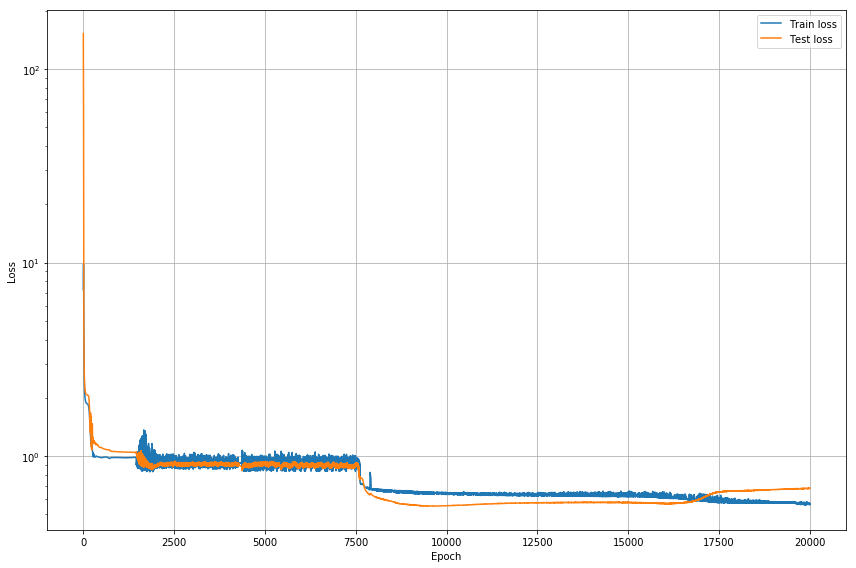

No handles with labels found to put in legend.


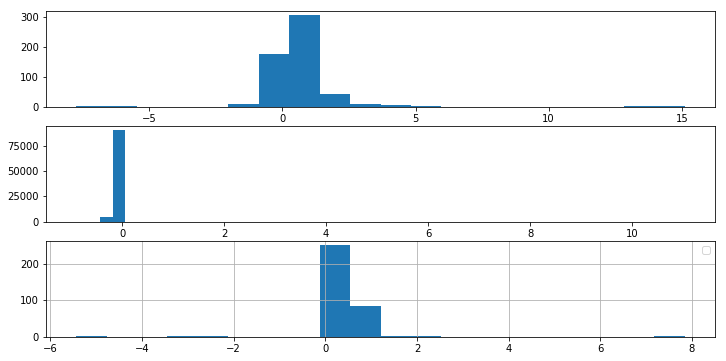

No handles with labels found to put in legend.


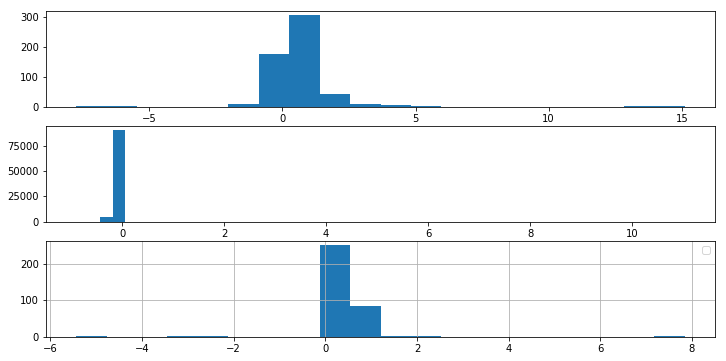

In [210]:
# Plot losses
plt.close('all')
plt.figure(figsize=(12,8))
plt.semilogy(train_loss_log, label='Train loss')
plt.semilogy(test_loss_log, label='Test loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid()
plt.legend()
plt.tight_layout()# Plot losses
plt.close('all')
plt.figure(figsize=(12,8))
plt.semilogy(train_loss_log, label='Train loss')
plt.semilogy(test_loss_log, label='Test loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid()
plt.legend()
plt.tight_layout()
plt.show()

# Plot weights after training
net.plot_weights()


plt.show()

# Plot weights after training
net.plot_weights()



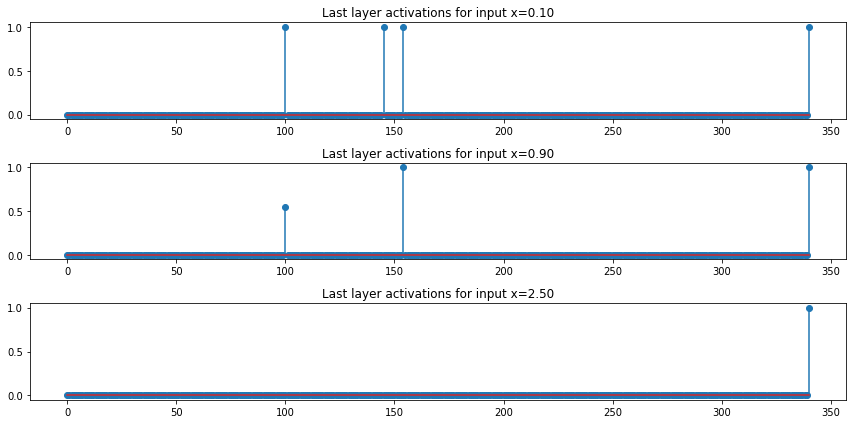

In [211]:
#%% Analyze actiovations

x1 = 0.1
y1, z1 = net.forward(x1, additional_out=True)
x2 = 0.9
y2, z2 = net.forward(x2, additional_out=True)
x3 = 2.5
y3, z3 = net.forward(x3, additional_out=True)


fig, axs = plt.subplots(3, 1, figsize=(12,6))
axs[0].stem(z1)
axs[0].set_title('Last layer activations for input x=%.2f' % x1)
axs[1].stem(z2)
axs[1].set_title('Last layer activations for input x=%.2f' % x2)
axs[2].stem(z3)
axs[2].set_title('Last layer activations for input x=%.2f' % x3)
plt.tight_layout()
plt.show()